# Big Data Analytics Project

Barış Özakar

Didem Durukan

Kartikey Sharma

Pratyush Singh

Tanmay ?



# Introduction

In [1]:
# Explain data here, where does it come from, what does each column represent? Is it monthly data (yes), from when to when?

# Research Questions

Questions to be answered:

    1) Are there consistent patterns? 

    2) The trend shows the general tendency of the data to increase or decrease during a long period of time. Is there 
    a significant trend? 

    3) Seasonality exists when a series exhibits regular fluctuations based on the season. Is there seasonality in our 
    series?

    4) Cyclic behaviour occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations 
    are usually due to economic conditions, and are often related to the “business cycle”. The duration of these 
    fluctuations is usually at least 2 years. Is there evidence of the presence of cycles in our data? 

    5) Outliers in time series data are values that significantly differ from the patterns and trends of the other values 
    in the time series. Are there any outliers in the data that need to be explained by those with expert knowledge? 

    6) How strong are the relationships among the variables available for analysis?
    
    7) We would like to forecast future prices of Coal.SA, which model would be best in handling this prediction? How can
    we compare between these different models?



#  Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import statsmodels.api as sm
from pylab import rcParams
from datetime import datetime
#from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot

rcParams['figure.figsize'] = 18, 10


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


A quick inspection at data reveal our data is the first day of every month for every year between 1992-2020. We forecast the Coal.SA series

### If using Colab

In [4]:
# step 1- Mount your Google Drive to Collaboratory

from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Big Data Analytics/coal-25082020.csv')
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values(by='Date')
df = df.set_index('Date')
df.index=pd.to_datetime(df.index.strftime("%Y-%d-%m"))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Preparation

In [5]:
#df = pd.read_csv("coal-25082020.csv")
#df.Date = pd.to_datetime(df.Date, dayfirst=True)
#df = df.sort_values(by='Date')
#df = df.set_index('Date')
#df.index=pd.to_datetime(df.index.strftime("%Y-%d-%m"))

## Data Cleaning

In [6]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [7]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                Feature  Number of NaN values
0        Coal.Australia                     0
1               Coal.SA                     0
2              CrudeOil                     0
3            Fuel.Index                     1
4            NaturalGas                     0
5   Coal.Producer.Index                     0
6                  Gold                     1
7                Silver                     0
8                Copper                     0
9               IronOre                     1
10       CrudeOil.Index                     0
11          Metal.Index                     0
12        NonFuel.Index                     0
13      Commodity.Index                     0
14                  CLI                     1
15                  CCI                     0
16                  BCI                     0


Our data looks pretty clean. We dealed with missing data using "Mean Imputation" method. We will fill the NaN values with the mean of the corresponding attributes. We need to deal with those NaN values even though they are not that much, because in feature selection steps some methods needs data to be NaN value free.

In [9]:
df['Fuel.Index'].fillna(value=df['Fuel.Index'].mean(),inplace=True)
df['Gold'].fillna(value=df['Gold'].mean(),inplace=True)
df['IronOre'].fillna(value=df['IronOre'].mean(),inplace=True)
df['CLI'].fillna(value=df['CLI'].mean(),inplace=True)
df.isnull().values.any()

False

## Feature Selection and Correlation


First we will analyze the correlation between features by correlation matrix and we will visualize it with heatmap. We will compare both Spearman and Pearson correlation coefficients.

### Pearson Correlation Coefficient

In [10]:
#Default of this method is 'Pearson'
df.corr()

Coal.Australia   Coal.SA  ...       CCI       BCI
Coal.Australia             1.000000  0.987597  ... -0.542247  0.177860
Coal.SA                    0.987597  1.000000  ... -0.539615  0.180988
CrudeOil                   0.850179  0.871322  ... -0.523912  0.200040
Fuel.Index                 0.851378  0.873123  ... -0.531671  0.194572
NaturalGas                 0.255521  0.290419  ... -0.164417  0.146136
Coal.Producer.Index        0.810126  0.823938  ... -0.492948  0.069715
Gold                       0.783050  0.801117  ... -0.490846  0.075308
Silver                     0.810518  0.829874  ... -0.515595  0.153023
Copper                     0.864974  0.874786  ... -0.458691  0.274979
IronOre                    0.852453  0.862946  ... -0.583230  0.123521
CrudeOil.Index             0.847381  0.870686  ... -0.496111  0.212045
Metal.Index                0.854603  0.865686  ... -0.430284  0.305553
NonFuel.Index              0.901460  0.910450  ... -0.559541  0.187807
Commodity.Index            0.887339  0.907782  ... -0.547654  0.193268
CLI                        0.082951  0.091018  ...  0.600969  0.881872
CCI                       -0.542247 -0.539615  ...  1.000000  0.564856
BCI                        0.177860  0.180988  ...  0.564856  1.000000

[17 rows x 17 columns]

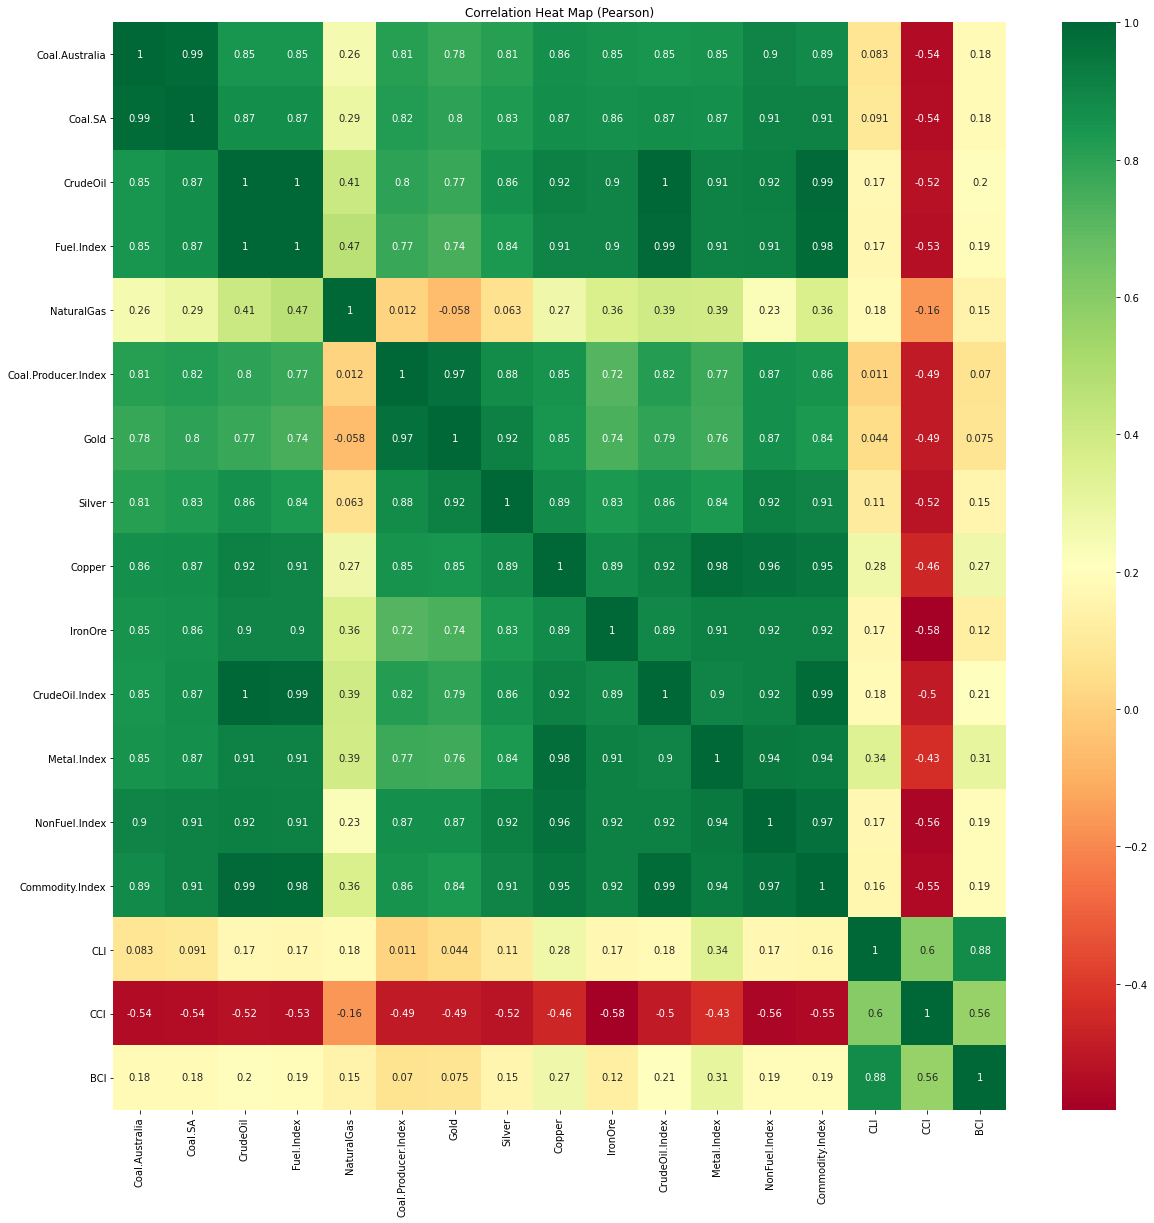

In [11]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Pearson)")

### Spearman Correlation Coefficient

In [12]:
df.corr(method='spearman')

Coal.Australia   Coal.SA  ...       CCI       BCI
Coal.Australia             1.000000  0.973604  ... -0.477537  0.276444
Coal.SA                    0.973604  1.000000  ... -0.466701  0.286296
CrudeOil                   0.825700  0.855360  ... -0.480276  0.272766
Fuel.Index                 0.820585  0.850857  ... -0.484887  0.269419
NaturalGas                 0.292782  0.366861  ... -0.137696  0.271374
Coal.Producer.Index        0.852715  0.858414  ... -0.540761  0.184543
Gold                       0.867391  0.867964  ... -0.528130  0.185918
Silver                     0.849249  0.857961  ... -0.411287  0.284948
Copper                     0.908248  0.893044  ... -0.465062  0.352826
IronOre                    0.863539  0.865173  ... -0.558628  0.168960
CrudeOil.Index             0.824017  0.855584  ... -0.466452  0.271480
Metal.Index                0.886046  0.885854  ... -0.382067  0.413140
NonFuel.Index              0.917062  0.904266  ... -0.513905  0.284239
Commodity.Index            0.873373  0.905722  ... -0.482329  0.294908
CLI                        0.197288  0.195795  ...  0.488844  0.849765
CCI                       -0.477537 -0.466701  ...  1.000000  0.467239
BCI                        0.276444  0.286296  ...  0.467239  1.000000

[17 rows x 17 columns]

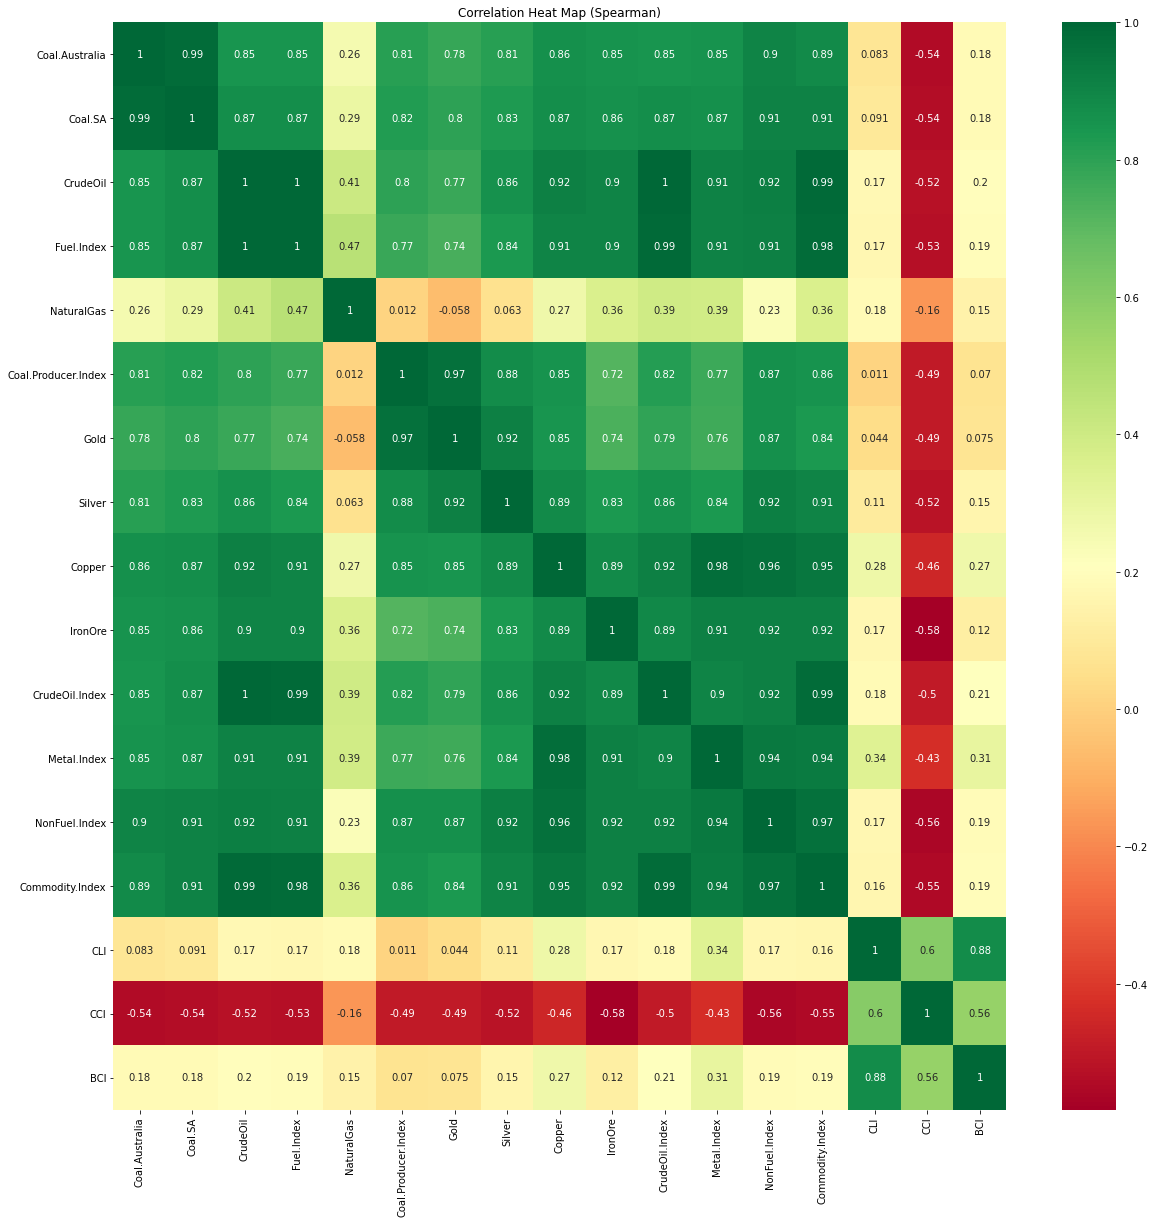

In [13]:
corrmat_spearman = df.corr(method='spearman')
top_corr_features = corrmat_spearman.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Spearman)")

As we can see, there is no big difference that needs to be considered between two different correlation coefficients. Therefore, we will continue with our feature selection step using Pearson Correlation Coefficient.

## Feature Selection

We will look at the features that have higher correlation than 0.5 with our target variable.

In [14]:
#Correlation with output variable
cor_target = abs(corrmat["Coal.SA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

Coal.Australia         0.987597
Coal.SA                1.000000
CrudeOil               0.871322
Fuel.Index             0.873123
Coal.Producer.Index    0.823938
Gold                   0.801117
Silver                 0.829874
Copper                 0.874786
IronOre                0.862946
CrudeOil.Index         0.870686
Metal.Index            0.865686
NonFuel.Index          0.910450
Commodity.Index        0.907782
CCI                    0.539615
Name: Coal.SA, dtype: float64


Now, we will check the correlation between these variables. The reason why we need check the correlation between the attributes besides our target attribute, is to find the unnecessary ones. These unnecessary attributes will cause us problems such as overfitting during the machine learning step. Thus, we have to detect them and remove them from our data

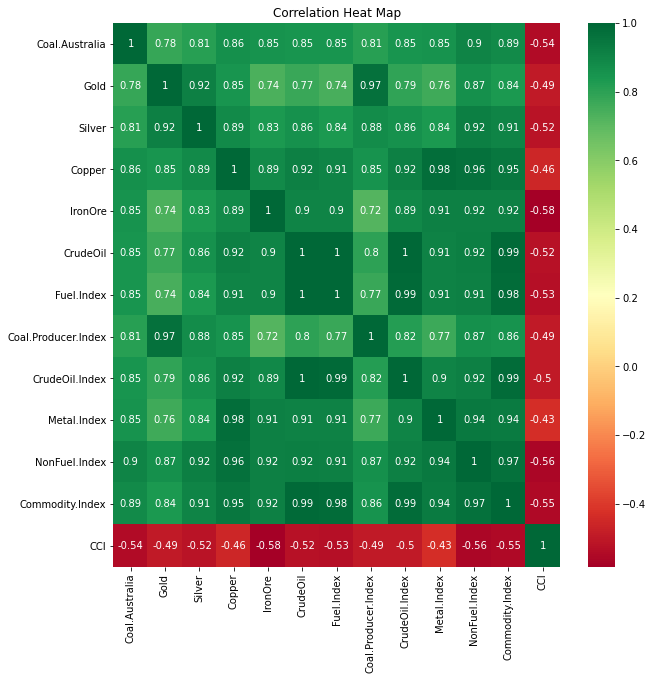

In [15]:
rf_df = df[['Coal.Australia', 'Gold','Silver','Copper','IronOre','CrudeOil','Fuel.Index','Coal.Producer.Index','CrudeOil.Index','Metal.Index','NonFuel.Index','Commodity.Index','CCI']]
fig, ax = plt.subplots(figsize=(10,10))
h=sns.heatmap(rf_df.corr(),annot=True,cmap="RdYlGn",ax=ax).set_title("Correlation Heat Map")

## Notes about correlation

From the above correlation matrix, we get the following results
    * Gold and Copper has high correlation
    * Gold and Coal.Producer.Index has high correlation
    * Silver and Gold has high Correlation
    * Silver and NonFuel.Index has high correlation also there is high correlation with Commodity.Index
    * Copper and CrudeOil,Fuel.Index,Metal.Index,NonFuel.Index,Commodity.Index and CrudeOil.Index has    high correlation
    * IronOre and Fuel.Index,CrudeOil,Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil and Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil.Index and Fuel.Index,NonFuel.Index,Metal.Index has high correlation
    * Metal.Index has high correlation with Fuel.Index,NonFuel.Index,Commodity.Index
    * NonFuel.Index has high correlation with Fuel.Index,Commodity.Index
    
 We will check these variables' correlation with our target variable and then drop the  attribute that has lowest correlation with our target. If two attribute has a high correlation between them, this means that they almost have linear relationship. So, we can think of them as a single variable basically. Therefore, we will see which one has the highest correlation with our target variable and remove the other one.

Text(0.5, 1.0, 'Metal.Index vs. Copper')

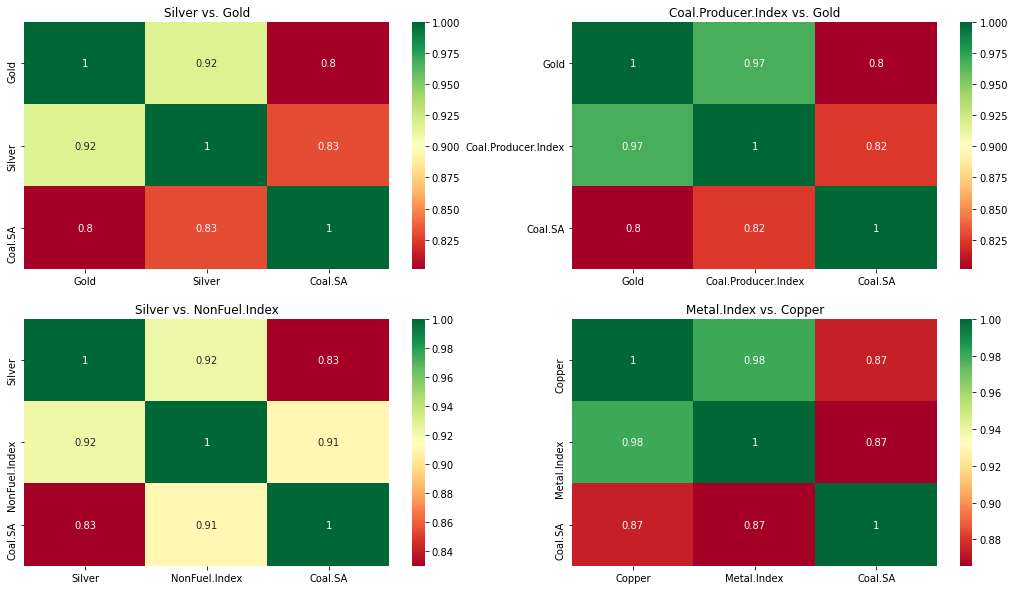

In [16]:
fig2,ax2 = plt.subplots(2,2)
sns.heatmap(df[['Gold','Silver','Coal.SA']].corr(),ax=ax2[0][0],annot=True,cmap="RdYlGn").set_title('Silver vs. Gold')
sns.heatmap(df[['Gold','Coal.Producer.Index','Coal.SA']].corr(),ax=ax2[0][1],annot=True,cmap="RdYlGn").set_title('Coal.Producer.Index vs. Gold')
sns.heatmap(df[['Silver','NonFuel.Index','Coal.SA']].corr(),ax=ax2[1][0],annot=True,cmap="RdYlGn").set_title('Silver vs. NonFuel.Index')
sns.heatmap(df[['Copper','Metal.Index','Coal.SA']].corr(),ax=ax2[1][1],annot=True,cmap="RdYlGn").set_title('Metal.Index vs. Copper')


We examined the attributes that has high correlation between them and observed their relationship with our target variable. After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes.

Text(0.5, 1.0, 'Fuel.Index vs. CrudeOil')

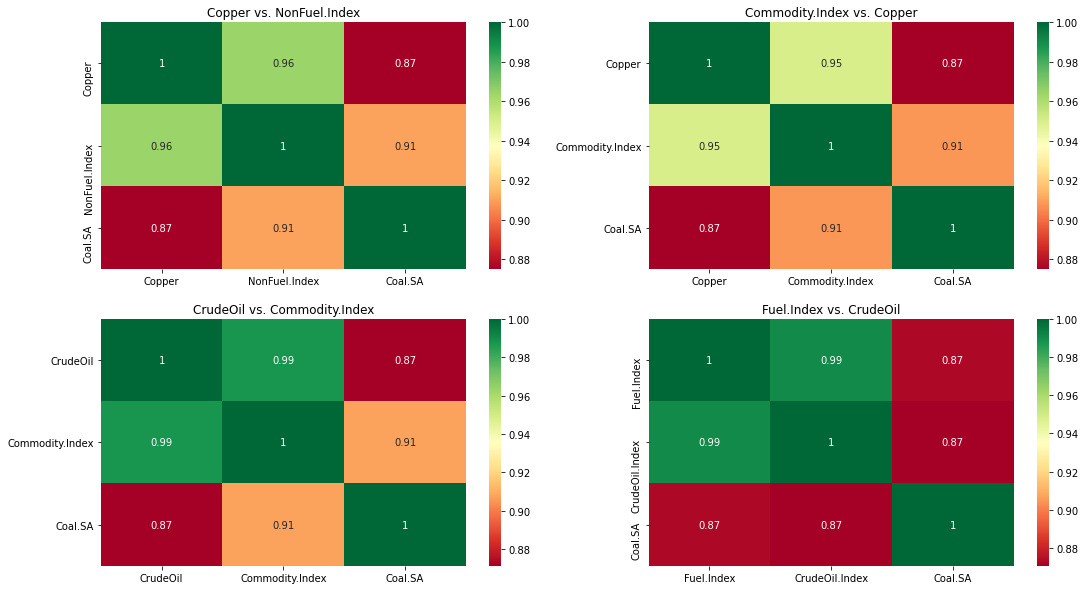

In [17]:
fig3,ax3 = plt.subplots(2,2)
sns.heatmap(df[['Copper','NonFuel.Index','Coal.SA']].corr(),ax=ax3[0][0],annot=True,cmap="RdYlGn").set_title('Copper vs. NonFuel.Index')
sns.heatmap(df[['Copper','Commodity.Index','Coal.SA']].corr(),ax=ax3[0][1],annot=True,cmap="RdYlGn").set_title('Commodity.Index vs. Copper')
sns.heatmap(df[['CrudeOil','Commodity.Index','Coal.SA']].corr(),ax=ax3[1][0],annot=True,cmap="RdYlGn").set_title('CrudeOil vs. Commodity.Index')
sns.heatmap(df[['Fuel.Index','CrudeOil.Index','Coal.SA']].corr(),ax=ax3[1][1],annot=True,cmap="RdYlGn").set_title('Fuel.Index vs. CrudeOil') 

After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes. We decide to take the attribute "Non-Fuel" and drop "Copper".

Text(0.5, 1.0, 'CrudeOil.Index vs. Commodity.Index')

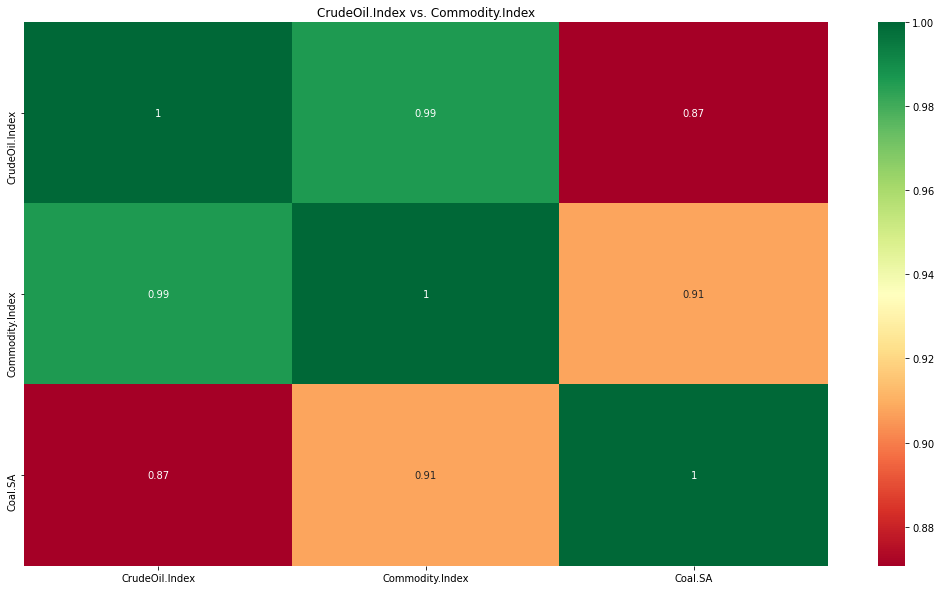

In [18]:
sns.heatmap(df[['CrudeOil.Index','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn").set_title("CrudeOil.Index vs. Commodity.Index") 


We will take all the variables has high correlation with our target "Corel.SA" and drop the others with the ones we decide to eliminate after analysing the heatmaps above.


In [19]:
df.drop(['Gold','Silver','Copper','CrudeOil','CLI','BCI','NaturalGas'], axis=1,inplace=True)
df.head()
df.shape

(343, 10)

In [20]:
df.columns

Index(['Coal.Australia', 'Coal.SA', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI'],
      dtype='object')

# Exploratory Data Analysis

### Time Series Plot

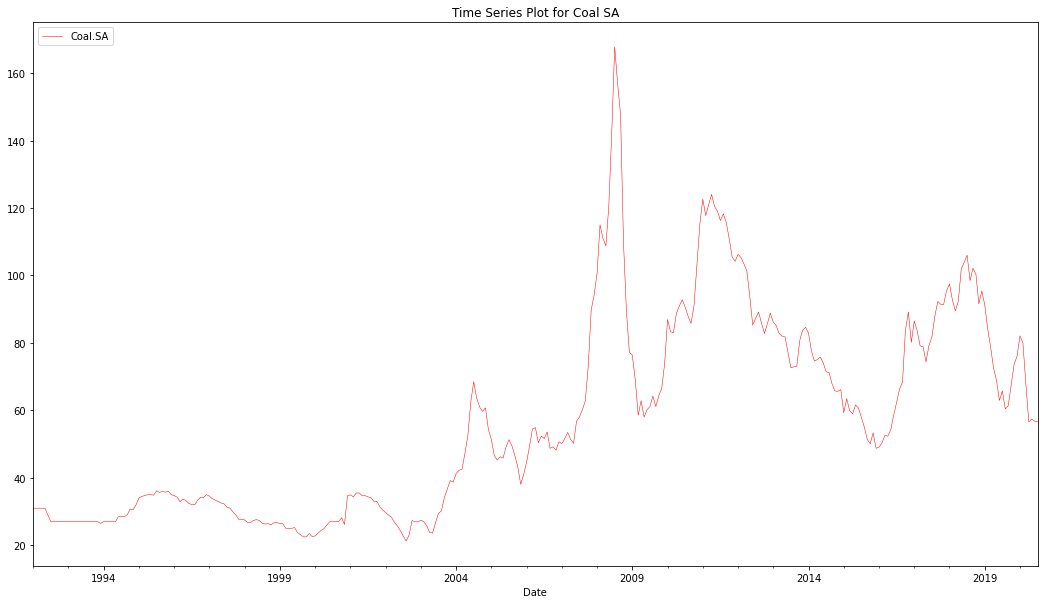

In [21]:
df["Coal.SA"].plot(linewidth=0.5, color='red')
plt.legend(df[["Coal.SA"]], loc ="upper left") 
plt.title("Time Series Plot for Coal SA")
plt.show()

Time series plot reveals that the coal prices have generally increased over time. There is a clear sign of trend. The variance seems to be low from 1992-2002 and is higher generally higher 2004 onwards. This indicates that in order to account for this increase in variance, we may need to take the log of the series. There are no cycles in the series. 
   

## Trend

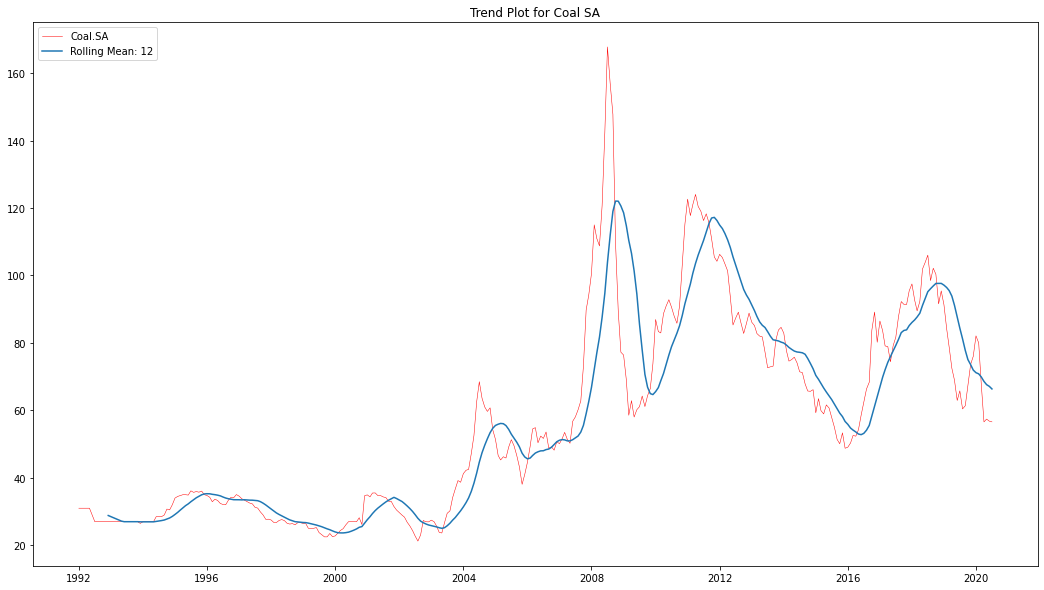

In [22]:
plt.plot(df.index, df["Coal.SA"], linewidth=0.5, color='red')
plt.plot(pd.Series.rolling(df["Coal.SA"], 12).mean())
plt.legend(["Coal.SA", "Rolling Mean: 12"], loc ="upper left") 
plt.title("Trend Plot for Coal SA")
plt.show()

The simple moving average is the unweighted mean of the previous M data points. Here M=12 to account for the annual effect.
We can see that:
1) Coal SA series has a trend. It goes up until around 2008 and then the trend changes direction and starting from 2008. Since there is trend, the time series is not stationary.

Because of the trend, we may say that the data is not stationary but such a hypothesis needs to be checked using the following methods: (ACF plot of the data as well as the Adjusted Dickey Fuller Test)

## Seasonality

In [23]:
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = pd.DatetimeIndex(df.index).month

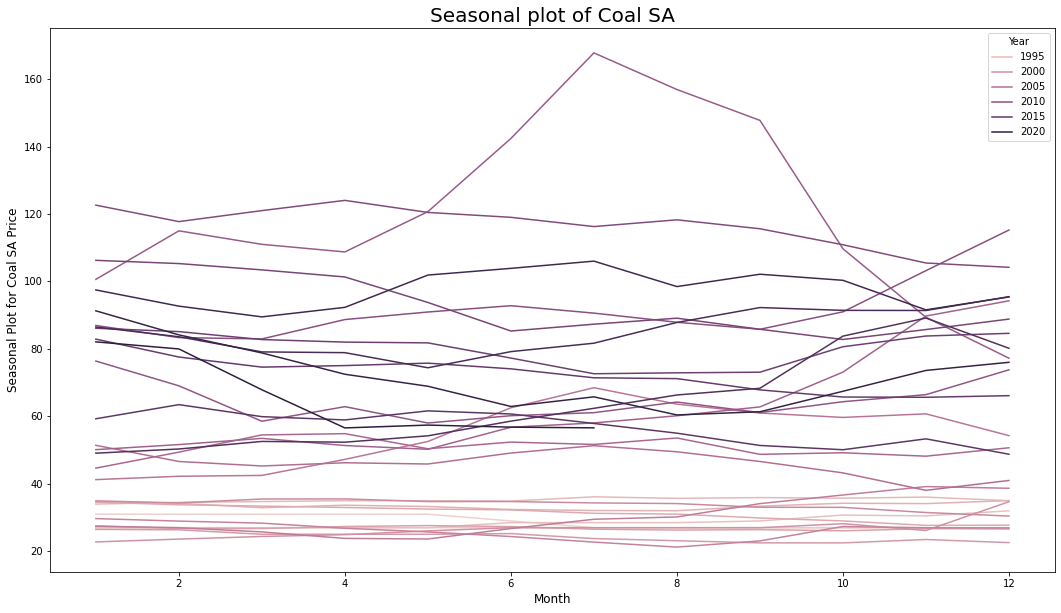

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Seasonal Plot for Coal SA Price', fontsize = 12);
ax.set_title('Seasonal plot of Coal SA', fontsize = 20, loc='center');
sns.lineplot(x=df['Month'], y=df["Coal.SA"], hue=df['Year']);

Looking at the seasonal plot, there does not seem to be a significant increase or decrease from one month to another over the years, although in the obvious outlier, there seems to be an increase from April to July. However, the general picture reflects no "obvious" seasonality.

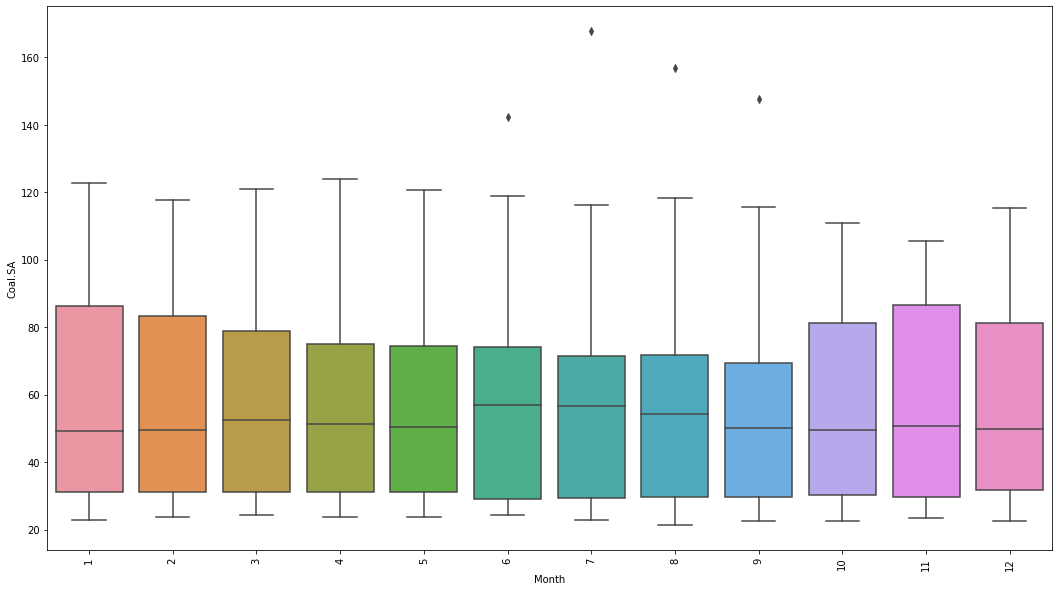

In [25]:
ax = sns.boxplot(data=df, x='Month', y='Coal.SA')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

As it can be seen from the seasonal boxplot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality. We also realize there are some outliers, looking back at the data for those levels, it indicates that the outliers are coming from the year 2008-2009.

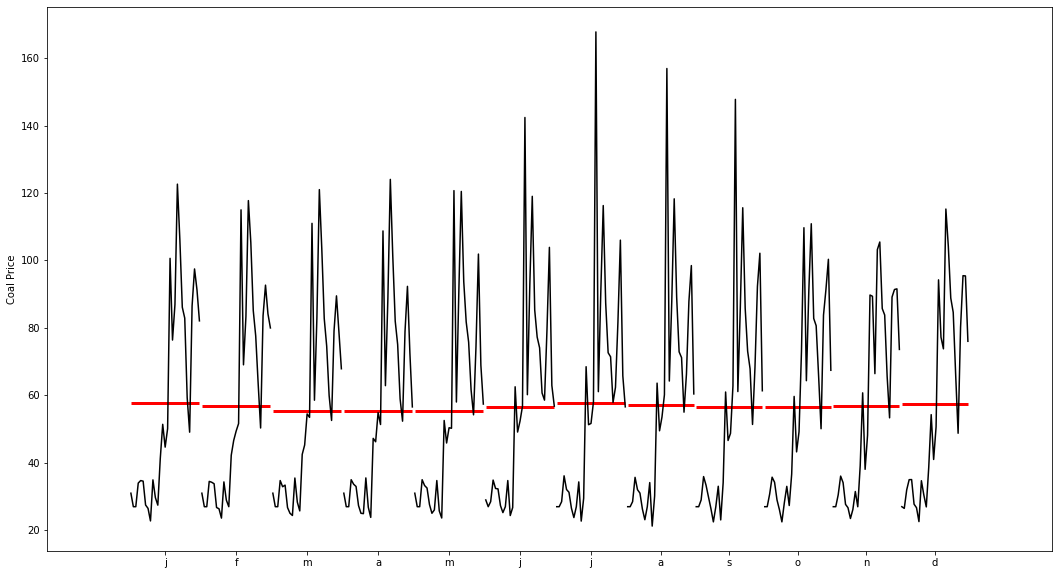

In [26]:
month_plot(df["Coal.SA"],ylabel='Coal Price');

As it can be seen from the seasonal subseries plot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality.

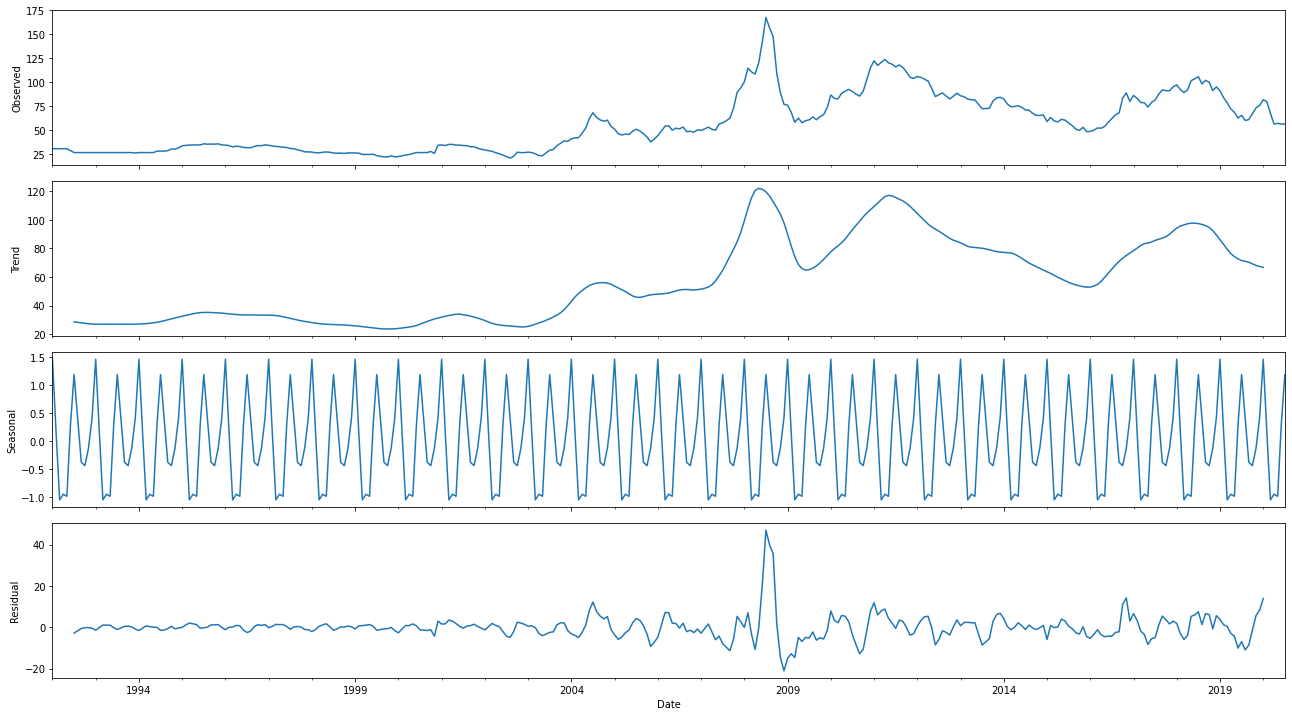

In [27]:
cls_decomposition = sm.tsa.seasonal_decompose(df["Coal.SA"], model='additive')
fig = cls_decomposition.plot()
plt.show()

From the classical decomposition, we can conclude that there appears to be no significant seasonality in the data since the seasonal component ranges from -1 to 1 (in the additive case does not have significant influence). We can see how little seasonality plays a role by plotting the seasonally adjusted and the original data together.

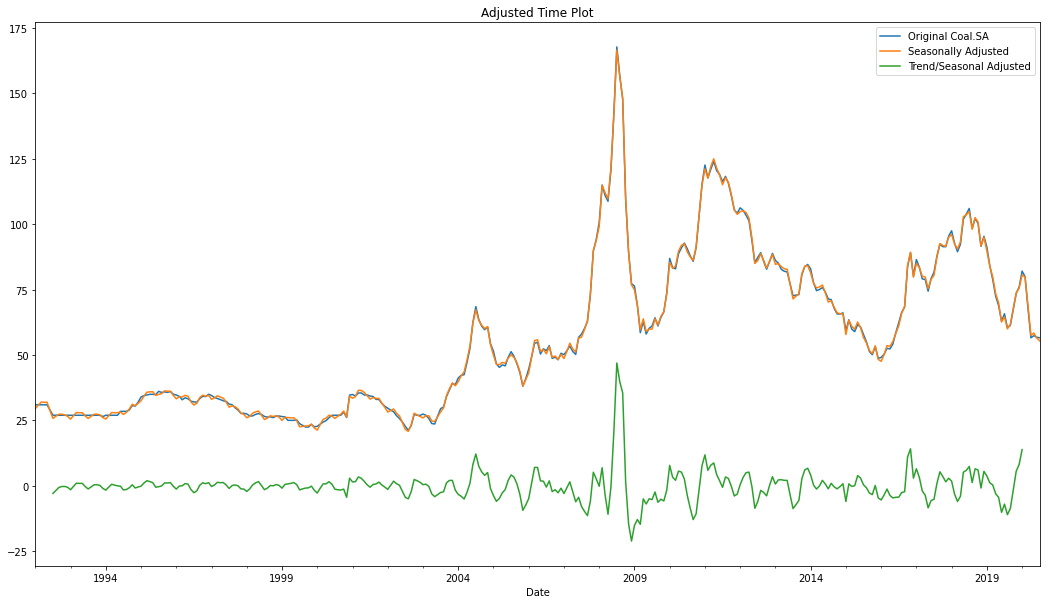

In [28]:
df["Coal.SA"].plot(label="Original Coal.SA")
df['Seasonally Adjusted'] = df['Coal.SA'] - cls_decomposition.seasonal
df["Seasonally Adjusted"].plot(label="Seasonally Adjusted")
df["Trend/Seasonal Adjusted"] = df["Coal.SA"] - cls_decomposition.seasonal- cls_decomposition.trend
df["Trend/Seasonal Adjusted"].plot(label="Trend/Seasonal Adjusted")
plt.legend();
plt.title("Adjusted Time Plot");

Here we can see that seasonality does not have a significant effect whereas the trend does.

## Handling Outliers


For every attribute we will check if there are any outliers by using box plots. We will examine the data both from years and months perspective. Since we do not have too much data, we will replace the outliers with the mean of the corresponding attribute.

### Checking Outliers (Month Perspective)


Text(0.5, 1.0, 'Coal.Producer.Index')

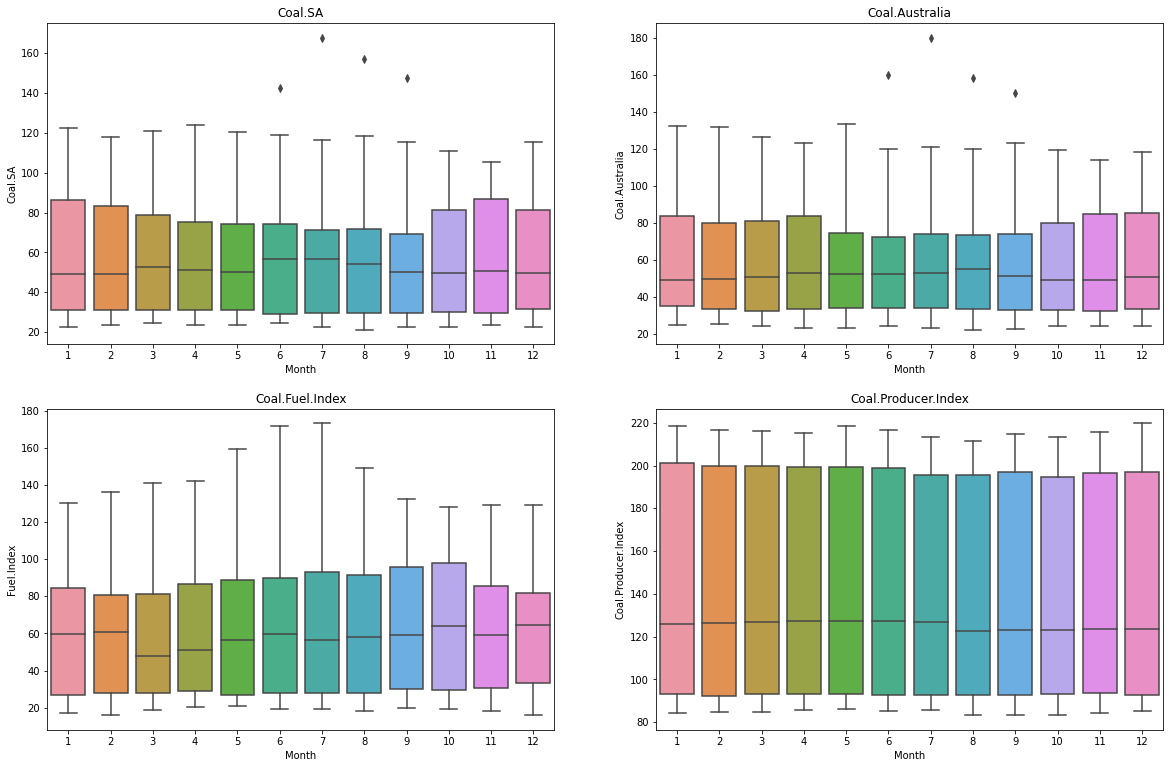

In [29]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='Coal.SA',ax=ax3[0][0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Month', y='Coal.Australia',ax=ax3[0][1]).set_title("Coal.Australia")
sns.boxplot(data=df, x='Month', y='Fuel.Index',ax=ax3[1][0]).set_title("Coal.Fuel.Index")
sns.boxplot(data=df, x='Month', y='Coal.Producer.Index',ax=ax3[1][1]).set_title("Coal.Producer.Index")

As we can see from the box-plots above we have outliers in our attributes Coal.SA and Coal.Australia.

Text(0.5, 1.0, 'Commodity.Index')

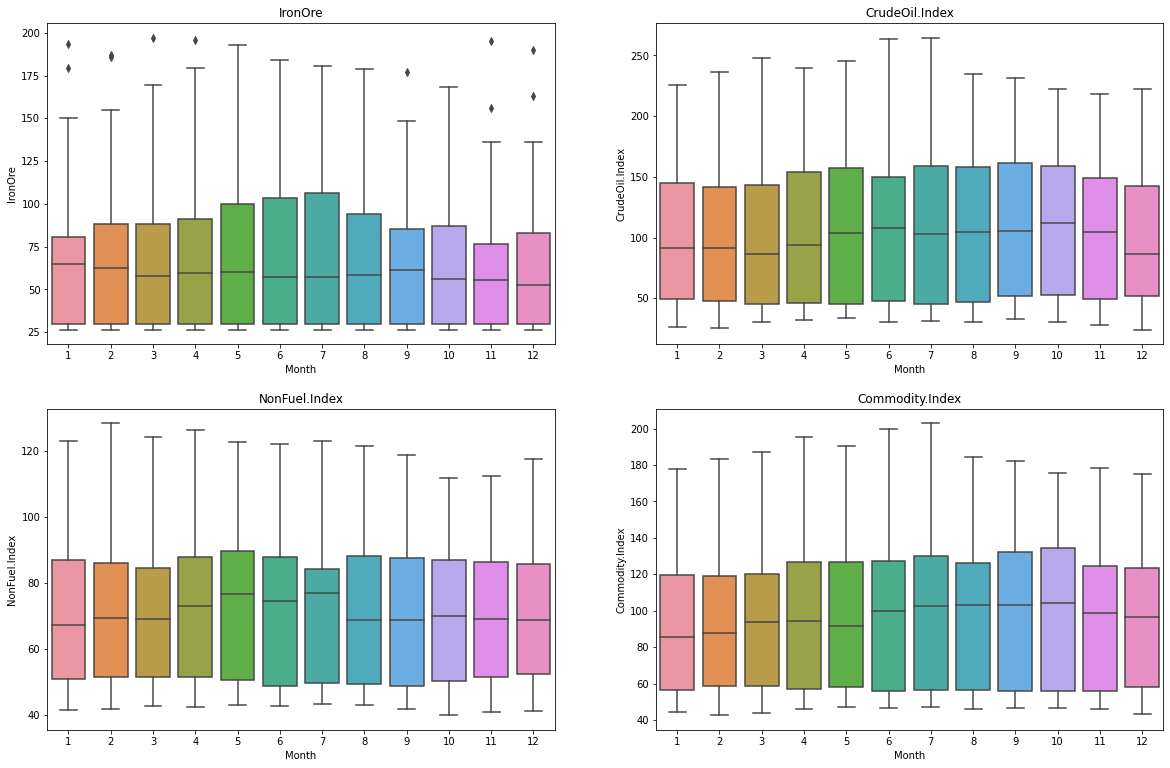

In [30]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='IronOre',ax=ax3[0][0]).set_title("IronOre")
sns.boxplot(data=df, x='Month', y='CrudeOil.Index',ax=ax3[0][1]).set_title("CrudeOil.Index")
sns.boxplot(data=df, x='Month', y='NonFuel.Index',ax=ax3[1][0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Month', y='Commodity.Index',ax=ax3[1][1]).set_title("Commodity.Index")

We can see that we have outliers in our attribute IronOre.

Text(0.5, 1.0, 'Metal.Index')

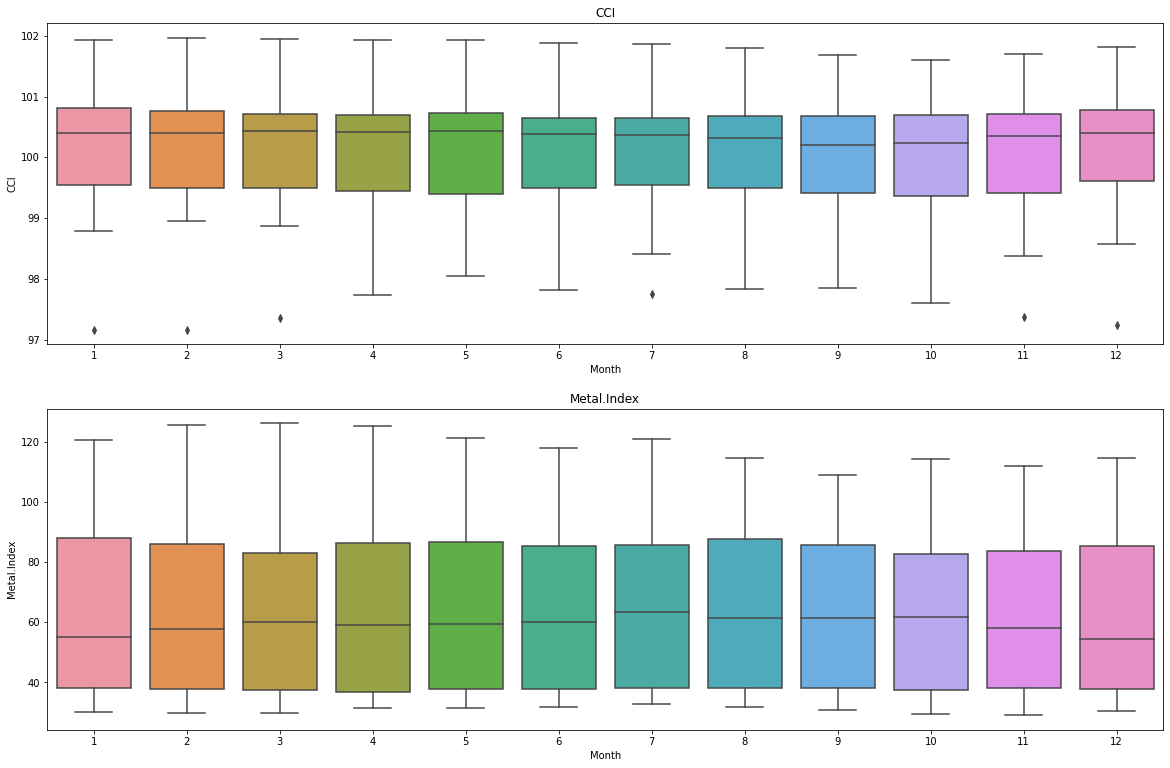

In [31]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Month',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Month',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

Our attribute CCI also contains outliers.

### Replace the Outliers
As we can see, from month perspective,in some of the variables we have outliers. We will detect them using IQR score, and if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [32]:
def calculate_whiskers(attribute,time,perspective):
    Q1=df.loc[df[perspective] == time, attribute].quantile(0.25)
    Q3=df.loc[df[perspective] == time, attribute].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    return Upper_Whisker,Lower_Whisker

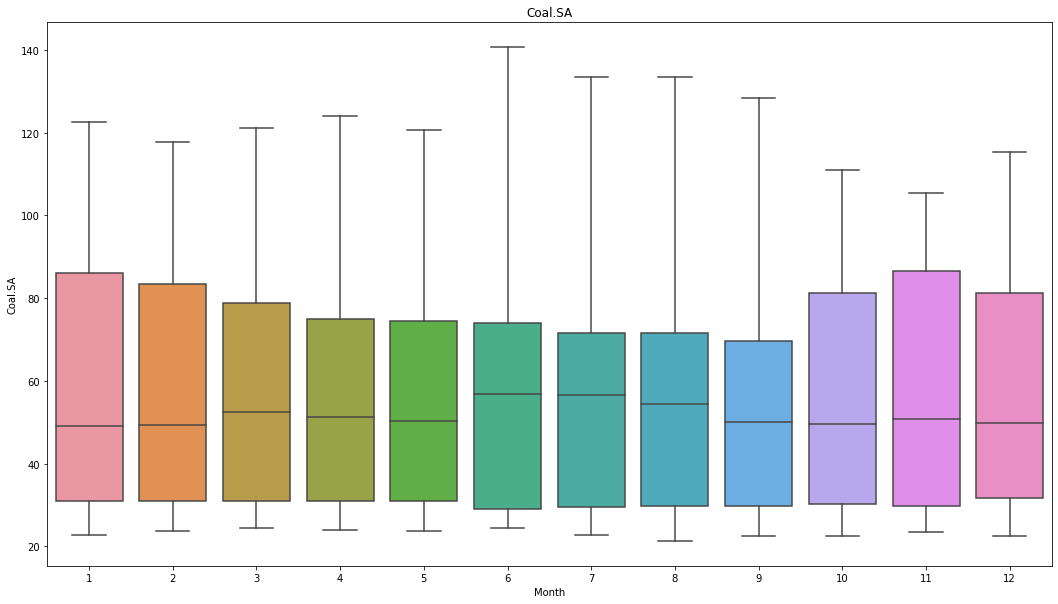

In [33]:
#For the target value "Coal.SA"
df.sort_values(by=['Coal.SA'],inplace=True)
months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",month,"Month")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue      
ax = sns.boxplot(data=df, x='Month', y='Coal.SA').set_title("Coal.SA")

We successfully removed our attribute Coal.SA from the outliers!

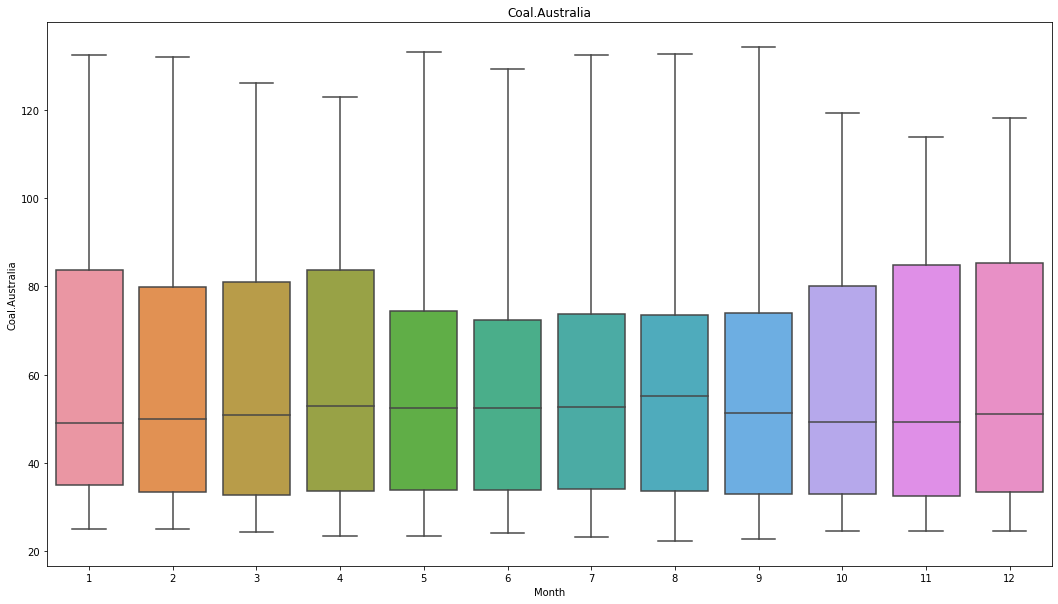

In [34]:
df.sort_values(by=['Coal.Australia'],inplace=True)

months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",month,"Month")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  
                
ax = sns.boxplot(data=df, x='Month', y='Coal.Australia').set_title("Coal.Australia")

We successfully removed our attribute Coal.Australia from the outliers!

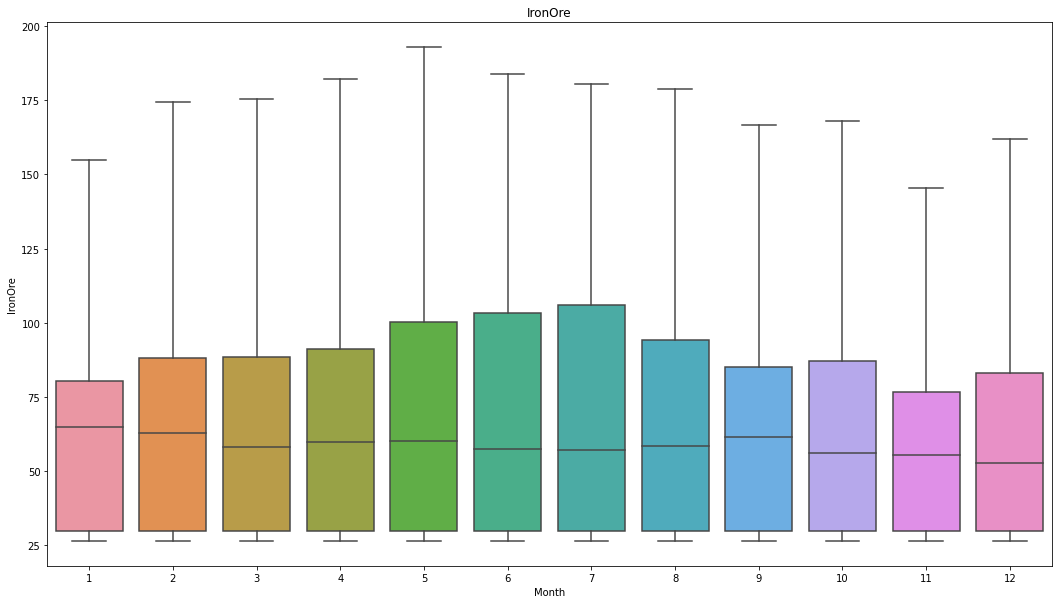

In [35]:
df.sort_values(by=['IronOre'],inplace=True)
months = [1,2,3,4,9,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",month,"Month")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='IronOre').set_title("IronOre")

We successfully removed our attribute IronOre from the outliers!

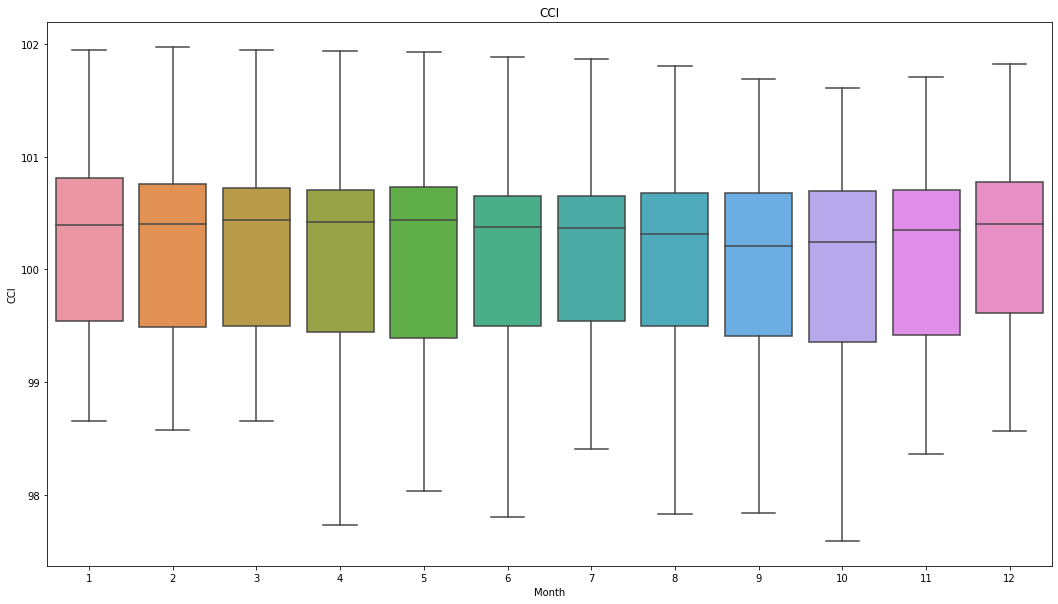

In [36]:
df.sort_values(by=['CCI'],inplace=True)

months = [1,2,3,7,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",month,"Month")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='CCI').set_title("CCI")            

As we can see, we removed the outliers.Our data looks outlier free!

In [37]:
df.shape

(343, 14)

## Checking Outliers (Year Perspective) 
Now we will look at the outliers from year perspective.

Text(0.5, 1.0, 'Coal.Australia')

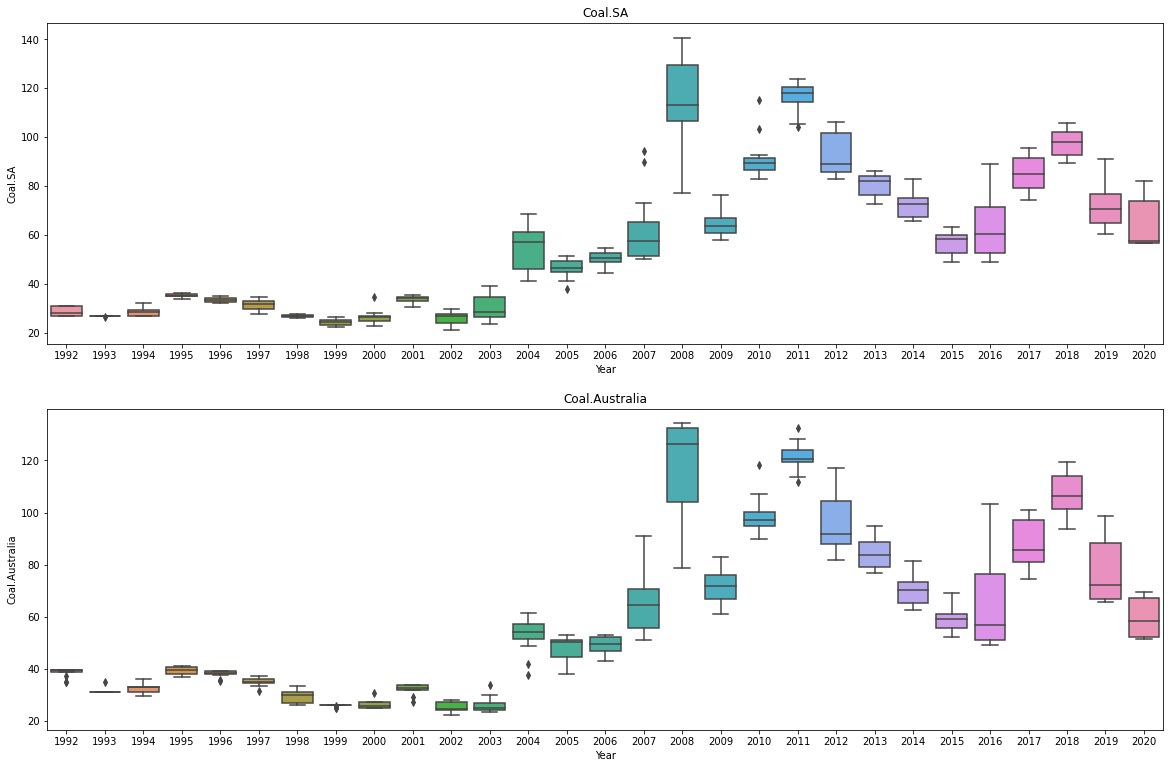

In [38]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia")

Text(0.5, 1.0, 'Coal.Producer.Index')

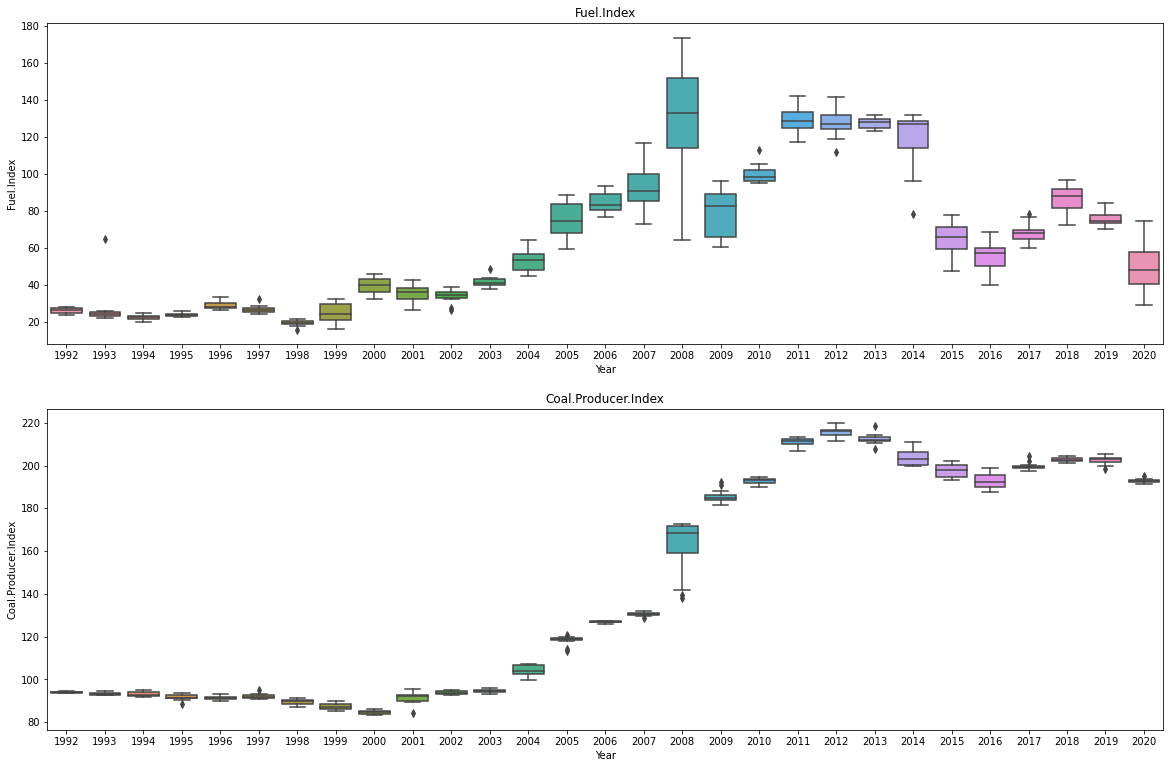

In [39]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index")

Text(0.5, 1.0, 'CrudeOil.Index')

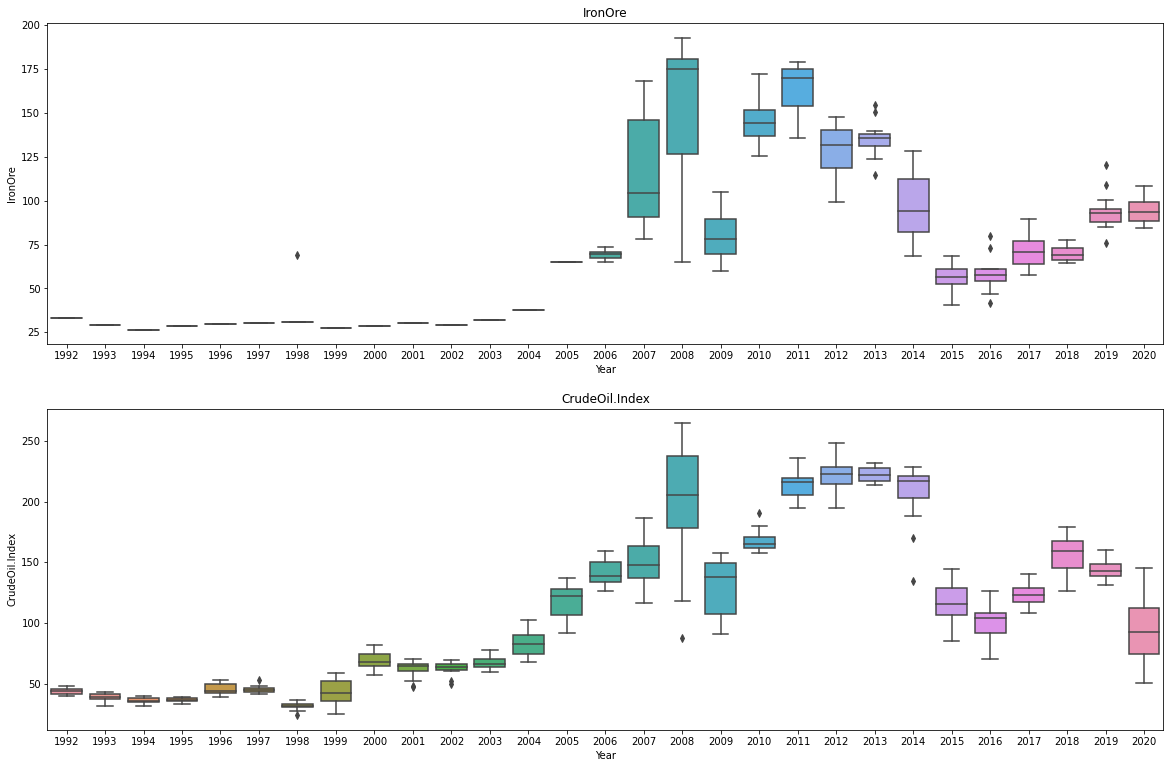

In [40]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index")

Text(0.5, 1.0, 'Commodity.Index')

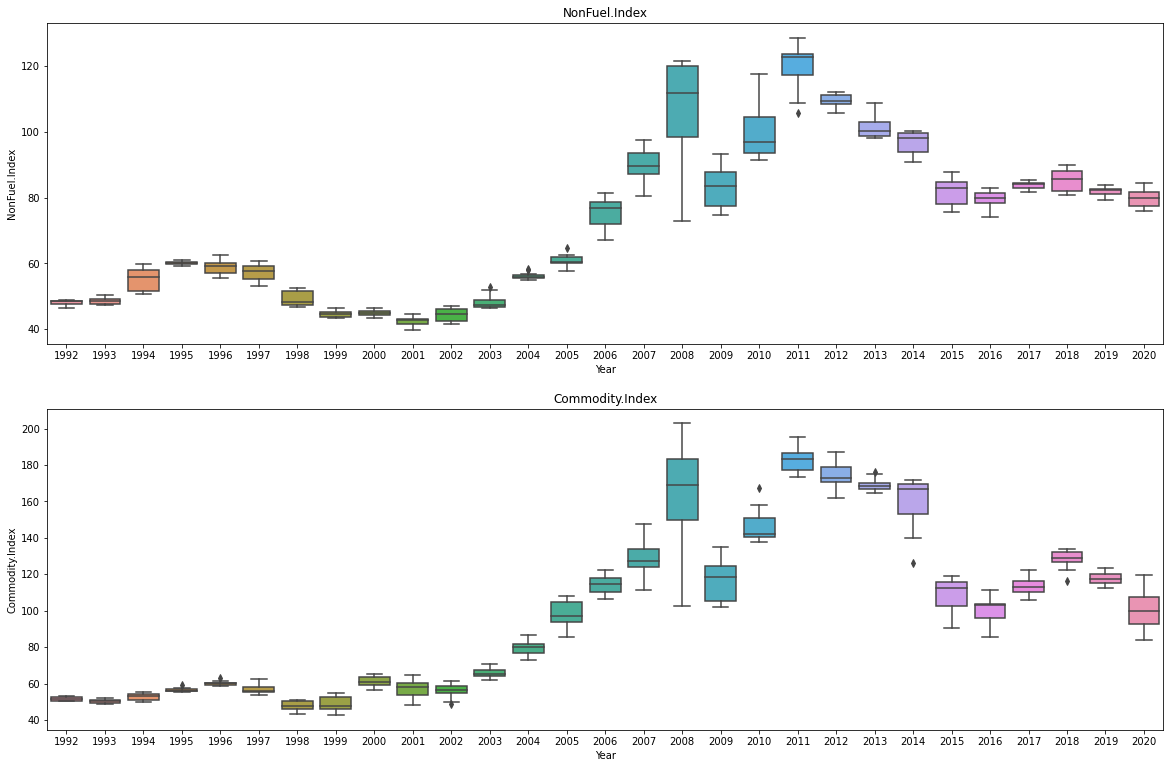

In [41]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index")

Text(0.5, 1.0, 'Metal.Index')

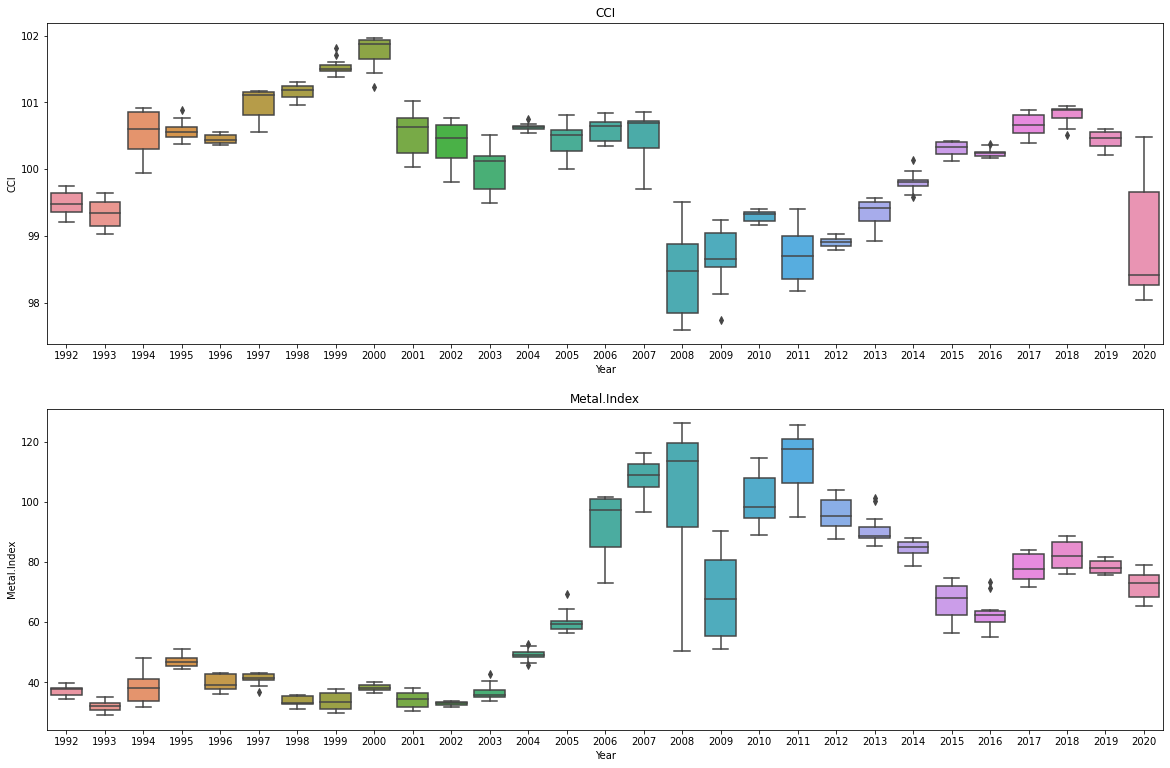

In [42]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

As we can see, from year perspective,in most of the attributes we have outliers. 

### Replacing the Outliers
We will detect outliers using IQR score. And if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [43]:
#for Coal.SA
years = [1993,2000,2007,2010,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",year,"Year")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [44]:
#For Coal.Aus
years = [1993,1992,1997,1999,1996,2001,2003,2004,2010,2000,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",year,"Year")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Australia after Outlier Removal')

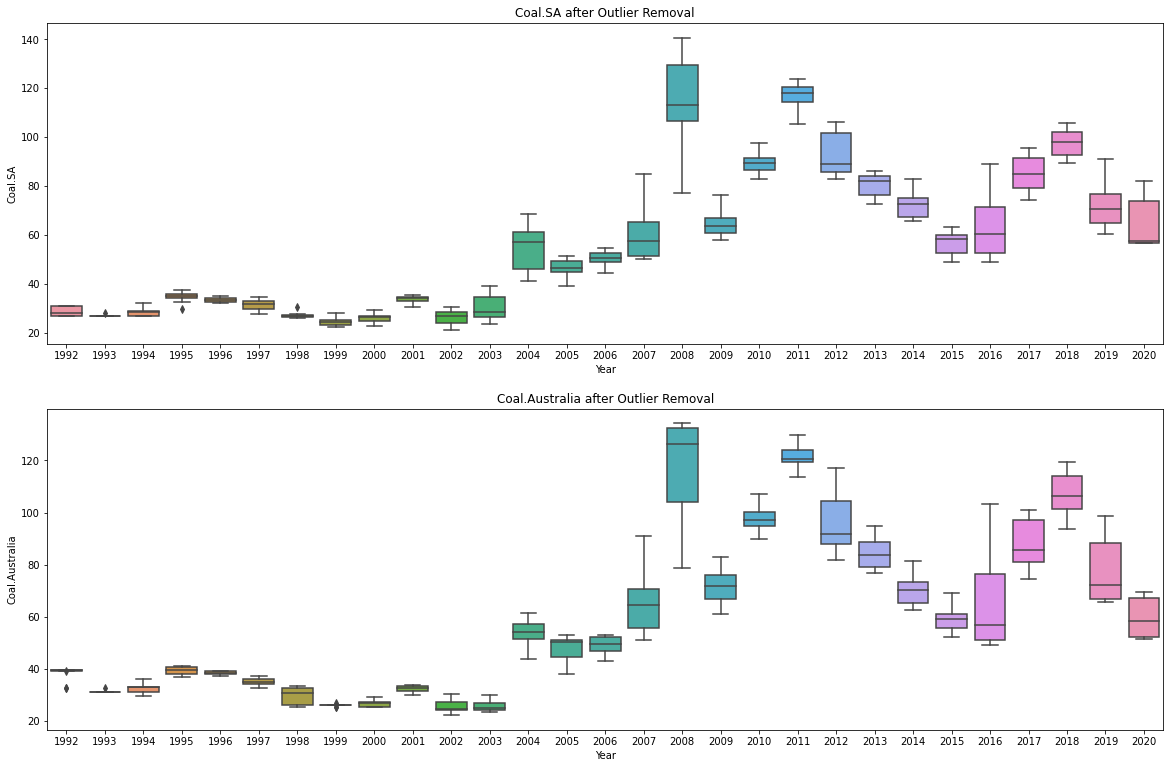

In [45]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia after Outlier Removal")

In [46]:
#For Fuel.Index
years = [1993,1998,1997,2002,2003,2012,2010,2014]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Fuel.Index",year,"Year")
            if(df['Fuel.Index'][ind] > Upper_Whisker):
                df.replace(df['Fuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Fuel.Index'][ind] < Lower_Whisker):
                df.replace(df['Fuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [47]:
#For Coal Producer Index
years = [1995,2001,1997,2005,2007,2008,2009,2013,2017,2019,2020]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Producer.Index",year,"Year")
            if(df['Coal.Producer.Index'][ind] > Upper_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Producer.Index'][ind] < Lower_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Producer.Index after Outlier Removal')

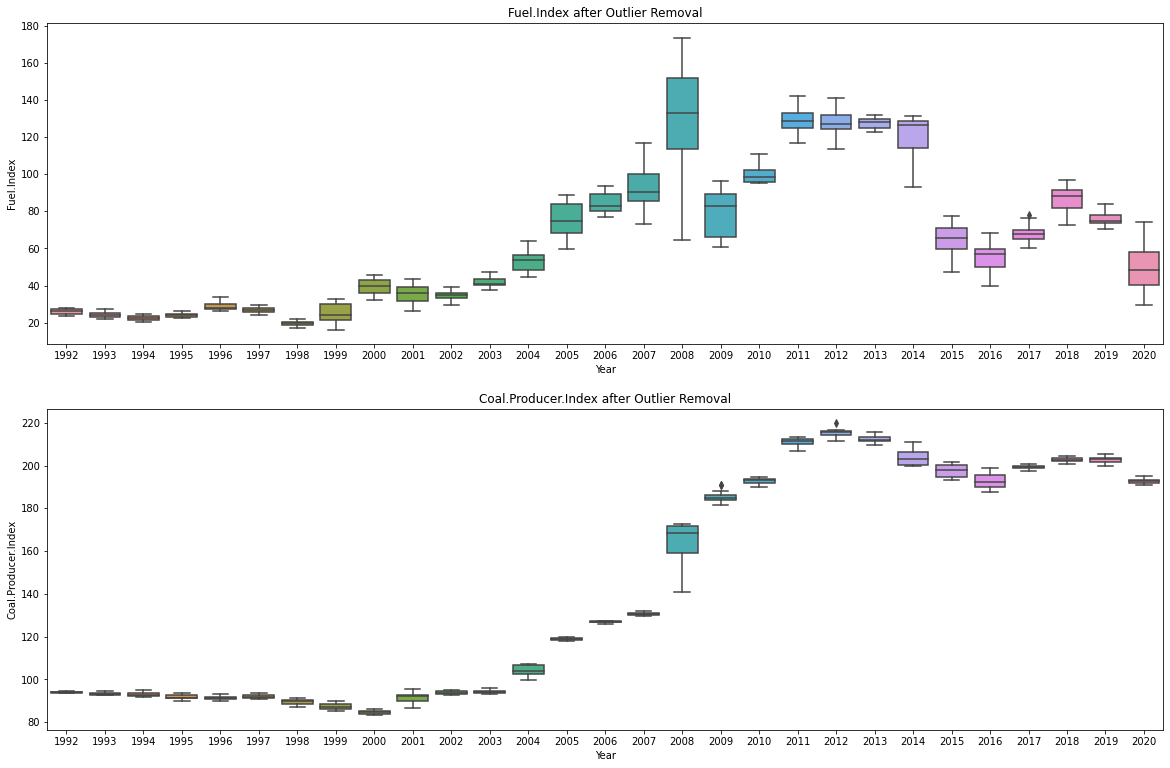

In [48]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index after Outlier Removal")

In [49]:
#For IronOre
years = [1998,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",year,"Year")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [50]:
#For Crude.Oil.Index
years = [1997,1998,2001,2002,2008,2010,2014,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CrudeOil.Index",year,"Year")
            if(df['CrudeOil.Index'][ind] > Upper_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CrudeOil.Index'][ind] < Lower_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'CrudeOil.Index after Outlier Removal')

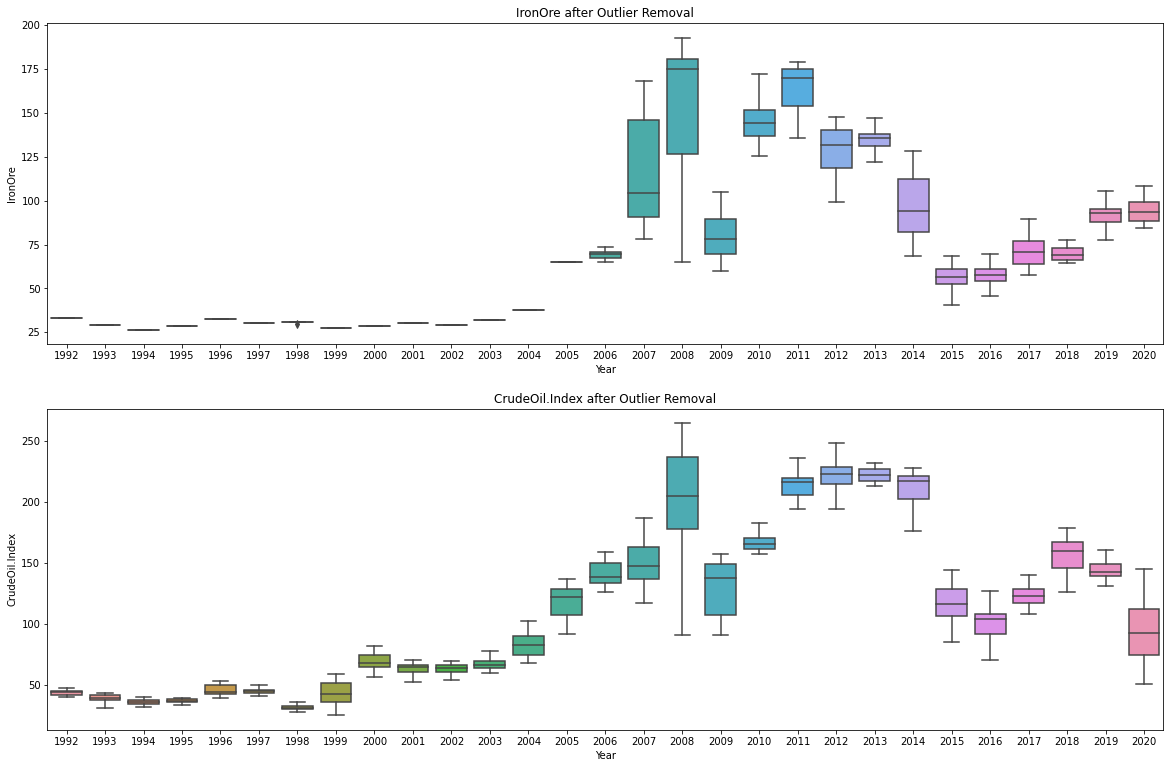

In [51]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre after Outlier Removal")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index after Outlier Removal")

In [52]:
#For Non-Fuel Index
years = [2003,2004,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("NonFuel.Index",year,"Year")
            if(df['NonFuel.Index'][ind] > Upper_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['NonFuel.Index'][ind] < Lower_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [53]:
#For Commodity.Oil.Index
years = [1995,1996,2002,2013,2010,2014,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Commodity.Index",year,"Year")
            if(df['Commodity.Index'][ind] > Upper_Whisker):
                df.replace(df['Commodity.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Commodity.Index'][ind] < Lower_Whisker):
                df.replace(df['Commodity.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Commodity.Index after Outlier Removal')

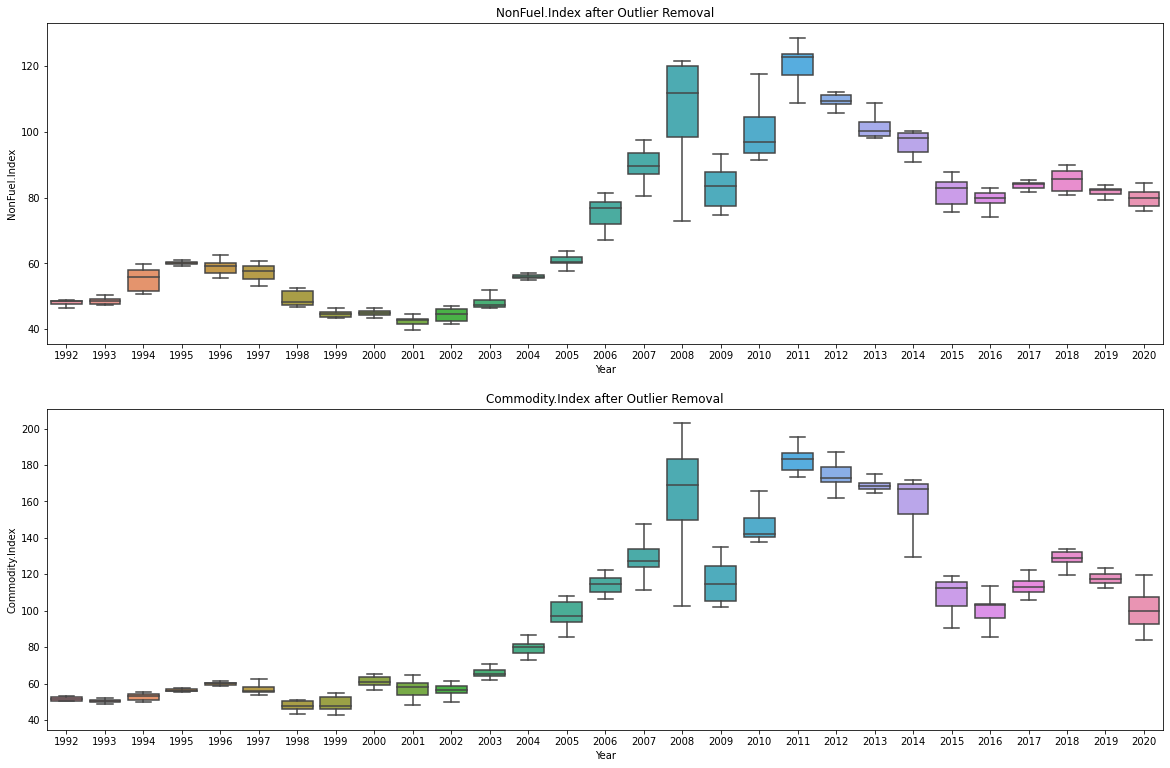

In [54]:
ffig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index after Outlier Removal")

In [55]:
#For CCI
years = [1995,1999,2000,2004,2009,2014,2016,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",year,"Year")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [56]:
#For Metal Index
years = [2003,2004,2005,2013,2016,1997]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Metal.Index",year,"Year")
            if(df['Metal.Index'][ind] > Upper_Whisker):
                df.replace(df['Metal.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Metal.Index'][ind] < Lower_Whisker):
                df.replace(df['Metal.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [57]:
df=df.sort_index()

Text(0.5, 1.0, 'Metal.Index after Outlier Removal')

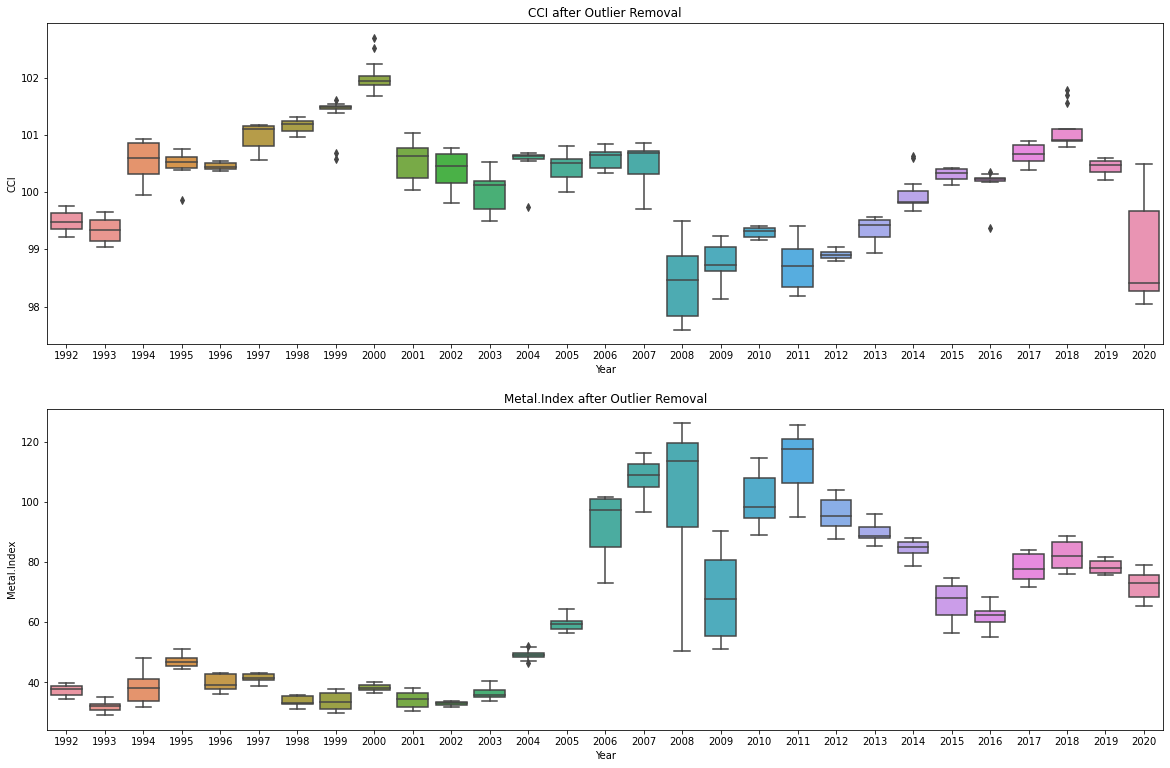

In [58]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI after Outlier Removal")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index after Outlier Removal")

We handled outliers in years perspective as seen in the graphs. We believe the reason for the outliers is the economic crise in 2008. There was a sharp slowdown in demand,and with mining output remaining stubbornly high. Therefore, coal benchmarks fell down.

## Stationarity 

As mentioned in the trend section, we need to further check stationarity using these methods:

ADF plot: If most of the (95%) autocorrelation values are within the confidence interval, we can conclude that the series is stationary.

Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value (0.05), we can say that time series is stationary.

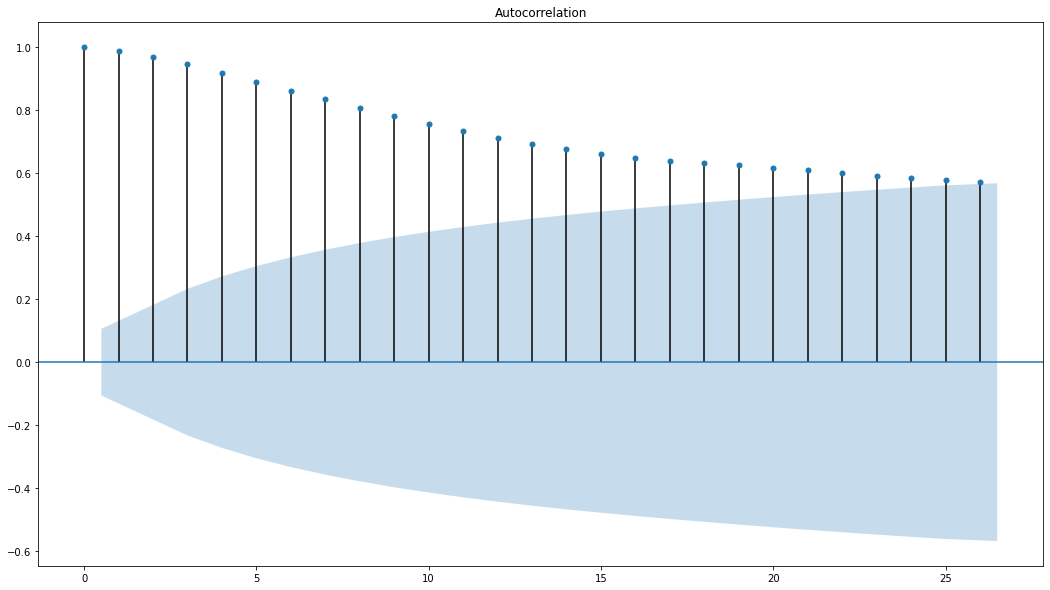

In [59]:
plot_acf(df["Coal.SA"]);

Looking at the ACF plot, since none of the lags are within the confidence interval, we can conclude that the Coal.SA series is non-stationary.

In [60]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [61]:
adf_test(df["Coal.SA"],title='')  

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.820749
p-value                   0.370210
# lags used              13.000000
# observations          329.000000
critical value (1%)      -3.450384
critical value (5%)      -2.870365
critical value (10%)     -2.571472
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [62]:
adf_test(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1), title='')     

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.133588e+00
p-value                 1.073929e-12
# lags used             2.000000e+00
# observations          3.390000e+02
critical value (1%)    -3.449788e+00
critical value (5%)    -2.870104e+00
critical value (10%)   -2.571332e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In order to make the series stationary, we are using differencing to trend effects from the original series.

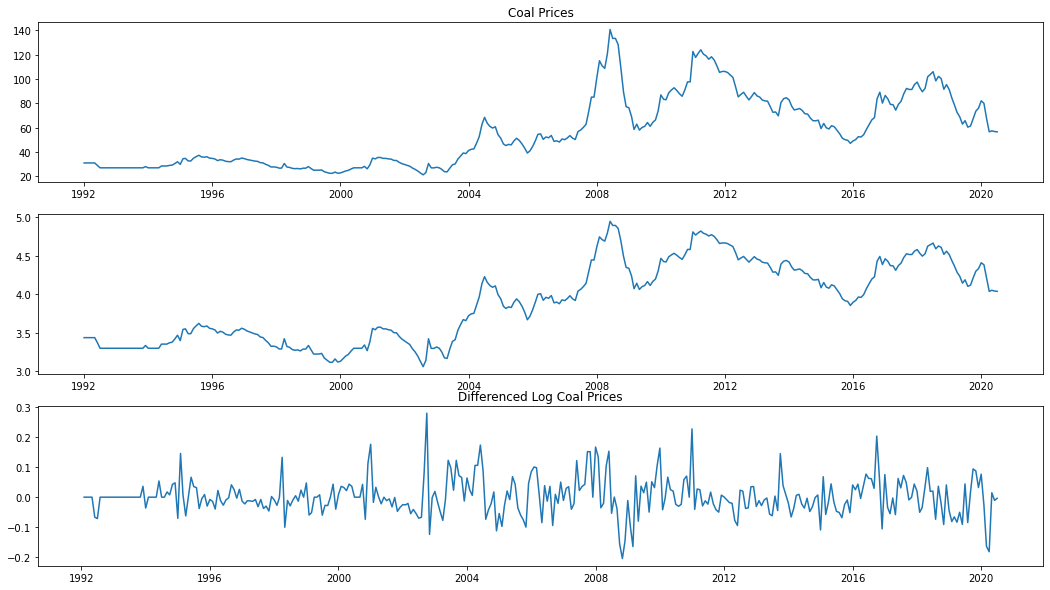

In [63]:
fig, ax = plt.subplots(3);
ax[0].plot(df["Coal.SA"]);
ax[0].set_title("Coal Prices")
ax[1].plot(np.log(df["Coal.SA"]))
ax[2].plot(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1));
ax[2].set_title("Differenced Log Coal Prices");

Looking at the time plots, the differenced series look a lot more stationary than the original series. We need to further inspect using ADF method as mentioned above.

# ARIMA

(p,d,q) is parameters of ARIMA model.

In order to choose p,d,q parameters we will use two different plots.

1) Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.

2) Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.



In [64]:
ts=df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1).dropna()
# computing the Differenced Log values to be used for plotting ACF and PACF

Now after the EDA part is done, we are only interested in certain attributes which have high correlation with the "Coal.SA". We discard away the rest of the features. Also, We would not be using "Coal.Australia" as it is trivial that the prices of one country can influence the prices of another country.

In [65]:
final_features = df[['Coal.SA','Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI']]   

**ACF-PACF Plots**

Text(0.5, 0.98, 'ACF and PCF plots for Differenced Log Time series')

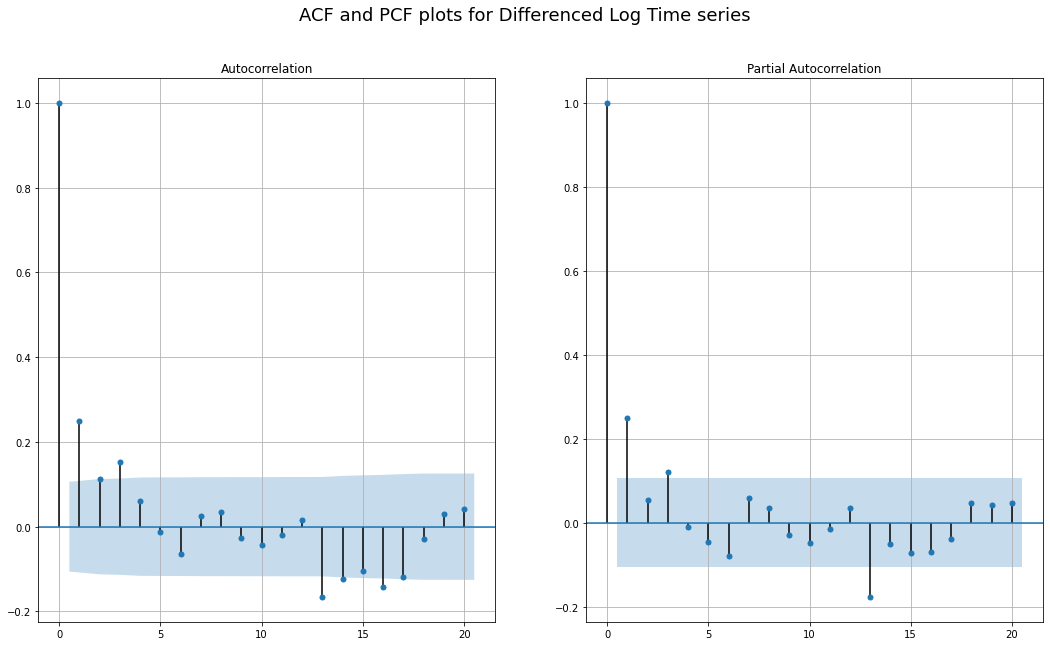

In [66]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
fig, ax = plt.subplots(1,2)
plot_acf(ts, lags=20, ax=ax[0]);
plot_pacf(ts, lags=20, ax=ax[1]);
plt.suptitle ('ACF and PCF plots for Differenced Log Time series', fontsize=18)

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

    the ACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0, d, q) model if the ACF and PACF plots of the differenced data show the following patterns:

    the PACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  q in the ACF, but none beyond lag q.

Looking at the PACF plot, we can say that there is a significant spike at lag 1 and none beyond lag 1, therefore ARIMA(1,0,0) is a strong candidate. Of course, when we use the original series (not differenced), we need to use ARIMA(1,1,0) to account for differencing.

# **1st Model**

Using the parameters (1,1,0) from above, we create a simple model. Here we will fit the model using the prices of 'Coal.SA' and p,d,q parameter values.
Later, we will forecast the values of 'Coal.SA' and evaluate the loss.

**Model Fitting**

In [67]:
from pandas import datetime
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

model = SARIMAX(df['Coal.SA'], order=(1,1,0))
model_fit = model.fit(disp=0)
results=model.fit()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


**Forecasting**

In [68]:
# FROM and TO prediction dates
start_index = datetime(2016, 1, 1)
end_index = datetime(2020, 7, 1)

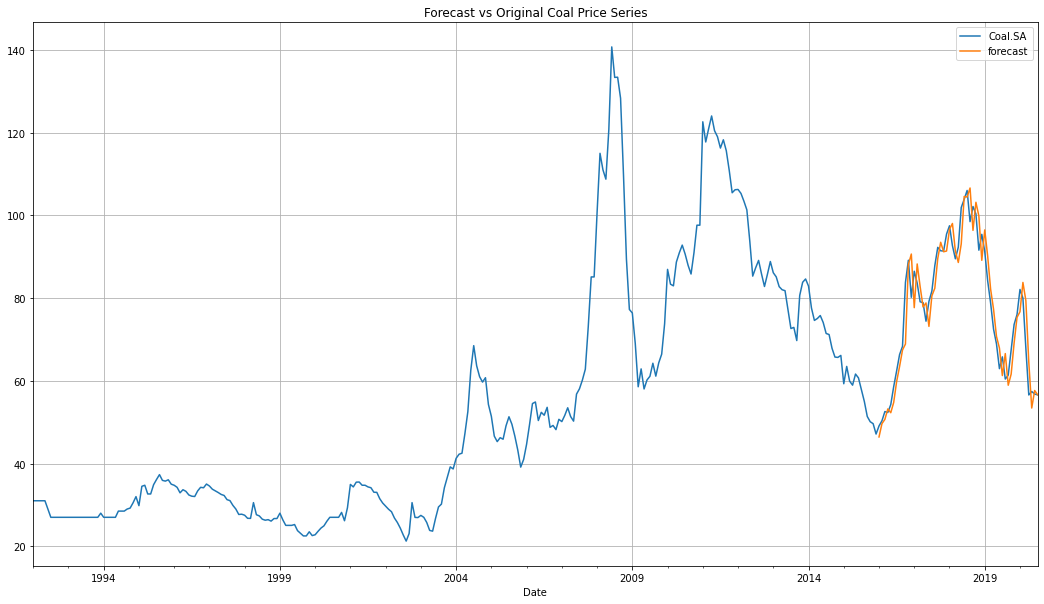

In [69]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
df['forecast']=results.predict(start=start_index, end=end_index)
df[['Coal.SA','forecast']].plot();
plt.title("Forecast vs Original Coal Price Series");

We can see from the above plot that the model fits pretty well and the forecast results are pretty decent.

Now we are interested in evaluating our model using the RMSE and R^2. In the best case scenario, RMSE should be close to 0 and R^2 should be nearly 1.

**Model Evaluation**

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

actual=df["Coal.SA"][-55:]
forecast=df["forecast"][-55:]
actual = actual.values
print("RMSE =",mean_squared_error(actual, forecast, squared = False))
print("R^2 score =", round(r2_score(actual, forecast), 2))

RMSE = 5.133194143848457
R^2 score = 0.9


The above results are also decent. But we would want to explore ways to improve our model.

This is a multivariate Time series with more than one time-dependent variable. Our target attribute, "Coal.SA" depends on its past values but also has some dependency on other variables. This dependency should also be taken into account when predicting values. 

In the first model we did not make use of other attributes to fit our model. We only used the past values of "Coal.SA" to predict it's future values. 

One thing that we can try now is, including the exogenous variables in the model. These are the variables whose value is determined outside the model and is imposed on the model. Since the other variables in our model has high correlation with "Coal.SA" therefore they can influence it's value. So we will include them to fit our model. 


# **2nd Model**

**Adding exogenous features**

In [71]:
for_exog_array = final_features
for_exog_array = for_exog_array.drop(['Coal.SA'], axis=1)
# Storing the exogenous features. Apart from our target feature all othe features with high correlation with target feature can be considered as the exogenous features. 
exog = for_exog_array.to_numpy()

**Model Fitting**

In [72]:
# include exogenous features to fit our model
model2 = SARIMAX(df['Coal.SA'], order=(1,1,0), seasonal_order=(0,0,0,13), exog=exog)
model_fit2 = model2.fit(disp=0)
results2 = model2.fit()

**Model Evaluation**

In [73]:
df['forecast2'] = results2.predict(start=start_index, end=end_index)
forecast2 = df["forecast2"][-55:]

print("RMSE =",mean_squared_error(actual, forecast2, squared = False))
print("R^2 score =", round(r2_score(actual, forecast2), 2))

RMSE = 4.642838009039509
R^2 score = 0.91


We observe that by adding the exogenous variables to our model, the RMSE score is now closer to 0 and R^2 is closer to 1

But we can still try out some options to improve the accuaracy of our model. We would want to explore some other combinations of the parameters that might improve the model.

# **SARIMAX Model- 6 Parameters**

We keep the seasonality as 0. For chosing the best set of remaining 6 parameters, we plan to try all the combinations of the 6 parameters and use each combination individually to train our SARIMAX model. Now for each SARIMAX model, we can look at the BIC/AIC scores and select the combination of parameters which gives us the least BIC/AIC score.

AIC and BIC are methods to penalize models for having more regressor variables. A penalty function is used in these methods, which is a function of the number of parameters in the model.


1.   When applying AIC, the penalty function is z(p) = 2 p.
2.   When applying BIC, the penalty function is z(p) = p ln(n), which is based on interpreting the penalty as deriving from prior information (hence the name Bayesian Information Criterion).

When n is large, the two models will produce quite different results. Then the BIC applies a much larger penalty for complex models, and hence will lead to simpler models than AIC.

Hence, we prefer low BIC scores over low AIC scores to determine the best model because AIC always has a chance of choosing too big a model, regardless of n. On the other hand, BIC has very little chance of choosing too big a model if n is sufficient.

We will test the models for different values of (p, d and q) and (seasonal_p,seasonal_d and seasonal_q) from (0, 1 and 2) and we keep the seasonal order to be 0 as from the EDA we have observed that there is no seasonality in our data. 
 

In [75]:
import itertools
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p,d,q))]
print("examples of parameter combinations or Seasonal ARIMA...")
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[4]))
print("SARIMAX: {} * {}".format(pdq[3], seasonal_pdq[5]))



examples of parameter combinations or Seasonal ARIMA...
SARIMAX: (0, 0, 1) * (0, 0, 1, 0)
SARIMAX: (0, 0, 1) * (0, 0, 2, 0)
SARIMAX: (0, 0, 2) * (0, 1, 0, 0)
SARIMAX: (0, 0, 2) * (0, 1, 1, 0)
SARIMAX: (0, 1, 0) * (0, 1, 2, 0)


We will use all the combination of parameters individually to fit our model and then calculate the BIC scores for all the models. We then display the results in the ascending order of their BIC values.

**Grid Search for best model parameters**

In [ ]:
import operator
metric_bic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
      model_test2 = SARIMAX(df['Coal.SA'], order=pm, seasonal_order=pm_seasonal, exog=exog)
      model_bic = model_test2.fit()
      metric_bic_dict.update({(pm, pm_seasonal):model_bic.bic})
    except:
      continue

sorted_bic = sorted(metric_bic_dict.items(), key=operator.itemgetter(1))
sorted_bic[:5]      

When we used the best parameters (0, 1, 0), (0, 0, 0, 0) according to the lowest BIC scores, we noticed that the R^2 remained same but the RMSE increased  by a very little margin. 
Hence, we would stay with the similar combinations that we used in the 2nd model. Additionally, these combinations have the third lowest BIC scores and almost equal to the lowest BIC score. Hence, we can say that our original guess for the parameter values was pretty accurate 

# **FINAL MODEL**

**Model Fitting**

In [74]:
final_model = SARIMAX(df['Coal.SA'], order=(1,1,0), seasonal_order=(0,0,0,0), exog=exog)
final_model_fit = final_model.fit(disp=0)
print(final_model_fit.summary())

final_results = final_model.fit()

                           Statespace Model Results                           
Dep. Variable:                Coal.SA   No. Observations:                  343
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -933.917
Date:                Mon, 07 Jun 2021   AIC                           1887.835
Time:                        16:10:59   BIC                           1926.183
Sample:                    01-01-1992   HQIC                          1903.112
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1732      0.099      1.754      0.079      -0.020       0.367
x2             0.2060      0.044      4.691      0.000       0.120       0.292
x3            -0.0015      0.025     -0.059      0.9

**Model Evaluation**

In [75]:
df['forecast_f'] = final_results.predict(start=start_index, end=end_index)
forecast_f = df["forecast_f"][-55:]

print("RMSE =",mean_squared_error(actual, forecast_f, squared = False))
print("R^2 score =", round(r2_score(actual, forecast_f), 2))

RMSE = 4.642838009039509
R^2 score = 0.91


**Forecasting**

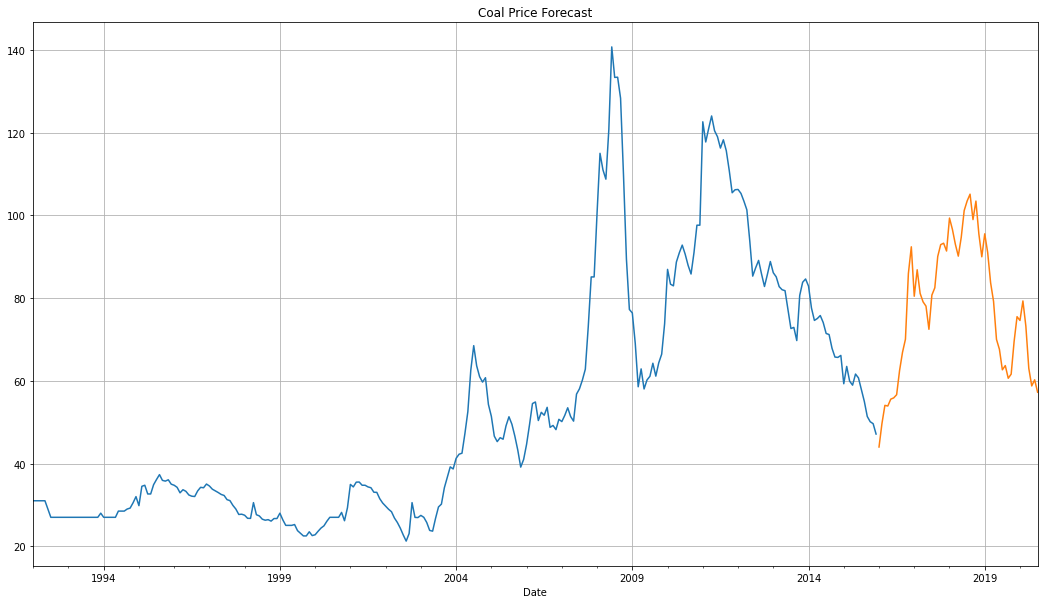

In [76]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
df["Coal.SA"][:-55].plot();
df['forecast_f'].plot();
plt.title("Coal Price Forecast");

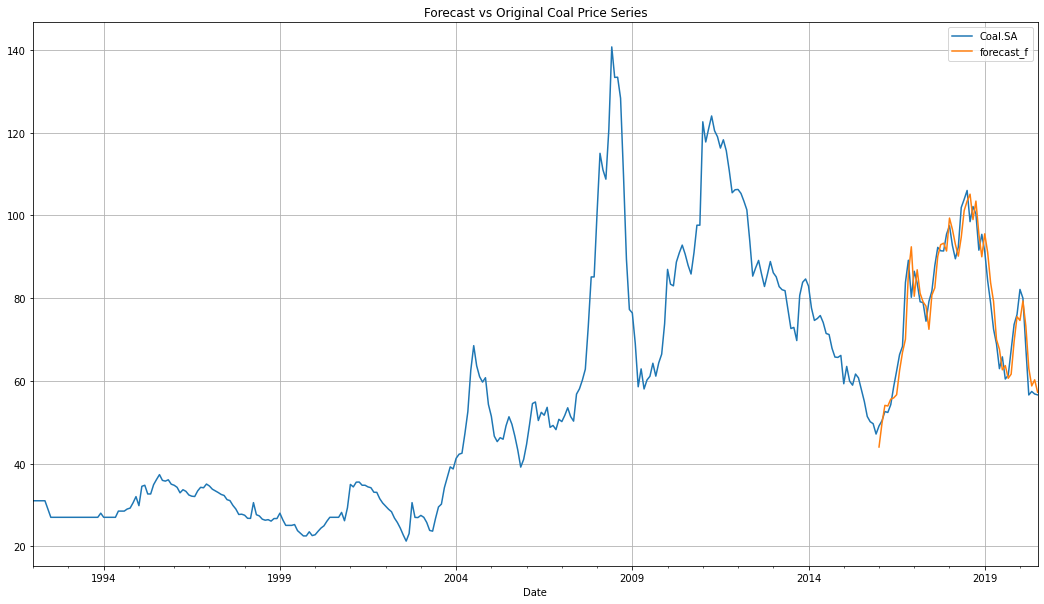

In [77]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
df[['Coal.SA','forecast_f']].plot();
plt.title("Forecast vs Original Coal Price Series");

Final Model did a pretty fine job in forecasting the prices with an impressive error rates. 

# LSTM Model

In [ ]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import layers
from keras import activations

import talos

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
# rearranging dataframe columns to have target column at the first column
df = df[['Coal.SA','Coal.Australia', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI']]

In [ ]:
df.head()

Coal.SA  Coal.Australia  ...  Commodity.Index       CCI
Date                                 ...                           
1992-01-01     31.0            39.5  ...            50.72  99.36520
1992-02-01     31.0            39.5  ...            50.72  99.46713
1992-03-01     31.0            39.5  ...            50.75  99.62660
1992-04-01     31.0            39.5  ...            51.17  99.72688
1992-05-01     31.0            39.5  ...            52.64  99.75301

[5 rows x 10 columns]

### changing the timeseries data into supervised learning data (X,y) by shifting the dataframe to have target variable at time t with all the features until time t-1

In [ ]:
#converting series to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = df.values
df.dtypes

Coal.SA                float64
Coal.Australia         float64
Fuel.Index             float64
Coal.Producer.Index    float64
IronOre                float64
CrudeOil.Index         float64
Metal.Index            float64
NonFuel.Index          float64
Commodity.Index        float64
CCI                    float64
dtype: object

In [ ]:
# scaling full data using the MinMaxScaler, since all the column values are float
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(values)

# changing data to supervised data as described above
reframed_data = series_to_supervised(data_scaled, 1,1)

In [ ]:
reframed_data.head()

var1(t-1)  var2(t-1)  var3(t-1)  ...   var8(t)   var9(t)  var10(t)
1   0.066553    0.10935   0.049397  ...  0.099537  0.050221  0.479446
2   0.066553    0.10935   0.050159  ...  0.099876  0.050409  0.512613
3   0.066553    0.10935   0.049905  ...  0.096603  0.053029  0.533470
4   0.066553    0.10935   0.059111  ...  0.097957  0.062200  0.538904
5   0.066553    0.10935   0.066032  ...  0.099876  0.063510  0.525446

[5 rows x 20 columns]

In [ ]:
#only keep data till time t; t+1, t2, ...all till the end can be dropped
reframed_data.drop(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)'], axis=1, inplace=True)

In [ ]:
# storing dataframe as array 
values = reframed_data.values

In [ ]:
training_split= int(0.8*values.shape[0])
train = values[:training_split, :]
test = values[training_split:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(273, 1, 10) (273,) (69, 1, 10) (69,)


## LSTM Training

In [ ]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(layers.Activation(activations.relu))
model.add(Dropout(0.15))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# viewing model summary
model.summary()

Epoch 1/100
4/4 - 18s - loss: 0.0441 - mae: 0.1347 - val_loss: 0.2086 - val_mae: 0.4433
Epoch 2/100
4/4 - 0s - loss: 0.0387 - mae: 0.1182 - val_loss: 0.1843 - val_mae: 0.4153
Epoch 3/100
4/4 - 0s - loss: 0.0334 - mae: 0.1036 - val_loss: 0.1594 - val_mae: 0.3846
Epoch 4/100
4/4 - 0s - loss: 0.0287 - mae: 0.0930 - val_loss: 0.1337 - val_mae: 0.3502
Epoch 5/100
4/4 - 0s - loss: 0.0244 - mae: 0.0857 - val_loss: 0.1075 - val_mae: 0.3111
Epoch 6/100
4/4 - 0s - loss: 0.0203 - mae: 0.0803 - val_loss: 0.0814 - val_mae: 0.2669
Epoch 7/100
4/4 - 0s - loss: 0.0165 - mae: 0.0773 - val_loss: 0.0566 - val_mae: 0.2170
Epoch 8/100
4/4 - 0s - loss: 0.0142 - mae: 0.0787 - val_loss: 0.0352 - val_mae: 0.1623
Epoch 9/100
4/4 - 0s - loss: 0.0127 - mae: 0.0839 - val_loss: 0.0194 - val_mae: 0.1096
Epoch 10/100
4/4 - 0s - loss: 0.0116 - mae: 0.0903 - val_loss: 0.0102 - val_mae: 0.0795
Epoch 11/100
4/4 - 0s - loss: 0.0118 - mae: 0.0962 - val_loss: 0.0069 - val_mae: 0.0718
Epoch 12/100
4/4 - 0s - loss: 0.0113 - m

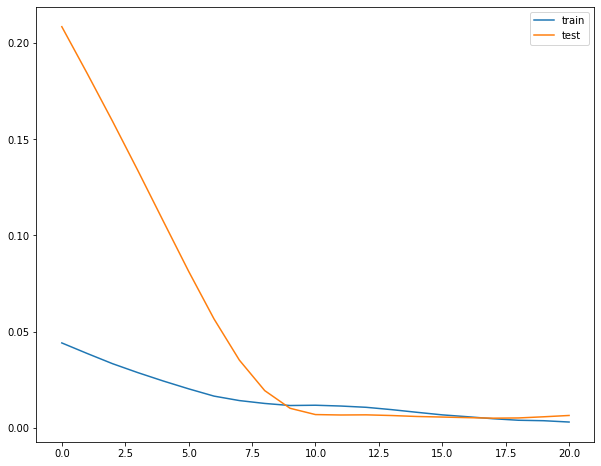

In [ ]:
# add callback
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_split=0.2, verbose=2, shuffle=False, callbacks=[es])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Making predictions on the train data

In [ ]:
# prediction on the test data
yhat = model.predict(test_X)

In [ ]:
# reversing the scaling for original and predicted values so that we can compare values normally
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecasted values
inv_yhat = np.concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual values
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Checking performance of data

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.185


In [ ]:
import sklearn.metrics as sm
print("R^2 score =", round(sm.r2_score(inv_y, inv_yhat), 2))

R^2 score = 0.26


### Plotting actual v/s predicted values for last 20% of the data selected for testing

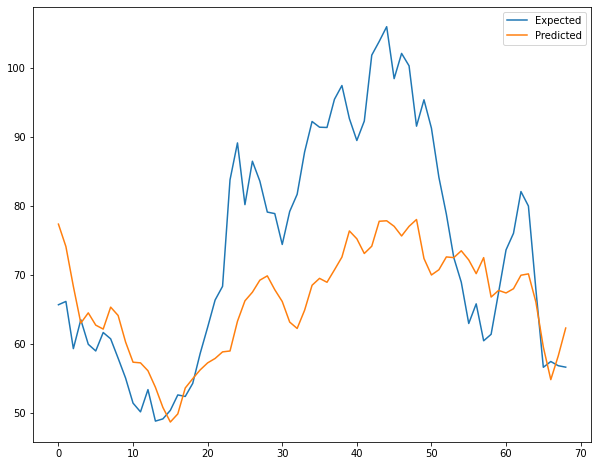

In [ ]:
plt.plot(inv_y, label='Expected')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()

## Using Talos for Hyperparameter tuning

In [ ]:
# make function to use in talos
def lstm_model(train_X, train_y, val_X, val_y, params ):
    model = Sequential()
    model.add(LSTM(params['layer1_size'], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
    model.add(layers.Activation(activations.relu))
    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['layer2_size'], return_sequences = False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=params['optimizer'], metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=2, mode='min')
    # fit network
    out = model.fit(train_X, train_y, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=2, shuffle=False, callbacks=[es])
    # plot history
    return out, model
    

#### Creating params grid for hyperparameters

In [ ]:
p = {
     'optimizer': ['AdaDelta', 'adam'],
     'layer1_size': [32, 64, 128, 256],
     'layer2_size': [64,128],
     'batch_size': [32,64],
     'dropout':[0, 0.1,0.15],
     'epochs': [50,100,150,200]}

In [ ]:
scan_object = talos.Scan(x=train_X,
                         y=train_y,
                         params=p,
                         model=lstm_model, experiment_name = 'talos1')

  0%|          | 0/384 [00:00<?, ?it/s]

Epoch 1/50
5/5 - 4s - loss: 0.0964 - mae: 0.2251 - val_loss: 0.0536 - val_mae: 0.1509
Epoch 2/50
5/5 - 0s - loss: 0.0964 - mae: 0.2250 - val_loss: 0.0536 - val_mae: 0.1508
Epoch 3/50
5/5 - 0s - loss: 0.0964 - mae: 0.2250 - val_loss: 0.0536 - val_mae: 0.1508
Epoch 4/50
5/5 - 0s - loss: 0.0964 - mae: 0.2250 - val_loss: 0.0536 - val_mae: 0.1508
Epoch 5/50
5/5 - 0s - loss: 0.0964 - mae: 0.2249 - val_loss: 0.0536 - val_mae: 0.1508
Epoch 6/50
5/5 - 0s - loss: 0.0963 - mae: 0.2249 - val_loss: 0.0536 - val_mae: 0.1507
Epoch 7/50
5/5 - 0s - loss: 0.0963 - mae: 0.2249 - val_loss: 0.0536 - val_mae: 0.1507
Epoch 8/50
5/5 - 0s - loss: 0.0963 - mae: 0.2249 - val_loss: 0.0535 - val_mae: 0.1507
Epoch 9/50
5/5 - 0s - loss: 0.0963 - mae: 0.2248 - val_loss: 0.0535 - val_mae: 0.1506
Epoch 10/50
5/5 - 0s - loss: 0.0963 - mae: 0.2248 - val_loss: 0.0535 - val_mae: 0.1506
Epoch 11/50
5/5 - 0s - loss: 0.0963 - mae: 0.2248 - val_loss: 0.0535 - val_mae: 0.1506
Epoch 12/50
5/5 - 0s - loss: 0.0962 - mae: 0.2247 - 

  0%|          | 1/384 [00:06<42:30,  6.66s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0883 - mae: 0.2145 - val_loss: 0.0439 - val_mae: 0.1292
Epoch 2/50
5/5 - 0s - loss: 0.0742 - mae: 0.1875 - val_loss: 0.0357 - val_mae: 0.1103
Epoch 3/50
5/5 - 0s - loss: 0.0605 - mae: 0.1640 - val_loss: 0.0283 - val_mae: 0.1003
Epoch 4/50
5/5 - 0s - loss: 0.0471 - mae: 0.1434 - val_loss: 0.0216 - val_mae: 0.0928
Epoch 5/50
5/5 - 0s - loss: 0.0344 - mae: 0.1268 - val_loss: 0.0164 - val_mae: 0.0896
Epoch 6/50
5/5 - 0s - loss: 0.0235 - mae: 0.1119 - val_loss: 0.0134 - val_mae: 0.0911
Epoch 7/50
5/5 - 0s - loss: 0.0162 - mae: 0.1006 - val_loss: 0.0127 - val_mae: 0.1028
Epoch 8/50
5/5 - 0s - loss: 0.0127 - mae: 0.0974 - val_loss: 0.0129 - val_mae: 0.1092
Epoch 9/50
5/5 - 0s - loss: 0.0115 - mae: 0.0965 - val_loss: 0.0118 - val_mae: 0.1046
Epoch 10/50
5/5 - 0s - loss: 0.0098 - mae: 0.0892 - val_loss: 0.0092 - val_mae: 0.0913
Epoch 11/50
5/5 - 0s - loss: 0.0075 - mae: 0.0767 - val_loss: 0.0065 - val_mae: 0.0747
Epoch 12/50
5/5 - 0s - loss: 0.0057 - mae: 0.0633 - 

  1%|          | 2/384 [00:15<46:00,  7.23s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0976 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1566
Epoch 2/50
5/5 - 0s - loss: 0.0976 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1566
Epoch 3/50
5/5 - 0s - loss: 0.0976 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1565
Epoch 4/50
5/5 - 0s - loss: 0.0976 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1565
Epoch 5/50
5/5 - 0s - loss: 0.0976 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1564
Epoch 6/50
5/5 - 0s - loss: 0.0975 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1564
Epoch 7/50
5/5 - 0s - loss: 0.0975 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1564
Epoch 8/50
5/5 - 0s - loss: 0.0975 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 9/50
5/5 - 0s - loss: 0.0975 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1563
Epoch 10/50
5/5 - 0s - loss: 0.0975 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1562
Epoch 11/50
5/5 - 0s - loss: 0.0974 - mae: 0.2294 - val_loss: 0.0548 - val_mae: 0.1562
Epoch 12/50
5/5 - 0s - loss: 0.0974 - mae: 0.2294 - 

  1%|          | 3/384 [00:21<44:54,  7.07s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0904 - mae: 0.2159 - val_loss: 0.0438 - val_mae: 0.1267
Epoch 2/50
5/5 - 0s - loss: 0.0739 - mae: 0.1848 - val_loss: 0.0343 - val_mae: 0.1082
Epoch 3/50
5/5 - 0s - loss: 0.0580 - mae: 0.1591 - val_loss: 0.0259 - val_mae: 0.0976
Epoch 4/50
5/5 - 0s - loss: 0.0426 - mae: 0.1389 - val_loss: 0.0193 - val_mae: 0.0953
Epoch 5/50
5/5 - 0s - loss: 0.0292 - mae: 0.1238 - val_loss: 0.0158 - val_mae: 0.1013
Epoch 6/50
5/5 - 0s - loss: 0.0200 - mae: 0.1135 - val_loss: 0.0159 - val_mae: 0.1158
Epoch 7/50
5/5 - 0s - loss: 0.0161 - mae: 0.1098 - val_loss: 0.0168 - val_mae: 0.1248


  1%|          | 4/384 [00:26<40:21,  6.37s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0989 - mae: 0.2332 - val_loss: 0.0559 - val_mae: 0.1604
Epoch 2/50
5/5 - 0s - loss: 0.0988 - mae: 0.2332 - val_loss: 0.0559 - val_mae: 0.1603
Epoch 3/50
5/5 - 0s - loss: 0.0988 - mae: 0.2332 - val_loss: 0.0559 - val_mae: 0.1603
Epoch 4/50
5/5 - 0s - loss: 0.0988 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1603
Epoch 5/50
5/5 - 0s - loss: 0.0988 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 6/50
5/5 - 0s - loss: 0.0988 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 7/50
5/5 - 0s - loss: 0.0988 - mae: 0.2330 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 8/50
5/5 - 0s - loss: 0.0987 - mae: 0.2330 - val_loss: 0.0558 - val_mae: 0.1601
Epoch 9/50
5/5 - 0s - loss: 0.0987 - mae: 0.2330 - val_loss: 0.0558 - val_mae: 0.1601
Epoch 10/50
5/5 - 0s - loss: 0.0987 - mae: 0.2329 - val_loss: 0.0558 - val_mae: 0.1601
Epoch 11/50
5/5 - 0s - loss: 0.0987 - mae: 0.2329 - val_loss: 0.0558 - val_mae: 0.1600
Epoch 12/50
5/5 - 0s - loss: 0.0987 - mae: 0.2329 - 

  1%|▏         | 5/384 [00:33<40:45,  6.45s/it]

Epoch 1/50
5/5 - 3s - loss: 0.0925 - mae: 0.2205 - val_loss: 0.0459 - val_mae: 0.1328
Epoch 2/50
5/5 - 0s - loss: 0.0781 - mae: 0.1928 - val_loss: 0.0373 - val_mae: 0.1118
Epoch 3/50
5/5 - 0s - loss: 0.0636 - mae: 0.1675 - val_loss: 0.0289 - val_mae: 0.1006
Epoch 4/50
5/5 - 0s - loss: 0.0483 - mae: 0.1446 - val_loss: 0.0211 - val_mae: 0.0931
Epoch 5/50
5/5 - 0s - loss: 0.0332 - mae: 0.1258 - val_loss: 0.0153 - val_mae: 0.0908
Epoch 6/50
5/5 - 0s - loss: 0.0209 - mae: 0.1102 - val_loss: 0.0134 - val_mae: 0.1022
Epoch 7/50
5/5 - 0s - loss: 0.0146 - mae: 0.1026 - val_loss: 0.0150 - val_mae: 0.1182
Epoch 8/50
5/5 - 0s - loss: 0.0137 - mae: 0.1053 - val_loss: 0.0149 - val_mae: 0.1168


  2%|▏         | 6/384 [00:37<37:10,  5.90s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0952 - mae: 0.2268 - val_loss: 0.0535 - val_mae: 0.1545
Epoch 2/50
5/5 - 0s - loss: 0.0952 - mae: 0.2268 - val_loss: 0.0535 - val_mae: 0.1544
Epoch 3/50
5/5 - 0s - loss: 0.0952 - mae: 0.2268 - val_loss: 0.0535 - val_mae: 0.1544
Epoch 4/50
5/5 - 0s - loss: 0.0952 - mae: 0.2267 - val_loss: 0.0535 - val_mae: 0.1544
Epoch 5/50
5/5 - 0s - loss: 0.0951 - mae: 0.2267 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 6/50
5/5 - 0s - loss: 0.0951 - mae: 0.2266 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 7/50
5/5 - 0s - loss: 0.0951 - mae: 0.2266 - val_loss: 0.0535 - val_mae: 0.1542
Epoch 8/50
5/5 - 0s - loss: 0.0951 - mae: 0.2265 - val_loss: 0.0534 - val_mae: 0.1542
Epoch 9/50
5/5 - 0s - loss: 0.0950 - mae: 0.2265 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 10/50
5/5 - 0s - loss: 0.0950 - mae: 0.2265 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 11/50
5/5 - 0s - loss: 0.0950 - mae: 0.2264 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 12/50
5/5 - 0s - loss: 0.0950 - mae: 0.2264 - 

  2%|▏         | 7/384 [00:44<38:38,  6.15s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0918 - mae: 0.2177 - val_loss: 0.0436 - val_mae: 0.1267
Epoch 2/50
5/5 - 0s - loss: 0.0729 - mae: 0.1834 - val_loss: 0.0328 - val_mae: 0.1060
Epoch 3/50
5/5 - 0s - loss: 0.0540 - mae: 0.1531 - val_loss: 0.0228 - val_mae: 0.0925
Epoch 4/50
5/5 - 0s - loss: 0.0355 - mae: 0.1274 - val_loss: 0.0153 - val_mae: 0.0881
Epoch 5/50
5/5 - 0s - loss: 0.0206 - mae: 0.1084 - val_loss: 0.0131 - val_mae: 0.1030
Epoch 6/50
5/5 - 0s - loss: 0.0141 - mae: 0.1024 - val_loss: 0.0155 - val_mae: 0.1199
Epoch 7/50
5/5 - 0s - loss: 0.0139 - mae: 0.1062 - val_loss: 0.0144 - val_mae: 0.1141


  2%|▏         | 8/384 [00:50<37:41,  6.01s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0997 - mae: 0.2321 - val_loss: 0.0560 - val_mae: 0.1578
Epoch 2/50
5/5 - 0s - loss: 0.0997 - mae: 0.2321 - val_loss: 0.0560 - val_mae: 0.1578
Epoch 3/50
5/5 - 0s - loss: 0.0997 - mae: 0.2320 - val_loss: 0.0560 - val_mae: 0.1578
Epoch 4/50
5/5 - 0s - loss: 0.0997 - mae: 0.2320 - val_loss: 0.0560 - val_mae: 0.1577
Epoch 5/50
5/5 - 0s - loss: 0.0996 - mae: 0.2319 - val_loss: 0.0560 - val_mae: 0.1577
Epoch 6/50
5/5 - 0s - loss: 0.0996 - mae: 0.2319 - val_loss: 0.0560 - val_mae: 0.1577
Epoch 7/50
5/5 - 0s - loss: 0.0996 - mae: 0.2318 - val_loss: 0.0560 - val_mae: 0.1576
Epoch 8/50
5/5 - 0s - loss: 0.0996 - mae: 0.2318 - val_loss: 0.0559 - val_mae: 0.1576
Epoch 9/50
5/5 - 0s - loss: 0.0995 - mae: 0.2318 - val_loss: 0.0559 - val_mae: 0.1575
Epoch 10/50
5/5 - 0s - loss: 0.0995 - mae: 0.2317 - val_loss: 0.0559 - val_mae: 0.1575
Epoch 11/50
5/5 - 0s - loss: 0.0995 - mae: 0.2317 - val_loss: 0.0559 - val_mae: 0.1575
Epoch 12/50
5/5 - 0s - loss: 0.0995 - mae: 0.2316 - 

  2%|▏         | 9/384 [00:57<39:14,  6.28s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0939 - mae: 0.2204 - val_loss: 0.0447 - val_mae: 0.1282
Epoch 2/50
5/5 - 0s - loss: 0.0753 - mae: 0.1864 - val_loss: 0.0340 - val_mae: 0.1072
Epoch 3/50
5/5 - 0s - loss: 0.0571 - mae: 0.1574 - val_loss: 0.0242 - val_mae: 0.0945
Epoch 4/50
5/5 - 0s - loss: 0.0388 - mae: 0.1337 - val_loss: 0.0166 - val_mae: 0.0915
Epoch 5/50
5/5 - 0s - loss: 0.0235 - mae: 0.1166 - val_loss: 0.0143 - val_mae: 0.1052
Epoch 6/50
5/5 - 0s - loss: 0.0159 - mae: 0.1077 - val_loss: 0.0167 - val_mae: 0.1239
Epoch 7/50
5/5 - 0s - loss: 0.0148 - mae: 0.1091 - val_loss: 0.0156 - val_mae: 0.1188


  3%|▎         | 10/384 [01:01<36:05,  5.79s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0974 - mae: 0.2296 - val_loss: 0.0548 - val_mae: 0.1563
Epoch 2/50
5/5 - 0s - loss: 0.0974 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1563
Epoch 3/50
5/5 - 0s - loss: 0.0973 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1562
Epoch 4/50
5/5 - 0s - loss: 0.0973 - mae: 0.2295 - val_loss: 0.0547 - val_mae: 0.1562
Epoch 5/50
5/5 - 0s - loss: 0.0973 - mae: 0.2294 - val_loss: 0.0547 - val_mae: 0.1562
Epoch 6/50
5/5 - 0s - loss: 0.0973 - mae: 0.2294 - val_loss: 0.0547 - val_mae: 0.1561
Epoch 7/50
5/5 - 0s - loss: 0.0972 - mae: 0.2293 - val_loss: 0.0547 - val_mae: 0.1561
Epoch 8/50
5/5 - 0s - loss: 0.0972 - mae: 0.2293 - val_loss: 0.0547 - val_mae: 0.1560
Epoch 9/50
5/5 - 0s - loss: 0.0972 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1560
Epoch 10/50
5/5 - 0s - loss: 0.0972 - mae: 0.2292 - val_loss: 0.0546 - val_mae: 0.1560
Epoch 11/50
5/5 - 0s - loss: 0.0971 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 12/50
5/5 - 0s - loss: 0.0971 - mae: 0.2291 - 

  3%|▎         | 11/384 [01:08<37:32,  6.04s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0858 - mae: 0.2081 - val_loss: 0.0374 - val_mae: 0.1126
Epoch 2/50
5/5 - 0s - loss: 0.0592 - mae: 0.1613 - val_loss: 0.0227 - val_mae: 0.0909
Epoch 3/50
5/5 - 0s - loss: 0.0335 - mae: 0.1228 - val_loss: 0.0129 - val_mae: 0.0852
Epoch 4/50
5/5 - 0s - loss: 0.0162 - mae: 0.1005 - val_loss: 0.0141 - val_mae: 0.1142
Epoch 5/50
5/5 - 0s - loss: 0.0144 - mae: 0.1083 - val_loss: 0.0163 - val_mae: 0.1191


  3%|▎         | 12/384 [01:14<36:49,  5.94s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0958 - mae: 0.2253 - val_loss: 0.0534 - val_mae: 0.1516
Epoch 2/50
5/5 - 0s - loss: 0.0958 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1516
Epoch 3/50
5/5 - 0s - loss: 0.0958 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1515
Epoch 4/50
5/5 - 0s - loss: 0.0957 - mae: 0.2251 - val_loss: 0.0534 - val_mae: 0.1515
Epoch 5/50
5/5 - 0s - loss: 0.0957 - mae: 0.2251 - val_loss: 0.0534 - val_mae: 0.1514
Epoch 6/50
5/5 - 0s - loss: 0.0957 - mae: 0.2250 - val_loss: 0.0534 - val_mae: 0.1514
Epoch 7/50
5/5 - 0s - loss: 0.0957 - mae: 0.2250 - val_loss: 0.0534 - val_mae: 0.1514
Epoch 8/50
5/5 - 0s - loss: 0.0957 - mae: 0.2250 - val_loss: 0.0533 - val_mae: 0.1513
Epoch 9/50
5/5 - 0s - loss: 0.0956 - mae: 0.2249 - val_loss: 0.0533 - val_mae: 0.1513
Epoch 10/50
5/5 - 0s - loss: 0.0956 - mae: 0.2249 - val_loss: 0.0533 - val_mae: 0.1512
Epoch 11/50
5/5 - 0s - loss: 0.0956 - mae: 0.2248 - val_loss: 0.0533 - val_mae: 0.1512
Epoch 12/50
5/5 - 0s - loss: 0.0956 - mae: 0.2248 - 

  3%|▎         | 13/384 [01:20<38:03,  6.16s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0927 - mae: 0.2185 - val_loss: 0.0406 - val_mae: 0.1201
Epoch 2/50
5/5 - 0s - loss: 0.0646 - mae: 0.1701 - val_loss: 0.0252 - val_mae: 0.0935
Epoch 3/50
5/5 - 0s - loss: 0.0378 - mae: 0.1274 - val_loss: 0.0134 - val_mae: 0.0801
Epoch 4/50
5/5 - 0s - loss: 0.0174 - mae: 0.0999 - val_loss: 0.0124 - val_mae: 0.1065
Epoch 5/50
5/5 - 0s - loss: 0.0135 - mae: 0.1037 - val_loss: 0.0161 - val_mae: 0.1175
Epoch 6/50
5/5 - 0s - loss: 0.0132 - mae: 0.1039 - val_loss: 0.0103 - val_mae: 0.0957
Epoch 7/50
5/5 - 0s - loss: 0.0078 - mae: 0.0774 - val_loss: 0.0061 - val_mae: 0.0695
Epoch 8/50
5/5 - 0s - loss: 0.0065 - mae: 0.0595 - val_loss: 0.0049 - val_mae: 0.0543
Epoch 9/50
5/5 - 0s - loss: 0.0058 - mae: 0.0512 - val_loss: 0.0039 - val_mae: 0.0475
Epoch 10/50
5/5 - 0s - loss: 0.0042 - mae: 0.0449 - val_loss: 0.0034 - val_mae: 0.0443
Epoch 11/50
5/5 - 0s - loss: 0.0035 - mae: 0.0426 - val_loss: 0.0032 - val_mae: 0.0412
Epoch 12/50
5/5 - 0s - loss: 0.0032 - mae: 0.0401 - 

  4%|▎         | 14/384 [01:27<38:59,  6.32s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0941 - mae: 0.2244 - val_loss: 0.0527 - val_mae: 0.1520
Epoch 2/50
5/5 - 0s - loss: 0.0941 - mae: 0.2244 - val_loss: 0.0527 - val_mae: 0.1520
Epoch 3/50
5/5 - 0s - loss: 0.0941 - mae: 0.2243 - val_loss: 0.0527 - val_mae: 0.1519
Epoch 4/50
5/5 - 0s - loss: 0.0940 - mae: 0.2243 - val_loss: 0.0527 - val_mae: 0.1519
Epoch 5/50
5/5 - 0s - loss: 0.0940 - mae: 0.2242 - val_loss: 0.0527 - val_mae: 0.1519
Epoch 6/50
5/5 - 0s - loss: 0.0940 - mae: 0.2242 - val_loss: 0.0527 - val_mae: 0.1518
Epoch 7/50
5/5 - 0s - loss: 0.0940 - mae: 0.2241 - val_loss: 0.0527 - val_mae: 0.1518
Epoch 8/50
5/5 - 0s - loss: 0.0940 - mae: 0.2241 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 9/50
5/5 - 0s - loss: 0.0939 - mae: 0.2241 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 10/50
5/5 - 0s - loss: 0.0939 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 11/50
5/5 - 0s - loss: 0.0939 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 12/50
5/5 - 0s - loss: 0.0939 - mae: 0.2239 - 

  4%|▍         | 15/384 [01:34<39:46,  6.47s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0828 - mae: 0.2016 - val_loss: 0.0330 - val_mae: 0.1050
Epoch 2/50
5/5 - 0s - loss: 0.0500 - mae: 0.1461 - val_loss: 0.0167 - val_mae: 0.0829
Epoch 3/50
5/5 - 0s - loss: 0.0224 - mae: 0.1071 - val_loss: 0.0118 - val_mae: 0.1014
Epoch 4/50
5/5 - 0s - loss: 0.0137 - mae: 0.1035 - val_loss: 0.0171 - val_mae: 0.1208
Epoch 5/50
5/5 - 0s - loss: 0.0141 - mae: 0.1075 - val_loss: 0.0104 - val_mae: 0.0959
Epoch 6/50
5/5 - 0s - loss: 0.0077 - mae: 0.0762 - val_loss: 0.0057 - val_mae: 0.0652
Epoch 7/50
5/5 - 0s - loss: 0.0064 - mae: 0.0568 - val_loss: 0.0046 - val_mae: 0.0492
Epoch 8/50
5/5 - 0s - loss: 0.0055 - mae: 0.0480 - val_loss: 0.0035 - val_mae: 0.0442
Epoch 9/50
5/5 - 0s - loss: 0.0038 - mae: 0.0419 - val_loss: 0.0033 - val_mae: 0.0409
Epoch 10/50
5/5 - 0s - loss: 0.0034 - mae: 0.0419 - val_loss: 0.0031 - val_mae: 0.0386
Epoch 11/50
5/5 - 0s - loss: 0.0031 - mae: 0.0391 - val_loss: 0.0030 - val_mae: 0.0383
Epoch 12/50
5/5 - 0s - loss: 0.0030 - mae: 0.0370 - 

  4%|▍         | 16/384 [01:41<40:07,  6.54s/it]

Epoch 1/100
5/5 - 4s - loss: 0.1012 - mae: 0.2342 - val_loss: 0.0568 - val_mae: 0.1594
Epoch 2/100
5/5 - 0s - loss: 0.1012 - mae: 0.2342 - val_loss: 0.0568 - val_mae: 0.1594
Epoch 3/100
5/5 - 0s - loss: 0.1012 - mae: 0.2342 - val_loss: 0.0568 - val_mae: 0.1594
Epoch 4/100
5/5 - 0s - loss: 0.1012 - mae: 0.2342 - val_loss: 0.0568 - val_mae: 0.1594
Epoch 5/100
5/5 - 0s - loss: 0.1012 - mae: 0.2341 - val_loss: 0.0568 - val_mae: 0.1593
Epoch 6/100
5/5 - 0s - loss: 0.1011 - mae: 0.2341 - val_loss: 0.0568 - val_mae: 0.1593
Epoch 7/100
5/5 - 0s - loss: 0.1011 - mae: 0.2341 - val_loss: 0.0568 - val_mae: 0.1593
Epoch 8/100
5/5 - 0s - loss: 0.1011 - mae: 0.2340 - val_loss: 0.0567 - val_mae: 0.1592
Epoch 9/100
5/5 - 0s - loss: 0.1011 - mae: 0.2340 - val_loss: 0.0567 - val_mae: 0.1592
Epoch 10/100
5/5 - 0s - loss: 0.1011 - mae: 0.2340 - val_loss: 0.0567 - val_mae: 0.1592
Epoch 11/100
5/5 - 0s - loss: 0.1011 - mae: 0.2339 - val_loss: 0.0567 - val_mae: 0.1592
Epoch 12/100
5/5 - 0s - loss: 0.1010 - ma

  4%|▍         | 17/384 [01:50<44:20,  7.25s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0950 - mae: 0.2232 - val_loss: 0.0481 - val_mae: 0.1363
Epoch 2/100
5/5 - 0s - loss: 0.0832 - mae: 0.2000 - val_loss: 0.0413 - val_mae: 0.1172
Epoch 3/100
5/5 - 0s - loss: 0.0723 - mae: 0.1797 - val_loss: 0.0353 - val_mae: 0.1098
Epoch 4/100
5/5 - 0s - loss: 0.0616 - mae: 0.1639 - val_loss: 0.0296 - val_mae: 0.1036
Epoch 5/100
5/5 - 0s - loss: 0.0509 - mae: 0.1507 - val_loss: 0.0246 - val_mae: 0.1031
Epoch 6/100
5/5 - 0s - loss: 0.0404 - mae: 0.1406 - val_loss: 0.0206 - val_mae: 0.1027
Epoch 7/100
5/5 - 0s - loss: 0.0310 - mae: 0.1305 - val_loss: 0.0183 - val_mae: 0.1083
Epoch 8/100
5/5 - 0s - loss: 0.0237 - mae: 0.1225 - val_loss: 0.0177 - val_mae: 0.1173
Epoch 9/100
5/5 - 0s - loss: 0.0192 - mae: 0.1164 - val_loss: 0.0177 - val_mae: 0.1258
Epoch 10/100
5/5 - 0s - loss: 0.0166 - mae: 0.1133 - val_loss: 0.0164 - val_mae: 0.1231
Epoch 11/100
5/5 - 0s - loss: 0.0141 - mae: 0.1057 - val_loss: 0.0132 - val_mae: 0.1107
Epoch 12/100
5/5 - 0s - loss: 0.0111 - ma

  5%|▍         | 18/384 [01:58<47:14,  7.75s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0993 - mae: 0.2314 - val_loss: 0.0559 - val_mae: 0.1573
Epoch 2/100
5/5 - 0s - loss: 0.0993 - mae: 0.2314 - val_loss: 0.0559 - val_mae: 0.1572
Epoch 3/100
5/5 - 0s - loss: 0.0993 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1572
Epoch 4/100
5/5 - 0s - loss: 0.0993 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1571
Epoch 5/100
5/5 - 0s - loss: 0.0992 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1571
Epoch 6/100
5/5 - 0s - loss: 0.0992 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1571
Epoch 7/100
5/5 - 0s - loss: 0.0992 - mae: 0.2311 - val_loss: 0.0558 - val_mae: 0.1570
Epoch 8/100
5/5 - 0s - loss: 0.0992 - mae: 0.2311 - val_loss: 0.0558 - val_mae: 0.1570
Epoch 9/100
5/5 - 0s - loss: 0.0991 - mae: 0.2310 - val_loss: 0.0558 - val_mae: 0.1569
Epoch 10/100
5/5 - 0s - loss: 0.0991 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1569
Epoch 11/100
5/5 - 0s - loss: 0.0991 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1568
Epoch 12/100
5/5 - 0s - loss: 0.0991 - ma

  5%|▍         | 19/384 [02:08<49:38,  8.16s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0901 - mae: 0.2137 - val_loss: 0.0427 - val_mae: 0.1216
Epoch 2/100
5/5 - 0s - loss: 0.0723 - mae: 0.1804 - val_loss: 0.0330 - val_mae: 0.1070
Epoch 3/100
5/5 - 0s - loss: 0.0559 - mae: 0.1566 - val_loss: 0.0252 - val_mae: 0.1021
Epoch 4/100
5/5 - 0s - loss: 0.0411 - mae: 0.1414 - val_loss: 0.0198 - val_mae: 0.1020
Epoch 5/100
5/5 - 0s - loss: 0.0289 - mae: 0.1289 - val_loss: 0.0174 - val_mae: 0.1106
Epoch 6/100
5/5 - 0s - loss: 0.0209 - mae: 0.1190 - val_loss: 0.0175 - val_mae: 0.1227
Epoch 7/100
5/5 - 0s - loss: 0.0172 - mae: 0.1146 - val_loss: 0.0172 - val_mae: 0.1258
Epoch 8/100
5/5 - 0s - loss: 0.0148 - mae: 0.1086 - val_loss: 0.0141 - val_mae: 0.1142
Epoch 9/100
5/5 - 0s - loss: 0.0115 - mae: 0.0949 - val_loss: 0.0097 - val_mae: 0.0940
Epoch 10/100
5/5 - 0s - loss: 0.0083 - mae: 0.0776 - val_loss: 0.0065 - val_mae: 0.0727
Epoch 11/100
5/5 - 0s - loss: 0.0064 - mae: 0.0620 - val_loss: 0.0047 - val_mae: 0.0565
Epoch 12/100
5/5 - 0s - loss: 0.0051 - ma

  5%|▌         | 20/384 [02:21<59:36,  9.83s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0982 - mae: 0.2313 - val_loss: 0.0553 - val_mae: 0.1578
Epoch 2/100
5/5 - 0s - loss: 0.0982 - mae: 0.2312 - val_loss: 0.0553 - val_mae: 0.1578
Epoch 3/100
5/5 - 0s - loss: 0.0982 - mae: 0.2312 - val_loss: 0.0552 - val_mae: 0.1578
Epoch 4/100
5/5 - 0s - loss: 0.0982 - mae: 0.2312 - val_loss: 0.0552 - val_mae: 0.1577
Epoch 5/100
5/5 - 0s - loss: 0.0981 - mae: 0.2311 - val_loss: 0.0552 - val_mae: 0.1577
Epoch 6/100
5/5 - 0s - loss: 0.0981 - mae: 0.2311 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 7/100
5/5 - 0s - loss: 0.0981 - mae: 0.2310 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 8/100
5/5 - 0s - loss: 0.0981 - mae: 0.2310 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 9/100
5/5 - 0s - loss: 0.0980 - mae: 0.2310 - val_loss: 0.0552 - val_mae: 0.1575
Epoch 10/100
5/5 - 0s - loss: 0.0980 - mae: 0.2309 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 11/100
5/5 - 0s - loss: 0.0980 - mae: 0.2309 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 12/100
5/5 - 0s - loss: 0.0980 - ma

  5%|▌         | 21/384 [02:30<58:08,  9.61s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0898 - mae: 0.2155 - val_loss: 0.0441 - val_mae: 0.1285
Epoch 2/100
5/5 - 0s - loss: 0.0751 - mae: 0.1877 - val_loss: 0.0353 - val_mae: 0.1090
Epoch 3/100
5/5 - 0s - loss: 0.0600 - mae: 0.1625 - val_loss: 0.0269 - val_mae: 0.0978
Epoch 4/100
5/5 - 0s - loss: 0.0444 - mae: 0.1398 - val_loss: 0.0193 - val_mae: 0.0913
Epoch 5/100
5/5 - 0s - loss: 0.0298 - mae: 0.1211 - val_loss: 0.0141 - val_mae: 0.0901
Epoch 6/100
5/5 - 0s - loss: 0.0186 - mae: 0.1062 - val_loss: 0.0128 - val_mae: 0.1020
Epoch 7/100
5/5 - 0s - loss: 0.0134 - mae: 0.0993 - val_loss: 0.0141 - val_mae: 0.1146
Epoch 8/100
5/5 - 0s - loss: 0.0126 - mae: 0.1006 - val_loss: 0.0133 - val_mae: 0.1105


  6%|▌         | 22/384 [02:35<49:11,  8.15s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0979 - mae: 0.2294 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 2/100
5/5 - 0s - loss: 0.0979 - mae: 0.2294 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 3/100
5/5 - 0s - loss: 0.0979 - mae: 0.2293 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 4/100
5/5 - 0s - loss: 0.0979 - mae: 0.2293 - val_loss: 0.0548 - val_mae: 0.1555
Epoch 5/100
5/5 - 0s - loss: 0.0978 - mae: 0.2293 - val_loss: 0.0548 - val_mae: 0.1555
Epoch 6/100
5/5 - 0s - loss: 0.0978 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 7/100
5/5 - 0s - loss: 0.0978 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 8/100
5/5 - 0s - loss: 0.0978 - mae: 0.2291 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 9/100
5/5 - 0s - loss: 0.0978 - mae: 0.2291 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 10/100
5/5 - 0s - loss: 0.0977 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 11/100
5/5 - 0s - loss: 0.0977 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1552
Epoch 12/100
5/5 - 0s - loss: 0.0977 - ma

  6%|▌         | 23/384 [02:44<50:51,  8.45s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0897 - mae: 0.2149 - val_loss: 0.0422 - val_mae: 0.1231
Epoch 2/100
5/5 - 0s - loss: 0.0705 - mae: 0.1788 - val_loss: 0.0315 - val_mae: 0.1039
Epoch 3/100
5/5 - 0s - loss: 0.0522 - mae: 0.1501 - val_loss: 0.0224 - val_mae: 0.0946
Epoch 4/100
5/5 - 0s - loss: 0.0352 - mae: 0.1296 - val_loss: 0.0163 - val_mae: 0.0941
Epoch 5/100
5/5 - 0s - loss: 0.0222 - mae: 0.1148 - val_loss: 0.0149 - val_mae: 0.1085
Epoch 6/100
5/5 - 0s - loss: 0.0160 - mae: 0.1086 - val_loss: 0.0167 - val_mae: 0.1245
Epoch 7/100
5/5 - 0s - loss: 0.0149 - mae: 0.1102 - val_loss: 0.0156 - val_mae: 0.1198


  6%|▋         | 24/384 [02:50<45:50,  7.64s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0966 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1540
Epoch 2/100
5/5 - 0s - loss: 0.0966 - mae: 0.2274 - val_loss: 0.0540 - val_mae: 0.1540
Epoch 3/100
5/5 - 0s - loss: 0.0966 - mae: 0.2274 - val_loss: 0.0540 - val_mae: 0.1539
Epoch 4/100
5/5 - 0s - loss: 0.0965 - mae: 0.2273 - val_loss: 0.0540 - val_mae: 0.1539
Epoch 5/100
5/5 - 0s - loss: 0.0965 - mae: 0.2273 - val_loss: 0.0540 - val_mae: 0.1539
Epoch 6/100
5/5 - 0s - loss: 0.0965 - mae: 0.2272 - val_loss: 0.0540 - val_mae: 0.1538
Epoch 7/100
5/5 - 0s - loss: 0.0965 - mae: 0.2272 - val_loss: 0.0540 - val_mae: 0.1538
Epoch 8/100
5/5 - 0s - loss: 0.0964 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1537
Epoch 9/100
5/5 - 0s - loss: 0.0964 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1537
Epoch 10/100
5/5 - 0s - loss: 0.0964 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1536
Epoch 11/100
5/5 - 0s - loss: 0.0964 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1536
Epoch 12/100
5/5 - 0s - loss: 0.0963 - ma

  7%|▋         | 25/384 [03:04<56:38,  9.47s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0919 - mae: 0.2182 - val_loss: 0.0432 - val_mae: 0.1262
Epoch 2/100
5/5 - 0s - loss: 0.0717 - mae: 0.1816 - val_loss: 0.0316 - val_mae: 0.1041
Epoch 3/100
5/5 - 0s - loss: 0.0515 - mae: 0.1490 - val_loss: 0.0209 - val_mae: 0.0903
Epoch 4/100
5/5 - 0s - loss: 0.0317 - mae: 0.1218 - val_loss: 0.0137 - val_mae: 0.0881
Epoch 5/100
5/5 - 0s - loss: 0.0174 - mae: 0.1034 - val_loss: 0.0136 - val_mae: 0.1111
Epoch 6/100
5/5 - 0s - loss: 0.0138 - mae: 0.1047 - val_loss: 0.0158 - val_mae: 0.1195
Epoch 7/100
5/5 - 0s - loss: 0.0133 - mae: 0.1037 - val_loss: 0.0119 - val_mae: 0.1039
Epoch 8/100
5/5 - 0s - loss: 0.0093 - mae: 0.0856 - val_loss: 0.0075 - val_mae: 0.0811
Epoch 9/100
5/5 - 0s - loss: 0.0070 - mae: 0.0681 - val_loss: 0.0057 - val_mae: 0.0633
Epoch 10/100
5/5 - 0s - loss: 0.0062 - mae: 0.0572 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 11/100
5/5 - 0s - loss: 0.0050 - mae: 0.0501 - val_loss: 0.0038 - val_mae: 0.0482
Epoch 12/100
5/5 - 0s - loss: 0.0040 - ma

  7%|▋         | 26/384 [03:13<56:01,  9.39s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0967 - mae: 0.2276 - val_loss: 0.0542 - val_mae: 0.1542
Epoch 2/100
5/5 - 0s - loss: 0.0966 - mae: 0.2275 - val_loss: 0.0542 - val_mae: 0.1542
Epoch 3/100
5/5 - 0s - loss: 0.0966 - mae: 0.2275 - val_loss: 0.0542 - val_mae: 0.1542
Epoch 4/100
5/5 - 0s - loss: 0.0966 - mae: 0.2274 - val_loss: 0.0542 - val_mae: 0.1541
Epoch 5/100
5/5 - 0s - loss: 0.0966 - mae: 0.2274 - val_loss: 0.0542 - val_mae: 0.1541
Epoch 6/100
5/5 - 0s - loss: 0.0966 - mae: 0.2273 - val_loss: 0.0542 - val_mae: 0.1540
Epoch 7/100
5/5 - 0s - loss: 0.0965 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1540
Epoch 8/100
5/5 - 0s - loss: 0.0965 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1540
Epoch 9/100
5/5 - 0s - loss: 0.0965 - mae: 0.2272 - val_loss: 0.0541 - val_mae: 0.1539
Epoch 10/100
5/5 - 0s - loss: 0.0965 - mae: 0.2272 - val_loss: 0.0541 - val_mae: 0.1539
Epoch 11/100
5/5 - 0s - loss: 0.0964 - mae: 0.2271 - val_loss: 0.0541 - val_mae: 0.1538
Epoch 12/100
5/5 - 0s - loss: 0.0964 - ma

  7%|▋         | 27/384 [03:23<56:31,  9.50s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0860 - mae: 0.2084 - val_loss: 0.0382 - val_mae: 0.1140
Epoch 2/100
5/5 - 0s - loss: 0.0618 - mae: 0.1647 - val_loss: 0.0250 - val_mae: 0.0936
Epoch 3/100
5/5 - 0s - loss: 0.0390 - mae: 0.1299 - val_loss: 0.0155 - val_mae: 0.0862
Epoch 4/100
5/5 - 0s - loss: 0.0213 - mae: 0.1094 - val_loss: 0.0143 - val_mae: 0.1107
Epoch 5/100
5/5 - 0s - loss: 0.0157 - mae: 0.1100 - val_loss: 0.0179 - val_mae: 0.1275
Epoch 6/100
5/5 - 0s - loss: 0.0155 - mae: 0.1122 - val_loss: 0.0140 - val_mae: 0.1127
Epoch 7/100
5/5 - 0s - loss: 0.0109 - mae: 0.0928 - val_loss: 0.0084 - val_mae: 0.0856
Epoch 8/100
5/5 - 0s - loss: 0.0079 - mae: 0.0713 - val_loss: 0.0059 - val_mae: 0.0628
Epoch 9/100
5/5 - 0s - loss: 0.0067 - mae: 0.0572 - val_loss: 0.0045 - val_mae: 0.0505
Epoch 10/100
5/5 - 0s - loss: 0.0051 - mae: 0.0482 - val_loss: 0.0037 - val_mae: 0.0456
Epoch 11/100
5/5 - 0s - loss: 0.0040 - mae: 0.0439 - val_loss: 0.0035 - val_mae: 0.0418
Epoch 12/100
5/5 - 0s - loss: 0.0036 - ma

  7%|▋         | 28/384 [03:32<56:05,  9.45s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0966 - mae: 0.2272 - val_loss: 0.0540 - val_mae: 0.1536
Epoch 2/100
5/5 - 0s - loss: 0.0966 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1536
Epoch 3/100
5/5 - 0s - loss: 0.0965 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1536
Epoch 4/100
5/5 - 0s - loss: 0.0965 - mae: 0.2270 - val_loss: 0.0540 - val_mae: 0.1535
Epoch 5/100
5/5 - 0s - loss: 0.0965 - mae: 0.2270 - val_loss: 0.0540 - val_mae: 0.1535
Epoch 6/100
5/5 - 0s - loss: 0.0965 - mae: 0.2270 - val_loss: 0.0540 - val_mae: 0.1534
Epoch 7/100
5/5 - 0s - loss: 0.0964 - mae: 0.2269 - val_loss: 0.0539 - val_mae: 0.1534
Epoch 8/100
5/5 - 0s - loss: 0.0964 - mae: 0.2269 - val_loss: 0.0539 - val_mae: 0.1534
Epoch 9/100
5/5 - 0s - loss: 0.0964 - mae: 0.2268 - val_loss: 0.0539 - val_mae: 0.1533
Epoch 10/100
5/5 - 0s - loss: 0.0964 - mae: 0.2268 - val_loss: 0.0539 - val_mae: 0.1533
Epoch 11/100
5/5 - 0s - loss: 0.0963 - mae: 0.2267 - val_loss: 0.0539 - val_mae: 0.1532
Epoch 12/100
5/5 - 0s - loss: 0.0963 - ma

  8%|▊         | 29/384 [03:42<56:04,  9.48s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0877 - mae: 0.2110 - val_loss: 0.0378 - val_mae: 0.1144
Epoch 2/100
5/5 - 0s - loss: 0.0594 - mae: 0.1621 - val_loss: 0.0223 - val_mae: 0.0888
Epoch 3/100
5/5 - 0s - loss: 0.0324 - mae: 0.1191 - val_loss: 0.0117 - val_mae: 0.0801
Epoch 4/100
5/5 - 0s - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0134 - val_mae: 0.1112
Epoch 5/100
5/5 - 0s - loss: 0.0138 - mae: 0.1055 - val_loss: 0.0151 - val_mae: 0.1131


  8%|▊         | 30/384 [03:46<47:32,  8.06s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0968 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1546
Epoch 2/100
5/5 - 0s - loss: 0.0968 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1546
Epoch 3/100
5/5 - 0s - loss: 0.0967 - mae: 0.2279 - val_loss: 0.0542 - val_mae: 0.1545
Epoch 4/100
5/5 - 0s - loss: 0.0967 - mae: 0.2279 - val_loss: 0.0542 - val_mae: 0.1545
Epoch 5/100
5/5 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 6/100
5/5 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 7/100
5/5 - 0s - loss: 0.0966 - mae: 0.2277 - val_loss: 0.0541 - val_mae: 0.1543
Epoch 8/100
5/5 - 0s - loss: 0.0966 - mae: 0.2277 - val_loss: 0.0541 - val_mae: 0.1543
Epoch 9/100
5/5 - 0s - loss: 0.0966 - mae: 0.2276 - val_loss: 0.0541 - val_mae: 0.1543
Epoch 10/100
5/5 - 0s - loss: 0.0965 - mae: 0.2276 - val_loss: 0.0541 - val_mae: 0.1542
Epoch 11/100
5/5 - 0s - loss: 0.0965 - mae: 0.2275 - val_loss: 0.0541 - val_mae: 0.1542
Epoch 12/100
5/5 - 0s - loss: 0.0965 - ma

  8%|▊         | 31/384 [03:56<49:43,  8.45s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0850 - mae: 0.2057 - val_loss: 0.0348 - val_mae: 0.1080
Epoch 2/100
5/5 - 0s - loss: 0.0530 - mae: 0.1510 - val_loss: 0.0179 - val_mae: 0.0843
Epoch 3/100
5/5 - 0s - loss: 0.0240 - mae: 0.1094 - val_loss: 0.0116 - val_mae: 0.0989
Epoch 4/100
5/5 - 0s - loss: 0.0138 - mae: 0.1032 - val_loss: 0.0176 - val_mae: 0.1231
Epoch 5/100
5/5 - 0s - loss: 0.0148 - mae: 0.1109 - val_loss: 0.0111 - val_mae: 0.0990
Epoch 6/100
5/5 - 0s - loss: 0.0080 - mae: 0.0782 - val_loss: 0.0059 - val_mae: 0.0673
Epoch 7/100
5/5 - 0s - loss: 0.0065 - mae: 0.0579 - val_loss: 0.0047 - val_mae: 0.0499
Epoch 8/100
5/5 - 0s - loss: 0.0055 - mae: 0.0487 - val_loss: 0.0034 - val_mae: 0.0442
Epoch 9/100
5/5 - 0s - loss: 0.0036 - mae: 0.0415 - val_loss: 0.0031 - val_mae: 0.0408
Epoch 10/100
5/5 - 0s - loss: 0.0033 - mae: 0.0415 - val_loss: 0.0030 - val_mae: 0.0378
Epoch 11/100
5/5 - 0s - loss: 0.0029 - mae: 0.0383 - val_loss: 0.0030 - val_mae: 0.0379
Epoch 12/100
5/5 - 0s - loss: 0.0029 - ma

  8%|▊         | 32/384 [04:05<51:22,  8.76s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0966 - mae: 0.2270 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 2/150
5/5 - 0s - loss: 0.0966 - mae: 0.2269 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 3/150
5/5 - 0s - loss: 0.0966 - mae: 0.2269 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 4/150
5/5 - 0s - loss: 0.0966 - mae: 0.2269 - val_loss: 0.0542 - val_mae: 0.1533
Epoch 5/150
5/5 - 0s - loss: 0.0966 - mae: 0.2268 - val_loss: 0.0541 - val_mae: 0.1533
Epoch 6/150
5/5 - 0s - loss: 0.0965 - mae: 0.2268 - val_loss: 0.0541 - val_mae: 0.1533
Epoch 7/150
5/5 - 0s - loss: 0.0965 - mae: 0.2268 - val_loss: 0.0541 - val_mae: 0.1532
Epoch 8/150
5/5 - 0s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0541 - val_mae: 0.1532
Epoch 9/150
5/5 - 0s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0541 - val_mae: 0.1532
Epoch 10/150
5/5 - 0s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0541 - val_mae: 0.1531
Epoch 11/150
5/5 - 0s - loss: 0.0965 - mae: 0.2266 - val_loss: 0.0541 - val_mae: 0.1531
Epoch 12/150
5/5 - 0s - loss: 0.0964 - ma

  9%|▊         | 33/384 [04:19<59:59, 10.25s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0906 - mae: 0.2164 - val_loss: 0.0459 - val_mae: 0.1316
Epoch 2/150
5/5 - 0s - loss: 0.0794 - mae: 0.1939 - val_loss: 0.0391 - val_mae: 0.1142
Epoch 3/150
5/5 - 0s - loss: 0.0681 - mae: 0.1737 - val_loss: 0.0326 - val_mae: 0.1060
Epoch 4/150
5/5 - 0s - loss: 0.0566 - mae: 0.1568 - val_loss: 0.0266 - val_mae: 0.1011
Epoch 5/150
5/5 - 0s - loss: 0.0451 - mae: 0.1445 - val_loss: 0.0217 - val_mae: 0.1009
Epoch 6/150
5/5 - 0s - loss: 0.0343 - mae: 0.1332 - val_loss: 0.0183 - val_mae: 0.1040
Epoch 7/150
5/5 - 0s - loss: 0.0255 - mae: 0.1242 - val_loss: 0.0171 - val_mae: 0.1124
Epoch 8/150
5/5 - 0s - loss: 0.0197 - mae: 0.1165 - val_loss: 0.0175 - val_mae: 0.1233
Epoch 9/150
5/5 - 0s - loss: 0.0168 - mae: 0.1133 - val_loss: 0.0173 - val_mae: 0.1261


  9%|▉         | 34/384 [04:24<50:17,  8.62s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 2/150
5/5 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 3/150
5/5 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 4/150
5/5 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0545 - val_mae: 0.1556
Epoch 5/150
5/5 - 0s - loss: 0.0971 - mae: 0.2289 - val_loss: 0.0545 - val_mae: 0.1555
Epoch 6/150
5/5 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0545 - val_mae: 0.1555
Epoch 7/150
5/5 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0545 - val_mae: 0.1554
Epoch 8/150
5/5 - 0s - loss: 0.0971 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1554
Epoch 9/150
5/5 - 0s - loss: 0.0970 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1553
Epoch 10/150
5/5 - 0s - loss: 0.0970 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 11/150
5/5 - 0s - loss: 0.0970 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 12/150
5/5 - 0s - loss: 0.0970 - ma

  9%|▉         | 35/384 [04:36<55:44,  9.58s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0929 - mae: 0.2195 - val_loss: 0.0453 - val_mae: 0.1296
Epoch 2/150
5/5 - 0s - loss: 0.0769 - mae: 0.1891 - val_loss: 0.0362 - val_mae: 0.1110
Epoch 3/150
5/5 - 0s - loss: 0.0616 - mae: 0.1645 - val_loss: 0.0279 - val_mae: 0.1012
Epoch 4/150
5/5 - 0s - loss: 0.0466 - mae: 0.1451 - val_loss: 0.0212 - val_mae: 0.0993
Epoch 5/150
5/5 - 0s - loss: 0.0329 - mae: 0.1309 - val_loss: 0.0173 - val_mae: 0.1033
Epoch 6/150
5/5 - 0s - loss: 0.0229 - mae: 0.1209 - val_loss: 0.0169 - val_mae: 0.1158
Epoch 7/150
5/5 - 0s - loss: 0.0180 - mae: 0.1148 - val_loss: 0.0184 - val_mae: 0.1292
Epoch 8/150
5/5 - 0s - loss: 0.0163 - mae: 0.1136 - val_loss: 0.0173 - val_mae: 0.1263


  9%|▉         | 36/384 [04:41<48:55,  8.44s/it]

Epoch 1/150
5/5 - 4s - loss: 0.1010 - mae: 0.2360 - val_loss: 0.0571 - val_mae: 0.1621
Epoch 2/150
5/5 - 0s - loss: 0.1010 - mae: 0.2360 - val_loss: 0.0571 - val_mae: 0.1621
Epoch 3/150
5/5 - 0s - loss: 0.1010 - mae: 0.2360 - val_loss: 0.0571 - val_mae: 0.1621
Epoch 4/150
5/5 - 0s - loss: 0.1010 - mae: 0.2359 - val_loss: 0.0570 - val_mae: 0.1620
Epoch 5/150
5/5 - 0s - loss: 0.1010 - mae: 0.2359 - val_loss: 0.0570 - val_mae: 0.1620
Epoch 6/150
5/5 - 0s - loss: 0.1009 - mae: 0.2358 - val_loss: 0.0570 - val_mae: 0.1619
Epoch 7/150
5/5 - 0s - loss: 0.1009 - mae: 0.2358 - val_loss: 0.0570 - val_mae: 0.1619
Epoch 8/150
5/5 - 0s - loss: 0.1009 - mae: 0.2358 - val_loss: 0.0570 - val_mae: 0.1619
Epoch 9/150
5/5 - 0s - loss: 0.1009 - mae: 0.2357 - val_loss: 0.0570 - val_mae: 0.1618
Epoch 10/150
5/5 - 0s - loss: 0.1008 - mae: 0.2357 - val_loss: 0.0570 - val_mae: 0.1618
Epoch 11/150
5/5 - 0s - loss: 0.1008 - mae: 0.2356 - val_loss: 0.0569 - val_mae: 0.1617
Epoch 12/150
5/5 - 0s - loss: 0.1008 - ma

 10%|▉         | 37/384 [04:53<54:20,  9.40s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0911 - mae: 0.2166 - val_loss: 0.0439 - val_mae: 0.1273
Epoch 2/150
5/5 - 0s - loss: 0.0739 - mae: 0.1848 - val_loss: 0.0343 - val_mae: 0.1071
Epoch 3/150
5/5 - 0s - loss: 0.0577 - mae: 0.1579 - val_loss: 0.0257 - val_mae: 0.0954
Epoch 4/150
5/5 - 0s - loss: 0.0420 - mae: 0.1352 - val_loss: 0.0186 - val_mae: 0.0903
Epoch 5/150
5/5 - 0s - loss: 0.0280 - mae: 0.1176 - val_loss: 0.0145 - val_mae: 0.0925
Epoch 6/150
5/5 - 0s - loss: 0.0183 - mae: 0.1059 - val_loss: 0.0145 - val_mae: 0.1118
Epoch 7/150
5/5 - 0s - loss: 0.0149 - mae: 0.1070 - val_loss: 0.0159 - val_mae: 0.1211


 10%|▉         | 38/384 [04:58<46:02,  7.98s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0976 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1567
Epoch 2/150
5/5 - 0s - loss: 0.0975 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 3/150
5/5 - 0s - loss: 0.0975 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 4/150
5/5 - 0s - loss: 0.0975 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 5/150
5/5 - 0s - loss: 0.0975 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1565
Epoch 6/150
5/5 - 0s - loss: 0.0975 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1565
Epoch 7/150
5/5 - 0s - loss: 0.0974 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1564
Epoch 8/150
5/5 - 0s - loss: 0.0974 - mae: 0.2296 - val_loss: 0.0547 - val_mae: 0.1564
Epoch 9/150
5/5 - 0s - loss: 0.0974 - mae: 0.2296 - val_loss: 0.0547 - val_mae: 0.1564
Epoch 10/150
5/5 - 0s - loss: 0.0974 - mae: 0.2295 - val_loss: 0.0547 - val_mae: 0.1563
Epoch 11/150
5/5 - 0s - loss: 0.0973 - mae: 0.2295 - val_loss: 0.0547 - val_mae: 0.1563
Epoch 12/150
5/5 - 0s - loss: 0.0973 - ma

 10%|█         | 39/384 [05:10<52:46,  9.18s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0901 - mae: 0.2144 - val_loss: 0.0430 - val_mae: 0.1234
Epoch 2/150
5/5 - 0s - loss: 0.0728 - mae: 0.1816 - val_loss: 0.0329 - val_mae: 0.1064
Epoch 3/150
5/5 - 0s - loss: 0.0551 - mae: 0.1549 - val_loss: 0.0237 - val_mae: 0.0990
Epoch 4/150
5/5 - 0s - loss: 0.0376 - mae: 0.1357 - val_loss: 0.0176 - val_mae: 0.1003
Epoch 5/150
5/5 - 0s - loss: 0.0239 - mae: 0.1217 - val_loss: 0.0168 - val_mae: 0.1173
Epoch 6/150
5/5 - 0s - loss: 0.0178 - mae: 0.1159 - val_loss: 0.0189 - val_mae: 0.1323
Epoch 7/150
5/5 - 0s - loss: 0.0163 - mae: 0.1147 - val_loss: 0.0163 - val_mae: 0.1226
Epoch 8/150
5/5 - 0s - loss: 0.0124 - mae: 0.1000 - val_loss: 0.0104 - val_mae: 0.0981
Epoch 9/150
5/5 - 0s - loss: 0.0083 - mae: 0.0784 - val_loss: 0.0065 - val_mae: 0.0728
Epoch 10/150
5/5 - 0s - loss: 0.0062 - mae: 0.0610 - val_loss: 0.0045 - val_mae: 0.0548
Epoch 11/150
5/5 - 0s - loss: 0.0047 - mae: 0.0488 - val_loss: 0.0034 - val_mae: 0.0457
Epoch 12/150
5/5 - 0s - loss: 0.0034 - ma

 10%|█         | 40/384 [05:22<57:45, 10.08s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0998 - mae: 0.2315 - val_loss: 0.0559 - val_mae: 0.1569
Epoch 2/150
5/5 - 0s - loss: 0.0998 - mae: 0.2315 - val_loss: 0.0559 - val_mae: 0.1569
Epoch 3/150
5/5 - 0s - loss: 0.0998 - mae: 0.2315 - val_loss: 0.0559 - val_mae: 0.1568
Epoch 4/150
5/5 - 0s - loss: 0.0997 - mae: 0.2314 - val_loss: 0.0559 - val_mae: 0.1568
Epoch 5/150
5/5 - 0s - loss: 0.0997 - mae: 0.2314 - val_loss: 0.0559 - val_mae: 0.1568
Epoch 6/150
5/5 - 0s - loss: 0.0997 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 7/150
5/5 - 0s - loss: 0.0997 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 8/150
5/5 - 0s - loss: 0.0996 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 9/150
5/5 - 0s - loss: 0.0996 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1566
Epoch 10/150
5/5 - 0s - loss: 0.0996 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1566
Epoch 11/150
5/5 - 0s - loss: 0.0996 - mae: 0.2311 - val_loss: 0.0558 - val_mae: 0.1566
Epoch 12/150
5/5 - 0s - loss: 0.0996 - ma

 11%|█         | 41/384 [05:34<1:00:55, 10.66s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0930 - mae: 0.2199 - val_loss: 0.0434 - val_mae: 0.1267
Epoch 2/150
5/5 - 0s - loss: 0.0716 - mae: 0.1815 - val_loss: 0.0312 - val_mae: 0.1036
Epoch 3/150
5/5 - 0s - loss: 0.0503 - mae: 0.1471 - val_loss: 0.0201 - val_mae: 0.0890
Epoch 4/150
5/5 - 0s - loss: 0.0300 - mae: 0.1183 - val_loss: 0.0130 - val_mae: 0.0872
Epoch 5/150
5/5 - 0s - loss: 0.0163 - mae: 0.1005 - val_loss: 0.0137 - val_mae: 0.1123
Epoch 6/150
5/5 - 0s - loss: 0.0138 - mae: 0.1053 - val_loss: 0.0155 - val_mae: 0.1176


 11%|█         | 42/384 [05:40<52:21,  9.19s/it]  

Epoch 1/150
5/5 - 4s - loss: 0.0980 - mae: 0.2295 - val_loss: 0.0551 - val_mae: 0.1557
Epoch 2/150
5/5 - 0s - loss: 0.0980 - mae: 0.2294 - val_loss: 0.0551 - val_mae: 0.1557
Epoch 3/150
5/5 - 0s - loss: 0.0980 - mae: 0.2294 - val_loss: 0.0550 - val_mae: 0.1557
Epoch 4/150
5/5 - 0s - loss: 0.0980 - mae: 0.2293 - val_loss: 0.0550 - val_mae: 0.1556
Epoch 5/150
5/5 - 0s - loss: 0.0979 - mae: 0.2293 - val_loss: 0.0550 - val_mae: 0.1556
Epoch 6/150
5/5 - 0s - loss: 0.0979 - mae: 0.2292 - val_loss: 0.0550 - val_mae: 0.1555
Epoch 7/150
5/5 - 0s - loss: 0.0979 - mae: 0.2292 - val_loss: 0.0550 - val_mae: 0.1555
Epoch 8/150
5/5 - 0s - loss: 0.0979 - mae: 0.2292 - val_loss: 0.0550 - val_mae: 0.1554
Epoch 9/150
5/5 - 0s - loss: 0.0979 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1554
Epoch 10/150
5/5 - 0s - loss: 0.0978 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1554
Epoch 11/150
5/5 - 0s - loss: 0.0978 - mae: 0.2290 - val_loss: 0.0549 - val_mae: 0.1553
Epoch 12/150
5/5 - 0s - loss: 0.0978 - ma

 11%|█         | 43/384 [05:52<56:56, 10.02s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0900 - mae: 0.2137 - val_loss: 0.0414 - val_mae: 0.1196
Epoch 2/150
5/5 - 0s - loss: 0.0686 - mae: 0.1750 - val_loss: 0.0292 - val_mae: 0.1010
Epoch 3/150
5/5 - 0s - loss: 0.0471 - mae: 0.1439 - val_loss: 0.0190 - val_mae: 0.0934
Epoch 4/150
5/5 - 0s - loss: 0.0276 - mae: 0.1221 - val_loss: 0.0151 - val_mae: 0.1050
Epoch 5/150
5/5 - 0s - loss: 0.0175 - mae: 0.1121 - val_loss: 0.0183 - val_mae: 0.1300
Epoch 6/150
5/5 - 0s - loss: 0.0165 - mae: 0.1158 - val_loss: 0.0167 - val_mae: 0.1229


 11%|█▏        | 44/384 [05:56<47:41,  8.42s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0999 - mae: 0.2327 - val_loss: 0.0561 - val_mae: 0.1585
Epoch 2/150
5/5 - 0s - loss: 0.0999 - mae: 0.2327 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 3/150
5/5 - 0s - loss: 0.0999 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 4/150
5/5 - 0s - loss: 0.0998 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 5/150
5/5 - 0s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0560 - val_mae: 0.1583
Epoch 6/150
5/5 - 0s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0560 - val_mae: 0.1583
Epoch 7/150
5/5 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0560 - val_mae: 0.1582
Epoch 8/150
5/5 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0560 - val_mae: 0.1582
Epoch 9/150
5/5 - 0s - loss: 0.0997 - mae: 0.2323 - val_loss: 0.0560 - val_mae: 0.1581
Epoch 10/150
5/5 - 0s - loss: 0.0996 - mae: 0.2323 - val_loss: 0.0559 - val_mae: 0.1581
Epoch 11/150
5/5 - 0s - loss: 0.0996 - mae: 0.2322 - val_loss: 0.0559 - val_mae: 0.1580
Epoch 12/150
5/5 - 0s - loss: 0.0996 - ma

 12%|█▏        | 45/384 [06:08<53:48,  9.52s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0880 - mae: 0.2130 - val_loss: 0.0395 - val_mae: 0.1193
Epoch 2/150
5/5 - 0s - loss: 0.0630 - mae: 0.1684 - val_loss: 0.0247 - val_mae: 0.0925
Epoch 3/150
5/5 - 0s - loss: 0.0370 - mae: 0.1254 - val_loss: 0.0129 - val_mae: 0.0770
Epoch 4/150
5/5 - 0s - loss: 0.0166 - mae: 0.0966 - val_loss: 0.0117 - val_mae: 0.1035
Epoch 5/150
5/5 - 0s - loss: 0.0130 - mae: 0.1017 - val_loss: 0.0157 - val_mae: 0.1156
Epoch 6/150
5/5 - 0s - loss: 0.0130 - mae: 0.1029 - val_loss: 0.0100 - val_mae: 0.0941
Epoch 7/150
5/5 - 0s - loss: 0.0077 - mae: 0.0765 - val_loss: 0.0060 - val_mae: 0.0683
Epoch 8/150
5/5 - 0s - loss: 0.0064 - mae: 0.0590 - val_loss: 0.0049 - val_mae: 0.0533
Epoch 9/150
5/5 - 0s - loss: 0.0058 - mae: 0.0511 - val_loss: 0.0039 - val_mae: 0.0471
Epoch 10/150
5/5 - 0s - loss: 0.0042 - mae: 0.0449 - val_loss: 0.0034 - val_mae: 0.0441
Epoch 11/150
5/5 - 0s - loss: 0.0036 - mae: 0.0426 - val_loss: 0.0033 - val_mae: 0.0409
Epoch 12/150
5/5 - 0s - loss: 0.0033 - ma

 12%|█▏        | 46/384 [06:22<1:00:51, 10.80s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0988 - mae: 0.2309 - val_loss: 0.0555 - val_mae: 0.1570
Epoch 2/150
5/5 - 0s - loss: 0.0987 - mae: 0.2308 - val_loss: 0.0555 - val_mae: 0.1569
Epoch 3/150
5/5 - 0s - loss: 0.0987 - mae: 0.2308 - val_loss: 0.0555 - val_mae: 0.1569
Epoch 4/150
5/5 - 0s - loss: 0.0987 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1569
Epoch 5/150
5/5 - 0s - loss: 0.0987 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1568
Epoch 6/150
5/5 - 0s - loss: 0.0986 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1568
Epoch 7/150
5/5 - 0s - loss: 0.0986 - mae: 0.2306 - val_loss: 0.0554 - val_mae: 0.1567
Epoch 8/150
5/5 - 0s - loss: 0.0986 - mae: 0.2306 - val_loss: 0.0554 - val_mae: 0.1567
Epoch 9/150
5/5 - 0s - loss: 0.0986 - mae: 0.2305 - val_loss: 0.0554 - val_mae: 0.1567
Epoch 10/150
5/5 - 0s - loss: 0.0985 - mae: 0.2305 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 11/150
5/5 - 0s - loss: 0.0985 - mae: 0.2304 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 12/150
5/5 - 0s - loss: 0.0985 - ma

 12%|█▏        | 47/384 [06:36<1:05:33, 11.67s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0848 - mae: 0.2051 - val_loss: 0.0339 - val_mae: 0.1065
Epoch 2/150
5/5 - 0s - loss: 0.0513 - mae: 0.1479 - val_loss: 0.0172 - val_mae: 0.0852
Epoch 3/150
5/5 - 0s - loss: 0.0232 - mae: 0.1115 - val_loss: 0.0138 - val_mae: 0.1108
Epoch 4/150
5/5 - 0s - loss: 0.0158 - mae: 0.1121 - val_loss: 0.0193 - val_mae: 0.1291
Epoch 5/150
5/5 - 0s - loss: 0.0152 - mae: 0.1117 - val_loss: 0.0111 - val_mae: 0.1002
Epoch 6/150
5/5 - 0s - loss: 0.0083 - mae: 0.0787 - val_loss: 0.0061 - val_mae: 0.0665
Epoch 7/150
5/5 - 0s - loss: 0.0071 - mae: 0.0588 - val_loss: 0.0047 - val_mae: 0.0492
Epoch 8/150
5/5 - 0s - loss: 0.0055 - mae: 0.0482 - val_loss: 0.0035 - val_mae: 0.0439
Epoch 9/150
5/5 - 0s - loss: 0.0037 - mae: 0.0420 - val_loss: 0.0034 - val_mae: 0.0406
Epoch 10/150
5/5 - 0s - loss: 0.0035 - mae: 0.0421 - val_loss: 0.0032 - val_mae: 0.0393
Epoch 11/150
5/5 - 0s - loss: 0.0032 - mae: 0.0403 - val_loss: 0.0032 - val_mae: 0.0400
Epoch 12/150
5/5 - 0s - loss: 0.0030 - ma

 12%|█▎        | 48/384 [06:45<1:01:06, 10.91s/it]

Epoch 1/200
5/5 - 4s - loss: 0.1015 - mae: 0.2361 - val_loss: 0.0573 - val_mae: 0.1619
Epoch 2/200
5/5 - 0s - loss: 0.1015 - mae: 0.2360 - val_loss: 0.0573 - val_mae: 0.1618
Epoch 3/200
5/5 - 0s - loss: 0.1014 - mae: 0.2360 - val_loss: 0.0573 - val_mae: 0.1618
Epoch 4/200
5/5 - 0s - loss: 0.1014 - mae: 0.2360 - val_loss: 0.0573 - val_mae: 0.1618
Epoch 5/200
5/5 - 0s - loss: 0.1014 - mae: 0.2359 - val_loss: 0.0573 - val_mae: 0.1618
Epoch 6/200
5/5 - 0s - loss: 0.1014 - mae: 0.2359 - val_loss: 0.0573 - val_mae: 0.1617
Epoch 7/200
5/5 - 0s - loss: 0.1014 - mae: 0.2359 - val_loss: 0.0573 - val_mae: 0.1617
Epoch 8/200
5/5 - 0s - loss: 0.1014 - mae: 0.2358 - val_loss: 0.0572 - val_mae: 0.1617
Epoch 9/200
5/5 - 0s - loss: 0.1013 - mae: 0.2358 - val_loss: 0.0572 - val_mae: 0.1616
Epoch 10/200
5/5 - 0s - loss: 0.1013 - mae: 0.2358 - val_loss: 0.0572 - val_mae: 0.1616
Epoch 11/200
5/5 - 0s - loss: 0.1013 - mae: 0.2357 - val_loss: 0.0572 - val_mae: 0.1616
Epoch 12/200
5/5 - 0s - loss: 0.1013 - ma

 13%|█▎        | 49/384 [07:09<1:22:45, 14.82s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0927 - mae: 0.2211 - val_loss: 0.0468 - val_mae: 0.1345
Epoch 2/200
5/5 - 0s - loss: 0.0805 - mae: 0.1965 - val_loss: 0.0397 - val_mae: 0.1154
Epoch 3/200
5/5 - 0s - loss: 0.0691 - mae: 0.1754 - val_loss: 0.0333 - val_mae: 0.1076
Epoch 4/200
5/5 - 0s - loss: 0.0579 - mae: 0.1590 - val_loss: 0.0276 - val_mae: 0.1018
Epoch 5/200
5/5 - 0s - loss: 0.0469 - mae: 0.1462 - val_loss: 0.0226 - val_mae: 0.1018
Epoch 6/200
5/5 - 0s - loss: 0.0364 - mae: 0.1351 - val_loss: 0.0189 - val_mae: 0.1017
Epoch 7/200
5/5 - 0s - loss: 0.0273 - mae: 0.1240 - val_loss: 0.0169 - val_mae: 0.1071
Epoch 8/200
5/5 - 0s - loss: 0.0206 - mae: 0.1150 - val_loss: 0.0166 - val_mae: 0.1172
Epoch 9/200
5/5 - 0s - loss: 0.0169 - mae: 0.1106 - val_loss: 0.0167 - val_mae: 0.1239
Epoch 10/200
5/5 - 0s - loss: 0.0149 - mae: 0.1083 - val_loss: 0.0152 - val_mae: 0.1191
Epoch 11/200
5/5 - 0s - loss: 0.0126 - mae: 0.1003 - val_loss: 0.0118 - val_mae: 0.1050
Epoch 12/200
5/5 - 0s - loss: 0.0096 - ma

 13%|█▎        | 50/384 [07:22<1:20:07, 14.39s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0992 - mae: 0.2321 - val_loss: 0.0559 - val_mae: 0.1584
Epoch 2/200
5/5 - 0s - loss: 0.0992 - mae: 0.2321 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 3/200
5/5 - 0s - loss: 0.0992 - mae: 0.2321 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 4/200
5/5 - 0s - loss: 0.0992 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 5/200
5/5 - 0s - loss: 0.0991 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1582
Epoch 6/200
5/5 - 0s - loss: 0.0991 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1582
Epoch 7/200
5/5 - 0s - loss: 0.0991 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1581
Epoch 8/200
5/5 - 0s - loss: 0.0991 - mae: 0.2318 - val_loss: 0.0558 - val_mae: 0.1581
Epoch 9/200
5/5 - 0s - loss: 0.0990 - mae: 0.2318 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 10/200
5/5 - 0s - loss: 0.0990 - mae: 0.2317 - val_loss: 0.0557 - val_mae: 0.1580
Epoch 11/200
5/5 - 0s - loss: 0.0990 - mae: 0.2317 - val_loss: 0.0557 - val_mae: 0.1580
Epoch 12/200
5/5 - 0s - loss: 0.0990 - ma

 13%|█▎        | 51/384 [07:37<1:21:15, 14.64s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0898 - mae: 0.2134 - val_loss: 0.0430 - val_mae: 0.1220
Epoch 2/200
5/5 - 0s - loss: 0.0735 - mae: 0.1815 - val_loss: 0.0338 - val_mae: 0.1077
Epoch 3/200
5/5 - 0s - loss: 0.0581 - mae: 0.1590 - val_loss: 0.0264 - val_mae: 0.1043
Epoch 4/200
5/5 - 0s - loss: 0.0438 - mae: 0.1462 - val_loss: 0.0216 - val_mae: 0.1078
Epoch 5/200
5/5 - 0s - loss: 0.0323 - mae: 0.1373 - val_loss: 0.0206 - val_mae: 0.1219
Epoch 6/200
5/5 - 0s - loss: 0.0253 - mae: 0.1324 - val_loss: 0.0226 - val_mae: 0.1386
Epoch 7/200
5/5 - 0s - loss: 0.0225 - mae: 0.1307 - val_loss: 0.0231 - val_mae: 0.1449


 14%|█▎        | 52/384 [07:42<1:04:39, 11.69s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0540 - val_mae: 0.1530
Epoch 2/200
5/5 - 0s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0540 - val_mae: 0.1530
Epoch 3/200
5/5 - 0s - loss: 0.0965 - mae: 0.2267 - val_loss: 0.0539 - val_mae: 0.1530
Epoch 4/200
5/5 - 0s - loss: 0.0964 - mae: 0.2266 - val_loss: 0.0539 - val_mae: 0.1530
Epoch 5/200
5/5 - 0s - loss: 0.0964 - mae: 0.2266 - val_loss: 0.0539 - val_mae: 0.1529
Epoch 6/200
5/5 - 0s - loss: 0.0964 - mae: 0.2266 - val_loss: 0.0539 - val_mae: 0.1529
Epoch 7/200
5/5 - 0s - loss: 0.0964 - mae: 0.2265 - val_loss: 0.0539 - val_mae: 0.1529
Epoch 8/200
5/5 - 0s - loss: 0.0964 - mae: 0.2265 - val_loss: 0.0539 - val_mae: 0.1528
Epoch 9/200
5/5 - 0s - loss: 0.0964 - mae: 0.2265 - val_loss: 0.0539 - val_mae: 0.1528
Epoch 10/200
5/5 - 0s - loss: 0.0963 - mae: 0.2264 - val_loss: 0.0539 - val_mae: 0.1528
Epoch 11/200
5/5 - 0s - loss: 0.0963 - mae: 0.2264 - val_loss: 0.0539 - val_mae: 0.1527
Epoch 12/200
5/5 - 0s - loss: 0.0963 - ma

 14%|█▍        | 53/384 [07:57<1:09:06, 12.53s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0866 - mae: 0.2097 - val_loss: 0.0414 - val_mae: 0.1221
Epoch 2/200
5/5 - 0s - loss: 0.0698 - mae: 0.1786 - val_loss: 0.0317 - val_mae: 0.1039
Epoch 3/200
5/5 - 0s - loss: 0.0531 - mae: 0.1515 - val_loss: 0.0228 - val_mae: 0.0918
Epoch 4/200
5/5 - 0s - loss: 0.0367 - mae: 0.1292 - val_loss: 0.0160 - val_mae: 0.0884
Epoch 5/200
5/5 - 0s - loss: 0.0230 - mae: 0.1125 - val_loss: 0.0133 - val_mae: 0.0979
Epoch 6/200
5/5 - 0s - loss: 0.0153 - mae: 0.1027 - val_loss: 0.0147 - val_mae: 0.1166
Epoch 7/200
5/5 - 0s - loss: 0.0139 - mae: 0.1053 - val_loss: 0.0154 - val_mae: 0.1186


 14%|█▍        | 54/384 [08:02<56:03, 10.19s/it]  

Epoch 1/200
5/5 - 4s - loss: 0.0969 - mae: 0.2285 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 2/200
5/5 - 0s - loss: 0.0968 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 3/200
5/5 - 0s - loss: 0.0968 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1552
Epoch 4/200
5/5 - 0s - loss: 0.0968 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1552
Epoch 5/200
5/5 - 0s - loss: 0.0968 - mae: 0.2283 - val_loss: 0.0544 - val_mae: 0.1552
Epoch 6/200
5/5 - 0s - loss: 0.0968 - mae: 0.2283 - val_loss: 0.0543 - val_mae: 0.1551
Epoch 7/200
5/5 - 0s - loss: 0.0967 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1551
Epoch 8/200
5/5 - 0s - loss: 0.0967 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1550
Epoch 9/200
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0543 - val_mae: 0.1550
Epoch 10/200
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0543 - val_mae: 0.1550
Epoch 11/200
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0543 - val_mae: 0.1549
Epoch 12/200
5/5 - 0s - loss: 0.0966 - ma

 14%|█▍        | 55/384 [08:25<1:18:28, 14.31s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0913 - mae: 0.2178 - val_loss: 0.0430 - val_mae: 0.1258
Epoch 2/200
5/5 - 0s - loss: 0.0714 - mae: 0.1810 - val_loss: 0.0319 - val_mae: 0.1045
Epoch 3/200
5/5 - 0s - loss: 0.0525 - mae: 0.1501 - val_loss: 0.0222 - val_mae: 0.0924
Epoch 4/200
5/5 - 0s - loss: 0.0347 - mae: 0.1267 - val_loss: 0.0157 - val_mae: 0.0914
Epoch 5/200
5/5 - 0s - loss: 0.0212 - mae: 0.1111 - val_loss: 0.0145 - val_mae: 0.1092
Epoch 6/200
5/5 - 0s - loss: 0.0157 - mae: 0.1080 - val_loss: 0.0168 - val_mae: 0.1252
Epoch 7/200
5/5 - 0s - loss: 0.0151 - mae: 0.1107 - val_loss: 0.0154 - val_mae: 0.1187


 15%|█▍        | 56/384 [08:31<1:04:07, 11.73s/it]

Epoch 1/200
5/5 - 3s - loss: 0.0964 - mae: 0.2277 - val_loss: 0.0540 - val_mae: 0.1545
Epoch 2/200
5/5 - 0s - loss: 0.0963 - mae: 0.2276 - val_loss: 0.0540 - val_mae: 0.1545
Epoch 3/200
5/5 - 0s - loss: 0.0963 - mae: 0.2276 - val_loss: 0.0540 - val_mae: 0.1545
Epoch 4/200
5/5 - 0s - loss: 0.0963 - mae: 0.2276 - val_loss: 0.0540 - val_mae: 0.1544
Epoch 5/200
5/5 - 0s - loss: 0.0963 - mae: 0.2275 - val_loss: 0.0540 - val_mae: 0.1544
Epoch 6/200
5/5 - 0s - loss: 0.0963 - mae: 0.2275 - val_loss: 0.0540 - val_mae: 0.1544
Epoch 7/200
5/5 - 0s - loss: 0.0962 - mae: 0.2274 - val_loss: 0.0540 - val_mae: 0.1543
Epoch 8/200
5/5 - 0s - loss: 0.0962 - mae: 0.2274 - val_loss: 0.0539 - val_mae: 0.1543
Epoch 9/200
5/5 - 0s - loss: 0.0962 - mae: 0.2274 - val_loss: 0.0539 - val_mae: 0.1543
Epoch 10/200
5/5 - 0s - loss: 0.0962 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1542
Epoch 11/200
5/5 - 0s - loss: 0.0961 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1542
Epoch 12/200
5/5 - 0s - loss: 0.0961 - ma

 15%|█▍        | 57/384 [08:46<1:09:34, 12.77s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0892 - mae: 0.2131 - val_loss: 0.0413 - val_mae: 0.1207
Epoch 2/200
5/5 - 0s - loss: 0.0685 - mae: 0.1757 - val_loss: 0.0299 - val_mae: 0.1015
Epoch 3/200
5/5 - 0s - loss: 0.0490 - mae: 0.1453 - val_loss: 0.0204 - val_mae: 0.0915
Epoch 4/200
5/5 - 0s - loss: 0.0313 - mae: 0.1229 - val_loss: 0.0146 - val_mae: 0.0926
Epoch 5/200
5/5 - 0s - loss: 0.0189 - mae: 0.1084 - val_loss: 0.0147 - val_mae: 0.1138
Epoch 6/200
5/5 - 0s - loss: 0.0150 - mae: 0.1081 - val_loss: 0.0166 - val_mae: 0.1234


 15%|█▌        | 58/384 [08:52<57:51, 10.65s/it]  

Epoch 1/200
5/5 - 4s - loss: 0.0981 - mae: 0.2310 - val_loss: 0.0553 - val_mae: 0.1578
Epoch 2/200
5/5 - 0s - loss: 0.0981 - mae: 0.2310 - val_loss: 0.0553 - val_mae: 0.1577
Epoch 3/200
5/5 - 0s - loss: 0.0981 - mae: 0.2309 - val_loss: 0.0552 - val_mae: 0.1577
Epoch 4/200
5/5 - 0s - loss: 0.0981 - mae: 0.2309 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 5/200
5/5 - 0s - loss: 0.0980 - mae: 0.2308 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 6/200
5/5 - 0s - loss: 0.0980 - mae: 0.2308 - val_loss: 0.0552 - val_mae: 0.1575
Epoch 7/200
5/5 - 0s - loss: 0.0980 - mae: 0.2307 - val_loss: 0.0552 - val_mae: 0.1575
Epoch 8/200
5/5 - 0s - loss: 0.0979 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1574
Epoch 9/200
5/5 - 0s - loss: 0.0979 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1574
Epoch 10/200
5/5 - 0s - loss: 0.0979 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1573
Epoch 11/200
5/5 - 0s - loss: 0.0979 - mae: 0.2305 - val_loss: 0.0551 - val_mae: 0.1573
Epoch 12/200
5/5 - 0s - loss: 0.0978 - ma

 15%|█▌        | 59/384 [09:07<1:05:25, 12.08s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0869 - mae: 0.2098 - val_loss: 0.0393 - val_mae: 0.1161
Epoch 2/200
5/5 - 0s - loss: 0.0635 - mae: 0.1677 - val_loss: 0.0256 - val_mae: 0.0954
Epoch 3/200
5/5 - 0s - loss: 0.0391 - mae: 0.1314 - val_loss: 0.0149 - val_mae: 0.0866
Epoch 4/200
5/5 - 0s - loss: 0.0194 - mae: 0.1070 - val_loss: 0.0138 - val_mae: 0.1116
Epoch 5/200
5/5 - 0s - loss: 0.0146 - mae: 0.1079 - val_loss: 0.0175 - val_mae: 0.1241
Epoch 6/200
5/5 - 0s - loss: 0.0142 - mae: 0.1082 - val_loss: 0.0117 - val_mae: 0.1027
Epoch 7/200
5/5 - 0s - loss: 0.0086 - mae: 0.0822 - val_loss: 0.0068 - val_mae: 0.0748
Epoch 8/200
5/5 - 0s - loss: 0.0067 - mae: 0.0628 - val_loss: 0.0052 - val_mae: 0.0572
Epoch 9/200
5/5 - 0s - loss: 0.0058 - mae: 0.0526 - val_loss: 0.0040 - val_mae: 0.0489
Epoch 10/200
5/5 - 0s - loss: 0.0041 - mae: 0.0451 - val_loss: 0.0034 - val_mae: 0.0444
Epoch 11/200
5/5 - 0s - loss: 0.0034 - mae: 0.0423 - val_loss: 0.0032 - val_mae: 0.0412
Epoch 12/200
5/5 - 0s - loss: 0.0031 - ma

 16%|█▌        | 60/384 [09:23<1:11:34, 13.25s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0939 - mae: 0.2227 - val_loss: 0.0524 - val_mae: 0.1499
Epoch 2/200
5/5 - 0s - loss: 0.0939 - mae: 0.2227 - val_loss: 0.0524 - val_mae: 0.1498
Epoch 3/200
5/5 - 0s - loss: 0.0938 - mae: 0.2226 - val_loss: 0.0523 - val_mae: 0.1498
Epoch 4/200
5/5 - 0s - loss: 0.0938 - mae: 0.2226 - val_loss: 0.0523 - val_mae: 0.1498
Epoch 5/200
5/5 - 0s - loss: 0.0938 - mae: 0.2225 - val_loss: 0.0523 - val_mae: 0.1497
Epoch 6/200
5/5 - 0s - loss: 0.0938 - mae: 0.2225 - val_loss: 0.0523 - val_mae: 0.1497
Epoch 7/200
5/5 - 0s - loss: 0.0937 - mae: 0.2224 - val_loss: 0.0523 - val_mae: 0.1496
Epoch 8/200
5/5 - 0s - loss: 0.0937 - mae: 0.2224 - val_loss: 0.0523 - val_mae: 0.1496
Epoch 9/200
5/5 - 0s - loss: 0.0937 - mae: 0.2224 - val_loss: 0.0523 - val_mae: 0.1495
Epoch 10/200
5/5 - 0s - loss: 0.0937 - mae: 0.2223 - val_loss: 0.0522 - val_mae: 0.1495
Epoch 11/200
5/5 - 0s - loss: 0.0936 - mae: 0.2223 - val_loss: 0.0522 - val_mae: 0.1495
Epoch 12/200
5/5 - 0s - loss: 0.0936 - ma

 16%|█▌        | 61/384 [09:39<1:14:59, 13.93s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0900 - mae: 0.2171 - val_loss: 0.0409 - val_mae: 0.1241
Epoch 2/200
5/5 - 0s - loss: 0.0656 - mae: 0.1742 - val_loss: 0.0269 - val_mae: 0.0958
Epoch 3/200
5/5 - 0s - loss: 0.0409 - mae: 0.1312 - val_loss: 0.0143 - val_mae: 0.0748
Epoch 4/200
5/5 - 0s - loss: 0.0190 - mae: 0.0952 - val_loss: 0.0092 - val_mae: 0.0865
Epoch 5/200
5/5 - 0s - loss: 0.0108 - mae: 0.0898 - val_loss: 0.0138 - val_mae: 0.1088
Epoch 6/200
5/5 - 0s - loss: 0.0129 - mae: 0.1030 - val_loss: 0.0112 - val_mae: 0.0975


 16%|█▌        | 62/384 [09:45<1:01:31, 11.46s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0989 - mae: 0.2310 - val_loss: 0.0555 - val_mae: 0.1570
Epoch 2/200
5/5 - 0s - loss: 0.0989 - mae: 0.2310 - val_loss: 0.0555 - val_mae: 0.1570
Epoch 3/200
5/5 - 0s - loss: 0.0989 - mae: 0.2309 - val_loss: 0.0555 - val_mae: 0.1569
Epoch 4/200
5/5 - 0s - loss: 0.0988 - mae: 0.2309 - val_loss: 0.0555 - val_mae: 0.1569
Epoch 5/200
5/5 - 0s - loss: 0.0988 - mae: 0.2308 - val_loss: 0.0555 - val_mae: 0.1569
Epoch 6/200
5/5 - 0s - loss: 0.0988 - mae: 0.2308 - val_loss: 0.0555 - val_mae: 0.1568
Epoch 7/200
5/5 - 0s - loss: 0.0987 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1568
Epoch 8/200
5/5 - 0s - loss: 0.0987 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1567
Epoch 9/200
5/5 - 0s - loss: 0.0987 - mae: 0.2306 - val_loss: 0.0554 - val_mae: 0.1567
Epoch 10/200
5/5 - 0s - loss: 0.0987 - mae: 0.2306 - val_loss: 0.0554 - val_mae: 0.1566
Epoch 11/200
5/5 - 0s - loss: 0.0986 - mae: 0.2305 - val_loss: 0.0554 - val_mae: 0.1566
Epoch 12/200
5/5 - 0s - loss: 0.0986 - ma

 16%|█▋        | 63/384 [10:00<1:07:46, 12.67s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0828 - mae: 0.2024 - val_loss: 0.0342 - val_mae: 0.1071
Epoch 2/200
5/5 - 0s - loss: 0.0519 - mae: 0.1491 - val_loss: 0.0174 - val_mae: 0.0826
Epoch 3/200
5/5 - 0s - loss: 0.0229 - mae: 0.1062 - val_loss: 0.0113 - val_mae: 0.0986
Epoch 4/200
5/5 - 0s - loss: 0.0135 - mae: 0.1025 - val_loss: 0.0173 - val_mae: 0.1209
Epoch 5/200
5/5 - 0s - loss: 0.0145 - mae: 0.1091 - val_loss: 0.0104 - val_mae: 0.0952
Epoch 6/200
5/5 - 0s - loss: 0.0077 - mae: 0.0757 - val_loss: 0.0058 - val_mae: 0.0640
Epoch 7/200
5/5 - 0s - loss: 0.0067 - mae: 0.0566 - val_loss: 0.0048 - val_mae: 0.0490
Epoch 8/200
5/5 - 0s - loss: 0.0057 - mae: 0.0486 - val_loss: 0.0037 - val_mae: 0.0450
Epoch 9/200
5/5 - 0s - loss: 0.0039 - mae: 0.0433 - val_loss: 0.0035 - val_mae: 0.0425
Epoch 10/200
5/5 - 0s - loss: 0.0038 - mae: 0.0443 - val_loss: 0.0034 - val_mae: 0.0402
Epoch 11/200
5/5 - 0s - loss: 0.0033 - mae: 0.0411 - val_loss: 0.0032 - val_mae: 0.0395
Epoch 12/200
5/5 - 0s - loss: 0.0032 - ma

 17%|█▋        | 64/384 [10:13<1:07:34, 12.67s/it]

Epoch 1/50
5/5 - 4s - loss: 0.1049 - mae: 0.2400 - val_loss: 0.0592 - val_mae: 0.1644
Epoch 2/50
5/5 - 0s - loss: 0.1048 - mae: 0.2399 - val_loss: 0.0592 - val_mae: 0.1644
Epoch 3/50
5/5 - 0s - loss: 0.1044 - mae: 0.2396 - val_loss: 0.0592 - val_mae: 0.1644
Epoch 4/50
5/5 - 0s - loss: 0.1049 - mae: 0.2401 - val_loss: 0.0591 - val_mae: 0.1643
Epoch 5/50
5/5 - 0s - loss: 0.1046 - mae: 0.2398 - val_loss: 0.0591 - val_mae: 0.1643
Epoch 6/50
5/5 - 0s - loss: 0.1047 - mae: 0.2398 - val_loss: 0.0591 - val_mae: 0.1643
Epoch 7/50
5/5 - 0s - loss: 0.1048 - mae: 0.2398 - val_loss: 0.0591 - val_mae: 0.1642
Epoch 8/50
5/5 - 0s - loss: 0.1048 - mae: 0.2399 - val_loss: 0.0591 - val_mae: 0.1642
Epoch 9/50
5/5 - 0s - loss: 0.1049 - mae: 0.2399 - val_loss: 0.0591 - val_mae: 0.1642
Epoch 10/50
5/5 - 0s - loss: 0.1046 - mae: 0.2397 - val_loss: 0.0591 - val_mae: 0.1641
Epoch 11/50
5/5 - 0s - loss: 0.1046 - mae: 0.2397 - val_loss: 0.0591 - val_mae: 0.1641
Epoch 12/50
5/5 - 0s - loss: 0.1043 - mae: 0.2393 - 

 17%|█▋        | 65/384 [10:20<58:23, 10.98s/it]  

Epoch 1/50
5/5 - 4s - loss: 0.0921 - mae: 0.2179 - val_loss: 0.0458 - val_mae: 0.1313
Epoch 2/50
5/5 - 0s - loss: 0.0785 - mae: 0.1924 - val_loss: 0.0384 - val_mae: 0.1134
Epoch 3/50
5/5 - 0s - loss: 0.0665 - mae: 0.1718 - val_loss: 0.0317 - val_mae: 0.1048
Epoch 4/50
5/5 - 0s - loss: 0.0548 - mae: 0.1537 - val_loss: 0.0257 - val_mae: 0.0990
Epoch 5/50
5/5 - 0s - loss: 0.0427 - mae: 0.1397 - val_loss: 0.0206 - val_mae: 0.0981
Epoch 6/50
5/5 - 0s - loss: 0.0324 - mae: 0.1292 - val_loss: 0.0172 - val_mae: 0.0999
Epoch 7/50
5/5 - 0s - loss: 0.0235 - mae: 0.1175 - val_loss: 0.0159 - val_mae: 0.1075
Epoch 8/50
5/5 - 0s - loss: 0.0182 - mae: 0.1110 - val_loss: 0.0161 - val_mae: 0.1189
Epoch 9/50
5/5 - 0s - loss: 0.0162 - mae: 0.1110 - val_loss: 0.0159 - val_mae: 0.1211
Epoch 10/50
5/5 - 0s - loss: 0.0141 - mae: 0.1044 - val_loss: 0.0136 - val_mae: 0.1124
Epoch 11/50
5/5 - 0s - loss: 0.0127 - mae: 0.0990 - val_loss: 0.0103 - val_mae: 0.0976
Epoch 12/50
5/5 - 0s - loss: 0.0101 - mae: 0.0861 - 

 17%|█▋        | 66/384 [10:28<53:55, 10.17s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0942 - mae: 0.2236 - val_loss: 0.0527 - val_mae: 0.1510
Epoch 2/50
5/5 - 0s - loss: 0.0942 - mae: 0.2237 - val_loss: 0.0527 - val_mae: 0.1509
Epoch 3/50
5/5 - 0s - loss: 0.0942 - mae: 0.2236 - val_loss: 0.0527 - val_mae: 0.1509
Epoch 4/50
5/5 - 0s - loss: 0.0940 - mae: 0.2234 - val_loss: 0.0527 - val_mae: 0.1508
Epoch 5/50
5/5 - 0s - loss: 0.0942 - mae: 0.2237 - val_loss: 0.0526 - val_mae: 0.1508
Epoch 6/50
5/5 - 0s - loss: 0.0940 - mae: 0.2234 - val_loss: 0.0526 - val_mae: 0.1507
Epoch 7/50
5/5 - 0s - loss: 0.0943 - mae: 0.2236 - val_loss: 0.0526 - val_mae: 0.1507
Epoch 8/50
5/5 - 0s - loss: 0.0942 - mae: 0.2234 - val_loss: 0.0526 - val_mae: 0.1507
Epoch 9/50
5/5 - 0s - loss: 0.0940 - mae: 0.2233 - val_loss: 0.0526 - val_mae: 0.1506
Epoch 10/50
5/5 - 0s - loss: 0.0939 - mae: 0.2231 - val_loss: 0.0526 - val_mae: 0.1506
Epoch 11/50
5/5 - 0s - loss: 0.0940 - mae: 0.2232 - val_loss: 0.0526 - val_mae: 0.1505
Epoch 12/50
5/5 - 0s - loss: 0.0938 - mae: 0.2229 - 

 17%|█▋        | 67/384 [10:35<48:56,  9.26s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0927 - mae: 0.2184 - val_loss: 0.0454 - val_mae: 0.1292
Epoch 2/50
5/5 - 0s - loss: 0.0777 - mae: 0.1898 - val_loss: 0.0370 - val_mae: 0.1126
Epoch 3/50
5/5 - 0s - loss: 0.0635 - mae: 0.1673 - val_loss: 0.0295 - val_mae: 0.1043
Epoch 4/50
5/5 - 0s - loss: 0.0493 - mae: 0.1496 - val_loss: 0.0233 - val_mae: 0.1030
Epoch 5/50
5/5 - 0s - loss: 0.0373 - mae: 0.1375 - val_loss: 0.0188 - val_mae: 0.1027
Epoch 6/50
5/5 - 0s - loss: 0.0265 - mae: 0.1259 - val_loss: 0.0169 - val_mae: 0.1088
Epoch 7/50
5/5 - 0s - loss: 0.0198 - mae: 0.1149 - val_loss: 0.0171 - val_mae: 0.1211
Epoch 8/50
5/5 - 0s - loss: 0.0163 - mae: 0.1097 - val_loss: 0.0169 - val_mae: 0.1247


 18%|█▊        | 68/384 [10:40<41:48,  7.94s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0982 - mae: 0.2291 - val_loss: 0.0552 - val_mae: 0.1552
Epoch 2/50
5/5 - 0s - loss: 0.0982 - mae: 0.2292 - val_loss: 0.0552 - val_mae: 0.1552
Epoch 3/50
5/5 - 0s - loss: 0.0984 - mae: 0.2293 - val_loss: 0.0551 - val_mae: 0.1551
Epoch 4/50
5/5 - 0s - loss: 0.0981 - mae: 0.2291 - val_loss: 0.0551 - val_mae: 0.1551
Epoch 5/50
5/5 - 0s - loss: 0.0985 - mae: 0.2293 - val_loss: 0.0551 - val_mae: 0.1551
Epoch 6/50
5/5 - 0s - loss: 0.0982 - mae: 0.2291 - val_loss: 0.0551 - val_mae: 0.1550
Epoch 7/50
5/5 - 0s - loss: 0.0984 - mae: 0.2291 - val_loss: 0.0551 - val_mae: 0.1550
Epoch 8/50
5/5 - 0s - loss: 0.0983 - mae: 0.2291 - val_loss: 0.0551 - val_mae: 0.1550
Epoch 9/50
5/5 - 0s - loss: 0.0984 - mae: 0.2292 - val_loss: 0.0551 - val_mae: 0.1549
Epoch 10/50
5/5 - 0s - loss: 0.0981 - mae: 0.2288 - val_loss: 0.0551 - val_mae: 0.1549
Epoch 11/50
5/5 - 0s - loss: 0.0983 - mae: 0.2291 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 12/50
5/5 - 0s - loss: 0.0981 - mae: 0.2288 - 

 18%|█▊        | 69/384 [10:47<40:08,  7.65s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0933 - mae: 0.2185 - val_loss: 0.0452 - val_mae: 0.1279
Epoch 2/50
5/5 - 0s - loss: 0.0769 - mae: 0.1878 - val_loss: 0.0361 - val_mae: 0.1104
Epoch 3/50
5/5 - 0s - loss: 0.0619 - mae: 0.1645 - val_loss: 0.0280 - val_mae: 0.1005
Epoch 4/50
5/5 - 0s - loss: 0.0470 - mae: 0.1452 - val_loss: 0.0213 - val_mae: 0.0976
Epoch 5/50
5/5 - 0s - loss: 0.0343 - mae: 0.1313 - val_loss: 0.0169 - val_mae: 0.0994
Epoch 6/50
5/5 - 0s - loss: 0.0232 - mae: 0.1182 - val_loss: 0.0157 - val_mae: 0.1099
Epoch 7/50
5/5 - 0s - loss: 0.0176 - mae: 0.1109 - val_loss: 0.0166 - val_mae: 0.1231
Epoch 8/50
5/5 - 0s - loss: 0.0149 - mae: 0.1083 - val_loss: 0.0160 - val_mae: 0.1218


 18%|█▊        | 70/384 [10:52<35:40,  6.82s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0971 - mae: 0.2277 - val_loss: 0.0543 - val_mae: 0.1539
Epoch 2/50
5/5 - 0s - loss: 0.0971 - mae: 0.2277 - val_loss: 0.0543 - val_mae: 0.1539
Epoch 3/50
5/5 - 0s - loss: 0.0969 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1538
Epoch 4/50
5/5 - 0s - loss: 0.0970 - mae: 0.2276 - val_loss: 0.0543 - val_mae: 0.1538
Epoch 5/50
5/5 - 0s - loss: 0.0971 - mae: 0.2276 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 6/50
5/5 - 0s - loss: 0.0969 - mae: 0.2274 - val_loss: 0.0542 - val_mae: 0.1537
Epoch 7/50
5/5 - 0s - loss: 0.0970 - mae: 0.2275 - val_loss: 0.0542 - val_mae: 0.1537
Epoch 8/50
5/5 - 0s - loss: 0.0968 - mae: 0.2272 - val_loss: 0.0542 - val_mae: 0.1536
Epoch 9/50
5/5 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0542 - val_mae: 0.1536
Epoch 10/50
5/5 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0542 - val_mae: 0.1535
Epoch 11/50
5/5 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0542 - val_mae: 0.1535
Epoch 12/50
5/5 - 0s - loss: 0.0968 - mae: 0.2273 - 

 18%|█▊        | 71/384 [10:59<36:17,  6.96s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0905 - mae: 0.2159 - val_loss: 0.0426 - val_mae: 0.1241
Epoch 2/50
5/5 - 0s - loss: 0.0715 - mae: 0.1804 - val_loss: 0.0317 - val_mae: 0.1044
Epoch 3/50
5/5 - 0s - loss: 0.0524 - mae: 0.1507 - val_loss: 0.0219 - val_mae: 0.0938
Epoch 4/50
5/5 - 0s - loss: 0.0344 - mae: 0.1285 - val_loss: 0.0154 - val_mae: 0.0939
Epoch 5/50
5/5 - 0s - loss: 0.0209 - mae: 0.1124 - val_loss: 0.0146 - val_mae: 0.1110
Epoch 6/50
5/5 - 0s - loss: 0.0154 - mae: 0.1095 - val_loss: 0.0168 - val_mae: 0.1248
Epoch 7/50
5/5 - 0s - loss: 0.0145 - mae: 0.1079 - val_loss: 0.0145 - val_mae: 0.1152
Epoch 8/50
5/5 - 0s - loss: 0.0109 - mae: 0.0939 - val_loss: 0.0096 - val_mae: 0.0939
Epoch 9/50
5/5 - 0s - loss: 0.0078 - mae: 0.0768 - val_loss: 0.0063 - val_mae: 0.0720
Epoch 10/50
5/5 - 0s - loss: 0.0066 - mae: 0.0619 - val_loss: 0.0046 - val_mae: 0.0566
Epoch 11/50
5/5 - 0s - loss: 0.0048 - mae: 0.0505 - val_loss: 0.0036 - val_mae: 0.0471
Epoch 12/50
5/5 - 0s - loss: 0.0038 - mae: 0.0424 - 

 19%|█▉        | 72/384 [11:08<38:21,  7.38s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0975 - mae: 0.2284 - val_loss: 0.0546 - val_mae: 0.1547
Epoch 2/50
5/5 - 0s - loss: 0.0975 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1547
Epoch 3/50
5/5 - 0s - loss: 0.0974 - mae: 0.2284 - val_loss: 0.0546 - val_mae: 0.1547
Epoch 4/50
5/5 - 0s - loss: 0.0975 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1546
Epoch 5/50
5/5 - 0s - loss: 0.0976 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1546
Epoch 6/50
5/5 - 0s - loss: 0.0975 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 7/50
5/5 - 0s - loss: 0.0974 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1545
Epoch 8/50
5/5 - 0s - loss: 0.0972 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1545
Epoch 9/50
5/5 - 0s - loss: 0.0974 - mae: 0.2283 - val_loss: 0.0545 - val_mae: 0.1545
Epoch 10/50
5/5 - 0s - loss: 0.0972 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1544
Epoch 11/50
5/5 - 0s - loss: 0.0973 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1544
Epoch 12/50
5/5 - 0s - loss: 0.0972 - mae: 0.2280 - 

 19%|█▉        | 73/384 [11:15<37:45,  7.28s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0896 - mae: 0.2140 - val_loss: 0.0420 - val_mae: 0.1219
Epoch 2/50
5/5 - 0s - loss: 0.0703 - mae: 0.1780 - val_loss: 0.0310 - val_mae: 0.1031
Epoch 3/50
5/5 - 0s - loss: 0.0513 - mae: 0.1486 - val_loss: 0.0213 - val_mae: 0.0932
Epoch 4/50
5/5 - 0s - loss: 0.0334 - mae: 0.1269 - val_loss: 0.0152 - val_mae: 0.0946
Epoch 5/50
5/5 - 0s - loss: 0.0202 - mae: 0.1122 - val_loss: 0.0153 - val_mae: 0.1166
Epoch 6/50
5/5 - 0s - loss: 0.0160 - mae: 0.1114 - val_loss: 0.0174 - val_mae: 0.1263


 19%|█▉        | 74/384 [11:19<33:45,  6.53s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0960 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1539
Epoch 2/50
5/5 - 0s - loss: 0.0962 - mae: 0.2272 - val_loss: 0.0539 - val_mae: 0.1539
Epoch 3/50
5/5 - 0s - loss: 0.0962 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1539
Epoch 4/50
5/5 - 0s - loss: 0.0960 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1538
Epoch 5/50
5/5 - 0s - loss: 0.0960 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1538
Epoch 6/50
5/5 - 0s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 7/50
5/5 - 0s - loss: 0.0960 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 8/50
5/5 - 0s - loss: 0.0958 - mae: 0.2267 - val_loss: 0.0538 - val_mae: 0.1536
Epoch 9/50
5/5 - 0s - loss: 0.0957 - mae: 0.2265 - val_loss: 0.0538 - val_mae: 0.1536
Epoch 10/50
5/5 - 0s - loss: 0.0959 - mae: 0.2268 - val_loss: 0.0537 - val_mae: 0.1536
Epoch 11/50
5/5 - 0s - loss: 0.0959 - mae: 0.2267 - val_loss: 0.0537 - val_mae: 0.1535
Epoch 12/50
5/5 - 0s - loss: 0.0959 - mae: 0.2266 - 

 20%|█▉        | 75/384 [11:28<36:55,  7.17s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0862 - mae: 0.2094 - val_loss: 0.0384 - val_mae: 0.1153
Epoch 2/50
5/5 - 0s - loss: 0.0616 - mae: 0.1651 - val_loss: 0.0247 - val_mae: 0.0933
Epoch 3/50
5/5 - 0s - loss: 0.0373 - mae: 0.1273 - val_loss: 0.0143 - val_mae: 0.0826
Epoch 4/50
5/5 - 0s - loss: 0.0185 - mae: 0.1019 - val_loss: 0.0124 - val_mae: 0.1043
Epoch 5/50
5/5 - 0s - loss: 0.0135 - mae: 0.1025 - val_loss: 0.0160 - val_mae: 0.1190
Epoch 6/50
5/5 - 0s - loss: 0.0140 - mae: 0.1072 - val_loss: 0.0120 - val_mae: 0.1031
Epoch 7/50
5/5 - 0s - loss: 0.0091 - mae: 0.0849 - val_loss: 0.0071 - val_mae: 0.0779
Epoch 8/50
5/5 - 0s - loss: 0.0072 - mae: 0.0677 - val_loss: 0.0055 - val_mae: 0.0600
Epoch 9/50
5/5 - 0s - loss: 0.0060 - mae: 0.0551 - val_loss: 0.0045 - val_mae: 0.0512
Epoch 10/50
5/5 - 0s - loss: 0.0050 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0468
Epoch 11/50
5/5 - 0s - loss: 0.0036 - mae: 0.0425 - val_loss: 0.0035 - val_mae: 0.0434
Epoch 12/50
5/5 - 0s - loss: 0.0034 - mae: 0.0423 - 

 20%|█▉        | 76/384 [11:35<35:53,  6.99s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0996 - mae: 0.2322 - val_loss: 0.0560 - val_mae: 0.1582
Epoch 2/50
5/5 - 0s - loss: 0.0995 - mae: 0.2322 - val_loss: 0.0560 - val_mae: 0.1582
Epoch 3/50
5/5 - 0s - loss: 0.0994 - mae: 0.2320 - val_loss: 0.0559 - val_mae: 0.1581
Epoch 4/50
5/5 - 0s - loss: 0.0994 - mae: 0.2322 - val_loss: 0.0559 - val_mae: 0.1581
Epoch 5/50
5/5 - 0s - loss: 0.0994 - mae: 0.2320 - val_loss: 0.0559 - val_mae: 0.1580
Epoch 6/50
5/5 - 0s - loss: 0.0993 - mae: 0.2320 - val_loss: 0.0559 - val_mae: 0.1580
Epoch 7/50
5/5 - 0s - loss: 0.0994 - mae: 0.2321 - val_loss: 0.0559 - val_mae: 0.1580
Epoch 8/50
5/5 - 0s - loss: 0.0994 - mae: 0.2321 - val_loss: 0.0559 - val_mae: 0.1579
Epoch 9/50
5/5 - 0s - loss: 0.0993 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1579
Epoch 10/50
5/5 - 0s - loss: 0.0994 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1578
Epoch 11/50
5/5 - 0s - loss: 0.0992 - mae: 0.2318 - val_loss: 0.0558 - val_mae: 0.1578
Epoch 12/50
5/5 - 0s - loss: 0.0992 - mae: 0.2319 - 

 20%|██        | 77/384 [11:42<36:18,  7.10s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0859 - mae: 0.2074 - val_loss: 0.0371 - val_mae: 0.1123
Epoch 2/50
5/5 - 0s - loss: 0.0591 - mae: 0.1613 - val_loss: 0.0224 - val_mae: 0.0898
Epoch 3/50
5/5 - 0s - loss: 0.0331 - mae: 0.1220 - val_loss: 0.0125 - val_mae: 0.0848
Epoch 4/50
5/5 - 0s - loss: 0.0154 - mae: 0.0998 - val_loss: 0.0141 - val_mae: 0.1141
Epoch 5/50
5/5 - 0s - loss: 0.0146 - mae: 0.1085 - val_loss: 0.0157 - val_mae: 0.1161


 20%|██        | 78/384 [11:48<34:17,  6.72s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0964 - mae: 0.2284 - val_loss: 0.0543 - val_mae: 0.1556
Epoch 2/50
5/5 - 0s - loss: 0.0964 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 3/50
5/5 - 0s - loss: 0.0963 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 4/50
5/5 - 0s - loss: 0.0964 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 5/50
5/5 - 0s - loss: 0.0965 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 6/50
5/5 - 0s - loss: 0.0963 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 7/50
5/5 - 0s - loss: 0.0964 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1553
Epoch 8/50
5/5 - 0s - loss: 0.0963 - mae: 0.2281 - val_loss: 0.0541 - val_mae: 0.1553
Epoch 9/50
5/5 - 0s - loss: 0.0962 - mae: 0.2280 - val_loss: 0.0541 - val_mae: 0.1552
Epoch 10/50
5/5 - 0s - loss: 0.0962 - mae: 0.2280 - val_loss: 0.0541 - val_mae: 0.1552
Epoch 11/50
5/5 - 0s - loss: 0.0961 - mae: 0.2280 - val_loss: 0.0541 - val_mae: 0.1552
Epoch 12/50
5/5 - 0s - loss: 0.0962 - mae: 0.2279 - 

 21%|██        | 79/384 [11:56<35:32,  6.99s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0832 - mae: 0.2031 - val_loss: 0.0337 - val_mae: 0.1063
Epoch 2/50
5/5 - 0s - loss: 0.0514 - mae: 0.1485 - val_loss: 0.0174 - val_mae: 0.0835
Epoch 3/50
5/5 - 0s - loss: 0.0233 - mae: 0.1083 - val_loss: 0.0116 - val_mae: 0.0998
Epoch 4/50
5/5 - 0s - loss: 0.0137 - mae: 0.1034 - val_loss: 0.0173 - val_mae: 0.1217
Epoch 5/50
5/5 - 0s - loss: 0.0147 - mae: 0.1095 - val_loss: 0.0108 - val_mae: 0.0978
Epoch 6/50
5/5 - 0s - loss: 0.0085 - mae: 0.0790 - val_loss: 0.0061 - val_mae: 0.0687
Epoch 7/50
5/5 - 0s - loss: 0.0067 - mae: 0.0595 - val_loss: 0.0049 - val_mae: 0.0533
Epoch 8/50
5/5 - 0s - loss: 0.0056 - mae: 0.0507 - val_loss: 0.0038 - val_mae: 0.0471
Epoch 9/50
5/5 - 0s - loss: 0.0042 - mae: 0.0447 - val_loss: 0.0035 - val_mae: 0.0441
Epoch 10/50
5/5 - 0s - loss: 0.0040 - mae: 0.0461 - val_loss: 0.0033 - val_mae: 0.0410
Epoch 11/50
5/5 - 0s - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0032 - val_mae: 0.0390
Epoch 12/50
5/5 - 0s - loss: 0.0034 - mae: 0.0397 - 

 21%|██        | 80/384 [12:03<36:10,  7.14s/it]

Epoch 1/100
5/5 - 4s - loss: 0.1007 - mae: 0.2357 - val_loss: 0.0567 - val_mae: 0.1617
Epoch 2/100
5/5 - 0s - loss: 0.1005 - mae: 0.2355 - val_loss: 0.0567 - val_mae: 0.1617
Epoch 3/100
5/5 - 0s - loss: 0.1007 - mae: 0.2357 - val_loss: 0.0567 - val_mae: 0.1616
Epoch 4/100
5/5 - 0s - loss: 0.1002 - mae: 0.2353 - val_loss: 0.0566 - val_mae: 0.1616
Epoch 5/100
5/5 - 0s - loss: 0.1005 - mae: 0.2353 - val_loss: 0.0566 - val_mae: 0.1616
Epoch 6/100
5/5 - 0s - loss: 0.1002 - mae: 0.2349 - val_loss: 0.0566 - val_mae: 0.1615
Epoch 7/100
5/5 - 0s - loss: 0.1003 - mae: 0.2350 - val_loss: 0.0566 - val_mae: 0.1615
Epoch 8/100
5/5 - 0s - loss: 0.1002 - mae: 0.2350 - val_loss: 0.0566 - val_mae: 0.1615
Epoch 9/100
5/5 - 0s - loss: 0.1004 - mae: 0.2352 - val_loss: 0.0566 - val_mae: 0.1614
Epoch 10/100
5/5 - 0s - loss: 0.1005 - mae: 0.2354 - val_loss: 0.0566 - val_mae: 0.1614
Epoch 11/100
5/5 - 0s - loss: 0.1000 - mae: 0.2349 - val_loss: 0.0566 - val_mae: 0.1613
Epoch 12/100
5/5 - 0s - loss: 0.1002 - ma

 21%|██        | 81/384 [12:17<46:03,  9.12s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0870 - mae: 0.2090 - val_loss: 0.0426 - val_mae: 0.1218
Epoch 2/100
5/5 - 0s - loss: 0.0739 - mae: 0.1826 - val_loss: 0.0352 - val_mae: 0.1094
Epoch 3/100
5/5 - 0s - loss: 0.0612 - mae: 0.1634 - val_loss: 0.0288 - val_mae: 0.1029
Epoch 4/100
5/5 - 0s - loss: 0.0488 - mae: 0.1494 - val_loss: 0.0238 - val_mae: 0.1042
Epoch 5/100
5/5 - 0s - loss: 0.0390 - mae: 0.1408 - val_loss: 0.0202 - val_mae: 0.1057
Epoch 6/100
5/5 - 0s - loss: 0.0296 - mae: 0.1312 - val_loss: 0.0184 - val_mae: 0.1120
Epoch 7/100
5/5 - 0s - loss: 0.0241 - mae: 0.1231 - val_loss: 0.0180 - val_mae: 0.1199
Epoch 8/100
5/5 - 0s - loss: 0.0191 - mae: 0.1177 - val_loss: 0.0177 - val_mae: 0.1254
Epoch 9/100
5/5 - 0s - loss: 0.0163 - mae: 0.1116 - val_loss: 0.0157 - val_mae: 0.1202
Epoch 10/100
5/5 - 0s - loss: 0.0141 - mae: 0.1032 - val_loss: 0.0123 - val_mae: 0.1064
Epoch 11/100
5/5 - 0s - loss: 0.0109 - mae: 0.0895 - val_loss: 0.0088 - val_mae: 0.0883
Epoch 12/100
5/5 - 0s - loss: 0.0079 - ma

 21%|██▏       | 82/384 [12:25<44:59,  8.94s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0992 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 2/100
5/5 - 0s - loss: 0.0992 - mae: 0.2314 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 3/100
5/5 - 0s - loss: 0.0992 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 4/100
5/5 - 0s - loss: 0.0987 - mae: 0.2311 - val_loss: 0.0556 - val_mae: 0.1574
Epoch 5/100
5/5 - 0s - loss: 0.0988 - mae: 0.2312 - val_loss: 0.0556 - val_mae: 0.1574
Epoch 6/100
5/5 - 0s - loss: 0.0991 - mae: 0.2314 - val_loss: 0.0556 - val_mae: 0.1573
Epoch 7/100
5/5 - 0s - loss: 0.0993 - mae: 0.2316 - val_loss: 0.0556 - val_mae: 0.1573
Epoch 8/100
5/5 - 0s - loss: 0.0989 - mae: 0.2310 - val_loss: 0.0556 - val_mae: 0.1572
Epoch 9/100
5/5 - 0s - loss: 0.0989 - mae: 0.2313 - val_loss: 0.0556 - val_mae: 0.1572
Epoch 10/100
5/5 - 0s - loss: 0.0989 - mae: 0.2311 - val_loss: 0.0556 - val_mae: 0.1571
Epoch 11/100
5/5 - 0s - loss: 0.0991 - mae: 0.2313 - val_loss: 0.0555 - val_mae: 0.1571
Epoch 12/100
5/5 - 0s - loss: 0.0989 - ma

 22%|██▏       | 83/384 [12:35<46:40,  9.31s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0899 - mae: 0.2148 - val_loss: 0.0442 - val_mae: 0.1265
Epoch 2/100
5/5 - 0s - loss: 0.0755 - mae: 0.1862 - val_loss: 0.0358 - val_mae: 0.1106
Epoch 3/100
5/5 - 0s - loss: 0.0615 - mae: 0.1641 - val_loss: 0.0285 - val_mae: 0.1028
Epoch 4/100
5/5 - 0s - loss: 0.0477 - mae: 0.1483 - val_loss: 0.0229 - val_mae: 0.1041
Epoch 5/100
5/5 - 0s - loss: 0.0358 - mae: 0.1374 - val_loss: 0.0196 - val_mae: 0.1091
Epoch 6/100
5/5 - 0s - loss: 0.0272 - mae: 0.1309 - val_loss: 0.0190 - val_mae: 0.1197
Epoch 7/100
5/5 - 0s - loss: 0.0217 - mae: 0.1233 - val_loss: 0.0194 - val_mae: 0.1299
Epoch 8/100
5/5 - 0s - loss: 0.0184 - mae: 0.1189 - val_loss: 0.0179 - val_mae: 0.1278
Epoch 9/100
5/5 - 0s - loss: 0.0149 - mae: 0.1067 - val_loss: 0.0142 - val_mae: 0.1141
Epoch 10/100
5/5 - 0s - loss: 0.0120 - mae: 0.0958 - val_loss: 0.0101 - val_mae: 0.0949
Epoch 11/100
5/5 - 0s - loss: 0.0093 - mae: 0.0800 - val_loss: 0.0072 - val_mae: 0.0767
Epoch 12/100
5/5 - 0s - loss: 0.0080 - ma

 22%|██▏       | 84/384 [12:42<41:59,  8.40s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0939 - mae: 0.2243 - val_loss: 0.0527 - val_mae: 0.1521
Epoch 2/100
5/5 - 0s - loss: 0.0939 - mae: 0.2243 - val_loss: 0.0527 - val_mae: 0.1521
Epoch 3/100
5/5 - 0s - loss: 0.0939 - mae: 0.2242 - val_loss: 0.0527 - val_mae: 0.1520
Epoch 4/100
5/5 - 0s - loss: 0.0938 - mae: 0.2241 - val_loss: 0.0527 - val_mae: 0.1520
Epoch 5/100
5/5 - 0s - loss: 0.0938 - mae: 0.2242 - val_loss: 0.0527 - val_mae: 0.1520
Epoch 6/100
5/5 - 0s - loss: 0.0939 - mae: 0.2242 - val_loss: 0.0526 - val_mae: 0.1519
Epoch 7/100
5/5 - 0s - loss: 0.0937 - mae: 0.2239 - val_loss: 0.0526 - val_mae: 0.1519
Epoch 8/100
5/5 - 0s - loss: 0.0938 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1518
Epoch 9/100
5/5 - 0s - loss: 0.0935 - mae: 0.2238 - val_loss: 0.0526 - val_mae: 0.1518
Epoch 10/100
5/5 - 0s - loss: 0.0936 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1518
Epoch 11/100
5/5 - 0s - loss: 0.0938 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 12/100
5/5 - 0s - loss: 0.0934 - ma

 22%|██▏       | 85/384 [12:55<49:53, 10.01s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0949 - mae: 0.2217 - val_loss: 0.0464 - val_mae: 0.1318
Epoch 2/100
5/5 - 0s - loss: 0.0791 - mae: 0.1926 - val_loss: 0.0373 - val_mae: 0.1118
Epoch 3/100
5/5 - 0s - loss: 0.0637 - mae: 0.1676 - val_loss: 0.0289 - val_mae: 0.1008
Epoch 4/100
5/5 - 0s - loss: 0.0487 - mae: 0.1457 - val_loss: 0.0215 - val_mae: 0.0946
Epoch 5/100
5/5 - 0s - loss: 0.0336 - mae: 0.1272 - val_loss: 0.0161 - val_mae: 0.0934
Epoch 6/100
5/5 - 0s - loss: 0.0219 - mae: 0.1122 - val_loss: 0.0142 - val_mae: 0.1044
Epoch 7/100
5/5 - 0s - loss: 0.0163 - mae: 0.1078 - val_loss: 0.0154 - val_mae: 0.1196
Epoch 8/100
5/5 - 0s - loss: 0.0148 - mae: 0.1088 - val_loss: 0.0150 - val_mae: 0.1175


 22%|██▏       | 86/384 [13:00<42:06,  8.48s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0986 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1573
Epoch 2/100
5/5 - 0s - loss: 0.0984 - mae: 0.2308 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 3/100
5/5 - 0s - loss: 0.0986 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 4/100
5/5 - 0s - loss: 0.0984 - mae: 0.2308 - val_loss: 0.0554 - val_mae: 0.1571
Epoch 5/100
5/5 - 0s - loss: 0.0985 - mae: 0.2308 - val_loss: 0.0553 - val_mae: 0.1571
Epoch 6/100
5/5 - 0s - loss: 0.0984 - mae: 0.2308 - val_loss: 0.0553 - val_mae: 0.1571
Epoch 7/100
5/5 - 0s - loss: 0.0984 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1570
Epoch 8/100
5/5 - 0s - loss: 0.0985 - mae: 0.2308 - val_loss: 0.0553 - val_mae: 0.1570
Epoch 9/100
5/5 - 0s - loss: 0.0984 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1569
Epoch 10/100
5/5 - 0s - loss: 0.0984 - mae: 0.2306 - val_loss: 0.0553 - val_mae: 0.1569
Epoch 11/100
5/5 - 0s - loss: 0.0984 - mae: 0.2306 - val_loss: 0.0553 - val_mae: 0.1569
Epoch 12/100
5/5 - 0s - loss: 0.0984 - ma

 23%|██▎       | 87/384 [13:11<44:26,  8.98s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0934 - mae: 0.2208 - val_loss: 0.0450 - val_mae: 0.1297
Epoch 2/100
5/5 - 0s - loss: 0.0754 - mae: 0.1875 - val_loss: 0.0346 - val_mae: 0.1085
Epoch 3/100
5/5 - 0s - loss: 0.0573 - mae: 0.1586 - val_loss: 0.0248 - val_mae: 0.0956
Epoch 4/100
5/5 - 0s - loss: 0.0399 - mae: 0.1338 - val_loss: 0.0166 - val_mae: 0.0893
Epoch 5/100
5/5 - 0s - loss: 0.0236 - mae: 0.1126 - val_loss: 0.0126 - val_mae: 0.0943
Epoch 6/100
5/5 - 0s - loss: 0.0144 - mae: 0.0988 - val_loss: 0.0142 - val_mae: 0.1148
Epoch 7/100
5/5 - 0s - loss: 0.0136 - mae: 0.1043 - val_loss: 0.0146 - val_mae: 0.1147


 23%|██▎       | 88/384 [13:16<39:33,  8.02s/it]

Epoch 1/100
5/5 - 4s - loss: 0.1003 - mae: 0.2313 - val_loss: 0.0560 - val_mae: 0.1562
Epoch 2/100
5/5 - 0s - loss: 0.1002 - mae: 0.2312 - val_loss: 0.0560 - val_mae: 0.1562
Epoch 3/100
5/5 - 0s - loss: 0.1002 - mae: 0.2311 - val_loss: 0.0560 - val_mae: 0.1561
Epoch 4/100
5/5 - 0s - loss: 0.1003 - mae: 0.2312 - val_loss: 0.0560 - val_mae: 0.1561
Epoch 5/100
5/5 - 0s - loss: 0.1004 - mae: 0.2314 - val_loss: 0.0560 - val_mae: 0.1560
Epoch 6/100
5/5 - 0s - loss: 0.1000 - mae: 0.2310 - val_loss: 0.0559 - val_mae: 0.1560
Epoch 7/100
5/5 - 0s - loss: 0.1002 - mae: 0.2312 - val_loss: 0.0559 - val_mae: 0.1560
Epoch 8/100
5/5 - 0s - loss: 0.1001 - mae: 0.2310 - val_loss: 0.0559 - val_mae: 0.1559
Epoch 9/100
5/5 - 0s - loss: 0.1002 - mae: 0.2311 - val_loss: 0.0559 - val_mae: 0.1559
Epoch 10/100
5/5 - 0s - loss: 0.0999 - mae: 0.2308 - val_loss: 0.0559 - val_mae: 0.1558
Epoch 11/100
5/5 - 0s - loss: 0.1003 - mae: 0.2311 - val_loss: 0.0559 - val_mae: 0.1558
Epoch 12/100
5/5 - 0s - loss: 0.1002 - ma

 23%|██▎       | 89/384 [13:27<42:46,  8.70s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0900 - mae: 0.2140 - val_loss: 0.0423 - val_mae: 0.1228
Epoch 2/100
5/5 - 0s - loss: 0.0708 - mae: 0.1787 - val_loss: 0.0313 - val_mae: 0.1028
Epoch 3/100
5/5 - 0s - loss: 0.0513 - mae: 0.1479 - val_loss: 0.0212 - val_mae: 0.0913
Epoch 4/100
5/5 - 0s - loss: 0.0327 - mae: 0.1246 - val_loss: 0.0147 - val_mae: 0.0927
Epoch 5/100
5/5 - 0s - loss: 0.0186 - mae: 0.1080 - val_loss: 0.0152 - val_mae: 0.1168
Epoch 6/100
5/5 - 0s - loss: 0.0159 - mae: 0.1127 - val_loss: 0.0173 - val_mae: 0.1251


 23%|██▎       | 90/384 [13:31<36:52,  7.53s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0966 - mae: 0.2276 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 2/100
5/5 - 0s - loss: 0.0966 - mae: 0.2277 - val_loss: 0.0542 - val_mae: 0.1543
Epoch 3/100
5/5 - 0s - loss: 0.0966 - mae: 0.2276 - val_loss: 0.0542 - val_mae: 0.1543
Epoch 4/100
5/5 - 0s - loss: 0.0965 - mae: 0.2275 - val_loss: 0.0542 - val_mae: 0.1543
Epoch 5/100
5/5 - 0s - loss: 0.0965 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1542
Epoch 6/100
5/5 - 0s - loss: 0.0965 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1542
Epoch 7/100
5/5 - 0s - loss: 0.0966 - mae: 0.2275 - val_loss: 0.0541 - val_mae: 0.1541
Epoch 8/100
5/5 - 0s - loss: 0.0966 - mae: 0.2275 - val_loss: 0.0541 - val_mae: 0.1541
Epoch 9/100
5/5 - 0s - loss: 0.0965 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1541
Epoch 10/100
5/5 - 0s - loss: 0.0964 - mae: 0.2272 - val_loss: 0.0541 - val_mae: 0.1540
Epoch 11/100
5/5 - 0s - loss: 0.0964 - mae: 0.2273 - val_loss: 0.0540 - val_mae: 0.1540
Epoch 12/100
5/5 - 0s - loss: 0.0964 - ma

 24%|██▎       | 91/384 [13:42<40:46,  8.35s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0880 - mae: 0.2111 - val_loss: 0.0389 - val_mae: 0.1155
Epoch 2/100
5/5 - 0s - loss: 0.0624 - mae: 0.1662 - val_loss: 0.0250 - val_mae: 0.0942
Epoch 3/100
5/5 - 0s - loss: 0.0384 - mae: 0.1304 - val_loss: 0.0149 - val_mae: 0.0868
Epoch 4/100
5/5 - 0s - loss: 0.0198 - mae: 0.1079 - val_loss: 0.0139 - val_mae: 0.1111
Epoch 5/100
5/5 - 0s - loss: 0.0147 - mae: 0.1075 - val_loss: 0.0173 - val_mae: 0.1245
Epoch 6/100
5/5 - 0s - loss: 0.0147 - mae: 0.1096 - val_loss: 0.0125 - val_mae: 0.1064
Epoch 7/100
5/5 - 0s - loss: 0.0095 - mae: 0.0858 - val_loss: 0.0072 - val_mae: 0.0789
Epoch 8/100
5/5 - 0s - loss: 0.0072 - mae: 0.0660 - val_loss: 0.0052 - val_mae: 0.0582
Epoch 9/100
5/5 - 0s - loss: 0.0058 - mae: 0.0534 - val_loss: 0.0041 - val_mae: 0.0481
Epoch 10/100
5/5 - 0s - loss: 0.0045 - mae: 0.0471 - val_loss: 0.0033 - val_mae: 0.0439
Epoch 11/100
5/5 - 0s - loss: 0.0038 - mae: 0.0426 - val_loss: 0.0031 - val_mae: 0.0403
Epoch 12/100
5/5 - 0s - loss: 0.0031 - ma

 24%|██▍       | 92/384 [13:49<38:53,  7.99s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0950 - mae: 0.2253 - val_loss: 0.0532 - val_mae: 0.1524
Epoch 2/100
5/5 - 0s - loss: 0.0947 - mae: 0.2250 - val_loss: 0.0532 - val_mae: 0.1524
Epoch 3/100
5/5 - 0s - loss: 0.0947 - mae: 0.2249 - val_loss: 0.0532 - val_mae: 0.1524
Epoch 4/100
5/5 - 0s - loss: 0.0950 - mae: 0.2252 - val_loss: 0.0532 - val_mae: 0.1523
Epoch 5/100
5/5 - 0s - loss: 0.0949 - mae: 0.2250 - val_loss: 0.0531 - val_mae: 0.1523
Epoch 6/100
5/5 - 0s - loss: 0.0949 - mae: 0.2251 - val_loss: 0.0531 - val_mae: 0.1522
Epoch 7/100
5/5 - 0s - loss: 0.0948 - mae: 0.2249 - val_loss: 0.0531 - val_mae: 0.1522
Epoch 8/100
5/5 - 0s - loss: 0.0947 - mae: 0.2249 - val_loss: 0.0531 - val_mae: 0.1522
Epoch 9/100
5/5 - 0s - loss: 0.0947 - mae: 0.2248 - val_loss: 0.0531 - val_mae: 0.1521
Epoch 10/100
5/5 - 0s - loss: 0.0948 - mae: 0.2249 - val_loss: 0.0531 - val_mae: 0.1521
Epoch 11/100
5/5 - 0s - loss: 0.0946 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1521
Epoch 12/100
5/5 - 0s - loss: 0.0947 - ma

 24%|██▍       | 93/384 [13:59<42:13,  8.71s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0866 - mae: 0.2103 - val_loss: 0.0372 - val_mae: 0.1138
Epoch 2/100
5/5 - 0s - loss: 0.0586 - mae: 0.1608 - val_loss: 0.0219 - val_mae: 0.0880
Epoch 3/100
5/5 - 0s - loss: 0.0318 - mae: 0.1181 - val_loss: 0.0117 - val_mae: 0.0801
Epoch 4/100
5/5 - 0s - loss: 0.0149 - mae: 0.0962 - val_loss: 0.0133 - val_mae: 0.1106
Epoch 5/100
5/5 - 0s - loss: 0.0136 - mae: 0.1051 - val_loss: 0.0145 - val_mae: 0.1111


 24%|██▍       | 94/384 [14:05<37:51,  7.83s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0952 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 2/100
5/5 - 0s - loss: 0.0952 - mae: 0.2245 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 3/100
5/5 - 0s - loss: 0.0953 - mae: 0.2245 - val_loss: 0.0532 - val_mae: 0.1509
Epoch 4/100
5/5 - 0s - loss: 0.0953 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1509
Epoch 5/100
5/5 - 0s - loss: 0.0950 - mae: 0.2241 - val_loss: 0.0531 - val_mae: 0.1508
Epoch 6/100
5/5 - 0s - loss: 0.0952 - mae: 0.2243 - val_loss: 0.0531 - val_mae: 0.1508
Epoch 7/100
5/5 - 0s - loss: 0.0950 - mae: 0.2240 - val_loss: 0.0531 - val_mae: 0.1507
Epoch 8/100
5/5 - 0s - loss: 0.0949 - mae: 0.2240 - val_loss: 0.0531 - val_mae: 0.1507
Epoch 9/100
5/5 - 0s - loss: 0.0949 - mae: 0.2240 - val_loss: 0.0531 - val_mae: 0.1506
Epoch 10/100
5/5 - 0s - loss: 0.0950 - mae: 0.2240 - val_loss: 0.0531 - val_mae: 0.1506
Epoch 11/100
5/5 - 0s - loss: 0.0952 - mae: 0.2242 - val_loss: 0.0530 - val_mae: 0.1505
Epoch 12/100
5/5 - 0s - loss: 0.0949 - ma

 25%|██▍       | 95/384 [14:16<41:49,  8.68s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0873 - mae: 0.2099 - val_loss: 0.0367 - val_mae: 0.1114
Epoch 2/100
5/5 - 0s - loss: 0.0572 - mae: 0.1578 - val_loss: 0.0202 - val_mae: 0.0880
Epoch 3/100
5/5 - 0s - loss: 0.0281 - mae: 0.1165 - val_loss: 0.0123 - val_mae: 0.0960
Epoch 4/100
5/5 - 0s - loss: 0.0148 - mae: 0.1045 - val_loss: 0.0181 - val_mae: 0.1265
Epoch 5/100
5/5 - 0s - loss: 0.0162 - mae: 0.1161 - val_loss: 0.0130 - val_mae: 0.1070


 25%|██▌       | 96/384 [14:20<36:02,  7.51s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0968 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1551
Epoch 2/150
5/5 - 0s - loss: 0.0968 - mae: 0.2282 - val_loss: 0.0544 - val_mae: 0.1551
Epoch 3/150
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 4/150
5/5 - 0s - loss: 0.0967 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 5/150
5/5 - 0s - loss: 0.0966 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 6/150
5/5 - 0s - loss: 0.0967 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 7/150
5/5 - 0s - loss: 0.0966 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 8/150
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 9/150
5/5 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 10/150
5/5 - 0s - loss: 0.0968 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 11/150
5/5 - 0s - loss: 0.0966 - mae: 0.2279 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 12/150
5/5 - 0s - loss: 0.0966 - ma

 25%|██▌       | 97/384 [14:34<44:07,  9.23s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0895 - mae: 0.2160 - val_loss: 0.0447 - val_mae: 0.1311
Epoch 2/150
5/5 - 0s - loss: 0.0765 - mae: 0.1910 - val_loss: 0.0372 - val_mae: 0.1110
Epoch 3/150
5/5 - 0s - loss: 0.0641 - mae: 0.1681 - val_loss: 0.0302 - val_mae: 0.1015
Epoch 4/150
5/5 - 0s - loss: 0.0513 - mae: 0.1482 - val_loss: 0.0239 - val_mae: 0.0930
Epoch 5/150
5/5 - 0s - loss: 0.0396 - mae: 0.1323 - val_loss: 0.0186 - val_mae: 0.0905
Epoch 6/150
5/5 - 0s - loss: 0.0288 - mae: 0.1182 - val_loss: 0.0152 - val_mae: 0.0928
Epoch 7/150
5/5 - 0s - loss: 0.0204 - mae: 0.1096 - val_loss: 0.0141 - val_mae: 0.1034
Epoch 8/150
5/5 - 0s - loss: 0.0160 - mae: 0.1041 - val_loss: 0.0145 - val_mae: 0.1145
Epoch 9/150
5/5 - 0s - loss: 0.0144 - mae: 0.1049 - val_loss: 0.0142 - val_mae: 0.1147


 26%|██▌       | 98/384 [14:39<39:03,  8.19s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0974 - mae: 0.2293 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 2/150
5/5 - 0s - loss: 0.0974 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 3/150
5/5 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 4/150
5/5 - 0s - loss: 0.0973 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 5/150
5/5 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 6/150
5/5 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 7/150
5/5 - 0s - loss: 0.0973 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 8/150
5/5 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 9/150
5/5 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 10/150
5/5 - 0s - loss: 0.0971 - mae: 0.2287 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 11/150
5/5 - 0s - loss: 0.0973 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1555
Epoch 12/150
5/5 - 0s - loss: 0.0972 - ma

 26%|██▌       | 99/384 [14:53<46:21,  9.76s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0913 - mae: 0.2160 - val_loss: 0.0442 - val_mae: 0.1264
Epoch 2/150
5/5 - 0s - loss: 0.0752 - mae: 0.1859 - val_loss: 0.0350 - val_mae: 0.1095
Epoch 3/150
5/5 - 0s - loss: 0.0593 - mae: 0.1613 - val_loss: 0.0268 - val_mae: 0.0996
Epoch 4/150
5/5 - 0s - loss: 0.0447 - mae: 0.1426 - val_loss: 0.0204 - val_mae: 0.0986
Epoch 5/150
5/5 - 0s - loss: 0.0313 - mae: 0.1288 - val_loss: 0.0169 - val_mae: 0.1053
Epoch 6/150
5/5 - 0s - loss: 0.0216 - mae: 0.1198 - val_loss: 0.0170 - val_mae: 0.1193
Epoch 7/150
5/5 - 0s - loss: 0.0167 - mae: 0.1136 - val_loss: 0.0181 - val_mae: 0.1293


 26%|██▌       | 100/384 [14:58<39:19,  8.31s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0952 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1542
Epoch 2/150
5/5 - 0s - loss: 0.0953 - mae: 0.2267 - val_loss: 0.0536 - val_mae: 0.1542
Epoch 3/150
5/5 - 0s - loss: 0.0953 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1542
Epoch 4/150
5/5 - 0s - loss: 0.0953 - mae: 0.2265 - val_loss: 0.0535 - val_mae: 0.1541
Epoch 5/150
5/5 - 0s - loss: 0.0952 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1541
Epoch 6/150
5/5 - 0s - loss: 0.0950 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1541
Epoch 7/150
5/5 - 0s - loss: 0.0951 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1540
Epoch 8/150
5/5 - 0s - loss: 0.0950 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1540
Epoch 9/150
5/5 - 0s - loss: 0.0950 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1540
Epoch 10/150
5/5 - 0s - loss: 0.0950 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1539
Epoch 11/150
5/5 - 0s - loss: 0.0949 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1539
Epoch 12/150
5/5 - 0s - loss: 0.0951 - ma

 26%|██▋       | 101/384 [15:11<46:33,  9.87s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0921 - mae: 0.2176 - val_loss: 0.0447 - val_mae: 0.1284
Epoch 2/150
5/5 - 0s - loss: 0.0757 - mae: 0.1873 - val_loss: 0.0355 - val_mae: 0.1095
Epoch 3/150
5/5 - 0s - loss: 0.0607 - mae: 0.1626 - val_loss: 0.0273 - val_mae: 0.0988
Epoch 4/150
5/5 - 0s - loss: 0.0464 - mae: 0.1427 - val_loss: 0.0202 - val_mae: 0.0941
Epoch 5/150
5/5 - 0s - loss: 0.0312 - mae: 0.1244 - val_loss: 0.0156 - val_mae: 0.0950
Epoch 6/150
5/5 - 0s - loss: 0.0209 - mae: 0.1120 - val_loss: 0.0148 - val_mae: 0.1105
Epoch 7/150
5/5 - 0s - loss: 0.0157 - mae: 0.1088 - val_loss: 0.0163 - val_mae: 0.1227
Epoch 8/150
5/5 - 0s - loss: 0.0148 - mae: 0.1087 - val_loss: 0.0152 - val_mae: 0.1182


 27%|██▋       | 102/384 [15:16<39:24,  8.39s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0981 - mae: 0.2310 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 2/150
5/5 - 0s - loss: 0.0980 - mae: 0.2309 - val_loss: 0.0552 - val_mae: 0.1576
Epoch 3/150
5/5 - 0s - loss: 0.0979 - mae: 0.2308 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 4/150
5/5 - 0s - loss: 0.0981 - mae: 0.2309 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 5/150
5/5 - 0s - loss: 0.0979 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1574
Epoch 6/150
5/5 - 0s - loss: 0.0979 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1574
Epoch 7/150
5/5 - 0s - loss: 0.0978 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1574
Epoch 8/150
5/5 - 0s - loss: 0.0979 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1573
Epoch 9/150
5/5 - 0s - loss: 0.0979 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1573
Epoch 10/150
5/5 - 0s - loss: 0.0980 - mae: 0.2306 - val_loss: 0.0550 - val_mae: 0.1572
Epoch 11/150
5/5 - 0s - loss: 0.0978 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1572
Epoch 12/150
5/5 - 0s - loss: 0.0978 - ma

 27%|██▋       | 103/384 [15:29<45:52,  9.80s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0844 - mae: 0.2048 - val_loss: 0.0379 - val_mae: 0.1129
Epoch 2/150
5/5 - 0s - loss: 0.0625 - mae: 0.1657 - val_loss: 0.0264 - val_mae: 0.0964
Epoch 3/150
5/5 - 0s - loss: 0.0432 - mae: 0.1370 - val_loss: 0.0180 - val_mae: 0.0912
Epoch 4/150
5/5 - 0s - loss: 0.0267 - mae: 0.1206 - val_loss: 0.0151 - val_mae: 0.1032
Epoch 5/150
5/5 - 0s - loss: 0.0193 - mae: 0.1147 - val_loss: 0.0174 - val_mae: 0.1260
Epoch 6/150
5/5 - 0s - loss: 0.0168 - mae: 0.1156 - val_loss: 0.0179 - val_mae: 0.1284


 27%|██▋       | 104/384 [15:34<38:41,  8.29s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0986 - mae: 0.2315 - val_loss: 0.0555 - val_mae: 0.1579
Epoch 2/150
5/5 - 0s - loss: 0.0985 - mae: 0.2314 - val_loss: 0.0555 - val_mae: 0.1579
Epoch 3/150
5/5 - 0s - loss: 0.0986 - mae: 0.2314 - val_loss: 0.0555 - val_mae: 0.1578
Epoch 4/150
5/5 - 0s - loss: 0.0986 - mae: 0.2315 - val_loss: 0.0554 - val_mae: 0.1578
Epoch 5/150
5/5 - 0s - loss: 0.0985 - mae: 0.2313 - val_loss: 0.0554 - val_mae: 0.1578
Epoch 6/150
5/5 - 0s - loss: 0.0984 - mae: 0.2312 - val_loss: 0.0554 - val_mae: 0.1577
Epoch 7/150
5/5 - 0s - loss: 0.0984 - mae: 0.2313 - val_loss: 0.0554 - val_mae: 0.1577
Epoch 8/150
5/5 - 0s - loss: 0.0980 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 9/150
5/5 - 0s - loss: 0.0983 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 10/150
5/5 - 0s - loss: 0.0985 - mae: 0.2313 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 11/150
5/5 - 0s - loss: 0.0984 - mae: 0.2310 - val_loss: 0.0553 - val_mae: 0.1575
Epoch 12/150
5/5 - 0s - loss: 0.0983 - ma

 27%|██▋       | 105/384 [15:47<45:35,  9.81s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0867 - mae: 0.2106 - val_loss: 0.0407 - val_mae: 0.1215
Epoch 2/150
5/5 - 0s - loss: 0.0676 - mae: 0.1755 - val_loss: 0.0295 - val_mae: 0.1002
Epoch 3/150
5/5 - 0s - loss: 0.0475 - mae: 0.1425 - val_loss: 0.0190 - val_mae: 0.0854
Epoch 4/150
5/5 - 0s - loss: 0.0285 - mae: 0.1153 - val_loss: 0.0122 - val_mae: 0.0839
Epoch 5/150
5/5 - 0s - loss: 0.0153 - mae: 0.0972 - val_loss: 0.0126 - val_mae: 0.1076
Epoch 6/150
5/5 - 0s - loss: 0.0133 - mae: 0.1023 - val_loss: 0.0149 - val_mae: 0.1150


 28%|██▊       | 106/384 [15:52<38:21,  8.28s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0967 - mae: 0.2274 - val_loss: 0.0542 - val_mae: 0.1539
Epoch 2/150
5/5 - 0s - loss: 0.0967 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1538
Epoch 3/150
5/5 - 0s - loss: 0.0968 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1538
Epoch 4/150
5/5 - 0s - loss: 0.0967 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1537
Epoch 5/150
5/5 - 0s - loss: 0.0967 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1537
Epoch 6/150
5/5 - 0s - loss: 0.0966 - mae: 0.2272 - val_loss: 0.0541 - val_mae: 0.1536
Epoch 7/150
5/5 - 0s - loss: 0.0966 - mae: 0.2271 - val_loss: 0.0541 - val_mae: 0.1536
Epoch 8/150
5/5 - 0s - loss: 0.0965 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1536
Epoch 9/150
5/5 - 0s - loss: 0.0965 - mae: 0.2270 - val_loss: 0.0540 - val_mae: 0.1535
Epoch 10/150
5/5 - 0s - loss: 0.0965 - mae: 0.2269 - val_loss: 0.0540 - val_mae: 0.1535
Epoch 11/150
5/5 - 0s - loss: 0.0965 - mae: 0.2269 - val_loss: 0.0540 - val_mae: 0.1534
Epoch 12/150
5/5 - 0s - loss: 0.0964 - ma

 28%|██▊       | 107/384 [16:05<45:07,  9.78s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0895 - mae: 0.2135 - val_loss: 0.0405 - val_mae: 0.1190
Epoch 2/150
5/5 - 0s - loss: 0.0656 - mae: 0.1712 - val_loss: 0.0268 - val_mae: 0.0971
Epoch 3/150
5/5 - 0s - loss: 0.0413 - mae: 0.1339 - val_loss: 0.0155 - val_mae: 0.0849
Epoch 4/150
5/5 - 0s - loss: 0.0207 - mae: 0.1053 - val_loss: 0.0124 - val_mae: 0.1033
Epoch 5/150
5/5 - 0s - loss: 0.0141 - mae: 0.1039 - val_loss: 0.0167 - val_mae: 0.1214
Epoch 6/150
5/5 - 0s - loss: 0.0147 - mae: 0.1095 - val_loss: 0.0130 - val_mae: 0.1068


 28%|██▊       | 108/384 [16:11<39:24,  8.57s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0990 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1576
Epoch 2/150
5/5 - 0s - loss: 0.0990 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1576
Epoch 3/150
5/5 - 0s - loss: 0.0988 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 4/150
5/5 - 0s - loss: 0.0990 - mae: 0.2314 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 5/150
5/5 - 0s - loss: 0.0988 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 6/150
5/5 - 0s - loss: 0.0989 - mae: 0.2313 - val_loss: 0.0556 - val_mae: 0.1574
Epoch 7/150
5/5 - 0s - loss: 0.0988 - mae: 0.2313 - val_loss: 0.0556 - val_mae: 0.1574
Epoch 8/150
5/5 - 0s - loss: 0.0990 - mae: 0.2315 - val_loss: 0.0556 - val_mae: 0.1573
Epoch 9/150
5/5 - 0s - loss: 0.0988 - mae: 0.2312 - val_loss: 0.0556 - val_mae: 0.1573
Epoch 10/150
5/5 - 0s - loss: 0.0988 - mae: 0.2311 - val_loss: 0.0556 - val_mae: 0.1573
Epoch 11/150
5/5 - 0s - loss: 0.0987 - mae: 0.2311 - val_loss: 0.0556 - val_mae: 0.1572
Epoch 12/150
5/5 - 0s - loss: 0.0989 - ma

 28%|██▊       | 109/384 [16:25<46:10, 10.08s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0902 - mae: 0.2148 - val_loss: 0.0399 - val_mae: 0.1187
Epoch 2/150
5/5 - 0s - loss: 0.0637 - mae: 0.1685 - val_loss: 0.0250 - val_mae: 0.0927
Epoch 3/150
5/5 - 0s - loss: 0.0380 - mae: 0.1273 - val_loss: 0.0135 - val_mae: 0.0799
Epoch 4/150
5/5 - 0s - loss: 0.0181 - mae: 0.1015 - val_loss: 0.0127 - val_mae: 0.1079
Epoch 5/150
5/5 - 0s - loss: 0.0139 - mae: 0.1055 - val_loss: 0.0165 - val_mae: 0.1190
Epoch 6/150
5/5 - 0s - loss: 0.0140 - mae: 0.1064 - val_loss: 0.0107 - val_mae: 0.0980
Epoch 7/150
5/5 - 0s - loss: 0.0082 - mae: 0.0799 - val_loss: 0.0066 - val_mae: 0.0727
Epoch 8/150
5/5 - 0s - loss: 0.0075 - mae: 0.0640 - val_loss: 0.0054 - val_mae: 0.0580
Epoch 9/150
5/5 - 0s - loss: 0.0062 - mae: 0.0559 - val_loss: 0.0043 - val_mae: 0.0520
Epoch 10/150
5/5 - 0s - loss: 0.0046 - mae: 0.0488 - val_loss: 0.0038 - val_mae: 0.0478
Epoch 11/150
5/5 - 0s - loss: 0.0040 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0436
Epoch 12/150
5/5 - 0s - loss: 0.0035 - ma

 29%|██▊       | 110/384 [16:32<42:47,  9.37s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0982 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 2/150
5/5 - 0s - loss: 0.0981 - mae: 0.2299 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 3/150
5/5 - 0s - loss: 0.0981 - mae: 0.2299 - val_loss: 0.0551 - val_mae: 0.1562
Epoch 4/150
5/5 - 0s - loss: 0.0981 - mae: 0.2299 - val_loss: 0.0551 - val_mae: 0.1562
Epoch 5/150
5/5 - 0s - loss: 0.0980 - mae: 0.2297 - val_loss: 0.0551 - val_mae: 0.1562
Epoch 6/150
5/5 - 0s - loss: 0.0981 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1561
Epoch 7/150
5/5 - 0s - loss: 0.0980 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1561
Epoch 8/150
5/5 - 0s - loss: 0.0980 - mae: 0.2297 - val_loss: 0.0551 - val_mae: 0.1560
Epoch 9/150
5/5 - 0s - loss: 0.0979 - mae: 0.2295 - val_loss: 0.0550 - val_mae: 0.1560
Epoch 10/150
5/5 - 0s - loss: 0.0981 - mae: 0.2296 - val_loss: 0.0550 - val_mae: 0.1559
Epoch 11/150
5/5 - 0s - loss: 0.0979 - mae: 0.2295 - val_loss: 0.0550 - val_mae: 0.1559
Epoch 12/150
5/5 - 0s - loss: 0.0978 - ma

 29%|██▉       | 111/384 [16:46<48:34, 10.67s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0885 - mae: 0.2104 - val_loss: 0.0377 - val_mae: 0.1126
Epoch 2/150
5/5 - 0s - loss: 0.0596 - mae: 0.1607 - val_loss: 0.0221 - val_mae: 0.0909
Epoch 3/150
5/5 - 0s - loss: 0.0316 - mae: 0.1213 - val_loss: 0.0133 - val_mae: 0.0936
Epoch 4/150
5/5 - 0s - loss: 0.0161 - mae: 0.1060 - val_loss: 0.0174 - val_mae: 0.1260
Epoch 5/150
5/5 - 0s - loss: 0.0161 - mae: 0.1150 - val_loss: 0.0150 - val_mae: 0.1146


 29%|██▉       | 112/384 [16:52<41:42,  9.20s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0992 - mae: 0.2324 - val_loss: 0.0559 - val_mae: 0.1586
Epoch 2/200
5/5 - 0s - loss: 0.0992 - mae: 0.2324 - val_loss: 0.0559 - val_mae: 0.1586
Epoch 3/200
5/5 - 0s - loss: 0.0994 - mae: 0.2325 - val_loss: 0.0559 - val_mae: 0.1586
Epoch 4/200
5/5 - 0s - loss: 0.0993 - mae: 0.2325 - val_loss: 0.0559 - val_mae: 0.1585
Epoch 5/200
5/5 - 0s - loss: 0.0993 - mae: 0.2323 - val_loss: 0.0559 - val_mae: 0.1585
Epoch 6/200
5/5 - 0s - loss: 0.0991 - mae: 0.2322 - val_loss: 0.0559 - val_mae: 0.1585
Epoch 7/200
5/5 - 0s - loss: 0.0992 - mae: 0.2323 - val_loss: 0.0559 - val_mae: 0.1585
Epoch 8/200
5/5 - 0s - loss: 0.0991 - mae: 0.2320 - val_loss: 0.0559 - val_mae: 0.1584
Epoch 9/200
5/5 - 0s - loss: 0.0990 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1584
Epoch 10/200
5/5 - 0s - loss: 0.0992 - mae: 0.2322 - val_loss: 0.0558 - val_mae: 0.1584
Epoch 11/200
5/5 - 0s - loss: 0.0990 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 12/200
5/5 - 0s - loss: 0.0989 - ma

 29%|██▉       | 113/384 [17:08<50:45, 11.24s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0938 - mae: 0.2198 - val_loss: 0.0475 - val_mae: 0.1336
Epoch 2/200
5/5 - 0s - loss: 0.0825 - mae: 0.1974 - val_loss: 0.0408 - val_mae: 0.1165
Epoch 3/200
5/5 - 0s - loss: 0.0717 - mae: 0.1785 - val_loss: 0.0345 - val_mae: 0.1087
Epoch 4/200
5/5 - 0s - loss: 0.0606 - mae: 0.1623 - val_loss: 0.0287 - val_mae: 0.1042
Epoch 5/200
5/5 - 0s - loss: 0.0496 - mae: 0.1518 - val_loss: 0.0237 - val_mae: 0.1046
Epoch 6/200
5/5 - 0s - loss: 0.0389 - mae: 0.1426 - val_loss: 0.0202 - val_mae: 0.1079
Epoch 7/200
5/5 - 0s - loss: 0.0289 - mae: 0.1317 - val_loss: 0.0190 - val_mae: 0.1172
Epoch 8/200
5/5 - 0s - loss: 0.0232 - mae: 0.1259 - val_loss: 0.0196 - val_mae: 0.1285
Epoch 9/200
5/5 - 0s - loss: 0.0193 - mae: 0.1224 - val_loss: 0.0196 - val_mae: 0.1329


 30%|██▉       | 114/384 [17:14<43:07,  9.59s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0960 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1542
Epoch 2/200
5/5 - 0s - loss: 0.0961 - mae: 0.2271 - val_loss: 0.0540 - val_mae: 0.1542
Epoch 3/200
5/5 - 0s - loss: 0.0959 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1541
Epoch 4/200
5/5 - 0s - loss: 0.0961 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1541
Epoch 5/200
5/5 - 0s - loss: 0.0960 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1541
Epoch 6/200
5/5 - 0s - loss: 0.0961 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1540
Epoch 7/200
5/5 - 0s - loss: 0.0960 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1540
Epoch 8/200
5/5 - 0s - loss: 0.0960 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1540
Epoch 9/200
5/5 - 0s - loss: 0.0958 - mae: 0.2268 - val_loss: 0.0539 - val_mae: 0.1539
Epoch 10/200
5/5 - 0s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0539 - val_mae: 0.1539
Epoch 11/200
5/5 - 0s - loss: 0.0959 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1538
Epoch 12/200
5/5 - 0s - loss: 0.0960 - ma

 30%|██▉       | 115/384 [17:38<1:02:23, 13.91s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0882 - mae: 0.2111 - val_loss: 0.0423 - val_mae: 0.1222
Epoch 2/200
5/5 - 0s - loss: 0.0715 - mae: 0.1802 - val_loss: 0.0327 - val_mae: 0.1062
Epoch 3/200
5/5 - 0s - loss: 0.0551 - mae: 0.1548 - val_loss: 0.0243 - val_mae: 0.0965
Epoch 4/200
5/5 - 0s - loss: 0.0391 - mae: 0.1351 - val_loss: 0.0178 - val_mae: 0.0937
Epoch 5/200
5/5 - 0s - loss: 0.0258 - mae: 0.1186 - val_loss: 0.0149 - val_mae: 0.1009
Epoch 6/200
5/5 - 0s - loss: 0.0177 - mae: 0.1087 - val_loss: 0.0155 - val_mae: 0.1181
Epoch 7/200
5/5 - 0s - loss: 0.0149 - mae: 0.1099 - val_loss: 0.0160 - val_mae: 0.1217


 30%|███       | 116/384 [17:42<49:56, 11.18s/it]  

Epoch 1/200
5/5 - 4s - loss: 0.0982 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1564
Epoch 2/200
5/5 - 0s - loss: 0.0983 - mae: 0.2301 - val_loss: 0.0552 - val_mae: 0.1564
Epoch 3/200
5/5 - 0s - loss: 0.0983 - mae: 0.2301 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 4/200
5/5 - 0s - loss: 0.0983 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 5/200
5/5 - 0s - loss: 0.0983 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 6/200
5/5 - 0s - loss: 0.0982 - mae: 0.2299 - val_loss: 0.0552 - val_mae: 0.1562
Epoch 7/200
5/5 - 0s - loss: 0.0980 - mae: 0.2297 - val_loss: 0.0552 - val_mae: 0.1562
Epoch 8/200
5/5 - 0s - loss: 0.0982 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1562
Epoch 9/200
5/5 - 0s - loss: 0.0981 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1561
Epoch 10/200
5/5 - 0s - loss: 0.0982 - mae: 0.2300 - val_loss: 0.0551 - val_mae: 0.1561
Epoch 11/200
5/5 - 0s - loss: 0.0981 - mae: 0.2297 - val_loss: 0.0551 - val_mae: 0.1561
Epoch 12/200
5/5 - 0s - loss: 0.0982 - ma

 30%|███       | 117/384 [17:58<55:53, 12.56s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0899 - mae: 0.2139 - val_loss: 0.0429 - val_mae: 0.1243
Epoch 2/200
5/5 - 0s - loss: 0.0723 - mae: 0.1820 - val_loss: 0.0330 - val_mae: 0.1061
Epoch 3/200
5/5 - 0s - loss: 0.0552 - mae: 0.1547 - val_loss: 0.0243 - val_mae: 0.0945
Epoch 4/200
5/5 - 0s - loss: 0.0390 - mae: 0.1327 - val_loss: 0.0174 - val_mae: 0.0907
Epoch 5/200
5/5 - 0s - loss: 0.0249 - mae: 0.1155 - val_loss: 0.0140 - val_mae: 0.0970
Epoch 6/200
5/5 - 0s - loss: 0.0168 - mae: 0.1049 - val_loss: 0.0146 - val_mae: 0.1148
Epoch 7/200
5/5 - 0s - loss: 0.0147 - mae: 0.1057 - val_loss: 0.0154 - val_mae: 0.1194


 31%|███       | 118/384 [18:03<45:27, 10.26s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0984 - mae: 0.2306 - val_loss: 0.0552 - val_mae: 0.1568
Epoch 2/200
5/5 - 0s - loss: 0.0983 - mae: 0.2304 - val_loss: 0.0552 - val_mae: 0.1567
Epoch 3/200
5/5 - 0s - loss: 0.0984 - mae: 0.2305 - val_loss: 0.0552 - val_mae: 0.1567
Epoch 4/200
5/5 - 0s - loss: 0.0981 - mae: 0.2303 - val_loss: 0.0552 - val_mae: 0.1566
Epoch 5/200
5/5 - 0s - loss: 0.0982 - mae: 0.2303 - val_loss: 0.0552 - val_mae: 0.1566
Epoch 6/200
5/5 - 0s - loss: 0.0982 - mae: 0.2302 - val_loss: 0.0552 - val_mae: 0.1566
Epoch 7/200
5/5 - 0s - loss: 0.0983 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 8/200
5/5 - 0s - loss: 0.0982 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 9/200
5/5 - 0s - loss: 0.0979 - mae: 0.2300 - val_loss: 0.0551 - val_mae: 0.1564
Epoch 10/200
5/5 - 0s - loss: 0.0982 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1564
Epoch 11/200
5/5 - 0s - loss: 0.0981 - mae: 0.2301 - val_loss: 0.0551 - val_mae: 0.1564
Epoch 12/200
5/5 - 0s - loss: 0.0981 - ma

 31%|███       | 119/384 [18:20<53:58, 12.22s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0902 - mae: 0.2155 - val_loss: 0.0431 - val_mae: 0.1255
Epoch 2/200
5/5 - 0s - loss: 0.0722 - mae: 0.1820 - val_loss: 0.0326 - val_mae: 0.1054
Epoch 3/200
5/5 - 0s - loss: 0.0538 - mae: 0.1524 - val_loss: 0.0227 - val_mae: 0.0934
Epoch 4/200
5/5 - 0s - loss: 0.0351 - mae: 0.1278 - val_loss: 0.0156 - val_mae: 0.0916
Epoch 5/200
5/5 - 0s - loss: 0.0212 - mae: 0.1120 - val_loss: 0.0144 - val_mae: 0.1101
Epoch 6/200
5/5 - 0s - loss: 0.0155 - mae: 0.1071 - val_loss: 0.0173 - val_mae: 0.1262
Epoch 7/200
5/5 - 0s - loss: 0.0152 - mae: 0.1118 - val_loss: 0.0148 - val_mae: 0.1162


 31%|███▏      | 120/384 [18:26<45:17, 10.29s/it]

Epoch 1/200
5/5 - 4s - loss: 0.1023 - mae: 0.2358 - val_loss: 0.0574 - val_mae: 0.1607
Epoch 2/200
5/5 - 0s - loss: 0.1021 - mae: 0.2355 - val_loss: 0.0574 - val_mae: 0.1606
Epoch 3/200
5/5 - 0s - loss: 0.1022 - mae: 0.2356 - val_loss: 0.0574 - val_mae: 0.1606
Epoch 4/200
5/5 - 0s - loss: 0.1021 - mae: 0.2354 - val_loss: 0.0574 - val_mae: 0.1606
Epoch 5/200
5/5 - 0s - loss: 0.1023 - mae: 0.2356 - val_loss: 0.0573 - val_mae: 0.1605
Epoch 6/200
5/5 - 0s - loss: 0.1019 - mae: 0.2353 - val_loss: 0.0573 - val_mae: 0.1605
Epoch 7/200
5/5 - 0s - loss: 0.1019 - mae: 0.2353 - val_loss: 0.0573 - val_mae: 0.1604
Epoch 8/200
5/5 - 0s - loss: 0.1018 - mae: 0.2352 - val_loss: 0.0573 - val_mae: 0.1604
Epoch 9/200
5/5 - 0s - loss: 0.1020 - mae: 0.2353 - val_loss: 0.0573 - val_mae: 0.1604
Epoch 10/200
5/5 - 0s - loss: 0.1020 - mae: 0.2353 - val_loss: 0.0573 - val_mae: 0.1603
Epoch 11/200
5/5 - 0s - loss: 0.1021 - mae: 0.2354 - val_loss: 0.0573 - val_mae: 0.1603
Epoch 12/200
5/5 - 0s - loss: 0.1021 - ma

 32%|███▏      | 121/384 [18:42<53:09, 12.13s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0955 - mae: 0.2228 - val_loss: 0.0453 - val_mae: 0.1296
Epoch 2/200
5/5 - 0s - loss: 0.0759 - mae: 0.1873 - val_loss: 0.0343 - val_mae: 0.1078
Epoch 3/200
5/5 - 0s - loss: 0.0569 - mae: 0.1569 - val_loss: 0.0242 - val_mae: 0.0948
Epoch 4/200
5/5 - 0s - loss: 0.0385 - mae: 0.1331 - val_loss: 0.0165 - val_mae: 0.0910
Epoch 5/200
5/5 - 0s - loss: 0.0228 - mae: 0.1144 - val_loss: 0.0141 - val_mae: 0.1053
Epoch 6/200
5/5 - 0s - loss: 0.0158 - mae: 0.1060 - val_loss: 0.0166 - val_mae: 0.1237
Epoch 7/200
5/5 - 0s - loss: 0.0150 - mae: 0.1098 - val_loss: 0.0153 - val_mae: 0.1180


 32%|███▏      | 122/384 [18:47<43:15,  9.91s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0974 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1560
Epoch 2/200
5/5 - 0s - loss: 0.0974 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1560
Epoch 3/200
5/5 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 4/200
5/5 - 0s - loss: 0.0972 - mae: 0.2291 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 5/200
5/5 - 0s - loss: 0.0973 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 6/200
5/5 - 0s - loss: 0.0971 - mae: 0.2289 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 7/200
5/5 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 8/200
5/5 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 9/200
5/5 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 10/200
5/5 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 11/200
5/5 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 12/200
5/5 - 0s - loss: 0.0972 - ma

 32%|███▏      | 123/384 [19:03<51:46, 11.90s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0852 - mae: 0.2070 - val_loss: 0.0376 - val_mae: 0.1131
Epoch 2/200
5/5 - 0s - loss: 0.0607 - mae: 0.1637 - val_loss: 0.0242 - val_mae: 0.0930
Epoch 3/200
5/5 - 0s - loss: 0.0377 - mae: 0.1296 - val_loss: 0.0147 - val_mae: 0.0874
Epoch 4/200
5/5 - 0s - loss: 0.0195 - mae: 0.1080 - val_loss: 0.0140 - val_mae: 0.1116
Epoch 5/200
5/5 - 0s - loss: 0.0149 - mae: 0.1085 - val_loss: 0.0168 - val_mae: 0.1231
Epoch 6/200
5/5 - 0s - loss: 0.0141 - mae: 0.1069 - val_loss: 0.0121 - val_mae: 0.1048
Epoch 7/200
5/5 - 0s - loss: 0.0095 - mae: 0.0842 - val_loss: 0.0071 - val_mae: 0.0778
Epoch 8/200
5/5 - 0s - loss: 0.0068 - mae: 0.0645 - val_loss: 0.0053 - val_mae: 0.0583
Epoch 9/200
5/5 - 0s - loss: 0.0063 - mae: 0.0546 - val_loss: 0.0042 - val_mae: 0.0494
Epoch 10/200
5/5 - 0s - loss: 0.0045 - mae: 0.0471 - val_loss: 0.0036 - val_mae: 0.0457
Epoch 11/200
5/5 - 0s - loss: 0.0040 - mae: 0.0429 - val_loss: 0.0034 - val_mae: 0.0422
Epoch 12/200
5/5 - 0s - loss: 0.0032 - ma

 32%|███▏      | 124/384 [19:12<47:02, 10.85s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0955 - mae: 0.2267 - val_loss: 0.0536 - val_mae: 0.1539
Epoch 2/200
5/5 - 0s - loss: 0.0956 - mae: 0.2268 - val_loss: 0.0536 - val_mae: 0.1539
Epoch 3/200
5/5 - 0s - loss: 0.0955 - mae: 0.2265 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 4/200
5/5 - 0s - loss: 0.0953 - mae: 0.2265 - val_loss: 0.0535 - val_mae: 0.1538
Epoch 5/200
5/5 - 0s - loss: 0.0953 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 6/200
5/5 - 0s - loss: 0.0953 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 7/200
5/5 - 0s - loss: 0.0952 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 8/200
5/5 - 0s - loss: 0.0952 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1536
Epoch 9/200
5/5 - 0s - loss: 0.0951 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1536
Epoch 10/200
5/5 - 0s - loss: 0.0953 - mae: 0.2263 - val_loss: 0.0534 - val_mae: 0.1535
Epoch 11/200
5/5 - 0s - loss: 0.0951 - mae: 0.2260 - val_loss: 0.0534 - val_mae: 0.1535
Epoch 12/200
5/5 - 0s - loss: 0.0952 - ma

 33%|███▎      | 125/384 [19:28<54:18, 12.58s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0883 - mae: 0.2111 - val_loss: 0.0390 - val_mae: 0.1160
Epoch 2/200
5/5 - 0s - loss: 0.0625 - mae: 0.1665 - val_loss: 0.0245 - val_mae: 0.0923
Epoch 3/200
5/5 - 0s - loss: 0.0368 - mae: 0.1259 - val_loss: 0.0136 - val_mae: 0.0818
Epoch 4/200
5/5 - 0s - loss: 0.0174 - mae: 0.1018 - val_loss: 0.0131 - val_mae: 0.1094
Epoch 5/200
5/5 - 0s - loss: 0.0143 - mae: 0.1062 - val_loss: 0.0169 - val_mae: 0.1203
Epoch 6/200
5/5 - 0s - loss: 0.0137 - mae: 0.1056 - val_loss: 0.0109 - val_mae: 0.0984
Epoch 7/200
5/5 - 0s - loss: 0.0082 - mae: 0.0792 - val_loss: 0.0064 - val_mae: 0.0713
Epoch 8/200
5/5 - 0s - loss: 0.0068 - mae: 0.0613 - val_loss: 0.0051 - val_mae: 0.0547
Epoch 9/200
5/5 - 0s - loss: 0.0057 - mae: 0.0518 - val_loss: 0.0040 - val_mae: 0.0472
Epoch 10/200
5/5 - 0s - loss: 0.0043 - mae: 0.0452 - val_loss: 0.0035 - val_mae: 0.0438
Epoch 11/200
5/5 - 0s - loss: 0.0038 - mae: 0.0437 - val_loss: 0.0033 - val_mae: 0.0403
Epoch 12/200
5/5 - 0s - loss: 0.0033 - ma

 33%|███▎      | 126/384 [19:37<48:46, 11.34s/it]

Epoch 1/200
5/5 - 4s - loss: 0.1006 - mae: 0.2341 - val_loss: 0.0566 - val_mae: 0.1599
Epoch 2/200
5/5 - 0s - loss: 0.1007 - mae: 0.2341 - val_loss: 0.0566 - val_mae: 0.1598
Epoch 3/200
5/5 - 0s - loss: 0.1006 - mae: 0.2341 - val_loss: 0.0566 - val_mae: 0.1598
Epoch 4/200
5/5 - 0s - loss: 0.1003 - mae: 0.2337 - val_loss: 0.0566 - val_mae: 0.1597
Epoch 5/200
5/5 - 0s - loss: 0.1005 - mae: 0.2340 - val_loss: 0.0565 - val_mae: 0.1597
Epoch 6/200
5/5 - 0s - loss: 0.1005 - mae: 0.2339 - val_loss: 0.0565 - val_mae: 0.1596
Epoch 7/200
5/5 - 0s - loss: 0.1003 - mae: 0.2337 - val_loss: 0.0565 - val_mae: 0.1596
Epoch 8/200
5/5 - 0s - loss: 0.1003 - mae: 0.2336 - val_loss: 0.0565 - val_mae: 0.1595
Epoch 9/200
5/5 - 0s - loss: 0.1003 - mae: 0.2337 - val_loss: 0.0565 - val_mae: 0.1595
Epoch 10/200
5/5 - 0s - loss: 0.1004 - mae: 0.2337 - val_loss: 0.0564 - val_mae: 0.1594
Epoch 11/200
5/5 - 0s - loss: 0.1003 - mae: 0.2335 - val_loss: 0.0564 - val_mae: 0.1594
Epoch 12/200
5/5 - 0s - loss: 0.1003 - ma

 33%|███▎      | 127/384 [19:54<55:35, 12.98s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0852 - mae: 0.2071 - val_loss: 0.0353 - val_mae: 0.1088
Epoch 2/200
5/5 - 0s - loss: 0.0541 - mae: 0.1527 - val_loss: 0.0187 - val_mae: 0.0860
Epoch 3/200
5/5 - 0s - loss: 0.0256 - mae: 0.1131 - val_loss: 0.0125 - val_mae: 0.1014
Epoch 4/200
5/5 - 0s - loss: 0.0142 - mae: 0.1042 - val_loss: 0.0184 - val_mae: 0.1263
Epoch 5/200
5/5 - 0s - loss: 0.0151 - mae: 0.1121 - val_loss: 0.0119 - val_mae: 0.1027
Epoch 6/200
5/5 - 0s - loss: 0.0084 - mae: 0.0812 - val_loss: 0.0063 - val_mae: 0.0702
Epoch 7/200
5/5 - 0s - loss: 0.0069 - mae: 0.0604 - val_loss: 0.0050 - val_mae: 0.0521
Epoch 8/200
5/5 - 0s - loss: 0.0058 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0454
Epoch 9/200
5/5 - 0s - loss: 0.0039 - mae: 0.0431 - val_loss: 0.0033 - val_mae: 0.0419
Epoch 10/200
5/5 - 0s - loss: 0.0036 - mae: 0.0424 - val_loss: 0.0031 - val_mae: 0.0390
Epoch 11/200
5/5 - 0s - loss: 0.0032 - mae: 0.0409 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 12/200
5/5 - 0s - loss: 0.0029 - ma

 33%|███▎      | 128/384 [20:01<47:51, 11.22s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0967 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1547
Epoch 2/50
5/5 - 0s - loss: 0.0964 - mae: 0.2277 - val_loss: 0.0542 - val_mae: 0.1547
Epoch 3/50
5/5 - 0s - loss: 0.0963 - mae: 0.2277 - val_loss: 0.0542 - val_mae: 0.1546
Epoch 4/50
5/5 - 0s - loss: 0.0965 - mae: 0.2277 - val_loss: 0.0541 - val_mae: 0.1546
Epoch 5/50
5/5 - 0s - loss: 0.0963 - mae: 0.2276 - val_loss: 0.0541 - val_mae: 0.1546
Epoch 6/50
5/5 - 0s - loss: 0.0961 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1545
Epoch 7/50
5/5 - 0s - loss: 0.0964 - mae: 0.2277 - val_loss: 0.0541 - val_mae: 0.1545
Epoch 8/50
5/5 - 0s - loss: 0.0964 - mae: 0.2276 - val_loss: 0.0541 - val_mae: 0.1545
Epoch 9/50
5/5 - 0s - loss: 0.0962 - mae: 0.2274 - val_loss: 0.0541 - val_mae: 0.1544
Epoch 10/50
5/5 - 0s - loss: 0.0961 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1544
Epoch 11/50
5/5 - 0s - loss: 0.0961 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.1544
Epoch 12/50
5/5 - 0s - loss: 0.0962 - mae: 0.2274 - 

 34%|███▎      | 129/384 [20:08<42:37, 10.03s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0944 - mae: 0.2221 - val_loss: 0.0473 - val_mae: 0.1345
Epoch 2/50
5/5 - 0s - loss: 0.0812 - mae: 0.1968 - val_loss: 0.0394 - val_mae: 0.1153
Epoch 3/50
5/5 - 0s - loss: 0.0676 - mae: 0.1739 - val_loss: 0.0321 - val_mae: 0.1062
Epoch 4/50
5/5 - 0s - loss: 0.0552 - mae: 0.1550 - val_loss: 0.0256 - val_mae: 0.0990
Epoch 5/50
5/5 - 0s - loss: 0.0420 - mae: 0.1385 - val_loss: 0.0202 - val_mae: 0.0970
Epoch 6/50
5/5 - 0s - loss: 0.0314 - mae: 0.1255 - val_loss: 0.0164 - val_mae: 0.0961
Epoch 7/50
5/5 - 0s - loss: 0.0231 - mae: 0.1151 - val_loss: 0.0146 - val_mae: 0.1015
Epoch 8/50
5/5 - 0s - loss: 0.0162 - mae: 0.1050 - val_loss: 0.0144 - val_mae: 0.1116
Epoch 9/50
5/5 - 0s - loss: 0.0154 - mae: 0.1073 - val_loss: 0.0140 - val_mae: 0.1134
Epoch 10/50
5/5 - 0s - loss: 0.0130 - mae: 0.1007 - val_loss: 0.0119 - val_mae: 0.1049
Epoch 11/50
5/5 - 0s - loss: 0.0112 - mae: 0.0917 - val_loss: 0.0089 - val_mae: 0.0896
Epoch 12/50
5/5 - 0s - loss: 0.0095 - mae: 0.0788 - 

 34%|███▍      | 130/384 [20:14<37:53,  8.95s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0962 - mae: 0.2264 - val_loss: 0.0538 - val_mae: 0.1529
Epoch 2/50
5/5 - 0s - loss: 0.0963 - mae: 0.2265 - val_loss: 0.0538 - val_mae: 0.1528
Epoch 3/50
5/5 - 0s - loss: 0.0963 - mae: 0.2265 - val_loss: 0.0538 - val_mae: 0.1528
Epoch 4/50
5/5 - 0s - loss: 0.0961 - mae: 0.2261 - val_loss: 0.0538 - val_mae: 0.1527
Epoch 5/50
5/5 - 0s - loss: 0.0963 - mae: 0.2264 - val_loss: 0.0538 - val_mae: 0.1527
Epoch 6/50
5/5 - 0s - loss: 0.0962 - mae: 0.2263 - val_loss: 0.0538 - val_mae: 0.1527
Epoch 7/50
5/5 - 0s - loss: 0.0961 - mae: 0.2260 - val_loss: 0.0538 - val_mae: 0.1526
Epoch 8/50
5/5 - 0s - loss: 0.0963 - mae: 0.2262 - val_loss: 0.0538 - val_mae: 0.1526
Epoch 9/50
5/5 - 0s - loss: 0.0961 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1526
Epoch 10/50
5/5 - 0s - loss: 0.0962 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1525
Epoch 11/50
5/5 - 0s - loss: 0.0960 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1525
Epoch 12/50
5/5 - 0s - loss: 0.0961 - mae: 0.2260 - 

 34%|███▍      | 131/384 [20:22<35:47,  8.49s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0895 - mae: 0.2136 - val_loss: 0.0432 - val_mae: 0.1247
Epoch 2/50
5/5 - 0s - loss: 0.0728 - mae: 0.1824 - val_loss: 0.0339 - val_mae: 0.1075
Epoch 3/50
5/5 - 0s - loss: 0.0570 - mae: 0.1575 - val_loss: 0.0255 - val_mae: 0.0970
Epoch 4/50
5/5 - 0s - loss: 0.0413 - mae: 0.1368 - val_loss: 0.0189 - val_mae: 0.0947
Epoch 5/50
5/5 - 0s - loss: 0.0273 - mae: 0.1213 - val_loss: 0.0156 - val_mae: 0.1010
Epoch 6/50
5/5 - 0s - loss: 0.0192 - mae: 0.1114 - val_loss: 0.0160 - val_mae: 0.1182
Epoch 7/50
5/5 - 0s - loss: 0.0151 - mae: 0.1084 - val_loss: 0.0170 - val_mae: 0.1258


 34%|███▍      | 132/384 [20:27<31:02,  7.39s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0975 - mae: 0.2301 - val_loss: 0.0549 - val_mae: 0.1570
Epoch 2/50
5/5 - 0s - loss: 0.0972 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1570
Epoch 3/50
5/5 - 0s - loss: 0.0973 - mae: 0.2300 - val_loss: 0.0549 - val_mae: 0.1570
Epoch 4/50
5/5 - 0s - loss: 0.0972 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1569
Epoch 5/50
5/5 - 0s - loss: 0.0974 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1569
Epoch 6/50
5/5 - 0s - loss: 0.0973 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1569
Epoch 7/50
5/5 - 0s - loss: 0.0972 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 8/50
5/5 - 0s - loss: 0.0971 - mae: 0.2296 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 9/50
5/5 - 0s - loss: 0.0972 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 10/50
5/5 - 0s - loss: 0.0973 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1567
Epoch 11/50
5/5 - 0s - loss: 0.0969 - mae: 0.2295 - val_loss: 0.0547 - val_mae: 0.1567
Epoch 12/50
5/5 - 0s - loss: 0.0970 - mae: 0.2295 - 

 35%|███▍      | 133/384 [20:34<30:46,  7.36s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0909 - mae: 0.2168 - val_loss: 0.0449 - val_mae: 0.1291
Epoch 2/50
5/5 - 0s - loss: 0.0767 - mae: 0.1892 - val_loss: 0.0365 - val_mae: 0.1110
Epoch 3/50
5/5 - 0s - loss: 0.0634 - mae: 0.1666 - val_loss: 0.0288 - val_mae: 0.1015
Epoch 4/50
5/5 - 0s - loss: 0.0486 - mae: 0.1467 - val_loss: 0.0220 - val_mae: 0.0980
Epoch 5/50
5/5 - 0s - loss: 0.0355 - mae: 0.1320 - val_loss: 0.0172 - val_mae: 0.0980
Epoch 6/50
5/5 - 0s - loss: 0.0237 - mae: 0.1180 - val_loss: 0.0156 - val_mae: 0.1078
Epoch 7/50
5/5 - 0s - loss: 0.0177 - mae: 0.1107 - val_loss: 0.0164 - val_mae: 0.1221
Epoch 8/50
5/5 - 0s - loss: 0.0159 - mae: 0.1115 - val_loss: 0.0156 - val_mae: 0.1204


 35%|███▍      | 134/384 [20:39<27:24,  6.58s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0941 - mae: 0.2241 - val_loss: 0.0529 - val_mae: 0.1518
Epoch 2/50
5/5 - 0s - loss: 0.0943 - mae: 0.2242 - val_loss: 0.0529 - val_mae: 0.1518
Epoch 3/50
5/5 - 0s - loss: 0.0942 - mae: 0.2241 - val_loss: 0.0529 - val_mae: 0.1518
Epoch 4/50
5/5 - 0s - loss: 0.0944 - mae: 0.2244 - val_loss: 0.0529 - val_mae: 0.1517
Epoch 5/50
5/5 - 0s - loss: 0.0943 - mae: 0.2242 - val_loss: 0.0529 - val_mae: 0.1517
Epoch 6/50
5/5 - 0s - loss: 0.0943 - mae: 0.2241 - val_loss: 0.0528 - val_mae: 0.1516
Epoch 7/50
5/5 - 0s - loss: 0.0943 - mae: 0.2241 - val_loss: 0.0528 - val_mae: 0.1516
Epoch 8/50
5/5 - 0s - loss: 0.0940 - mae: 0.2238 - val_loss: 0.0528 - val_mae: 0.1516
Epoch 9/50
5/5 - 0s - loss: 0.0942 - mae: 0.2241 - val_loss: 0.0528 - val_mae: 0.1515
Epoch 10/50
5/5 - 0s - loss: 0.0941 - mae: 0.2238 - val_loss: 0.0528 - val_mae: 0.1515
Epoch 11/50
5/5 - 0s - loss: 0.0942 - mae: 0.2240 - val_loss: 0.0528 - val_mae: 0.1514
Epoch 12/50
5/5 - 0s - loss: 0.0941 - mae: 0.2239 - 

 35%|███▌      | 135/384 [20:46<28:23,  6.84s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0902 - mae: 0.2153 - val_loss: 0.0425 - val_mae: 0.1241
Epoch 2/50
5/5 - 0s - loss: 0.0708 - mae: 0.1798 - val_loss: 0.0317 - val_mae: 0.1040
Epoch 3/50
5/5 - 0s - loss: 0.0525 - mae: 0.1499 - val_loss: 0.0221 - val_mae: 0.0924
Epoch 4/50
5/5 - 0s - loss: 0.0341 - mae: 0.1255 - val_loss: 0.0154 - val_mae: 0.0901
Epoch 5/50
5/5 - 0s - loss: 0.0208 - mae: 0.1104 - val_loss: 0.0140 - val_mae: 0.1067
Epoch 6/50
5/5 - 0s - loss: 0.0150 - mae: 0.1067 - val_loss: 0.0161 - val_mae: 0.1222
Epoch 7/50
5/5 - 0s - loss: 0.0149 - mae: 0.1090 - val_loss: 0.0145 - val_mae: 0.1152


 35%|███▌      | 136/384 [20:51<25:49,  6.25s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0996 - mae: 0.2329 - val_loss: 0.0563 - val_mae: 0.1591
Epoch 2/50
5/5 - 0s - loss: 0.0998 - mae: 0.2328 - val_loss: 0.0563 - val_mae: 0.1591
Epoch 3/50
5/5 - 0s - loss: 0.0997 - mae: 0.2327 - val_loss: 0.0563 - val_mae: 0.1590
Epoch 4/50
5/5 - 0s - loss: 0.1000 - mae: 0.2332 - val_loss: 0.0562 - val_mae: 0.1590
Epoch 5/50
5/5 - 0s - loss: 0.0999 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1589
Epoch 6/50
5/5 - 0s - loss: 0.1001 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1589
Epoch 7/50
5/5 - 0s - loss: 0.0998 - mae: 0.2327 - val_loss: 0.0562 - val_mae: 0.1589
Epoch 8/50
5/5 - 0s - loss: 0.0999 - mae: 0.2328 - val_loss: 0.0562 - val_mae: 0.1588
Epoch 9/50
5/5 - 0s - loss: 0.0997 - mae: 0.2328 - val_loss: 0.0562 - val_mae: 0.1588
Epoch 10/50
5/5 - 0s - loss: 0.0996 - mae: 0.2325 - val_loss: 0.0561 - val_mae: 0.1588
Epoch 11/50
5/5 - 0s - loss: 0.0996 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1587
Epoch 12/50
5/5 - 0s - loss: 0.0995 - mae: 0.2325 - 

 36%|███▌      | 137/384 [20:58<27:09,  6.60s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0917 - mae: 0.2182 - val_loss: 0.0436 - val_mae: 0.1278
Epoch 2/50
5/5 - 0s - loss: 0.0726 - mae: 0.1838 - val_loss: 0.0324 - val_mae: 0.1047
Epoch 3/50
5/5 - 0s - loss: 0.0524 - mae: 0.1506 - val_loss: 0.0215 - val_mae: 0.0888
Epoch 4/50
5/5 - 0s - loss: 0.0330 - mae: 0.1221 - val_loss: 0.0134 - val_mae: 0.0830
Epoch 5/50
5/5 - 0s - loss: 0.0172 - mae: 0.1001 - val_loss: 0.0118 - val_mae: 0.1018
Epoch 6/50
5/5 - 0s - loss: 0.0126 - mae: 0.0984 - val_loss: 0.0149 - val_mae: 0.1158
Epoch 7/50
5/5 - 0s - loss: 0.0136 - mae: 0.1061 - val_loss: 0.0123 - val_mae: 0.1048


 36%|███▌      | 138/384 [21:04<26:13,  6.40s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0553 - val_mae: 0.1572
Epoch 2/50
5/5 - 0s - loss: 0.0983 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1571
Epoch 3/50
5/5 - 0s - loss: 0.0983 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1571
Epoch 4/50
5/5 - 0s - loss: 0.0983 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1570
Epoch 5/50
5/5 - 0s - loss: 0.0982 - mae: 0.2306 - val_loss: 0.0552 - val_mae: 0.1570
Epoch 6/50
5/5 - 0s - loss: 0.0984 - mae: 0.2306 - val_loss: 0.0552 - val_mae: 0.1569
Epoch 7/50
5/5 - 0s - loss: 0.0983 - mae: 0.2307 - val_loss: 0.0552 - val_mae: 0.1569
Epoch 8/50
5/5 - 0s - loss: 0.0981 - mae: 0.2305 - val_loss: 0.0552 - val_mae: 0.1569
Epoch 9/50
5/5 - 0s - loss: 0.0982 - mae: 0.2306 - val_loss: 0.0552 - val_mae: 0.1568
Epoch 10/50
5/5 - 0s - loss: 0.0981 - mae: 0.2303 - val_loss: 0.0552 - val_mae: 0.1568
Epoch 11/50
5/5 - 0s - loss: 0.0983 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1567
Epoch 12/50
5/5 - 0s - loss: 0.0981 - mae: 0.2303 - 

 36%|███▌      | 139/384 [21:12<27:26,  6.72s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0853 - mae: 0.2072 - val_loss: 0.0371 - val_mae: 0.1120
Epoch 2/50
5/5 - 0s - loss: 0.0592 - mae: 0.1611 - val_loss: 0.0230 - val_mae: 0.0907
Epoch 3/50
5/5 - 0s - loss: 0.0346 - mae: 0.1248 - val_loss: 0.0136 - val_mae: 0.0863
Epoch 4/50
5/5 - 0s - loss: 0.0178 - mae: 0.1057 - val_loss: 0.0143 - val_mae: 0.1145
Epoch 5/50
5/5 - 0s - loss: 0.0149 - mae: 0.1087 - val_loss: 0.0171 - val_mae: 0.1231


 36%|███▋      | 140/384 [21:18<26:09,  6.43s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0972 - mae: 0.2288 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 2/50
5/5 - 0s - loss: 0.0970 - mae: 0.2287 - val_loss: 0.0544 - val_mae: 0.1553
Epoch 3/50
5/5 - 0s - loss: 0.0972 - mae: 0.2288 - val_loss: 0.0544 - val_mae: 0.1552
Epoch 4/50
5/5 - 0s - loss: 0.0968 - mae: 0.2284 - val_loss: 0.0543 - val_mae: 0.1552
Epoch 5/50
5/5 - 0s - loss: 0.0969 - mae: 0.2284 - val_loss: 0.0543 - val_mae: 0.1551
Epoch 6/50
5/5 - 0s - loss: 0.0969 - mae: 0.2284 - val_loss: 0.0543 - val_mae: 0.1551
Epoch 7/50
5/5 - 0s - loss: 0.0967 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1550
Epoch 8/50
5/5 - 0s - loss: 0.0969 - mae: 0.2284 - val_loss: 0.0543 - val_mae: 0.1550
Epoch 9/50
5/5 - 0s - loss: 0.0966 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1550
Epoch 10/50
5/5 - 0s - loss: 0.0968 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1549
Epoch 11/50
5/5 - 0s - loss: 0.0964 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1549
Epoch 12/50
5/5 - 0s - loss: 0.0966 - mae: 0.2280 - 

 37%|███▋      | 141/384 [21:25<27:24,  6.77s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0853 - mae: 0.2072 - val_loss: 0.0377 - val_mae: 0.1141
Epoch 2/50
5/5 - 0s - loss: 0.0607 - mae: 0.1639 - val_loss: 0.0236 - val_mae: 0.0909
Epoch 3/50
5/5 - 0s - loss: 0.0357 - mae: 0.1248 - val_loss: 0.0129 - val_mae: 0.0814
Epoch 4/50
5/5 - 0s - loss: 0.0166 - mae: 0.1009 - val_loss: 0.0130 - val_mae: 0.1094
Epoch 5/50
5/5 - 0s - loss: 0.0135 - mae: 0.1045 - val_loss: 0.0157 - val_mae: 0.1160


 37%|███▋      | 142/384 [21:30<24:48,  6.15s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0957 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 2/50
5/5 - 0s - loss: 0.0955 - mae: 0.2262 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 3/50
5/5 - 0s - loss: 0.0956 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1532
Epoch 4/50
5/5 - 0s - loss: 0.0957 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1532
Epoch 5/50
5/5 - 0s - loss: 0.0956 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1532
Epoch 6/50
5/5 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0536 - val_mae: 0.1531
Epoch 7/50
5/5 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0535 - val_mae: 0.1531
Epoch 8/50
5/5 - 0s - loss: 0.0956 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1530
Epoch 9/50
5/5 - 0s - loss: 0.0957 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1530
Epoch 10/50
5/5 - 0s - loss: 0.0954 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 11/50
5/5 - 0s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 12/50
5/5 - 0s - loss: 0.0956 - mae: 0.2259 - 

 37%|███▋      | 143/384 [21:37<26:20,  6.56s/it]

Epoch 1/50
5/5 - 4s - loss: 0.0898 - mae: 0.2141 - val_loss: 0.0378 - val_mae: 0.1136
Epoch 2/50
5/5 - 0s - loss: 0.0587 - mae: 0.1602 - val_loss: 0.0210 - val_mae: 0.0876
Epoch 3/50
5/5 - 0s - loss: 0.0291 - mae: 0.1158 - val_loss: 0.0115 - val_mae: 0.0885
Epoch 4/50
5/5 - 0s - loss: 0.0140 - mae: 0.0999 - val_loss: 0.0168 - val_mae: 0.1217
Epoch 5/50
5/5 - 0s - loss: 0.0159 - mae: 0.1152 - val_loss: 0.0134 - val_mae: 0.1079


 38%|███▊      | 144/384 [21:43<25:17,  6.32s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0956 - mae: 0.2265 - val_loss: 0.0536 - val_mae: 0.1535
Epoch 2/100
5/5 - 0s - loss: 0.0956 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1535
Epoch 3/100
5/5 - 0s - loss: 0.0956 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 4/100
5/5 - 0s - loss: 0.0955 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 5/100
5/5 - 0s - loss: 0.0954 - mae: 0.2262 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 6/100
5/5 - 0s - loss: 0.0954 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 7/100
5/5 - 0s - loss: 0.0954 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 8/100
5/5 - 0s - loss: 0.0954 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 9/100
5/5 - 0s - loss: 0.0954 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1533
Epoch 10/100
5/5 - 0s - loss: 0.0953 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1532
Epoch 11/100
5/5 - 0s - loss: 0.0953 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1532
Epoch 12/100
5/5 - 0s - loss: 0.0954 - ma

 38%|███▊      | 145/384 [21:53<29:53,  7.50s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0945 - mae: 0.2223 - val_loss: 0.0480 - val_mae: 0.1363
Epoch 2/100
5/5 - 0s - loss: 0.0829 - mae: 0.2000 - val_loss: 0.0412 - val_mae: 0.1177
Epoch 3/100
5/5 - 0s - loss: 0.0720 - mae: 0.1798 - val_loss: 0.0348 - val_mae: 0.1096
Epoch 4/100
5/5 - 0s - loss: 0.0606 - mae: 0.1630 - val_loss: 0.0287 - val_mae: 0.1027
Epoch 5/100
5/5 - 0s - loss: 0.0488 - mae: 0.1475 - val_loss: 0.0231 - val_mae: 0.1006
Epoch 6/100
5/5 - 0s - loss: 0.0374 - mae: 0.1350 - val_loss: 0.0187 - val_mae: 0.0993
Epoch 7/100
5/5 - 0s - loss: 0.0279 - mae: 0.1246 - val_loss: 0.0162 - val_mae: 0.1048
Epoch 8/100
5/5 - 0s - loss: 0.0209 - mae: 0.1147 - val_loss: 0.0160 - val_mae: 0.1152
Epoch 9/100
5/5 - 0s - loss: 0.0179 - mae: 0.1127 - val_loss: 0.0166 - val_mae: 0.1238
Epoch 10/100
5/5 - 0s - loss: 0.0153 - mae: 0.1088 - val_loss: 0.0157 - val_mae: 0.1209
Epoch 11/100
5/5 - 0s - loss: 0.0131 - mae: 0.1015 - val_loss: 0.0126 - val_mae: 0.1084
Epoch 12/100
5/5 - 0s - loss: 0.0104 - ma

 38%|███▊      | 146/384 [22:02<30:41,  7.74s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0939 - mae: 0.2241 - val_loss: 0.0526 - val_mae: 0.1518
Epoch 2/100
5/5 - 0s - loss: 0.0940 - mae: 0.2242 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 3/100
5/5 - 0s - loss: 0.0942 - mae: 0.2243 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 4/100
5/5 - 0s - loss: 0.0941 - mae: 0.2242 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 5/100
5/5 - 0s - loss: 0.0940 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 6/100
5/5 - 0s - loss: 0.0940 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 7/100
5/5 - 0s - loss: 0.0939 - mae: 0.2239 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 8/100
5/5 - 0s - loss: 0.0939 - mae: 0.2240 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 9/100
5/5 - 0s - loss: 0.0938 - mae: 0.2238 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 10/100
5/5 - 0s - loss: 0.0939 - mae: 0.2239 - val_loss: 0.0525 - val_mae: 0.1514
Epoch 11/100
5/5 - 0s - loss: 0.0937 - mae: 0.2236 - val_loss: 0.0525 - val_mae: 0.1514
Epoch 12/100
5/5 - 0s - loss: 0.0937 - ma

 38%|███▊      | 147/384 [22:12<33:40,  8.53s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0907 - mae: 0.2158 - val_loss: 0.0447 - val_mae: 0.1281
Epoch 2/100
5/5 - 0s - loss: 0.0770 - mae: 0.1885 - val_loss: 0.0366 - val_mae: 0.1113
Epoch 3/100
5/5 - 0s - loss: 0.0636 - mae: 0.1664 - val_loss: 0.0293 - val_mae: 0.1027
Epoch 4/100
5/5 - 0s - loss: 0.0501 - mae: 0.1492 - val_loss: 0.0232 - val_mae: 0.1018
Epoch 5/100
5/5 - 0s - loss: 0.0376 - mae: 0.1370 - val_loss: 0.0191 - val_mae: 0.1050
Epoch 6/100
5/5 - 0s - loss: 0.0270 - mae: 0.1258 - val_loss: 0.0179 - val_mae: 0.1155
Epoch 7/100
5/5 - 0s - loss: 0.0206 - mae: 0.1204 - val_loss: 0.0184 - val_mae: 0.1280
Epoch 8/100
5/5 - 0s - loss: 0.0184 - mae: 0.1191 - val_loss: 0.0174 - val_mae: 0.1271
Epoch 9/100
5/5 - 0s - loss: 0.0151 - mae: 0.1092 - val_loss: 0.0137 - val_mae: 0.1128
Epoch 10/100
5/5 - 0s - loss: 0.0121 - mae: 0.0952 - val_loss: 0.0097 - val_mae: 0.0933
Epoch 11/100
5/5 - 0s - loss: 0.0092 - mae: 0.0800 - val_loss: 0.0069 - val_mae: 0.0756
Epoch 12/100
5/5 - 0s - loss: 0.0062 - ma

 39%|███▊      | 148/384 [22:18<30:32,  7.76s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0976 - mae: 0.2269 - val_loss: 0.0546 - val_mae: 0.1525
Epoch 2/100
5/5 - 0s - loss: 0.0977 - mae: 0.2271 - val_loss: 0.0546 - val_mae: 0.1525
Epoch 3/100
5/5 - 0s - loss: 0.0978 - mae: 0.2270 - val_loss: 0.0546 - val_mae: 0.1525
Epoch 4/100
5/5 - 0s - loss: 0.0977 - mae: 0.2270 - val_loss: 0.0545 - val_mae: 0.1524
Epoch 5/100
5/5 - 0s - loss: 0.0979 - mae: 0.2270 - val_loss: 0.0545 - val_mae: 0.1524
Epoch 6/100
5/5 - 0s - loss: 0.0979 - mae: 0.2270 - val_loss: 0.0545 - val_mae: 0.1524
Epoch 7/100
5/5 - 0s - loss: 0.0977 - mae: 0.2267 - val_loss: 0.0545 - val_mae: 0.1523
Epoch 8/100
5/5 - 0s - loss: 0.0979 - mae: 0.2272 - val_loss: 0.0545 - val_mae: 0.1523
Epoch 9/100
5/5 - 0s - loss: 0.0977 - mae: 0.2268 - val_loss: 0.0545 - val_mae: 0.1523
Epoch 10/100
5/5 - 0s - loss: 0.0974 - mae: 0.2264 - val_loss: 0.0545 - val_mae: 0.1522
Epoch 11/100
5/5 - 0s - loss: 0.0975 - mae: 0.2267 - val_loss: 0.0545 - val_mae: 0.1522
Epoch 12/100
5/5 - 0s - loss: 0.0974 - ma

 39%|███▉      | 149/384 [22:28<33:23,  8.52s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0916 - mae: 0.2185 - val_loss: 0.0437 - val_mae: 0.1280
Epoch 2/100
5/5 - 0s - loss: 0.0736 - mae: 0.1849 - val_loss: 0.0337 - val_mae: 0.1066
Epoch 3/100
5/5 - 0s - loss: 0.0566 - mae: 0.1570 - val_loss: 0.0249 - val_mae: 0.0945
Epoch 4/100
5/5 - 0s - loss: 0.0413 - mae: 0.1348 - val_loss: 0.0179 - val_mae: 0.0894
Epoch 5/100
5/5 - 0s - loss: 0.0271 - mae: 0.1179 - val_loss: 0.0140 - val_mae: 0.0934
Epoch 6/100
5/5 - 0s - loss: 0.0185 - mae: 0.1068 - val_loss: 0.0137 - val_mae: 0.1091
Epoch 7/100
5/5 - 0s - loss: 0.0136 - mae: 0.1010 - val_loss: 0.0147 - val_mae: 0.1167
Epoch 8/100
5/5 - 0s - loss: 0.0135 - mae: 0.1022 - val_loss: 0.0132 - val_mae: 0.1103
Epoch 9/100
5/5 - 0s - loss: 0.0113 - mae: 0.0937 - val_loss: 0.0098 - val_mae: 0.0943
Epoch 10/100
5/5 - 0s - loss: 0.0085 - mae: 0.0792 - val_loss: 0.0069 - val_mae: 0.0754
Epoch 11/100
5/5 - 0s - loss: 0.0071 - mae: 0.0664 - val_loss: 0.0054 - val_mae: 0.0601
Epoch 12/100
5/5 - 0s - loss: 0.0067 - ma

 39%|███▉      | 150/384 [22:37<33:05,  8.48s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0974 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1550
Epoch 2/100
5/5 - 0s - loss: 0.0977 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1550
Epoch 3/100
5/5 - 0s - loss: 0.0972 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1550
Epoch 4/100
5/5 - 0s - loss: 0.0975 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1549
Epoch 5/100
5/5 - 0s - loss: 0.0972 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1549
Epoch 6/100
5/5 - 0s - loss: 0.0972 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1548
Epoch 7/100
5/5 - 0s - loss: 0.0972 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1548
Epoch 8/100
5/5 - 0s - loss: 0.0973 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1547
Epoch 9/100
5/5 - 0s - loss: 0.0970 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1547
Epoch 10/100
5/5 - 0s - loss: 0.0972 - mae: 0.2283 - val_loss: 0.0544 - val_mae: 0.1547
Epoch 11/100
5/5 - 0s - loss: 0.0972 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 12/100
5/5 - 0s - loss: 0.0971 - ma

 39%|███▉      | 151/384 [22:47<35:05,  9.04s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0903 - mae: 0.2152 - val_loss: 0.0428 - val_mae: 0.1241
Epoch 2/100
5/5 - 0s - loss: 0.0715 - mae: 0.1805 - val_loss: 0.0320 - val_mae: 0.1051
Epoch 3/100
5/5 - 0s - loss: 0.0525 - mae: 0.1510 - val_loss: 0.0222 - val_mae: 0.0940
Epoch 4/100
5/5 - 0s - loss: 0.0337 - mae: 0.1265 - val_loss: 0.0153 - val_mae: 0.0919
Epoch 5/100
5/5 - 0s - loss: 0.0205 - mae: 0.1096 - val_loss: 0.0140 - val_mae: 0.1090
Epoch 6/100
5/5 - 0s - loss: 0.0147 - mae: 0.1060 - val_loss: 0.0159 - val_mae: 0.1214
Epoch 7/100
5/5 - 0s - loss: 0.0143 - mae: 0.1074 - val_loss: 0.0136 - val_mae: 0.1111
Epoch 8/100
5/5 - 0s - loss: 0.0110 - mae: 0.0937 - val_loss: 0.0089 - val_mae: 0.0893
Epoch 9/100
5/5 - 0s - loss: 0.0082 - mae: 0.0751 - val_loss: 0.0064 - val_mae: 0.0694
Epoch 10/100
5/5 - 0s - loss: 0.0064 - mae: 0.0603 - val_loss: 0.0052 - val_mae: 0.0583
Epoch 11/100
5/5 - 0s - loss: 0.0057 - mae: 0.0541 - val_loss: 0.0043 - val_mae: 0.0518
Epoch 12/100
5/5 - 0s - loss: 0.0050 - ma

 40%|███▉      | 152/384 [22:55<34:08,  8.83s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0982 - mae: 0.2292 - val_loss: 0.0550 - val_mae: 0.1551
Epoch 2/100
5/5 - 0s - loss: 0.0982 - mae: 0.2292 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 3/100
5/5 - 0s - loss: 0.0983 - mae: 0.2294 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 4/100
5/5 - 0s - loss: 0.0981 - mae: 0.2291 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 5/100
5/5 - 0s - loss: 0.0982 - mae: 0.2291 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 6/100
5/5 - 0s - loss: 0.0981 - mae: 0.2290 - val_loss: 0.0549 - val_mae: 0.1549
Epoch 7/100
5/5 - 0s - loss: 0.0982 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1549
Epoch 8/100
5/5 - 0s - loss: 0.0980 - mae: 0.2289 - val_loss: 0.0549 - val_mae: 0.1549
Epoch 9/100
5/5 - 0s - loss: 0.0980 - mae: 0.2288 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 10/100
5/5 - 0s - loss: 0.0979 - mae: 0.2288 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 11/100
5/5 - 0s - loss: 0.0980 - mae: 0.2288 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 12/100
5/5 - 0s - loss: 0.0980 - ma

 40%|███▉      | 153/384 [23:06<36:11,  9.40s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0843 - mae: 0.2067 - val_loss: 0.0389 - val_mae: 0.1171
Epoch 2/100
5/5 - 0s - loss: 0.0644 - mae: 0.1699 - val_loss: 0.0275 - val_mae: 0.0967
Epoch 3/100
5/5 - 0s - loss: 0.0444 - mae: 0.1370 - val_loss: 0.0177 - val_mae: 0.0850
Epoch 4/100
5/5 - 0s - loss: 0.0268 - mae: 0.1135 - val_loss: 0.0125 - val_mae: 0.0898
Epoch 5/100
5/5 - 0s - loss: 0.0162 - mae: 0.1014 - val_loss: 0.0138 - val_mae: 0.1131
Epoch 6/100
5/5 - 0s - loss: 0.0135 - mae: 0.1033 - val_loss: 0.0148 - val_mae: 0.1151


 40%|████      | 154/384 [23:12<31:53,  8.32s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0992 - mae: 0.2321 - val_loss: 0.0558 - val_mae: 0.1584
Epoch 2/100
5/5 - 0s - loss: 0.0990 - mae: 0.2321 - val_loss: 0.0558 - val_mae: 0.1584
Epoch 3/100
5/5 - 0s - loss: 0.0990 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1584
Epoch 4/100
5/5 - 0s - loss: 0.0990 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 5/100
5/5 - 0s - loss: 0.0992 - mae: 0.2322 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 6/100
5/5 - 0s - loss: 0.0990 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1583
Epoch 7/100
5/5 - 0s - loss: 0.0990 - mae: 0.2318 - val_loss: 0.0558 - val_mae: 0.1582
Epoch 8/100
5/5 - 0s - loss: 0.0990 - mae: 0.2320 - val_loss: 0.0558 - val_mae: 0.1582
Epoch 9/100
5/5 - 0s - loss: 0.0990 - mae: 0.2320 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 10/100
5/5 - 0s - loss: 0.0990 - mae: 0.2319 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 11/100
5/5 - 0s - loss: 0.0990 - mae: 0.2318 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 12/100
5/5 - 0s - loss: 0.0990 - ma

 40%|████      | 155/384 [23:22<34:13,  8.97s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0902 - mae: 0.2147 - val_loss: 0.0408 - val_mae: 0.1197
Epoch 2/100
5/5 - 0s - loss: 0.0666 - mae: 0.1727 - val_loss: 0.0276 - val_mae: 0.0978
Epoch 3/100
5/5 - 0s - loss: 0.0428 - mae: 0.1360 - val_loss: 0.0165 - val_mae: 0.0859
Epoch 4/100
5/5 - 0s - loss: 0.0233 - mae: 0.1111 - val_loss: 0.0129 - val_mae: 0.1025
Epoch 5/100
5/5 - 0s - loss: 0.0147 - mae: 0.1050 - val_loss: 0.0171 - val_mae: 0.1242
Epoch 6/100
5/5 - 0s - loss: 0.0156 - mae: 0.1144 - val_loss: 0.0141 - val_mae: 0.1122


 41%|████      | 156/384 [23:28<30:21,  7.99s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0960 - mae: 0.2282 - val_loss: 0.0541 - val_mae: 0.1557
Epoch 2/100
5/5 - 0s - loss: 0.0960 - mae: 0.2281 - val_loss: 0.0541 - val_mae: 0.1557
Epoch 3/100
5/5 - 0s - loss: 0.0959 - mae: 0.2281 - val_loss: 0.0541 - val_mae: 0.1557
Epoch 4/100
5/5 - 0s - loss: 0.0958 - mae: 0.2280 - val_loss: 0.0540 - val_mae: 0.1557
Epoch 5/100
5/5 - 0s - loss: 0.0960 - mae: 0.2281 - val_loss: 0.0540 - val_mae: 0.1556
Epoch 6/100
5/5 - 0s - loss: 0.0959 - mae: 0.2279 - val_loss: 0.0540 - val_mae: 0.1556
Epoch 7/100
5/5 - 0s - loss: 0.0959 - mae: 0.2280 - val_loss: 0.0540 - val_mae: 0.1556
Epoch 8/100
5/5 - 0s - loss: 0.0959 - mae: 0.2280 - val_loss: 0.0540 - val_mae: 0.1555
Epoch 9/100
5/5 - 0s - loss: 0.0959 - mae: 0.2281 - val_loss: 0.0540 - val_mae: 0.1555
Epoch 10/100
5/5 - 0s - loss: 0.0959 - mae: 0.2279 - val_loss: 0.0540 - val_mae: 0.1555
Epoch 11/100
5/5 - 0s - loss: 0.0959 - mae: 0.2279 - val_loss: 0.0540 - val_mae: 0.1554
Epoch 12/100
5/5 - 0s - loss: 0.0959 - ma

 41%|████      | 157/384 [23:39<33:15,  8.79s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0865 - mae: 0.2084 - val_loss: 0.0377 - val_mae: 0.1137
Epoch 2/100
5/5 - 0s - loss: 0.0605 - mae: 0.1633 - val_loss: 0.0228 - val_mae: 0.0898
Epoch 3/100
5/5 - 0s - loss: 0.0339 - mae: 0.1219 - val_loss: 0.0122 - val_mae: 0.0816
Epoch 4/100
5/5 - 0s - loss: 0.0155 - mae: 0.0985 - val_loss: 0.0133 - val_mae: 0.1108
Epoch 5/100
5/5 - 0s - loss: 0.0136 - mae: 0.1054 - val_loss: 0.0154 - val_mae: 0.1146


 41%|████      | 158/384 [23:45<29:39,  7.88s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0972 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1555
Epoch 2/100
5/5 - 0s - loss: 0.0971 - mae: 0.2287 - val_loss: 0.0546 - val_mae: 0.1554
Epoch 3/100
5/5 - 0s - loss: 0.0972 - mae: 0.2287 - val_loss: 0.0546 - val_mae: 0.1554
Epoch 4/100
5/5 - 0s - loss: 0.0971 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1553
Epoch 5/100
5/5 - 0s - loss: 0.0971 - mae: 0.2286 - val_loss: 0.0545 - val_mae: 0.1553
Epoch 6/100
5/5 - 0s - loss: 0.0971 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1552
Epoch 7/100
5/5 - 0s - loss: 0.0971 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1552
Epoch 8/100
5/5 - 0s - loss: 0.0970 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1551
Epoch 9/100
5/5 - 0s - loss: 0.0970 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1551
Epoch 10/100
5/5 - 0s - loss: 0.0969 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 11/100
5/5 - 0s - loss: 0.0969 - mae: 0.2282 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 12/100
5/5 - 0s - loss: 0.0968 - ma

 41%|████▏     | 159/384 [23:55<32:38,  8.70s/it]

Epoch 1/100
5/5 - 4s - loss: 0.0847 - mae: 0.2065 - val_loss: 0.0347 - val_mae: 0.1080
Epoch 2/100
5/5 - 0s - loss: 0.0528 - mae: 0.1504 - val_loss: 0.0175 - val_mae: 0.0815
Epoch 3/100
5/5 - 0s - loss: 0.0234 - mae: 0.1060 - val_loss: 0.0110 - val_mae: 0.0968
Epoch 4/100
5/5 - 0s - loss: 0.0136 - mae: 0.1021 - val_loss: 0.0170 - val_mae: 0.1201
Epoch 5/100
5/5 - 0s - loss: 0.0141 - mae: 0.1080 - val_loss: 0.0103 - val_mae: 0.0951
Epoch 6/100
5/5 - 0s - loss: 0.0080 - mae: 0.0764 - val_loss: 0.0057 - val_mae: 0.0648
Epoch 7/100
5/5 - 0s - loss: 0.0067 - mae: 0.0579 - val_loss: 0.0047 - val_mae: 0.0507
Epoch 8/100
5/5 - 0s - loss: 0.0055 - mae: 0.0497 - val_loss: 0.0036 - val_mae: 0.0460
Epoch 9/100
5/5 - 0s - loss: 0.0038 - mae: 0.0441 - val_loss: 0.0034 - val_mae: 0.0433
Epoch 10/100
5/5 - 0s - loss: 0.0033 - mae: 0.0416 - val_loss: 0.0031 - val_mae: 0.0397
Epoch 11/100
5/5 - 0s - loss: 0.0029 - mae: 0.0376 - val_loss: 0.0030 - val_mae: 0.0381
Epoch 12/100
5/5 - 0s - loss: 0.0028 - ma

 42%|████▏     | 160/384 [24:04<32:07,  8.61s/it]

Epoch 1/150
5/5 - 4s - loss: 0.1002 - mae: 0.2320 - val_loss: 0.0562 - val_mae: 0.1573
Epoch 2/150
5/5 - 0s - loss: 0.1002 - mae: 0.2320 - val_loss: 0.0562 - val_mae: 0.1573
Epoch 3/150
5/5 - 0s - loss: 0.1001 - mae: 0.2318 - val_loss: 0.0561 - val_mae: 0.1573
Epoch 4/150
5/5 - 0s - loss: 0.1004 - mae: 0.2321 - val_loss: 0.0561 - val_mae: 0.1572
Epoch 5/150
5/5 - 0s - loss: 0.1002 - mae: 0.2319 - val_loss: 0.0561 - val_mae: 0.1572
Epoch 6/150
5/5 - 0s - loss: 0.1000 - mae: 0.2317 - val_loss: 0.0561 - val_mae: 0.1572
Epoch 7/150
5/5 - 0s - loss: 0.1000 - mae: 0.2317 - val_loss: 0.0561 - val_mae: 0.1571
Epoch 8/150
5/5 - 0s - loss: 0.0999 - mae: 0.2317 - val_loss: 0.0561 - val_mae: 0.1571
Epoch 9/150
5/5 - 0s - loss: 0.1001 - mae: 0.2319 - val_loss: 0.0561 - val_mae: 0.1571
Epoch 10/150
5/5 - 0s - loss: 0.1002 - mae: 0.2319 - val_loss: 0.0561 - val_mae: 0.1571
Epoch 11/150
5/5 - 0s - loss: 0.0998 - mae: 0.2315 - val_loss: 0.0561 - val_mae: 0.1570
Epoch 12/150
5/5 - 0s - loss: 0.0999 - ma

 42%|████▏     | 161/384 [24:17<37:11, 10.00s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0907 - mae: 0.2155 - val_loss: 0.0447 - val_mae: 0.1280
Epoch 2/150
5/5 - 0s - loss: 0.0770 - mae: 0.1884 - val_loss: 0.0366 - val_mae: 0.1107
Epoch 3/150
5/5 - 0s - loss: 0.0635 - mae: 0.1666 - val_loss: 0.0296 - val_mae: 0.1021
Epoch 4/150
5/5 - 0s - loss: 0.0507 - mae: 0.1493 - val_loss: 0.0238 - val_mae: 0.0999
Epoch 5/150
5/5 - 0s - loss: 0.0393 - mae: 0.1379 - val_loss: 0.0197 - val_mae: 0.1002
Epoch 6/150
5/5 - 0s - loss: 0.0303 - mae: 0.1289 - val_loss: 0.0176 - val_mae: 0.1079
Epoch 7/150
5/5 - 0s - loss: 0.0232 - mae: 0.1218 - val_loss: 0.0174 - val_mae: 0.1172
Epoch 8/150
5/5 - 0s - loss: 0.0190 - mae: 0.1165 - val_loss: 0.0176 - val_mae: 0.1253
Epoch 9/150
5/5 - 0s - loss: 0.0172 - mae: 0.1142 - val_loss: 0.0163 - val_mae: 0.1226
Epoch 10/150
5/5 - 0s - loss: 0.0155 - mae: 0.1081 - val_loss: 0.0136 - val_mae: 0.1123
Epoch 11/150
5/5 - 0s - loss: 0.0123 - mae: 0.0964 - val_loss: 0.0107 - val_mae: 0.0987
Epoch 12/150
5/5 - 0s - loss: 0.0106 - ma

 42%|████▏     | 162/384 [24:24<34:18,  9.27s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0972 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 2/150
5/5 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 3/150
5/5 - 0s - loss: 0.0970 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 4/150
5/5 - 0s - loss: 0.0971 - mae: 0.2289 - val_loss: 0.0545 - val_mae: 0.1556
Epoch 5/150
5/5 - 0s - loss: 0.0970 - mae: 0.2288 - val_loss: 0.0545 - val_mae: 0.1556
Epoch 6/150
5/5 - 0s - loss: 0.0970 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1556
Epoch 7/150
5/5 - 0s - loss: 0.0971 - mae: 0.2287 - val_loss: 0.0545 - val_mae: 0.1555
Epoch 8/150
5/5 - 0s - loss: 0.0970 - mae: 0.2286 - val_loss: 0.0545 - val_mae: 0.1555
Epoch 9/150
5/5 - 0s - loss: 0.0969 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1555
Epoch 10/150
5/5 - 0s - loss: 0.0969 - mae: 0.2286 - val_loss: 0.0545 - val_mae: 0.1554
Epoch 11/150
5/5 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0545 - val_mae: 0.1554
Epoch 12/150
5/5 - 0s - loss: 0.0970 - ma

 42%|████▏     | 163/384 [24:38<39:06, 10.62s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0907 - mae: 0.2151 - val_loss: 0.0440 - val_mae: 0.1252
Epoch 2/150
5/5 - 0s - loss: 0.0747 - mae: 0.1845 - val_loss: 0.0349 - val_mae: 0.1091
Epoch 3/150
5/5 - 0s - loss: 0.0596 - mae: 0.1609 - val_loss: 0.0268 - val_mae: 0.1015
Epoch 4/150
5/5 - 0s - loss: 0.0440 - mae: 0.1434 - val_loss: 0.0208 - val_mae: 0.1019
Epoch 5/150
5/5 - 0s - loss: 0.0320 - mae: 0.1326 - val_loss: 0.0180 - val_mae: 0.1091
Epoch 6/150
5/5 - 0s - loss: 0.0227 - mae: 0.1214 - val_loss: 0.0188 - val_mae: 0.1261
Epoch 7/150
5/5 - 0s - loss: 0.0180 - mae: 0.1166 - val_loss: 0.0197 - val_mae: 0.1344


 43%|████▎     | 164/384 [24:44<33:32,  9.15s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0992 - mae: 0.2301 - val_loss: 0.0555 - val_mae: 0.1555
Epoch 2/150
5/5 - 0s - loss: 0.0991 - mae: 0.2300 - val_loss: 0.0555 - val_mae: 0.1555
Epoch 3/150
5/5 - 0s - loss: 0.0992 - mae: 0.2301 - val_loss: 0.0555 - val_mae: 0.1555
Epoch 4/150
5/5 - 0s - loss: 0.0993 - mae: 0.2301 - val_loss: 0.0555 - val_mae: 0.1554
Epoch 5/150
5/5 - 0s - loss: 0.0989 - mae: 0.2298 - val_loss: 0.0555 - val_mae: 0.1554
Epoch 6/150
5/5 - 0s - loss: 0.0985 - mae: 0.2294 - val_loss: 0.0554 - val_mae: 0.1554
Epoch 7/150
5/5 - 0s - loss: 0.0992 - mae: 0.2300 - val_loss: 0.0554 - val_mae: 0.1553
Epoch 8/150
5/5 - 0s - loss: 0.0992 - mae: 0.2299 - val_loss: 0.0554 - val_mae: 0.1553
Epoch 9/150
5/5 - 0s - loss: 0.0993 - mae: 0.2300 - val_loss: 0.0554 - val_mae: 0.1553
Epoch 10/150
5/5 - 0s - loss: 0.0988 - mae: 0.2295 - val_loss: 0.0554 - val_mae: 0.1552
Epoch 11/150
5/5 - 0s - loss: 0.0989 - mae: 0.2298 - val_loss: 0.0554 - val_mae: 0.1552
Epoch 12/150
5/5 - 0s - loss: 0.0989 - ma

 43%|████▎     | 165/384 [24:57<37:55, 10.39s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0906 - mae: 0.2174 - val_loss: 0.0438 - val_mae: 0.1284
Epoch 2/150
5/5 - 0s - loss: 0.0738 - mae: 0.1855 - val_loss: 0.0345 - val_mae: 0.1073
Epoch 3/150
5/5 - 0s - loss: 0.0587 - mae: 0.1596 - val_loss: 0.0262 - val_mae: 0.0960
Epoch 4/150
5/5 - 0s - loss: 0.0433 - mae: 0.1377 - val_loss: 0.0194 - val_mae: 0.0911
Epoch 5/150
5/5 - 0s - loss: 0.0294 - mae: 0.1205 - val_loss: 0.0150 - val_mae: 0.0930
Epoch 6/150
5/5 - 0s - loss: 0.0199 - mae: 0.1106 - val_loss: 0.0143 - val_mae: 0.1077
Epoch 7/150
5/5 - 0s - loss: 0.0150 - mae: 0.1044 - val_loss: 0.0155 - val_mae: 0.1196
Epoch 8/150
5/5 - 0s - loss: 0.0156 - mae: 0.1108 - val_loss: 0.0147 - val_mae: 0.1162


 43%|████▎     | 166/384 [25:02<31:41,  8.72s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0947 - mae: 0.2253 - val_loss: 0.0530 - val_mae: 0.1529
Epoch 2/150
5/5 - 0s - loss: 0.0944 - mae: 0.2251 - val_loss: 0.0530 - val_mae: 0.1528
Epoch 3/150
5/5 - 0s - loss: 0.0945 - mae: 0.2252 - val_loss: 0.0530 - val_mae: 0.1528
Epoch 4/150
5/5 - 0s - loss: 0.0945 - mae: 0.2250 - val_loss: 0.0530 - val_mae: 0.1527
Epoch 5/150
5/5 - 0s - loss: 0.0944 - mae: 0.2250 - val_loss: 0.0530 - val_mae: 0.1527
Epoch 6/150
5/5 - 0s - loss: 0.0942 - mae: 0.2248 - val_loss: 0.0530 - val_mae: 0.1527
Epoch 7/150
5/5 - 0s - loss: 0.0943 - mae: 0.2248 - val_loss: 0.0530 - val_mae: 0.1526
Epoch 8/150
5/5 - 0s - loss: 0.0943 - mae: 0.2248 - val_loss: 0.0529 - val_mae: 0.1526
Epoch 9/150
5/5 - 0s - loss: 0.0941 - mae: 0.2245 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 10/150
5/5 - 0s - loss: 0.0944 - mae: 0.2249 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 11/150
5/5 - 0s - loss: 0.0941 - mae: 0.2246 - val_loss: 0.0529 - val_mae: 0.1524
Epoch 12/150
5/5 - 0s - loss: 0.0943 - ma

 43%|████▎     | 167/384 [25:15<36:40, 10.14s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0900 - mae: 0.2146 - val_loss: 0.0425 - val_mae: 0.1235
Epoch 2/150
5/5 - 0s - loss: 0.0708 - mae: 0.1794 - val_loss: 0.0314 - val_mae: 0.1042
Epoch 3/150
5/5 - 0s - loss: 0.0506 - mae: 0.1478 - val_loss: 0.0212 - val_mae: 0.0930
Epoch 4/150
5/5 - 0s - loss: 0.0321 - mae: 0.1240 - val_loss: 0.0144 - val_mae: 0.0914
Epoch 5/150
5/5 - 0s - loss: 0.0182 - mae: 0.1066 - val_loss: 0.0140 - val_mae: 0.1116
Epoch 6/150
5/5 - 0s - loss: 0.0144 - mae: 0.1074 - val_loss: 0.0163 - val_mae: 0.1221
Epoch 7/150
5/5 - 0s - loss: 0.0145 - mae: 0.1093 - val_loss: 0.0130 - val_mae: 0.1084
Epoch 8/150
5/5 - 0s - loss: 0.0097 - mae: 0.0874 - val_loss: 0.0082 - val_mae: 0.0854
Epoch 9/150
5/5 - 0s - loss: 0.0076 - mae: 0.0715 - val_loss: 0.0059 - val_mae: 0.0662
Epoch 10/150
5/5 - 0s - loss: 0.0054 - mae: 0.0571 - val_loss: 0.0048 - val_mae: 0.0559
Epoch 11/150
5/5 - 0s - loss: 0.0055 - mae: 0.0520 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 12/150
5/5 - 0s - loss: 0.0045 - ma

 44%|████▍     | 168/384 [25:24<34:28,  9.57s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0980 - mae: 0.2295 - val_loss: 0.0549 - val_mae: 0.1555
Epoch 2/150
5/5 - 0s - loss: 0.0983 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1554
Epoch 3/150
5/5 - 0s - loss: 0.0982 - mae: 0.2294 - val_loss: 0.0549 - val_mae: 0.1554
Epoch 4/150
5/5 - 0s - loss: 0.0980 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 5/150
5/5 - 0s - loss: 0.0983 - mae: 0.2296 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 6/150
5/5 - 0s - loss: 0.0983 - mae: 0.2296 - val_loss: 0.0548 - val_mae: 0.1552
Epoch 7/150
5/5 - 0s - loss: 0.0977 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1552
Epoch 8/150
5/5 - 0s - loss: 0.0977 - mae: 0.2288 - val_loss: 0.0548 - val_mae: 0.1552
Epoch 9/150
5/5 - 0s - loss: 0.0977 - mae: 0.2291 - val_loss: 0.0548 - val_mae: 0.1551
Epoch 10/150
5/5 - 0s - loss: 0.0975 - mae: 0.2287 - val_loss: 0.0547 - val_mae: 0.1551
Epoch 11/150
5/5 - 0s - loss: 0.0976 - mae: 0.2287 - val_loss: 0.0547 - val_mae: 0.1550
Epoch 12/150
5/5 - 0s - loss: 0.0982 - ma

 44%|████▍     | 169/384 [25:37<38:46, 10.82s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0922 - mae: 0.2187 - val_loss: 0.0442 - val_mae: 0.1278
Epoch 2/150
5/5 - 0s - loss: 0.0739 - mae: 0.1850 - val_loss: 0.0335 - val_mae: 0.1072
Epoch 3/150
5/5 - 0s - loss: 0.0559 - mae: 0.1561 - val_loss: 0.0235 - val_mae: 0.0933
Epoch 4/150
5/5 - 0s - loss: 0.0378 - mae: 0.1305 - val_loss: 0.0155 - val_mae: 0.0874
Epoch 5/150
5/5 - 0s - loss: 0.0217 - mae: 0.1099 - val_loss: 0.0127 - val_mae: 0.1007
Epoch 6/150
5/5 - 0s - loss: 0.0145 - mae: 0.1023 - val_loss: 0.0151 - val_mae: 0.1180
Epoch 7/150
5/5 - 0s - loss: 0.0137 - mae: 0.1059 - val_loss: 0.0139 - val_mae: 0.1116


 44%|████▍     | 170/384 [25:42<32:16,  9.05s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0985 - mae: 0.2303 - val_loss: 0.0553 - val_mae: 0.1563
Epoch 2/150
5/5 - 0s - loss: 0.0985 - mae: 0.2302 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 3/150
5/5 - 0s - loss: 0.0983 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1563
Epoch 4/150
5/5 - 0s - loss: 0.0983 - mae: 0.2301 - val_loss: 0.0552 - val_mae: 0.1562
Epoch 5/150
5/5 - 0s - loss: 0.0984 - mae: 0.2300 - val_loss: 0.0552 - val_mae: 0.1562
Epoch 6/150
5/5 - 0s - loss: 0.0983 - mae: 0.2299 - val_loss: 0.0552 - val_mae: 0.1561
Epoch 7/150
5/5 - 0s - loss: 0.0981 - mae: 0.2299 - val_loss: 0.0552 - val_mae: 0.1561
Epoch 8/150
5/5 - 0s - loss: 0.0982 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1560
Epoch 9/150
5/5 - 0s - loss: 0.0981 - mae: 0.2297 - val_loss: 0.0551 - val_mae: 0.1560
Epoch 10/150
5/5 - 0s - loss: 0.0982 - mae: 0.2298 - val_loss: 0.0551 - val_mae: 0.1560
Epoch 11/150
5/5 - 0s - loss: 0.0982 - mae: 0.2296 - val_loss: 0.0551 - val_mae: 0.1559
Epoch 12/150
5/5 - 0s - loss: 0.0980 - ma

 45%|████▍     | 171/384 [25:56<37:06, 10.45s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0912 - mae: 0.2155 - val_loss: 0.0412 - val_mae: 0.1203
Epoch 2/150
5/5 - 0s - loss: 0.0672 - mae: 0.1734 - val_loss: 0.0280 - val_mae: 0.0989
Epoch 3/150
5/5 - 0s - loss: 0.0442 - mae: 0.1383 - val_loss: 0.0170 - val_mae: 0.0879
Epoch 4/150
5/5 - 0s - loss: 0.0235 - mae: 0.1114 - val_loss: 0.0129 - val_mae: 0.1001
Epoch 5/150
5/5 - 0s - loss: 0.0145 - mae: 0.1043 - val_loss: 0.0164 - val_mae: 0.1224
Epoch 6/150
5/5 - 0s - loss: 0.0151 - mae: 0.1111 - val_loss: 0.0143 - val_mae: 0.1130


 45%|████▍     | 172/384 [26:01<30:55,  8.75s/it]

Epoch 1/150
5/5 - 4s - loss: 0.1025 - mae: 0.2363 - val_loss: 0.0578 - val_mae: 0.1614
Epoch 2/150
5/5 - 0s - loss: 0.1025 - mae: 0.2362 - val_loss: 0.0578 - val_mae: 0.1614
Epoch 3/150
5/5 - 0s - loss: 0.1027 - mae: 0.2364 - val_loss: 0.0578 - val_mae: 0.1613
Epoch 4/150
5/5 - 0s - loss: 0.1024 - mae: 0.2361 - val_loss: 0.0578 - val_mae: 0.1613
Epoch 5/150
5/5 - 0s - loss: 0.1022 - mae: 0.2360 - val_loss: 0.0577 - val_mae: 0.1612
Epoch 6/150
5/5 - 0s - loss: 0.1026 - mae: 0.2362 - val_loss: 0.0577 - val_mae: 0.1612
Epoch 7/150
5/5 - 0s - loss: 0.1022 - mae: 0.2359 - val_loss: 0.0577 - val_mae: 0.1612
Epoch 8/150
5/5 - 0s - loss: 0.1024 - mae: 0.2360 - val_loss: 0.0577 - val_mae: 0.1611
Epoch 9/150
5/5 - 0s - loss: 0.1025 - mae: 0.2361 - val_loss: 0.0577 - val_mae: 0.1611
Epoch 10/150
5/5 - 0s - loss: 0.1024 - mae: 0.2361 - val_loss: 0.0577 - val_mae: 0.1610
Epoch 11/150
5/5 - 0s - loss: 0.1024 - mae: 0.2358 - val_loss: 0.0576 - val_mae: 0.1610
Epoch 12/150
5/5 - 0s - loss: 0.1025 - ma

 45%|████▌     | 173/384 [26:15<35:56, 10.22s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0886 - mae: 0.2120 - val_loss: 0.0381 - val_mae: 0.1146
Epoch 2/150
5/5 - 0s - loss: 0.0606 - mae: 0.1637 - val_loss: 0.0230 - val_mae: 0.0902
Epoch 3/150
5/5 - 0s - loss: 0.0341 - mae: 0.1219 - val_loss: 0.0127 - val_mae: 0.0811
Epoch 4/150
5/5 - 0s - loss: 0.0163 - mae: 0.0991 - val_loss: 0.0129 - val_mae: 0.1091
Epoch 5/150
5/5 - 0s - loss: 0.0137 - mae: 0.1046 - val_loss: 0.0156 - val_mae: 0.1159


 45%|████▌     | 174/384 [26:20<31:04,  8.88s/it]

Epoch 1/150
5/5 - 3s - loss: 0.0931 - mae: 0.2233 - val_loss: 0.0522 - val_mae: 0.1513
Epoch 2/150
5/5 - 0s - loss: 0.0929 - mae: 0.2229 - val_loss: 0.0522 - val_mae: 0.1513
Epoch 3/150
5/5 - 0s - loss: 0.0930 - mae: 0.2231 - val_loss: 0.0522 - val_mae: 0.1512
Epoch 4/150
5/5 - 0s - loss: 0.0929 - mae: 0.2229 - val_loss: 0.0522 - val_mae: 0.1512
Epoch 5/150
5/5 - 0s - loss: 0.0929 - mae: 0.2230 - val_loss: 0.0521 - val_mae: 0.1511
Epoch 6/150
5/5 - 0s - loss: 0.0930 - mae: 0.2230 - val_loss: 0.0521 - val_mae: 0.1511
Epoch 7/150
5/5 - 0s - loss: 0.0930 - mae: 0.2229 - val_loss: 0.0521 - val_mae: 0.1510
Epoch 8/150
5/5 - 0s - loss: 0.0927 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1510
Epoch 9/150
5/5 - 0s - loss: 0.0929 - mae: 0.2228 - val_loss: 0.0521 - val_mae: 0.1509
Epoch 10/150
5/5 - 0s - loss: 0.0927 - mae: 0.2227 - val_loss: 0.0520 - val_mae: 0.1509
Epoch 11/150
5/5 - 0s - loss: 0.0930 - mae: 0.2229 - val_loss: 0.0520 - val_mae: 0.1508
Epoch 12/150
5/5 - 0s - loss: 0.0927 - ma

 46%|████▌     | 175/384 [26:44<46:40, 13.40s/it]

Epoch 1/150
5/5 - 4s - loss: 0.0838 - mae: 0.2039 - val_loss: 0.0335 - val_mae: 0.1059
Epoch 2/150
5/5 - 0s - loss: 0.0503 - mae: 0.1469 - val_loss: 0.0169 - val_mae: 0.0838
Epoch 3/150
5/5 - 0s - loss: 0.0223 - mae: 0.1074 - val_loss: 0.0123 - val_mae: 0.1042
Epoch 4/150
5/5 - 0s - loss: 0.0144 - mae: 0.1066 - val_loss: 0.0177 - val_mae: 0.1235
Epoch 5/150
5/5 - 0s - loss: 0.0144 - mae: 0.1097 - val_loss: 0.0109 - val_mae: 0.0984
Epoch 6/150
5/5 - 0s - loss: 0.0083 - mae: 0.0791 - val_loss: 0.0061 - val_mae: 0.0677
Epoch 7/150
5/5 - 0s - loss: 0.0064 - mae: 0.0586 - val_loss: 0.0049 - val_mae: 0.0514
Epoch 8/150
5/5 - 0s - loss: 0.0056 - mae: 0.0493 - val_loss: 0.0037 - val_mae: 0.0454
Epoch 9/150
5/5 - 0s - loss: 0.0042 - mae: 0.0447 - val_loss: 0.0033 - val_mae: 0.0423
Epoch 10/150
5/5 - 0s - loss: 0.0035 - mae: 0.0427 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 11/150
5/5 - 0s - loss: 0.0029 - mae: 0.0390 - val_loss: 0.0031 - val_mae: 0.0382
Epoch 12/150
5/5 - 0s - loss: 0.0032 - ma

 46%|████▌     | 176/384 [26:51<39:32, 11.41s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0950 - mae: 0.2266 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 2/200
5/5 - 0s - loss: 0.0950 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 3/200
5/5 - 0s - loss: 0.0949 - mae: 0.2265 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 4/200
5/5 - 0s - loss: 0.0948 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1543
Epoch 5/200
5/5 - 0s - loss: 0.0951 - mae: 0.2266 - val_loss: 0.0535 - val_mae: 0.1542
Epoch 6/200
5/5 - 0s - loss: 0.0950 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1542
Epoch 7/200
5/5 - 0s - loss: 0.0949 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1542
Epoch 8/200
5/5 - 0s - loss: 0.0947 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1541
Epoch 9/200
5/5 - 0s - loss: 0.0950 - mae: 0.2263 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 10/200
5/5 - 0s - loss: 0.0949 - mae: 0.2262 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 11/200
5/5 - 0s - loss: 0.0949 - mae: 0.2262 - val_loss: 0.0534 - val_mae: 0.1541
Epoch 12/200
5/5 - 0s - loss: 0.0948 - ma

 46%|████▌     | 177/384 [27:08<45:02, 13.06s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0926 - mae: 0.2182 - val_loss: 0.0467 - val_mae: 0.1319
Epoch 2/200
5/5 - 0s - loss: 0.0810 - mae: 0.1951 - val_loss: 0.0397 - val_mae: 0.1156
Epoch 3/200
5/5 - 0s - loss: 0.0698 - mae: 0.1764 - val_loss: 0.0333 - val_mae: 0.1082
Epoch 4/200
5/5 - 0s - loss: 0.0581 - mae: 0.1606 - val_loss: 0.0275 - val_mae: 0.1053
Epoch 5/200
5/5 - 0s - loss: 0.0475 - mae: 0.1503 - val_loss: 0.0227 - val_mae: 0.1056
Epoch 6/200
5/5 - 0s - loss: 0.0357 - mae: 0.1394 - val_loss: 0.0195 - val_mae: 0.1098
Epoch 7/200
5/5 - 0s - loss: 0.0274 - mae: 0.1310 - val_loss: 0.0184 - val_mae: 0.1187
Epoch 8/200
5/5 - 0s - loss: 0.0224 - mae: 0.1250 - val_loss: 0.0186 - val_mae: 0.1263
Epoch 9/200
5/5 - 0s - loss: 0.0174 - mae: 0.1146 - val_loss: 0.0177 - val_mae: 0.1271
Epoch 10/200
5/5 - 0s - loss: 0.0165 - mae: 0.1130 - val_loss: 0.0149 - val_mae: 0.1174
Epoch 11/200
5/5 - 0s - loss: 0.0132 - mae: 0.1005 - val_loss: 0.0112 - val_mae: 0.1012
Epoch 12/200
5/5 - 0s - loss: 0.0098 - ma

 46%|████▋     | 178/384 [27:15<38:34, 11.23s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0994 - mae: 0.2319 - val_loss: 0.0558 - val_mae: 0.1576
Epoch 2/200
5/5 - 0s - loss: 0.0994 - mae: 0.2317 - val_loss: 0.0558 - val_mae: 0.1575
Epoch 3/200
5/5 - 0s - loss: 0.0994 - mae: 0.2317 - val_loss: 0.0558 - val_mae: 0.1575
Epoch 4/200
5/5 - 0s - loss: 0.0994 - mae: 0.2317 - val_loss: 0.0558 - val_mae: 0.1574
Epoch 5/200
5/5 - 0s - loss: 0.0993 - mae: 0.2315 - val_loss: 0.0558 - val_mae: 0.1574
Epoch 6/200
5/5 - 0s - loss: 0.0993 - mae: 0.2316 - val_loss: 0.0558 - val_mae: 0.1574
Epoch 7/200
5/5 - 0s - loss: 0.0993 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1573
Epoch 8/200
5/5 - 0s - loss: 0.0992 - mae: 0.2314 - val_loss: 0.0557 - val_mae: 0.1573
Epoch 9/200
5/5 - 0s - loss: 0.0992 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1573
Epoch 10/200
5/5 - 0s - loss: 0.0993 - mae: 0.2315 - val_loss: 0.0557 - val_mae: 0.1572
Epoch 11/200
5/5 - 0s - loss: 0.0992 - mae: 0.2314 - val_loss: 0.0557 - val_mae: 0.1572
Epoch 12/200
5/5 - 0s - loss: 0.0991 - ma

 47%|████▋     | 179/384 [27:39<51:24, 15.04s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0934 - mae: 0.2195 - val_loss: 0.0454 - val_mae: 0.1287
Epoch 2/200
5/5 - 0s - loss: 0.0772 - mae: 0.1886 - val_loss: 0.0363 - val_mae: 0.1114
Epoch 3/200
5/5 - 0s - loss: 0.0620 - mae: 0.1651 - val_loss: 0.0284 - val_mae: 0.1025
Epoch 4/200
5/5 - 0s - loss: 0.0465 - mae: 0.1459 - val_loss: 0.0218 - val_mae: 0.1015
Epoch 5/200
5/5 - 0s - loss: 0.0337 - mae: 0.1322 - val_loss: 0.0177 - val_mae: 0.1030
Epoch 6/200
5/5 - 0s - loss: 0.0239 - mae: 0.1206 - val_loss: 0.0166 - val_mae: 0.1129
Epoch 7/200
5/5 - 0s - loss: 0.0182 - mae: 0.1143 - val_loss: 0.0175 - val_mae: 0.1261
Epoch 8/200
5/5 - 0s - loss: 0.0157 - mae: 0.1114 - val_loss: 0.0166 - val_mae: 0.1241
Epoch 9/200
5/5 - 0s - loss: 0.0147 - mae: 0.1091 - val_loss: 0.0127 - val_mae: 0.1087
Epoch 10/200
5/5 - 0s - loss: 0.0113 - mae: 0.0940 - val_loss: 0.0089 - val_mae: 0.0884
Epoch 11/200
5/5 - 0s - loss: 0.0086 - mae: 0.0770 - val_loss: 0.0064 - val_mae: 0.0698
Epoch 12/200
5/5 - 0s - loss: 0.0075 - ma

 47%|████▋     | 180/384 [27:46<42:59, 12.64s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0950 - mae: 0.2242 - val_loss: 0.0532 - val_mae: 0.1512
Epoch 2/200
5/5 - 0s - loss: 0.0948 - mae: 0.2240 - val_loss: 0.0531 - val_mae: 0.1511
Epoch 3/200
5/5 - 0s - loss: 0.0949 - mae: 0.2241 - val_loss: 0.0531 - val_mae: 0.1511
Epoch 4/200
5/5 - 0s - loss: 0.0949 - mae: 0.2241 - val_loss: 0.0531 - val_mae: 0.1511
Epoch 5/200
5/5 - 0s - loss: 0.0947 - mae: 0.2239 - val_loss: 0.0531 - val_mae: 0.1510
Epoch 6/200
5/5 - 0s - loss: 0.0949 - mae: 0.2242 - val_loss: 0.0531 - val_mae: 0.1510
Epoch 7/200
5/5 - 0s - loss: 0.0948 - mae: 0.2239 - val_loss: 0.0531 - val_mae: 0.1510
Epoch 8/200
5/5 - 0s - loss: 0.0946 - mae: 0.2236 - val_loss: 0.0531 - val_mae: 0.1509
Epoch 9/200
5/5 - 0s - loss: 0.0947 - mae: 0.2240 - val_loss: 0.0530 - val_mae: 0.1509
Epoch 10/200
5/5 - 0s - loss: 0.0947 - mae: 0.2239 - val_loss: 0.0530 - val_mae: 0.1508
Epoch 11/200
5/5 - 0s - loss: 0.0949 - mae: 0.2240 - val_loss: 0.0530 - val_mae: 0.1508
Epoch 12/200
5/5 - 0s - loss: 0.0946 - ma

 47%|████▋     | 181/384 [28:10<54:15, 16.04s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0962 - mae: 0.2234 - val_loss: 0.0471 - val_mae: 0.1329
Epoch 2/200
5/5 - 0s - loss: 0.0806 - mae: 0.1947 - val_loss: 0.0381 - val_mae: 0.1130
Epoch 3/200
5/5 - 0s - loss: 0.0653 - mae: 0.1696 - val_loss: 0.0298 - val_mae: 0.1023
Epoch 4/200
5/5 - 0s - loss: 0.0503 - mae: 0.1483 - val_loss: 0.0225 - val_mae: 0.0963
Epoch 5/200
5/5 - 0s - loss: 0.0362 - mae: 0.1320 - val_loss: 0.0170 - val_mae: 0.0940
Epoch 6/200
5/5 - 0s - loss: 0.0241 - mae: 0.1172 - val_loss: 0.0147 - val_mae: 0.1031
Epoch 7/200
5/5 - 0s - loss: 0.0167 - mae: 0.1067 - val_loss: 0.0155 - val_mae: 0.1190
Epoch 8/200
5/5 - 0s - loss: 0.0150 - mae: 0.1084 - val_loss: 0.0155 - val_mae: 0.1198


 47%|████▋     | 182/384 [28:15<42:43, 12.69s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0976 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1560
Epoch 2/200
5/5 - 0s - loss: 0.0973 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1560
Epoch 3/200
5/5 - 0s - loss: 0.0976 - mae: 0.2295 - val_loss: 0.0548 - val_mae: 0.1559
Epoch 4/200
5/5 - 0s - loss: 0.0975 - mae: 0.2294 - val_loss: 0.0548 - val_mae: 0.1559
Epoch 5/200
5/5 - 0s - loss: 0.0973 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1559
Epoch 6/200
5/5 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 7/200
5/5 - 0s - loss: 0.0974 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1558
Epoch 8/200
5/5 - 0s - loss: 0.0975 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 9/200
5/5 - 0s - loss: 0.0975 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 10/200
5/5 - 0s - loss: 0.0974 - mae: 0.2291 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 11/200
5/5 - 0s - loss: 0.0974 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 12/200
5/5 - 0s - loss: 0.0975 - ma

 48%|████▊     | 183/384 [28:32<46:46, 13.96s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0889 - mae: 0.2140 - val_loss: 0.0429 - val_mae: 0.1251
Epoch 2/200
5/5 - 0s - loss: 0.0725 - mae: 0.1823 - val_loss: 0.0333 - val_mae: 0.1066
Epoch 3/200
5/5 - 0s - loss: 0.0560 - mae: 0.1558 - val_loss: 0.0246 - val_mae: 0.0963
Epoch 4/200
5/5 - 0s - loss: 0.0401 - mae: 0.1358 - val_loss: 0.0179 - val_mae: 0.0940
Epoch 5/200
5/5 - 0s - loss: 0.0262 - mae: 0.1197 - val_loss: 0.0150 - val_mae: 0.1020
Epoch 6/200
5/5 - 0s - loss: 0.0175 - mae: 0.1080 - val_loss: 0.0161 - val_mae: 0.1210
Epoch 7/200
5/5 - 0s - loss: 0.0160 - mae: 0.1112 - val_loss: 0.0165 - val_mae: 0.1236


 48%|████▊     | 184/384 [28:36<37:21, 11.21s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0993 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 2/200
5/5 - 0s - loss: 0.0992 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 3/200
5/5 - 0s - loss: 0.0993 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1581
Epoch 4/200
5/5 - 0s - loss: 0.0991 - mae: 0.2319 - val_loss: 0.0557 - val_mae: 0.1580
Epoch 5/200
5/5 - 0s - loss: 0.0991 - mae: 0.2318 - val_loss: 0.0557 - val_mae: 0.1580
Epoch 6/200
5/5 - 0s - loss: 0.0992 - mae: 0.2320 - val_loss: 0.0557 - val_mae: 0.1580
Epoch 7/200
5/5 - 0s - loss: 0.0991 - mae: 0.2319 - val_loss: 0.0557 - val_mae: 0.1579
Epoch 8/200
5/5 - 0s - loss: 0.0990 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1579
Epoch 9/200
5/5 - 0s - loss: 0.0993 - mae: 0.2320 - val_loss: 0.0556 - val_mae: 0.1578
Epoch 10/200
5/5 - 0s - loss: 0.0988 - mae: 0.2316 - val_loss: 0.0556 - val_mae: 0.1578
Epoch 11/200
5/5 - 0s - loss: 0.0990 - mae: 0.2317 - val_loss: 0.0556 - val_mae: 0.1578
Epoch 12/200
5/5 - 0s - loss: 0.0991 - ma

 48%|████▊     | 185/384 [28:53<42:25, 12.79s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0861 - mae: 0.2087 - val_loss: 0.0404 - val_mae: 0.1196
Epoch 2/200
5/5 - 0s - loss: 0.0673 - mae: 0.1742 - val_loss: 0.0294 - val_mae: 0.1003
Epoch 3/200
5/5 - 0s - loss: 0.0483 - mae: 0.1439 - val_loss: 0.0197 - val_mae: 0.0887
Epoch 4/200
5/5 - 0s - loss: 0.0305 - mae: 0.1222 - val_loss: 0.0138 - val_mae: 0.0902
Epoch 5/200
5/5 - 0s - loss: 0.0167 - mae: 0.1031 - val_loss: 0.0139 - val_mae: 0.1120
Epoch 6/200
5/5 - 0s - loss: 0.0135 - mae: 0.1042 - val_loss: 0.0153 - val_mae: 0.1179


 48%|████▊     | 186/384 [28:58<34:23, 10.42s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0975 - mae: 0.2284 - val_loss: 0.0547 - val_mae: 0.1547
Epoch 2/200
5/5 - 0s - loss: 0.0975 - mae: 0.2284 - val_loss: 0.0547 - val_mae: 0.1547
Epoch 3/200
5/5 - 0s - loss: 0.0976 - mae: 0.2285 - val_loss: 0.0546 - val_mae: 0.1546
Epoch 4/200
5/5 - 0s - loss: 0.0974 - mae: 0.2282 - val_loss: 0.0546 - val_mae: 0.1546
Epoch 5/200
5/5 - 0s - loss: 0.0976 - mae: 0.2284 - val_loss: 0.0546 - val_mae: 0.1546
Epoch 6/200
5/5 - 0s - loss: 0.0974 - mae: 0.2282 - val_loss: 0.0546 - val_mae: 0.1545
Epoch 7/200
5/5 - 0s - loss: 0.0974 - mae: 0.2282 - val_loss: 0.0546 - val_mae: 0.1545
Epoch 8/200
5/5 - 0s - loss: 0.0973 - mae: 0.2281 - val_loss: 0.0546 - val_mae: 0.1545
Epoch 9/200
5/5 - 0s - loss: 0.0973 - mae: 0.2281 - val_loss: 0.0546 - val_mae: 0.1544
Epoch 10/200
5/5 - 0s - loss: 0.0972 - mae: 0.2279 - val_loss: 0.0545 - val_mae: 0.1544
Epoch 11/200
5/5 - 0s - loss: 0.0974 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1543
Epoch 12/200
5/5 - 0s - loss: 0.0972 - ma

 49%|████▊     | 187/384 [29:14<40:24, 12.31s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0901 - mae: 0.2127 - val_loss: 0.0386 - val_mae: 0.1139
Epoch 2/200
5/5 - 0s - loss: 0.0611 - mae: 0.1637 - val_loss: 0.0237 - val_mae: 0.0923
Epoch 3/200
5/5 - 0s - loss: 0.0356 - mae: 0.1268 - val_loss: 0.0141 - val_mae: 0.0880
Epoch 4/200
5/5 - 0s - loss: 0.0176 - mae: 0.1042 - val_loss: 0.0146 - val_mae: 0.1156
Epoch 5/200
5/5 - 0s - loss: 0.0152 - mae: 0.1091 - val_loss: 0.0175 - val_mae: 0.1243


 49%|████▉     | 188/384 [29:19<32:46, 10.03s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0966 - mae: 0.2261 - val_loss: 0.0540 - val_mae: 0.1522
Epoch 2/200
5/5 - 0s - loss: 0.0966 - mae: 0.2259 - val_loss: 0.0539 - val_mae: 0.1522
Epoch 3/200
5/5 - 0s - loss: 0.0969 - mae: 0.2263 - val_loss: 0.0539 - val_mae: 0.1522
Epoch 4/200
5/5 - 0s - loss: 0.0969 - mae: 0.2263 - val_loss: 0.0539 - val_mae: 0.1521
Epoch 5/200
5/5 - 0s - loss: 0.0966 - mae: 0.2259 - val_loss: 0.0539 - val_mae: 0.1521
Epoch 6/200
5/5 - 0s - loss: 0.0966 - mae: 0.2260 - val_loss: 0.0539 - val_mae: 0.1520
Epoch 7/200
5/5 - 0s - loss: 0.0963 - mae: 0.2257 - val_loss: 0.0539 - val_mae: 0.1520
Epoch 8/200
5/5 - 0s - loss: 0.0966 - mae: 0.2258 - val_loss: 0.0538 - val_mae: 0.1519
Epoch 9/200
5/5 - 0s - loss: 0.0966 - mae: 0.2259 - val_loss: 0.0538 - val_mae: 0.1519
Epoch 10/200
5/5 - 0s - loss: 0.0964 - mae: 0.2256 - val_loss: 0.0538 - val_mae: 0.1519
Epoch 11/200
5/5 - 0s - loss: 0.0965 - mae: 0.2258 - val_loss: 0.0538 - val_mae: 0.1518
Epoch 12/200
5/5 - 0s - loss: 0.0965 - ma

 49%|████▉     | 189/384 [29:36<39:26, 12.14s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0867 - mae: 0.2100 - val_loss: 0.0395 - val_mae: 0.1175
Epoch 2/200
5/5 - 0s - loss: 0.0643 - mae: 0.1694 - val_loss: 0.0259 - val_mae: 0.0951
Epoch 3/200
5/5 - 0s - loss: 0.0396 - mae: 0.1313 - val_loss: 0.0148 - val_mae: 0.0845
Epoch 4/200
5/5 - 0s - loss: 0.0200 - mae: 0.1070 - val_loss: 0.0135 - val_mae: 0.1100
Epoch 5/200
5/5 - 0s - loss: 0.0148 - mae: 0.1089 - val_loss: 0.0173 - val_mae: 0.1230
Epoch 6/200
5/5 - 0s - loss: 0.0137 - mae: 0.1061 - val_loss: 0.0114 - val_mae: 0.1012
Epoch 7/200
5/5 - 0s - loss: 0.0088 - mae: 0.0823 - val_loss: 0.0065 - val_mae: 0.0733
Epoch 8/200
5/5 - 0s - loss: 0.0070 - mae: 0.0635 - val_loss: 0.0051 - val_mae: 0.0555
Epoch 9/200
5/5 - 0s - loss: 0.0059 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0479
Epoch 10/200
5/5 - 0s - loss: 0.0042 - mae: 0.0451 - val_loss: 0.0034 - val_mae: 0.0438
Epoch 11/200
5/5 - 0s - loss: 0.0035 - mae: 0.0421 - val_loss: 0.0032 - val_mae: 0.0398
Epoch 12/200
5/5 - 0s - loss: 0.0036 - ma

 49%|████▉     | 190/384 [29:45<35:31, 10.99s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0958 - mae: 0.2264 - val_loss: 0.0537 - val_mae: 0.1534
Epoch 2/200
5/5 - 0s - loss: 0.0957 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1533
Epoch 3/200
5/5 - 0s - loss: 0.0956 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1533
Epoch 4/200
5/5 - 0s - loss: 0.0957 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1533
Epoch 5/200
5/5 - 0s - loss: 0.0956 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1532
Epoch 6/200
5/5 - 0s - loss: 0.0955 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1532
Epoch 7/200
5/5 - 0s - loss: 0.0956 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1531
Epoch 8/200
5/5 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0536 - val_mae: 0.1531
Epoch 9/200
5/5 - 0s - loss: 0.0954 - mae: 0.2259 - val_loss: 0.0536 - val_mae: 0.1530
Epoch 10/200
5/5 - 0s - loss: 0.0956 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1530
Epoch 11/200
5/5 - 0s - loss: 0.0954 - mae: 0.2258 - val_loss: 0.0536 - val_mae: 0.1530
Epoch 12/200
5/5 - 0s - loss: 0.0955 - ma

 50%|████▉     | 191/384 [30:02<41:31, 12.91s/it]

Epoch 1/200
5/5 - 4s - loss: 0.0835 - mae: 0.2044 - val_loss: 0.0333 - val_mae: 0.1055
Epoch 2/200
5/5 - 0s - loss: 0.0495 - mae: 0.1456 - val_loss: 0.0163 - val_mae: 0.0799
Epoch 3/200
5/5 - 0s - loss: 0.0214 - mae: 0.1033 - val_loss: 0.0110 - val_mae: 0.0983
Epoch 4/200
5/5 - 0s - loss: 0.0134 - mae: 0.1018 - val_loss: 0.0170 - val_mae: 0.1198
Epoch 5/200
5/5 - 0s - loss: 0.0142 - mae: 0.1074 - val_loss: 0.0102 - val_mae: 0.0949
Epoch 6/200
5/5 - 0s - loss: 0.0080 - mae: 0.0767 - val_loss: 0.0057 - val_mae: 0.0651
Epoch 7/200
5/5 - 0s - loss: 0.0070 - mae: 0.0579 - val_loss: 0.0047 - val_mae: 0.0498
Epoch 8/200
5/5 - 0s - loss: 0.0059 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0446
Epoch 9/200
5/5 - 0s - loss: 0.0038 - mae: 0.0426 - val_loss: 0.0033 - val_mae: 0.0410
Epoch 10/200
5/5 - 0s - loss: 0.0034 - mae: 0.0416 - val_loss: 0.0031 - val_mae: 0.0380
Epoch 11/200
5/5 - 0s - loss: 0.0028 - mae: 0.0378 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 12/200
5/5 - 0s - loss: 0.0033 - ma

 50%|█████     | 192/384 [30:10<36:37, 11.45s/it]

Epoch 1/50
3/3 - 4s - loss: 0.1030 - mae: 0.2358 - val_loss: 0.0577 - val_mae: 0.1600
Epoch 2/50
3/3 - 0s - loss: 0.1029 - mae: 0.2357 - val_loss: 0.0577 - val_mae: 0.1600
Epoch 3/50
3/3 - 0s - loss: 0.1029 - mae: 0.2357 - val_loss: 0.0577 - val_mae: 0.1600
Epoch 4/50
3/3 - 0s - loss: 0.1029 - mae: 0.2357 - val_loss: 0.0577 - val_mae: 0.1600
Epoch 5/50
3/3 - 0s - loss: 0.1029 - mae: 0.2357 - val_loss: 0.0577 - val_mae: 0.1599
Epoch 6/50
3/3 - 0s - loss: 0.1029 - mae: 0.2357 - val_loss: 0.0577 - val_mae: 0.1599
Epoch 7/50
3/3 - 0s - loss: 0.1029 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1599
Epoch 8/50
3/3 - 0s - loss: 0.1029 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1599
Epoch 9/50
3/3 - 0s - loss: 0.1029 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1599
Epoch 10/50
3/3 - 0s - loss: 0.1029 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1599
Epoch 11/50
3/3 - 0s - loss: 0.1029 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1598
Epoch 12/50
3/3 - 0s - loss: 0.1028 - mae: 0.2356 - 

 50%|█████     | 193/384 [30:17<31:57, 10.04s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0952 - mae: 0.2254 - val_loss: 0.0499 - val_mae: 0.1426
Epoch 2/50
3/3 - 0s - loss: 0.0882 - mae: 0.2115 - val_loss: 0.0457 - val_mae: 0.1309
Epoch 3/50
3/3 - 0s - loss: 0.0815 - mae: 0.1982 - val_loss: 0.0416 - val_mae: 0.1193
Epoch 4/50
3/3 - 0s - loss: 0.0748 - mae: 0.1853 - val_loss: 0.0377 - val_mae: 0.1132
Epoch 5/50
3/3 - 0s - loss: 0.0680 - mae: 0.1746 - val_loss: 0.0338 - val_mae: 0.1085
Epoch 6/50
3/3 - 0s - loss: 0.0610 - mae: 0.1645 - val_loss: 0.0300 - val_mae: 0.1043
Epoch 7/50
3/3 - 0s - loss: 0.0540 - mae: 0.1546 - val_loss: 0.0264 - val_mae: 0.1010
Epoch 8/50
3/3 - 0s - loss: 0.0468 - mae: 0.1462 - val_loss: 0.0231 - val_mae: 0.1007
Epoch 9/50
3/3 - 0s - loss: 0.0397 - mae: 0.1388 - val_loss: 0.0202 - val_mae: 0.0997
Epoch 10/50
3/3 - 0s - loss: 0.0329 - mae: 0.1304 - val_loss: 0.0178 - val_mae: 0.0990
Epoch 11/50
3/3 - 0s - loss: 0.0268 - mae: 0.1221 - val_loss: 0.0162 - val_mae: 0.1014
Epoch 12/50
3/3 - 0s - loss: 0.0218 - mae: 0.1151 - 

 51%|█████     | 194/384 [30:24<28:42,  9.07s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 2/50
3/3 - 0s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 3/50
3/3 - 0s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 4/50
3/3 - 0s - loss: 0.0998 - mae: 0.2325 - val_loss: 0.0561 - val_mae: 0.1584
Epoch 5/50
3/3 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 6/50
3/3 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 7/50
3/3 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 8/50
3/3 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 9/50
3/3 - 0s - loss: 0.0997 - mae: 0.2324 - val_loss: 0.0561 - val_mae: 0.1583
Epoch 10/50
3/3 - 0s - loss: 0.0997 - mae: 0.2323 - val_loss: 0.0561 - val_mae: 0.1582
Epoch 11/50
3/3 - 0s - loss: 0.0997 - mae: 0.2323 - val_loss: 0.0560 - val_mae: 0.1582
Epoch 12/50
3/3 - 0s - loss: 0.0997 - mae: 0.2323 - 

 51%|█████     | 195/384 [30:30<26:23,  8.38s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0964 - mae: 0.2262 - val_loss: 0.0491 - val_mae: 0.1388
Epoch 2/50
3/3 - 0s - loss: 0.0865 - mae: 0.2063 - val_loss: 0.0433 - val_mae: 0.1220
Epoch 3/50
3/3 - 0s - loss: 0.0772 - mae: 0.1879 - val_loss: 0.0380 - val_mae: 0.1134
Epoch 4/50
3/3 - 0s - loss: 0.0683 - mae: 0.1738 - val_loss: 0.0332 - val_mae: 0.1078
Epoch 5/50
3/3 - 0s - loss: 0.0597 - mae: 0.1615 - val_loss: 0.0290 - val_mae: 0.1042
Epoch 6/50
3/3 - 0s - loss: 0.0516 - mae: 0.1524 - val_loss: 0.0255 - val_mae: 0.1054
Epoch 7/50
3/3 - 0s - loss: 0.0440 - mae: 0.1460 - val_loss: 0.0228 - val_mae: 0.1064
Epoch 8/50
3/3 - 0s - loss: 0.0372 - mae: 0.1392 - val_loss: 0.0210 - val_mae: 0.1098
Epoch 9/50
3/3 - 0s - loss: 0.0314 - mae: 0.1341 - val_loss: 0.0202 - val_mae: 0.1158
Epoch 10/50
3/3 - 0s - loss: 0.0270 - mae: 0.1303 - val_loss: 0.0201 - val_mae: 0.1224
Epoch 11/50
3/3 - 0s - loss: 0.0238 - mae: 0.1267 - val_loss: 0.0204 - val_mae: 0.1287
Epoch 12/50
3/3 - 0s - loss: 0.0216 - mae: 0.1242 - 

 51%|█████     | 196/384 [30:36<23:56,  7.64s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0978 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 2/50
3/3 - 0s - loss: 0.0978 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 3/50
3/3 - 0s - loss: 0.0978 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 4/50
3/3 - 0s - loss: 0.0978 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 5/50
3/3 - 0s - loss: 0.0978 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 6/50
3/3 - 0s - loss: 0.0978 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 7/50
3/3 - 0s - loss: 0.0978 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 8/50
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 9/50
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 10/50
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 11/50
3/3 - 0s - loss: 0.0977 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 12/50
3/3 - 0s - loss: 0.0977 - mae: 0.2296 - 

 51%|█████▏    | 197/384 [30:43<23:03,  7.40s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0973 - mae: 0.2275 - val_loss: 0.0505 - val_mae: 0.1432
Epoch 2/50
3/3 - 0s - loss: 0.0894 - mae: 0.2125 - val_loss: 0.0457 - val_mae: 0.1308
Epoch 3/50
3/3 - 0s - loss: 0.0816 - mae: 0.1981 - val_loss: 0.0411 - val_mae: 0.1182
Epoch 4/50
3/3 - 0s - loss: 0.0739 - mae: 0.1837 - val_loss: 0.0366 - val_mae: 0.1106
Epoch 5/50
3/3 - 0s - loss: 0.0660 - mae: 0.1711 - val_loss: 0.0320 - val_mae: 0.1044
Epoch 6/50
3/3 - 0s - loss: 0.0578 - mae: 0.1587 - val_loss: 0.0276 - val_mae: 0.0985
Epoch 7/50
3/3 - 0s - loss: 0.0493 - mae: 0.1460 - val_loss: 0.0233 - val_mae: 0.0940
Epoch 8/50
3/3 - 0s - loss: 0.0409 - mae: 0.1353 - val_loss: 0.0195 - val_mae: 0.0919
Epoch 9/50
3/3 - 0s - loss: 0.0327 - mae: 0.1251 - val_loss: 0.0164 - val_mae: 0.0909
Epoch 10/50
3/3 - 0s - loss: 0.0254 - mae: 0.1159 - val_loss: 0.0145 - val_mae: 0.0952
Epoch 11/50
3/3 - 0s - loss: 0.0197 - mae: 0.1089 - val_loss: 0.0140 - val_mae: 0.1038
Epoch 12/50
3/3 - 0s - loss: 0.0161 - mae: 0.1039 - 

 52%|█████▏    | 198/384 [30:48<20:39,  6.66s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0971 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1560
Epoch 2/50
3/3 - 0s - loss: 0.0971 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 3/50
3/3 - 0s - loss: 0.0971 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 4/50
3/3 - 0s - loss: 0.0971 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 5/50
3/3 - 0s - loss: 0.0971 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 6/50
3/3 - 0s - loss: 0.0971 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 7/50
3/3 - 0s - loss: 0.0970 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 8/50
3/3 - 0s - loss: 0.0970 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 9/50
3/3 - 0s - loss: 0.0970 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 10/50
3/3 - 0s - loss: 0.0970 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 11/50
3/3 - 0s - loss: 0.0970 - mae: 0.2289 - val_loss: 0.0545 - val_mae: 0.1557
Epoch 12/50
3/3 - 0s - loss: 0.0970 - mae: 0.2289 - 

 52%|█████▏    | 199/384 [30:55<20:52,  6.77s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0925 - mae: 0.2210 - val_loss: 0.0463 - val_mae: 0.1347
Epoch 2/50
3/3 - 0s - loss: 0.0811 - mae: 0.1995 - val_loss: 0.0395 - val_mae: 0.1166
Epoch 3/50
3/3 - 0s - loss: 0.0698 - mae: 0.1786 - val_loss: 0.0329 - val_mae: 0.1063
Epoch 4/50
3/3 - 0s - loss: 0.0584 - mae: 0.1606 - val_loss: 0.0267 - val_mae: 0.0978
Epoch 5/50
3/3 - 0s - loss: 0.0469 - mae: 0.1428 - val_loss: 0.0211 - val_mae: 0.0919
Epoch 6/50
3/3 - 0s - loss: 0.0359 - mae: 0.1282 - val_loss: 0.0166 - val_mae: 0.0892
Epoch 7/50
3/3 - 0s - loss: 0.0262 - mae: 0.1148 - val_loss: 0.0140 - val_mae: 0.0922
Epoch 8/50
3/3 - 0s - loss: 0.0190 - mae: 0.1052 - val_loss: 0.0137 - val_mae: 0.1054
Epoch 9/50
3/3 - 0s - loss: 0.0152 - mae: 0.1027 - val_loss: 0.0148 - val_mae: 0.1169
Epoch 10/50
3/3 - 0s - loss: 0.0143 - mae: 0.1060 - val_loss: 0.0155 - val_mae: 0.1200


 52%|█████▏    | 200/384 [31:01<19:45,  6.45s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0984 - mae: 0.2297 - val_loss: 0.0553 - val_mae: 0.1559
Epoch 2/50
3/3 - 0s - loss: 0.0984 - mae: 0.2297 - val_loss: 0.0553 - val_mae: 0.1558
Epoch 3/50
3/3 - 0s - loss: 0.0984 - mae: 0.2297 - val_loss: 0.0553 - val_mae: 0.1558
Epoch 4/50
3/3 - 0s - loss: 0.0984 - mae: 0.2297 - val_loss: 0.0553 - val_mae: 0.1558
Epoch 5/50
3/3 - 0s - loss: 0.0984 - mae: 0.2296 - val_loss: 0.0553 - val_mae: 0.1558
Epoch 6/50
3/3 - 0s - loss: 0.0984 - mae: 0.2296 - val_loss: 0.0552 - val_mae: 0.1558
Epoch 7/50
3/3 - 0s - loss: 0.0984 - mae: 0.2296 - val_loss: 0.0552 - val_mae: 0.1557
Epoch 8/50
3/3 - 0s - loss: 0.0983 - mae: 0.2296 - val_loss: 0.0552 - val_mae: 0.1557
Epoch 9/50
3/3 - 0s - loss: 0.0983 - mae: 0.2295 - val_loss: 0.0552 - val_mae: 0.1557
Epoch 10/50
3/3 - 0s - loss: 0.0983 - mae: 0.2295 - val_loss: 0.0552 - val_mae: 0.1557
Epoch 11/50
3/3 - 0s - loss: 0.0983 - mae: 0.2295 - val_loss: 0.0552 - val_mae: 0.1556
Epoch 12/50
3/3 - 0s - loss: 0.0983 - mae: 0.2295 - 

 52%|█████▏    | 201/384 [31:08<20:04,  6.58s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0489 - val_mae: 0.1413
Epoch 2/50
3/3 - 0s - loss: 0.0854 - mae: 0.2077 - val_loss: 0.0423 - val_mae: 0.1252
Epoch 3/50
3/3 - 0s - loss: 0.0745 - mae: 0.1881 - val_loss: 0.0360 - val_mae: 0.1100
Epoch 4/50
3/3 - 0s - loss: 0.0635 - mae: 0.1692 - val_loss: 0.0297 - val_mae: 0.1011
Epoch 5/50
3/3 - 0s - loss: 0.0524 - mae: 0.1517 - val_loss: 0.0236 - val_mae: 0.0919
Epoch 6/50
3/3 - 0s - loss: 0.0412 - mae: 0.1332 - val_loss: 0.0181 - val_mae: 0.0845
Epoch 7/50
3/3 - 0s - loss: 0.0303 - mae: 0.1172 - val_loss: 0.0137 - val_mae: 0.0805
Epoch 8/50
3/3 - 0s - loss: 0.0209 - mae: 0.1032 - val_loss: 0.0112 - val_mae: 0.0847
Epoch 9/50
3/3 - 0s - loss: 0.0143 - mae: 0.0933 - val_loss: 0.0112 - val_mae: 0.0986
Epoch 10/50
3/3 - 0s - loss: 0.0115 - mae: 0.0926 - val_loss: 0.0125 - val_mae: 0.1080
Epoch 11/50
3/3 - 0s - loss: 0.0115 - mae: 0.0965 - val_loss: 0.0131 - val_mae: 0.1090


 53%|█████▎    | 202/384 [31:13<18:32,  6.11s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0930 - mae: 0.2227 - val_loss: 0.0521 - val_mae: 0.1506
Epoch 2/50
3/3 - 0s - loss: 0.0930 - mae: 0.2227 - val_loss: 0.0521 - val_mae: 0.1506
Epoch 3/50
3/3 - 0s - loss: 0.0930 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1506
Epoch 4/50
3/3 - 0s - loss: 0.0930 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1506
Epoch 5/50
3/3 - 0s - loss: 0.0930 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1506
Epoch 6/50
3/3 - 0s - loss: 0.0930 - mae: 0.2226 - val_loss: 0.0520 - val_mae: 0.1505
Epoch 7/50
3/3 - 0s - loss: 0.0930 - mae: 0.2226 - val_loss: 0.0520 - val_mae: 0.1505
Epoch 8/50
3/3 - 0s - loss: 0.0929 - mae: 0.2225 - val_loss: 0.0520 - val_mae: 0.1505
Epoch 9/50
3/3 - 0s - loss: 0.0929 - mae: 0.2225 - val_loss: 0.0520 - val_mae: 0.1505
Epoch 10/50
3/3 - 0s - loss: 0.0929 - mae: 0.2225 - val_loss: 0.0520 - val_mae: 0.1504
Epoch 11/50
3/3 - 0s - loss: 0.0929 - mae: 0.2225 - val_loss: 0.0520 - val_mae: 0.1504
Epoch 12/50
3/3 - 0s - loss: 0.0929 - mae: 0.2224 - 

 53%|█████▎    | 203/384 [31:19<19:06,  6.34s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0935 - mae: 0.2216 - val_loss: 0.0452 - val_mae: 0.1315
Epoch 2/50
3/3 - 0s - loss: 0.0789 - mae: 0.1949 - val_loss: 0.0368 - val_mae: 0.1110
Epoch 3/50
3/3 - 0s - loss: 0.0647 - mae: 0.1699 - val_loss: 0.0287 - val_mae: 0.0999
Epoch 4/50
3/3 - 0s - loss: 0.0503 - mae: 0.1477 - val_loss: 0.0215 - val_mae: 0.0914
Epoch 5/50
3/3 - 0s - loss: 0.0363 - mae: 0.1289 - val_loss: 0.0159 - val_mae: 0.0881
Epoch 6/50
3/3 - 0s - loss: 0.0242 - mae: 0.1130 - val_loss: 0.0133 - val_mae: 0.0957
Epoch 7/50
3/3 - 0s - loss: 0.0164 - mae: 0.1030 - val_loss: 0.0144 - val_mae: 0.1142
Epoch 8/50
3/3 - 0s - loss: 0.0142 - mae: 0.1054 - val_loss: 0.0167 - val_mae: 0.1239


 53%|█████▎    | 204/384 [31:25<18:29,  6.16s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0934 - mae: 0.2235 - val_loss: 0.0523 - val_mae: 0.1513
Epoch 2/50
3/3 - 0s - loss: 0.0934 - mae: 0.2235 - val_loss: 0.0523 - val_mae: 0.1513
Epoch 3/50
3/3 - 0s - loss: 0.0934 - mae: 0.2235 - val_loss: 0.0523 - val_mae: 0.1513
Epoch 4/50
3/3 - 0s - loss: 0.0934 - mae: 0.2234 - val_loss: 0.0523 - val_mae: 0.1513
Epoch 5/50
3/3 - 0s - loss: 0.0934 - mae: 0.2234 - val_loss: 0.0523 - val_mae: 0.1512
Epoch 6/50
3/3 - 0s - loss: 0.0933 - mae: 0.2234 - val_loss: 0.0523 - val_mae: 0.1512
Epoch 7/50
3/3 - 0s - loss: 0.0933 - mae: 0.2234 - val_loss: 0.0523 - val_mae: 0.1512
Epoch 8/50
3/3 - 0s - loss: 0.0933 - mae: 0.2233 - val_loss: 0.0523 - val_mae: 0.1512
Epoch 9/50
3/3 - 0s - loss: 0.0933 - mae: 0.2233 - val_loss: 0.0522 - val_mae: 0.1512
Epoch 10/50
3/3 - 0s - loss: 0.0933 - mae: 0.2233 - val_loss: 0.0522 - val_mae: 0.1511
Epoch 11/50
3/3 - 0s - loss: 0.0933 - mae: 0.2233 - val_loss: 0.0522 - val_mae: 0.1511
Epoch 12/50
3/3 - 0s - loss: 0.0933 - mae: 0.2232 - 

 53%|█████▎    | 205/384 [31:32<19:02,  6.38s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0905 - mae: 0.2179 - val_loss: 0.0427 - val_mae: 0.1273
Epoch 2/50
3/3 - 0s - loss: 0.0738 - mae: 0.1876 - val_loss: 0.0329 - val_mae: 0.1049
Epoch 3/50
3/3 - 0s - loss: 0.0571 - mae: 0.1586 - val_loss: 0.0236 - val_mae: 0.0908
Epoch 4/50
3/3 - 0s - loss: 0.0404 - mae: 0.1315 - val_loss: 0.0159 - val_mae: 0.0818
Epoch 5/50
3/3 - 0s - loss: 0.0253 - mae: 0.1100 - val_loss: 0.0117 - val_mae: 0.0854
Epoch 6/50
3/3 - 0s - loss: 0.0151 - mae: 0.0967 - val_loss: 0.0125 - val_mae: 0.1067
Epoch 7/50
3/3 - 0s - loss: 0.0126 - mae: 0.0996 - val_loss: 0.0154 - val_mae: 0.1174


 54%|█████▎    | 206/384 [31:37<17:26,  5.88s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0539 - val_mae: 0.1538
Epoch 2/50
3/3 - 0s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0539 - val_mae: 0.1538
Epoch 3/50
3/3 - 0s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0538 - val_mae: 0.1538
Epoch 4/50
3/3 - 0s - loss: 0.0960 - mae: 0.2269 - val_loss: 0.0538 - val_mae: 0.1538
Epoch 5/50
3/3 - 0s - loss: 0.0960 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 6/50
3/3 - 0s - loss: 0.0960 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 7/50
3/3 - 0s - loss: 0.0959 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 8/50
3/3 - 0s - loss: 0.0959 - mae: 0.2267 - val_loss: 0.0538 - val_mae: 0.1537
Epoch 9/50
3/3 - 0s - loss: 0.0959 - mae: 0.2267 - val_loss: 0.0538 - val_mae: 0.1536
Epoch 10/50
3/3 - 0s - loss: 0.0959 - mae: 0.2267 - val_loss: 0.0538 - val_mae: 0.1536
Epoch 11/50
3/3 - 0s - loss: 0.0959 - mae: 0.2266 - val_loss: 0.0538 - val_mae: 0.1536
Epoch 12/50
3/3 - 0s - loss: 0.0959 - mae: 0.2266 - 

 54%|█████▍    | 207/384 [31:44<18:11,  6.17s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0935 - mae: 0.2203 - val_loss: 0.0426 - val_mae: 0.1246
Epoch 2/50
3/3 - 0s - loss: 0.0736 - mae: 0.1848 - val_loss: 0.0315 - val_mae: 0.1035
Epoch 3/50
3/3 - 0s - loss: 0.0543 - mae: 0.1536 - val_loss: 0.0215 - val_mae: 0.0891
Epoch 4/50
3/3 - 0s - loss: 0.0356 - mae: 0.1263 - val_loss: 0.0143 - val_mae: 0.0850
Epoch 5/50
3/3 - 0s - loss: 0.0206 - mae: 0.1065 - val_loss: 0.0128 - val_mae: 0.1035
Epoch 6/50
3/3 - 0s - loss: 0.0141 - mae: 0.1024 - val_loss: 0.0164 - val_mae: 0.1222
Epoch 7/50
3/3 - 0s - loss: 0.0154 - mae: 0.1120 - val_loss: 0.0171 - val_mae: 0.1214


 54%|█████▍    | 208/384 [31:50<17:47,  6.07s/it]

Epoch 1/100
3/3 - 3s - loss: 0.0969 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1547
Epoch 2/100
3/3 - 0s - loss: 0.0969 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 3/100
3/3 - 0s - loss: 0.0969 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 4/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 5/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 6/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 7/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 8/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 9/100
3/3 - 0s - loss: 0.0969 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 10/100
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 11/100
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 12/100
3/3 - 0s - loss: 0.0968 - ma

 54%|█████▍    | 209/384 [31:58<20:14,  6.94s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0959 - mae: 0.2268 - val_loss: 0.0502 - val_mae: 0.1433
Epoch 2/100
3/3 - 0s - loss: 0.0885 - mae: 0.2118 - val_loss: 0.0457 - val_mae: 0.1307
Epoch 3/100
3/3 - 0s - loss: 0.0812 - mae: 0.1975 - val_loss: 0.0413 - val_mae: 0.1184
Epoch 4/100
3/3 - 0s - loss: 0.0740 - mae: 0.1837 - val_loss: 0.0371 - val_mae: 0.1125
Epoch 5/100
3/3 - 0s - loss: 0.0668 - mae: 0.1725 - val_loss: 0.0331 - val_mae: 0.1074
Epoch 6/100
3/3 - 0s - loss: 0.0595 - mae: 0.1617 - val_loss: 0.0292 - val_mae: 0.1030
Epoch 7/100
3/3 - 0s - loss: 0.0520 - mae: 0.1513 - val_loss: 0.0255 - val_mae: 0.1002
Epoch 8/100
3/3 - 0s - loss: 0.0446 - mae: 0.1429 - val_loss: 0.0221 - val_mae: 0.0994
Epoch 9/100
3/3 - 0s - loss: 0.0374 - mae: 0.1348 - val_loss: 0.0193 - val_mae: 0.0981
Epoch 10/100
3/3 - 0s - loss: 0.0307 - mae: 0.1260 - val_loss: 0.0171 - val_mae: 0.0987
Epoch 11/100
3/3 - 0s - loss: 0.0249 - mae: 0.1185 - val_loss: 0.0158 - val_mae: 0.1018
Epoch 12/100
3/3 - 0s - loss: 0.0203 - ma

 55%|█████▍    | 210/384 [32:04<19:13,  6.63s/it]

Epoch 1/100
3/3 - 3s - loss: 0.0986 - mae: 0.2312 - val_loss: 0.0555 - val_mae: 0.1577
Epoch 2/100
3/3 - 0s - loss: 0.0986 - mae: 0.2312 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 3/100
3/3 - 0s - loss: 0.0985 - mae: 0.2312 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 4/100
3/3 - 0s - loss: 0.0985 - mae: 0.2312 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 5/100
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 6/100
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 7/100
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 8/100
3/3 - 0s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 9/100
3/3 - 0s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 10/100
3/3 - 0s - loss: 0.0984 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1574
Epoch 11/100
3/3 - 0s - loss: 0.0984 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1574
Epoch 12/100
3/3 - 0s - loss: 0.0984 - ma

 55%|█████▍    | 211/384 [32:14<21:16,  7.38s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0913 - mae: 0.2182 - val_loss: 0.0463 - val_mae: 0.1335
Epoch 2/100
3/3 - 0s - loss: 0.0819 - mae: 0.1995 - val_loss: 0.0405 - val_mae: 0.1171
Epoch 3/100
3/3 - 0s - loss: 0.0724 - mae: 0.1812 - val_loss: 0.0349 - val_mae: 0.1084
Epoch 4/100
3/3 - 0s - loss: 0.0629 - mae: 0.1661 - val_loss: 0.0298 - val_mae: 0.1019
Epoch 5/100
3/3 - 0s - loss: 0.0535 - mae: 0.1521 - val_loss: 0.0251 - val_mae: 0.0980
Epoch 6/100
3/3 - 0s - loss: 0.0444 - mae: 0.1418 - val_loss: 0.0213 - val_mae: 0.0979
Epoch 7/100
3/3 - 0s - loss: 0.0360 - mae: 0.1332 - val_loss: 0.0186 - val_mae: 0.0993
Epoch 8/100
3/3 - 0s - loss: 0.0289 - mae: 0.1261 - val_loss: 0.0173 - val_mae: 0.1058
Epoch 9/100
3/3 - 0s - loss: 0.0235 - mae: 0.1212 - val_loss: 0.0172 - val_mae: 0.1139
Epoch 10/100
3/3 - 0s - loss: 0.0200 - mae: 0.1168 - val_loss: 0.0180 - val_mae: 0.1242
Epoch 11/100
3/3 - 0s - loss: 0.0182 - mae: 0.1163 - val_loss: 0.0185 - val_mae: 0.1296


 55%|█████▌    | 212/384 [32:19<19:56,  6.96s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0970 - mae: 0.2275 - val_loss: 0.0543 - val_mae: 0.1538
Epoch 2/100
3/3 - 0s - loss: 0.0970 - mae: 0.2275 - val_loss: 0.0543 - val_mae: 0.1538
Epoch 3/100
3/3 - 0s - loss: 0.0970 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1538
Epoch 4/100
3/3 - 0s - loss: 0.0970 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 5/100
3/3 - 0s - loss: 0.0970 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 6/100
3/3 - 0s - loss: 0.0970 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 7/100
3/3 - 0s - loss: 0.0969 - mae: 0.2274 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 8/100
3/3 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1537
Epoch 9/100
3/3 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1536
Epoch 10/100
3/3 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1536
Epoch 11/100
3/3 - 0s - loss: 0.0969 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1536
Epoch 12/100
3/3 - 0s - loss: 0.0969 - ma

 55%|█████▌    | 213/384 [32:29<21:44,  7.63s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0944 - mae: 0.2229 - val_loss: 0.0481 - val_mae: 0.1379
Epoch 2/100
3/3 - 0s - loss: 0.0851 - mae: 0.2053 - val_loss: 0.0426 - val_mae: 0.1232
Epoch 3/100
3/3 - 0s - loss: 0.0761 - mae: 0.1881 - val_loss: 0.0373 - val_mae: 0.1116
Epoch 4/100
3/3 - 0s - loss: 0.0671 - mae: 0.1729 - val_loss: 0.0322 - val_mae: 0.1049
Epoch 5/100
3/3 - 0s - loss: 0.0580 - mae: 0.1592 - val_loss: 0.0273 - val_mae: 0.0985
Epoch 6/100
3/3 - 0s - loss: 0.0489 - mae: 0.1458 - val_loss: 0.0229 - val_mae: 0.0950
Epoch 7/100
3/3 - 0s - loss: 0.0400 - mae: 0.1355 - val_loss: 0.0191 - val_mae: 0.0931
Epoch 8/100
3/3 - 0s - loss: 0.0317 - mae: 0.1252 - val_loss: 0.0164 - val_mae: 0.0944
Epoch 9/100
3/3 - 0s - loss: 0.0247 - mae: 0.1172 - val_loss: 0.0150 - val_mae: 0.0998
Epoch 10/100
3/3 - 0s - loss: 0.0194 - mae: 0.1104 - val_loss: 0.0149 - val_mae: 0.1101
Epoch 11/100
3/3 - 0s - loss: 0.0164 - mae: 0.1073 - val_loss: 0.0157 - val_mae: 0.1191
Epoch 12/100
3/3 - 0s - loss: 0.0152 - ma

 56%|█████▌    | 214/384 [32:35<20:11,  7.13s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0975 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1543
Epoch 2/100
3/3 - 0s - loss: 0.0975 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1543
Epoch 3/100
3/3 - 0s - loss: 0.0975 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1543
Epoch 4/100
3/3 - 0s - loss: 0.0975 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1543
Epoch 5/100
3/3 - 0s - loss: 0.0975 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1542
Epoch 6/100
3/3 - 0s - loss: 0.0975 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1542
Epoch 7/100
3/3 - 0s - loss: 0.0974 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1542
Epoch 8/100
3/3 - 0s - loss: 0.0974 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1542
Epoch 9/100
3/3 - 0s - loss: 0.0974 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1542
Epoch 10/100
3/3 - 0s - loss: 0.0974 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1541
Epoch 11/100
3/3 - 0s - loss: 0.0974 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1541
Epoch 12/100
3/3 - 0s - loss: 0.0974 - ma

 56%|█████▌    | 215/384 [32:44<22:00,  7.81s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0970 - mae: 0.2264 - val_loss: 0.0482 - val_mae: 0.1366
Epoch 2/100
3/3 - 0s - loss: 0.0847 - mae: 0.2029 - val_loss: 0.0412 - val_mae: 0.1177
Epoch 3/100
3/3 - 0s - loss: 0.0731 - mae: 0.1816 - val_loss: 0.0347 - val_mae: 0.1090
Epoch 4/100
3/3 - 0s - loss: 0.0619 - mae: 0.1648 - val_loss: 0.0287 - val_mae: 0.1019
Epoch 5/100
3/3 - 0s - loss: 0.0508 - mae: 0.1499 - val_loss: 0.0236 - val_mae: 0.1000
Epoch 6/100
3/3 - 0s - loss: 0.0402 - mae: 0.1389 - val_loss: 0.0196 - val_mae: 0.0988
Epoch 7/100
3/3 - 0s - loss: 0.0307 - mae: 0.1278 - val_loss: 0.0171 - val_mae: 0.1031
Epoch 8/100
3/3 - 0s - loss: 0.0231 - mae: 0.1195 - val_loss: 0.0164 - val_mae: 0.1116
Epoch 9/100
3/3 - 0s - loss: 0.0183 - mae: 0.1123 - val_loss: 0.0168 - val_mae: 0.1225
Epoch 10/100
3/3 - 0s - loss: 0.0161 - mae: 0.1120 - val_loss: 0.0171 - val_mae: 0.1258


 56%|█████▋    | 216/384 [32:50<20:16,  7.24s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0939 - mae: 0.2241 - val_loss: 0.0526 - val_mae: 0.1517
Epoch 2/100
3/3 - 0s - loss: 0.0939 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 3/100
3/3 - 0s - loss: 0.0939 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 4/100
3/3 - 0s - loss: 0.0938 - mae: 0.2240 - val_loss: 0.0526 - val_mae: 0.1516
Epoch 5/100
3/3 - 0s - loss: 0.0938 - mae: 0.2239 - val_loss: 0.0525 - val_mae: 0.1516
Epoch 6/100
3/3 - 0s - loss: 0.0938 - mae: 0.2239 - val_loss: 0.0525 - val_mae: 0.1516
Epoch 7/100
3/3 - 0s - loss: 0.0938 - mae: 0.2239 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 8/100
3/3 - 0s - loss: 0.0938 - mae: 0.2239 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 9/100
3/3 - 0s - loss: 0.0938 - mae: 0.2238 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 10/100
3/3 - 0s - loss: 0.0938 - mae: 0.2238 - val_loss: 0.0525 - val_mae: 0.1515
Epoch 11/100
3/3 - 0s - loss: 0.0937 - mae: 0.2238 - val_loss: 0.0525 - val_mae: 0.1514
Epoch 12/100
3/3 - 0s - loss: 0.0937 - ma

 57%|█████▋    | 217/384 [33:00<22:10,  7.97s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0929 - mae: 0.2199 - val_loss: 0.0459 - val_mae: 0.1329
Epoch 2/100
3/3 - 0s - loss: 0.0808 - mae: 0.1980 - val_loss: 0.0388 - val_mae: 0.1149
Epoch 3/100
3/3 - 0s - loss: 0.0689 - mae: 0.1767 - val_loss: 0.0319 - val_mae: 0.1038
Epoch 4/100
3/3 - 0s - loss: 0.0567 - mae: 0.1576 - val_loss: 0.0253 - val_mae: 0.0943
Epoch 5/100
3/3 - 0s - loss: 0.0445 - mae: 0.1386 - val_loss: 0.0193 - val_mae: 0.0881
Epoch 6/100
3/3 - 0s - loss: 0.0327 - mae: 0.1231 - val_loss: 0.0148 - val_mae: 0.0855
Epoch 7/100
3/3 - 0s - loss: 0.0225 - mae: 0.1097 - val_loss: 0.0125 - val_mae: 0.0922
Epoch 8/100
3/3 - 0s - loss: 0.0157 - mae: 0.1002 - val_loss: 0.0130 - val_mae: 0.1075
Epoch 9/100
3/3 - 0s - loss: 0.0131 - mae: 0.1002 - val_loss: 0.0147 - val_mae: 0.1167


 57%|█████▋    | 218/384 [33:05<20:17,  7.33s/it]

Epoch 1/100
3/3 - 4s - loss: 0.1014 - mae: 0.2344 - val_loss: 0.0570 - val_mae: 0.1596
Epoch 2/100
3/3 - 0s - loss: 0.1013 - mae: 0.2343 - val_loss: 0.0570 - val_mae: 0.1596
Epoch 3/100
3/3 - 0s - loss: 0.1013 - mae: 0.2343 - val_loss: 0.0570 - val_mae: 0.1596
Epoch 4/100
3/3 - 0s - loss: 0.1013 - mae: 0.2343 - val_loss: 0.0570 - val_mae: 0.1596
Epoch 5/100
3/3 - 0s - loss: 0.1013 - mae: 0.2343 - val_loss: 0.0570 - val_mae: 0.1595
Epoch 6/100
3/3 - 0s - loss: 0.1013 - mae: 0.2342 - val_loss: 0.0570 - val_mae: 0.1595
Epoch 7/100
3/3 - 0s - loss: 0.1013 - mae: 0.2342 - val_loss: 0.0570 - val_mae: 0.1595
Epoch 8/100
3/3 - 0s - loss: 0.1013 - mae: 0.2342 - val_loss: 0.0570 - val_mae: 0.1594
Epoch 9/100
3/3 - 0s - loss: 0.1012 - mae: 0.2341 - val_loss: 0.0569 - val_mae: 0.1594
Epoch 10/100
3/3 - 0s - loss: 0.1012 - mae: 0.2341 - val_loss: 0.0569 - val_mae: 0.1594
Epoch 11/100
3/3 - 0s - loss: 0.1012 - mae: 0.2341 - val_loss: 0.0569 - val_mae: 0.1594
Epoch 12/100
3/3 - 0s - loss: 0.1012 - ma

 57%|█████▋    | 219/384 [33:15<21:46,  7.92s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0470 - val_mae: 0.1357
Epoch 2/100
3/3 - 0s - loss: 0.0820 - mae: 0.2003 - val_loss: 0.0390 - val_mae: 0.1147
Epoch 3/100
3/3 - 0s - loss: 0.0687 - mae: 0.1759 - val_loss: 0.0313 - val_mae: 0.1038
Epoch 4/100
3/3 - 0s - loss: 0.0550 - mae: 0.1547 - val_loss: 0.0240 - val_mae: 0.0938
Epoch 5/100
3/3 - 0s - loss: 0.0413 - mae: 0.1353 - val_loss: 0.0180 - val_mae: 0.0901
Epoch 6/100
3/3 - 0s - loss: 0.0286 - mae: 0.1191 - val_loss: 0.0143 - val_mae: 0.0931
Epoch 7/100
3/3 - 0s - loss: 0.0192 - mae: 0.1074 - val_loss: 0.0141 - val_mae: 0.1091
Epoch 8/100
3/3 - 0s - loss: 0.0149 - mae: 0.1051 - val_loss: 0.0162 - val_mae: 0.1226
Epoch 9/100
3/3 - 0s - loss: 0.0149 - mae: 0.1101 - val_loss: 0.0169 - val_mae: 0.1237


 57%|█████▋    | 220/384 [33:20<19:24,  7.10s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0982 - mae: 0.2291 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 2/100
3/3 - 0s - loss: 0.0982 - mae: 0.2290 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 3/100
3/3 - 0s - loss: 0.0982 - mae: 0.2290 - val_loss: 0.0550 - val_mae: 0.1550
Epoch 4/100
3/3 - 0s - loss: 0.0982 - mae: 0.2290 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 5/100
3/3 - 0s - loss: 0.0982 - mae: 0.2290 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 6/100
3/3 - 0s - loss: 0.0982 - mae: 0.2289 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 7/100
3/3 - 0s - loss: 0.0982 - mae: 0.2289 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 8/100
3/3 - 0s - loss: 0.0981 - mae: 0.2289 - val_loss: 0.0550 - val_mae: 0.1548
Epoch 9/100
3/3 - 0s - loss: 0.0981 - mae: 0.2289 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 10/100
3/3 - 0s - loss: 0.0981 - mae: 0.2288 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 11/100
3/3 - 0s - loss: 0.0981 - mae: 0.2288 - val_loss: 0.0549 - val_mae: 0.1548
Epoch 12/100
3/3 - 0s - loss: 0.0981 - ma

 58%|█████▊    | 221/384 [33:30<21:19,  7.85s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0958 - mae: 0.2254 - val_loss: 0.0471 - val_mae: 0.1363
Epoch 2/100
3/3 - 0s - loss: 0.0821 - mae: 0.2011 - val_loss: 0.0391 - val_mae: 0.1163
Epoch 3/100
3/3 - 0s - loss: 0.0686 - mae: 0.1770 - val_loss: 0.0310 - val_mae: 0.1027
Epoch 4/100
3/3 - 0s - loss: 0.0543 - mae: 0.1543 - val_loss: 0.0230 - val_mae: 0.0908
Epoch 5/100
3/3 - 0s - loss: 0.0394 - mae: 0.1308 - val_loss: 0.0161 - val_mae: 0.0828
Epoch 6/100
3/3 - 0s - loss: 0.0256 - mae: 0.1108 - val_loss: 0.0118 - val_mae: 0.0842
Epoch 7/100
3/3 - 0s - loss: 0.0156 - mae: 0.0971 - val_loss: 0.0119 - val_mae: 0.1026
Epoch 8/100
3/3 - 0s - loss: 0.0122 - mae: 0.0969 - val_loss: 0.0146 - val_mae: 0.1154


 58%|█████▊    | 222/384 [33:36<19:46,  7.32s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0965 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1554
Epoch 2/100
3/3 - 0s - loss: 0.0964 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 3/100
3/3 - 0s - loss: 0.0964 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1553
Epoch 4/100
3/3 - 0s - loss: 0.0964 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1553
Epoch 5/100
3/3 - 0s - loss: 0.0964 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1553
Epoch 6/100
3/3 - 0s - loss: 0.0964 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 7/100
3/3 - 0s - loss: 0.0964 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 8/100
3/3 - 0s - loss: 0.0963 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 9/100
3/3 - 0s - loss: 0.0963 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 10/100
3/3 - 0s - loss: 0.0963 - mae: 0.2279 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 11/100
3/3 - 0s - loss: 0.0963 - mae: 0.2279 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 12/100
3/3 - 0s - loss: 0.0963 - ma

 58%|█████▊    | 223/384 [33:45<21:19,  7.94s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0924 - mae: 0.2197 - val_loss: 0.0426 - val_mae: 0.1263
Epoch 2/100
3/3 - 0s - loss: 0.0733 - mae: 0.1860 - val_loss: 0.0317 - val_mae: 0.1035
Epoch 3/100
3/3 - 0s - loss: 0.0546 - mae: 0.1543 - val_loss: 0.0216 - val_mae: 0.0879
Epoch 4/100
3/3 - 0s - loss: 0.0360 - mae: 0.1247 - val_loss: 0.0139 - val_mae: 0.0802
Epoch 5/100
3/3 - 0s - loss: 0.0206 - mae: 0.1025 - val_loss: 0.0114 - val_mae: 0.0954
Epoch 6/100
3/3 - 0s - loss: 0.0130 - mae: 0.0963 - val_loss: 0.0145 - val_mae: 0.1152
Epoch 7/100
3/3 - 0s - loss: 0.0140 - mae: 0.1065 - val_loss: 0.0161 - val_mae: 0.1171


 58%|█████▊    | 224/384 [33:51<19:41,  7.38s/it]

Epoch 1/150
3/3 - 3s - loss: 0.0976 - mae: 0.2292 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 2/150
3/3 - 0s - loss: 0.0976 - mae: 0.2292 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 3/150
3/3 - 0s - loss: 0.0976 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 4/150
3/3 - 0s - loss: 0.0976 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 5/150
3/3 - 0s - loss: 0.0976 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 6/150
3/3 - 0s - loss: 0.0976 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1557
Epoch 7/150
3/3 - 0s - loss: 0.0976 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 8/150
3/3 - 0s - loss: 0.0975 - mae: 0.2291 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 9/150
3/3 - 0s - loss: 0.0975 - mae: 0.2290 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 10/150
3/3 - 0s - loss: 0.0975 - mae: 0.2290 - val_loss: 0.0549 - val_mae: 0.1556
Epoch 11/150
3/3 - 0s - loss: 0.0975 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1556
Epoch 12/150
3/3 - 0s - loss: 0.0975 - ma

 59%|█████▊    | 225/384 [34:02<22:44,  8.58s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0964 - mae: 0.2266 - val_loss: 0.0501 - val_mae: 0.1427
Epoch 2/150
3/3 - 0s - loss: 0.0883 - mae: 0.2114 - val_loss: 0.0454 - val_mae: 0.1303
Epoch 3/150
3/3 - 0s - loss: 0.0806 - mae: 0.1969 - val_loss: 0.0409 - val_mae: 0.1181
Epoch 4/150
3/3 - 0s - loss: 0.0731 - mae: 0.1829 - val_loss: 0.0366 - val_mae: 0.1111
Epoch 5/150
3/3 - 0s - loss: 0.0657 - mae: 0.1711 - val_loss: 0.0325 - val_mae: 0.1058
Epoch 6/150
3/3 - 0s - loss: 0.0584 - mae: 0.1601 - val_loss: 0.0286 - val_mae: 0.1008
Epoch 7/150
3/3 - 0s - loss: 0.0511 - mae: 0.1490 - val_loss: 0.0249 - val_mae: 0.0964
Epoch 8/150
3/3 - 0s - loss: 0.0439 - mae: 0.1397 - val_loss: 0.0216 - val_mae: 0.0950
Epoch 9/150
3/3 - 0s - loss: 0.0369 - mae: 0.1315 - val_loss: 0.0187 - val_mae: 0.0930
Epoch 10/150
3/3 - 0s - loss: 0.0305 - mae: 0.1228 - val_loss: 0.0164 - val_mae: 0.0922
Epoch 11/150
3/3 - 0s - loss: 0.0247 - mae: 0.1150 - val_loss: 0.0149 - val_mae: 0.0943
Epoch 12/150
3/3 - 0s - loss: 0.0201 - ma

 59%|█████▉    | 226/384 [34:14<25:12,  9.57s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0953 - mae: 0.2245 - val_loss: 0.0532 - val_mae: 0.1511
Epoch 2/150
3/3 - 0s - loss: 0.0953 - mae: 0.2245 - val_loss: 0.0532 - val_mae: 0.1511
Epoch 3/150
3/3 - 0s - loss: 0.0953 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1511
Epoch 4/150
3/3 - 0s - loss: 0.0953 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1511
Epoch 5/150
3/3 - 0s - loss: 0.0952 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 6/150
3/3 - 0s - loss: 0.0952 - mae: 0.2244 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 7/150
3/3 - 0s - loss: 0.0952 - mae: 0.2243 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 8/150
3/3 - 0s - loss: 0.0952 - mae: 0.2243 - val_loss: 0.0532 - val_mae: 0.1510
Epoch 9/150
3/3 - 0s - loss: 0.0952 - mae: 0.2243 - val_loss: 0.0532 - val_mae: 0.1509
Epoch 10/150
3/3 - 0s - loss: 0.0952 - mae: 0.2243 - val_loss: 0.0531 - val_mae: 0.1509
Epoch 11/150
3/3 - 0s - loss: 0.0952 - mae: 0.2242 - val_loss: 0.0531 - val_mae: 0.1509
Epoch 12/150
3/3 - 0s - loss: 0.0951 - ma

 59%|█████▉    | 227/384 [34:27<27:16, 10.42s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0960 - mae: 0.2249 - val_loss: 0.0491 - val_mae: 0.1390
Epoch 2/150
3/3 - 0s - loss: 0.0867 - mae: 0.2071 - val_loss: 0.0436 - val_mae: 0.1240
Epoch 3/150
3/3 - 0s - loss: 0.0777 - mae: 0.1900 - val_loss: 0.0383 - val_mae: 0.1139
Epoch 4/150
3/3 - 0s - loss: 0.0688 - mae: 0.1755 - val_loss: 0.0333 - val_mae: 0.1076
Epoch 5/150
3/3 - 0s - loss: 0.0599 - mae: 0.1625 - val_loss: 0.0286 - val_mae: 0.1023
Epoch 6/150
3/3 - 0s - loss: 0.0511 - mae: 0.1507 - val_loss: 0.0244 - val_mae: 0.1009
Epoch 7/150
3/3 - 0s - loss: 0.0426 - mae: 0.1422 - val_loss: 0.0210 - val_mae: 0.1004
Epoch 8/150
3/3 - 0s - loss: 0.0346 - mae: 0.1332 - val_loss: 0.0184 - val_mae: 0.1013
Epoch 9/150
3/3 - 0s - loss: 0.0277 - mae: 0.1253 - val_loss: 0.0168 - val_mae: 0.1057
Epoch 10/150
3/3 - 0s - loss: 0.0222 - mae: 0.1185 - val_loss: 0.0163 - val_mae: 0.1110
Epoch 11/150
3/3 - 0s - loss: 0.0184 - mae: 0.1118 - val_loss: 0.0163 - val_mae: 0.1182
Epoch 12/150
3/3 - 0s - loss: 0.0162 - ma

 59%|█████▉    | 228/384 [34:39<28:36, 11.00s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0984 - mae: 0.2317 - val_loss: 0.0555 - val_mae: 0.1586
Epoch 2/150
3/3 - 0s - loss: 0.0984 - mae: 0.2317 - val_loss: 0.0555 - val_mae: 0.1586
Epoch 3/150
3/3 - 0s - loss: 0.0984 - mae: 0.2317 - val_loss: 0.0555 - val_mae: 0.1586
Epoch 4/150
3/3 - 0s - loss: 0.0983 - mae: 0.2317 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 5/150
3/3 - 0s - loss: 0.0983 - mae: 0.2317 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 6/150
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 7/150
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 8/150
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 9/150
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0555 - val_mae: 0.1585
Epoch 10/150
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0555 - val_mae: 0.1584
Epoch 11/150
3/3 - 0s - loss: 0.0983 - mae: 0.2315 - val_loss: 0.0554 - val_mae: 0.1584
Epoch 12/150
3/3 - 0s - loss: 0.0983 - ma

 60%|█████▉    | 229/384 [34:54<31:01, 12.01s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0955 - mae: 0.2243 - val_loss: 0.0487 - val_mae: 0.1387
Epoch 2/150
3/3 - 0s - loss: 0.0860 - mae: 0.2064 - val_loss: 0.0432 - val_mae: 0.1239
Epoch 3/150
3/3 - 0s - loss: 0.0769 - mae: 0.1893 - val_loss: 0.0378 - val_mae: 0.1127
Epoch 4/150
3/3 - 0s - loss: 0.0678 - mae: 0.1743 - val_loss: 0.0327 - val_mae: 0.1062
Epoch 5/150
3/3 - 0s - loss: 0.0587 - mae: 0.1608 - val_loss: 0.0278 - val_mae: 0.1001
Epoch 6/150
3/3 - 0s - loss: 0.0496 - mae: 0.1477 - val_loss: 0.0234 - val_mae: 0.0968
Epoch 7/150
3/3 - 0s - loss: 0.0406 - mae: 0.1375 - val_loss: 0.0195 - val_mae: 0.0949
Epoch 8/150
3/3 - 0s - loss: 0.0323 - mae: 0.1271 - val_loss: 0.0165 - val_mae: 0.0942
Epoch 9/150
3/3 - 0s - loss: 0.0250 - mae: 0.1179 - val_loss: 0.0147 - val_mae: 0.0981
Epoch 10/150
3/3 - 0s - loss: 0.0194 - mae: 0.1104 - val_loss: 0.0142 - val_mae: 0.1046
Epoch 11/150
3/3 - 0s - loss: 0.0158 - mae: 0.1042 - val_loss: 0.0145 - val_mae: 0.1132
Epoch 12/150
3/3 - 0s - loss: 0.0140 - ma

 60%|█████▉    | 230/384 [34:58<25:23,  9.89s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0972 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1551
Epoch 2/150
3/3 - 0s - loss: 0.0972 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1551
Epoch 3/150
3/3 - 0s - loss: 0.0971 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1550
Epoch 4/150
3/3 - 0s - loss: 0.0971 - mae: 0.2285 - val_loss: 0.0545 - val_mae: 0.1550
Epoch 5/150
3/3 - 0s - loss: 0.0971 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 6/150
3/3 - 0s - loss: 0.0971 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 7/150
3/3 - 0s - loss: 0.0971 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1550
Epoch 8/150
3/3 - 0s - loss: 0.0971 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 9/150
3/3 - 0s - loss: 0.0971 - mae: 0.2284 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 10/150
3/3 - 0s - loss: 0.0971 - mae: 0.2283 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 11/150
3/3 - 0s - loss: 0.0971 - mae: 0.2283 - val_loss: 0.0544 - val_mae: 0.1549
Epoch 12/150
3/3 - 0s - loss: 0.0970 - ma

 60%|██████    | 231/384 [35:10<26:29, 10.39s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0941 - mae: 0.2221 - val_loss: 0.0472 - val_mae: 0.1353
Epoch 2/150
3/3 - 0s - loss: 0.0831 - mae: 0.2013 - val_loss: 0.0408 - val_mae: 0.1180
Epoch 3/150
3/3 - 0s - loss: 0.0724 - mae: 0.1814 - val_loss: 0.0345 - val_mae: 0.1085
Epoch 4/150
3/3 - 0s - loss: 0.0615 - mae: 0.1645 - val_loss: 0.0286 - val_mae: 0.1008
Epoch 5/150
3/3 - 0s - loss: 0.0505 - mae: 0.1480 - val_loss: 0.0232 - val_mae: 0.0960
Epoch 6/150
3/3 - 0s - loss: 0.0397 - mae: 0.1351 - val_loss: 0.0187 - val_mae: 0.0939
Epoch 7/150
3/3 - 0s - loss: 0.0299 - mae: 0.1228 - val_loss: 0.0160 - val_mae: 0.0967
Epoch 8/150
3/3 - 0s - loss: 0.0222 - mae: 0.1139 - val_loss: 0.0153 - val_mae: 0.1071
Epoch 9/150
3/3 - 0s - loss: 0.0177 - mae: 0.1091 - val_loss: 0.0162 - val_mae: 0.1204
Epoch 10/150
3/3 - 0s - loss: 0.0161 - mae: 0.1115 - val_loss: 0.0172 - val_mae: 0.1260


 60%|██████    | 232/384 [35:16<22:38,  8.94s/it]

Epoch 1/150
3/3 - 3s - loss: 0.0940 - mae: 0.2257 - val_loss: 0.0531 - val_mae: 0.1540
Epoch 2/150
3/3 - 0s - loss: 0.0940 - mae: 0.2257 - val_loss: 0.0530 - val_mae: 0.1540
Epoch 3/150
3/3 - 0s - loss: 0.0940 - mae: 0.2257 - val_loss: 0.0530 - val_mae: 0.1540
Epoch 4/150
3/3 - 0s - loss: 0.0940 - mae: 0.2257 - val_loss: 0.0530 - val_mae: 0.1540
Epoch 5/150
3/3 - 0s - loss: 0.0940 - mae: 0.2256 - val_loss: 0.0530 - val_mae: 0.1540
Epoch 6/150
3/3 - 0s - loss: 0.0939 - mae: 0.2256 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 7/150
3/3 - 0s - loss: 0.0939 - mae: 0.2256 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 8/150
3/3 - 0s - loss: 0.0939 - mae: 0.2256 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 9/150
3/3 - 0s - loss: 0.0939 - mae: 0.2255 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 10/150
3/3 - 0s - loss: 0.0939 - mae: 0.2255 - val_loss: 0.0530 - val_mae: 0.1539
Epoch 11/150
3/3 - 0s - loss: 0.0939 - mae: 0.2255 - val_loss: 0.0530 - val_mae: 0.1538
Epoch 12/150
3/3 - 0s - loss: 0.0939 - ma

 61%|██████    | 233/384 [35:27<24:36,  9.78s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0929 - mae: 0.2210 - val_loss: 0.0469 - val_mae: 0.1361
Epoch 2/150
3/3 - 0s - loss: 0.0824 - mae: 0.2018 - val_loss: 0.0406 - val_mae: 0.1200
Epoch 3/150
3/3 - 0s - loss: 0.0720 - mae: 0.1827 - val_loss: 0.0344 - val_mae: 0.1076
Epoch 4/150
3/3 - 0s - loss: 0.0612 - mae: 0.1648 - val_loss: 0.0281 - val_mae: 0.0986
Epoch 5/150
3/3 - 0s - loss: 0.0498 - mae: 0.1469 - val_loss: 0.0221 - val_mae: 0.0896
Epoch 6/150
3/3 - 0s - loss: 0.0383 - mae: 0.1297 - val_loss: 0.0168 - val_mae: 0.0853
Epoch 7/150
3/3 - 0s - loss: 0.0276 - mae: 0.1149 - val_loss: 0.0132 - val_mae: 0.0848
Epoch 8/150
3/3 - 0s - loss: 0.0189 - mae: 0.1030 - val_loss: 0.0119 - val_mae: 0.0947
Epoch 9/150
3/3 - 0s - loss: 0.0138 - mae: 0.0963 - val_loss: 0.0129 - val_mae: 0.1087
Epoch 10/150
3/3 - 0s - loss: 0.0125 - mae: 0.0993 - val_loss: 0.0143 - val_mae: 0.1147


 61%|██████    | 234/384 [35:33<21:24,  8.57s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0977 - mae: 0.2291 - val_loss: 0.0548 - val_mae: 0.1555
Epoch 2/150
3/3 - 0s - loss: 0.0977 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 3/150
3/3 - 0s - loss: 0.0976 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 4/150
3/3 - 0s - loss: 0.0976 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 5/150
3/3 - 0s - loss: 0.0976 - mae: 0.2290 - val_loss: 0.0548 - val_mae: 0.1554
Epoch 6/150
3/3 - 0s - loss: 0.0976 - mae: 0.2289 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 7/150
3/3 - 0s - loss: 0.0976 - mae: 0.2289 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 8/150
3/3 - 0s - loss: 0.0976 - mae: 0.2289 - val_loss: 0.0548 - val_mae: 0.1553
Epoch 9/150
3/3 - 0s - loss: 0.0976 - mae: 0.2288 - val_loss: 0.0547 - val_mae: 0.1552
Epoch 10/150
3/3 - 0s - loss: 0.0975 - mae: 0.2288 - val_loss: 0.0547 - val_mae: 0.1552
Epoch 11/150
3/3 - 0s - loss: 0.0975 - mae: 0.2288 - val_loss: 0.0547 - val_mae: 0.1552
Epoch 12/150
3/3 - 0s - loss: 0.0975 - ma

 61%|██████    | 235/384 [35:45<23:42,  9.55s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0906 - mae: 0.2162 - val_loss: 0.0440 - val_mae: 0.1277
Epoch 2/150
3/3 - 0s - loss: 0.0774 - mae: 0.1910 - val_loss: 0.0360 - val_mae: 0.1097
Epoch 3/150
3/3 - 0s - loss: 0.0638 - mae: 0.1677 - val_loss: 0.0282 - val_mae: 0.0991
Epoch 4/150
3/3 - 0s - loss: 0.0496 - mae: 0.1464 - val_loss: 0.0212 - val_mae: 0.0934
Epoch 5/150
3/3 - 0s - loss: 0.0358 - mae: 0.1300 - val_loss: 0.0163 - val_mae: 0.0932
Epoch 6/150
3/3 - 0s - loss: 0.0244 - mae: 0.1168 - val_loss: 0.0148 - val_mae: 0.1040
Epoch 7/150
3/3 - 0s - loss: 0.0176 - mae: 0.1088 - val_loss: 0.0166 - val_mae: 0.1229
Epoch 8/150
3/3 - 0s - loss: 0.0160 - mae: 0.1126 - val_loss: 0.0185 - val_mae: 0.1303


 61%|██████▏   | 236/384 [35:50<20:35,  8.35s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1570
Epoch 2/150
3/3 - 0s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1569
Epoch 3/150
3/3 - 0s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1569
Epoch 4/150
3/3 - 0s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1569
Epoch 5/150
3/3 - 0s - loss: 0.0979 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1569
Epoch 6/150
3/3 - 0s - loss: 0.0979 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1569
Epoch 7/150
3/3 - 0s - loss: 0.0979 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1568
Epoch 8/150
3/3 - 0s - loss: 0.0979 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1568
Epoch 9/150
3/3 - 0s - loss: 0.0978 - mae: 0.2301 - val_loss: 0.0551 - val_mae: 0.1568
Epoch 10/150
3/3 - 0s - loss: 0.0978 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1568
Epoch 11/150
3/3 - 0s - loss: 0.0978 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 12/150
3/3 - 0s - loss: 0.0978 - ma

 62%|██████▏   | 237/384 [36:02<23:04,  9.42s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0956 - mae: 0.2252 - val_loss: 0.0456 - val_mae: 0.1331
Epoch 2/150
3/3 - 0s - loss: 0.0790 - mae: 0.1958 - val_loss: 0.0362 - val_mae: 0.1102
Epoch 3/150
3/3 - 0s - loss: 0.0634 - mae: 0.1680 - val_loss: 0.0274 - val_mae: 0.0969
Epoch 4/150
3/3 - 0s - loss: 0.0478 - mae: 0.1430 - val_loss: 0.0196 - val_mae: 0.0855
Epoch 5/150
3/3 - 0s - loss: 0.0330 - mae: 0.1212 - val_loss: 0.0139 - val_mae: 0.0822
Epoch 6/150
3/3 - 0s - loss: 0.0208 - mae: 0.1051 - val_loss: 0.0119 - val_mae: 0.0946
Epoch 7/150
3/3 - 0s - loss: 0.0140 - mae: 0.0977 - val_loss: 0.0138 - val_mae: 0.1129
Epoch 8/150
3/3 - 0s - loss: 0.0133 - mae: 0.1036 - val_loss: 0.0158 - val_mae: 0.1189


 62%|██████▏   | 238/384 [36:08<20:04,  8.25s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0970 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1536
Epoch 2/150
3/3 - 0s - loss: 0.0970 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1536
Epoch 3/150
3/3 - 0s - loss: 0.0970 - mae: 0.2273 - val_loss: 0.0543 - val_mae: 0.1535
Epoch 4/150
3/3 - 0s - loss: 0.0969 - mae: 0.2272 - val_loss: 0.0543 - val_mae: 0.1535
Epoch 5/150
3/3 - 0s - loss: 0.0969 - mae: 0.2272 - val_loss: 0.0543 - val_mae: 0.1535
Epoch 6/150
3/3 - 0s - loss: 0.0969 - mae: 0.2272 - val_loss: 0.0543 - val_mae: 0.1534
Epoch 7/150
3/3 - 0s - loss: 0.0969 - mae: 0.2271 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 8/150
3/3 - 0s - loss: 0.0969 - mae: 0.2271 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 9/150
3/3 - 0s - loss: 0.0969 - mae: 0.2271 - val_loss: 0.0542 - val_mae: 0.1534
Epoch 10/150
3/3 - 0s - loss: 0.0968 - mae: 0.2271 - val_loss: 0.0542 - val_mae: 0.1533
Epoch 11/150
3/3 - 0s - loss: 0.0968 - mae: 0.2270 - val_loss: 0.0542 - val_mae: 0.1533
Epoch 12/150
3/3 - 0s - loss: 0.0968 - ma

 62%|██████▏   | 239/384 [36:20<22:36,  9.35s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0949 - mae: 0.2235 - val_loss: 0.0436 - val_mae: 0.1279
Epoch 2/150
3/3 - 0s - loss: 0.0749 - mae: 0.1881 - val_loss: 0.0322 - val_mae: 0.1048
Epoch 3/150
3/3 - 0s - loss: 0.0553 - mae: 0.1557 - val_loss: 0.0217 - val_mae: 0.0892
Epoch 4/150
3/3 - 0s - loss: 0.0360 - mae: 0.1262 - val_loss: 0.0139 - val_mae: 0.0824
Epoch 5/150
3/3 - 0s - loss: 0.0201 - mae: 0.1036 - val_loss: 0.0117 - val_mae: 0.0983
Epoch 6/150
3/3 - 0s - loss: 0.0129 - mae: 0.0973 - val_loss: 0.0153 - val_mae: 0.1179
Epoch 7/150
3/3 - 0s - loss: 0.0145 - mae: 0.1088 - val_loss: 0.0165 - val_mae: 0.1188


 62%|██████▎   | 240/384 [36:26<20:20,  8.48s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0956 - mae: 0.2267 - val_loss: 0.0537 - val_mae: 0.1540
Epoch 2/200
3/3 - 0s - loss: 0.0956 - mae: 0.2267 - val_loss: 0.0537 - val_mae: 0.1539
Epoch 3/200
3/3 - 0s - loss: 0.0955 - mae: 0.2267 - val_loss: 0.0537 - val_mae: 0.1539
Epoch 4/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0537 - val_mae: 0.1539
Epoch 5/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1539
Epoch 6/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1539
Epoch 7/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1539
Epoch 8/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 9/200
3/3 - 0s - loss: 0.0955 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 10/200
3/3 - 0s - loss: 0.0955 - mae: 0.2265 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 11/200
3/3 - 0s - loss: 0.0955 - mae: 0.2265 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 12/200
3/3 - 0s - loss: 0.0955 - ma

 63%|██████▎   | 241/384 [36:40<24:05, 10.11s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0993 - mae: 0.2295 - val_loss: 0.0523 - val_mae: 0.1455
Epoch 2/200
3/3 - 0s - loss: 0.0928 - mae: 0.2166 - val_loss: 0.0484 - val_mae: 0.1347
Epoch 3/200
3/3 - 0s - loss: 0.0868 - mae: 0.2046 - val_loss: 0.0448 - val_mae: 0.1240
Epoch 4/200
3/3 - 0s - loss: 0.0810 - mae: 0.1931 - val_loss: 0.0413 - val_mae: 0.1178
Epoch 5/200
3/3 - 0s - loss: 0.0752 - mae: 0.1838 - val_loss: 0.0380 - val_mae: 0.1138
Epoch 6/200
3/3 - 0s - loss: 0.0694 - mae: 0.1754 - val_loss: 0.0348 - val_mae: 0.1101
Epoch 7/200
3/3 - 0s - loss: 0.0636 - mae: 0.1671 - val_loss: 0.0317 - val_mae: 0.1070
Epoch 8/200
3/3 - 0s - loss: 0.0577 - mae: 0.1600 - val_loss: 0.0287 - val_mae: 0.1069
Epoch 9/200
3/3 - 0s - loss: 0.0517 - mae: 0.1549 - val_loss: 0.0261 - val_mae: 0.1074
Epoch 10/200
3/3 - 0s - loss: 0.0458 - mae: 0.1499 - val_loss: 0.0238 - val_mae: 0.1080
Epoch 11/200
3/3 - 0s - loss: 0.0400 - mae: 0.1442 - val_loss: 0.0220 - val_mae: 0.1097
Epoch 12/200
3/3 - 0s - loss: 0.0347 - ma

 63%|██████▎   | 242/384 [36:55<27:16, 11.53s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0968 - mae: 0.2280 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 2/200
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 3/200
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 4/200
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 5/200
3/3 - 0s - loss: 0.0968 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1545
Epoch 6/200
3/3 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0543 - val_mae: 0.1545
Epoch 7/200
3/3 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1545
Epoch 8/200
3/3 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1545
Epoch 9/200
3/3 - 0s - loss: 0.0967 - mae: 0.2278 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 10/200
3/3 - 0s - loss: 0.0967 - mae: 0.2277 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 11/200
3/3 - 0s - loss: 0.0967 - mae: 0.2277 - val_loss: 0.0542 - val_mae: 0.1544
Epoch 12/200
3/3 - 0s - loss: 0.0967 - ma

 63%|██████▎   | 243/384 [37:10<29:32, 12.57s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0947 - mae: 0.2238 - val_loss: 0.0484 - val_mae: 0.1379
Epoch 2/200
3/3 - 0s - loss: 0.0854 - mae: 0.2051 - val_loss: 0.0427 - val_mae: 0.1219
Epoch 3/200
3/3 - 0s - loss: 0.0764 - mae: 0.1874 - val_loss: 0.0374 - val_mae: 0.1127
Epoch 4/200
3/3 - 0s - loss: 0.0674 - mae: 0.1729 - val_loss: 0.0324 - val_mae: 0.1064
Epoch 5/200
3/3 - 0s - loss: 0.0583 - mae: 0.1597 - val_loss: 0.0278 - val_mae: 0.1017
Epoch 6/200
3/3 - 0s - loss: 0.0494 - mae: 0.1489 - val_loss: 0.0238 - val_mae: 0.1018
Epoch 7/200
3/3 - 0s - loss: 0.0409 - mae: 0.1408 - val_loss: 0.0207 - val_mae: 0.1019
Epoch 8/200
3/3 - 0s - loss: 0.0332 - mae: 0.1324 - val_loss: 0.0187 - val_mae: 0.1056
Epoch 9/200
3/3 - 0s - loss: 0.0269 - mae: 0.1262 - val_loss: 0.0180 - val_mae: 0.1123
Epoch 10/200
3/3 - 0s - loss: 0.0224 - mae: 0.1207 - val_loss: 0.0183 - val_mae: 0.1219
Epoch 11/200
3/3 - 0s - loss: 0.0197 - mae: 0.1183 - val_loss: 0.0189 - val_mae: 0.1296


 64%|██████▎   | 244/384 [37:17<25:24, 10.89s/it]

Epoch 1/200
3/3 - 4s - loss: 0.1040 - mae: 0.2367 - val_loss: 0.0584 - val_mae: 0.1606
Epoch 2/200
3/3 - 0s - loss: 0.1040 - mae: 0.2366 - val_loss: 0.0584 - val_mae: 0.1606
Epoch 3/200
3/3 - 0s - loss: 0.1040 - mae: 0.2366 - val_loss: 0.0584 - val_mae: 0.1605
Epoch 4/200
3/3 - 0s - loss: 0.1040 - mae: 0.2366 - val_loss: 0.0584 - val_mae: 0.1605
Epoch 5/200
3/3 - 0s - loss: 0.1040 - mae: 0.2366 - val_loss: 0.0584 - val_mae: 0.1605
Epoch 6/200
3/3 - 0s - loss: 0.1039 - mae: 0.2366 - val_loss: 0.0583 - val_mae: 0.1605
Epoch 7/200
3/3 - 0s - loss: 0.1039 - mae: 0.2365 - val_loss: 0.0583 - val_mae: 0.1605
Epoch 8/200
3/3 - 0s - loss: 0.1039 - mae: 0.2365 - val_loss: 0.0583 - val_mae: 0.1604
Epoch 9/200
3/3 - 0s - loss: 0.1039 - mae: 0.2365 - val_loss: 0.0583 - val_mae: 0.1604
Epoch 10/200
3/3 - 0s - loss: 0.1039 - mae: 0.2365 - val_loss: 0.0583 - val_mae: 0.1604
Epoch 11/200
3/3 - 0s - loss: 0.1039 - mae: 0.2364 - val_loss: 0.0583 - val_mae: 0.1604
Epoch 12/200
3/3 - 0s - loss: 0.1039 - ma

 64%|██████▍   | 245/384 [37:31<27:08, 11.71s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0950 - mae: 0.2259 - val_loss: 0.0487 - val_mae: 0.1413
Epoch 2/200
3/3 - 0s - loss: 0.0854 - mae: 0.2080 - val_loss: 0.0431 - val_mae: 0.1267
Epoch 3/200
3/3 - 0s - loss: 0.0762 - mae: 0.1908 - val_loss: 0.0377 - val_mae: 0.1126
Epoch 4/200
3/3 - 0s - loss: 0.0672 - mae: 0.1743 - val_loss: 0.0325 - val_mae: 0.1050
Epoch 5/200
3/3 - 0s - loss: 0.0582 - mae: 0.1601 - val_loss: 0.0276 - val_mae: 0.0979
Epoch 6/200
3/3 - 0s - loss: 0.0491 - mae: 0.1458 - val_loss: 0.0229 - val_mae: 0.0915
Epoch 7/200
3/3 - 0s - loss: 0.0402 - mae: 0.1331 - val_loss: 0.0188 - val_mae: 0.0891
Epoch 8/200
3/3 - 0s - loss: 0.0317 - mae: 0.1222 - val_loss: 0.0155 - val_mae: 0.0866
Epoch 9/200
3/3 - 0s - loss: 0.0242 - mae: 0.1116 - val_loss: 0.0133 - val_mae: 0.0887
Epoch 10/200
3/3 - 0s - loss: 0.0183 - mae: 0.1035 - val_loss: 0.0126 - val_mae: 0.0971
Epoch 11/200
3/3 - 0s - loss: 0.0146 - mae: 0.0982 - val_loss: 0.0130 - val_mae: 0.1073
Epoch 12/200
3/3 - 0s - loss: 0.0130 - ma

 64%|██████▍   | 246/384 [37:38<23:49, 10.36s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0973 - mae: 0.2277 - val_loss: 0.0545 - val_mae: 0.1539
Epoch 2/200
3/3 - 0s - loss: 0.0973 - mae: 0.2277 - val_loss: 0.0545 - val_mae: 0.1538
Epoch 3/200
3/3 - 0s - loss: 0.0973 - mae: 0.2277 - val_loss: 0.0545 - val_mae: 0.1538
Epoch 4/200
3/3 - 0s - loss: 0.0973 - mae: 0.2276 - val_loss: 0.0544 - val_mae: 0.1538
Epoch 5/200
3/3 - 0s - loss: 0.0973 - mae: 0.2276 - val_loss: 0.0544 - val_mae: 0.1538
Epoch 6/200
3/3 - 0s - loss: 0.0973 - mae: 0.2276 - val_loss: 0.0544 - val_mae: 0.1537
Epoch 7/200
3/3 - 0s - loss: 0.0972 - mae: 0.2276 - val_loss: 0.0544 - val_mae: 0.1537
Epoch 8/200
3/3 - 0s - loss: 0.0972 - mae: 0.2275 - val_loss: 0.0544 - val_mae: 0.1537
Epoch 9/200
3/3 - 0s - loss: 0.0972 - mae: 0.2275 - val_loss: 0.0544 - val_mae: 0.1537
Epoch 10/200
3/3 - 0s - loss: 0.0972 - mae: 0.2275 - val_loss: 0.0544 - val_mae: 0.1537
Epoch 11/200
3/3 - 0s - loss: 0.0972 - mae: 0.2275 - val_loss: 0.0544 - val_mae: 0.1536
Epoch 12/200
3/3 - 0s - loss: 0.0972 - ma

 64%|██████▍   | 247/384 [37:52<26:04, 11.42s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0906 - mae: 0.2171 - val_loss: 0.0448 - val_mae: 0.1308
Epoch 2/200
3/3 - 0s - loss: 0.0784 - mae: 0.1944 - val_loss: 0.0377 - val_mae: 0.1125
Epoch 3/200
3/3 - 0s - loss: 0.0664 - mae: 0.1726 - val_loss: 0.0309 - val_mae: 0.1031
Epoch 4/200
3/3 - 0s - loss: 0.0543 - mae: 0.1538 - val_loss: 0.0245 - val_mae: 0.0944
Epoch 5/200
3/3 - 0s - loss: 0.0424 - mae: 0.1362 - val_loss: 0.0192 - val_mae: 0.0906
Epoch 6/200
3/3 - 0s - loss: 0.0315 - mae: 0.1222 - val_loss: 0.0154 - val_mae: 0.0899
Epoch 7/200
3/3 - 0s - loss: 0.0225 - mae: 0.1104 - val_loss: 0.0138 - val_mae: 0.0974
Epoch 8/200
3/3 - 0s - loss: 0.0167 - mae: 0.1028 - val_loss: 0.0143 - val_mae: 0.1121
Epoch 9/200
3/3 - 0s - loss: 0.0144 - mae: 0.1045 - val_loss: 0.0155 - val_mae: 0.1200


 65%|██████▍   | 248/384 [37:58<22:24,  9.89s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0957 - mae: 0.2271 - val_loss: 0.0538 - val_mae: 0.1544
Epoch 2/200
3/3 - 0s - loss: 0.0956 - mae: 0.2271 - val_loss: 0.0538 - val_mae: 0.1544
Epoch 3/200
3/3 - 0s - loss: 0.0956 - mae: 0.2271 - val_loss: 0.0538 - val_mae: 0.1544
Epoch 4/200
3/3 - 0s - loss: 0.0956 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1544
Epoch 5/200
3/3 - 0s - loss: 0.0956 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1543
Epoch 6/200
3/3 - 0s - loss: 0.0956 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1543
Epoch 7/200
3/3 - 0s - loss: 0.0956 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1543
Epoch 8/200
3/3 - 0s - loss: 0.0956 - mae: 0.2269 - val_loss: 0.0538 - val_mae: 0.1543
Epoch 9/200
3/3 - 0s - loss: 0.0955 - mae: 0.2269 - val_loss: 0.0538 - val_mae: 0.1543
Epoch 10/200
3/3 - 0s - loss: 0.0955 - mae: 0.2269 - val_loss: 0.0537 - val_mae: 0.1542
Epoch 11/200
3/3 - 0s - loss: 0.0955 - mae: 0.2269 - val_loss: 0.0537 - val_mae: 0.1542
Epoch 12/200
3/3 - 0s - loss: 0.0955 - ma

 65%|██████▍   | 249/384 [38:12<24:58, 11.10s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0961 - mae: 0.2256 - val_loss: 0.0484 - val_mae: 0.1383
Epoch 2/200
3/3 - 0s - loss: 0.0850 - mae: 0.2050 - val_loss: 0.0419 - val_mae: 0.1213
Epoch 3/200
3/3 - 0s - loss: 0.0743 - mae: 0.1853 - val_loss: 0.0356 - val_mae: 0.1095
Epoch 4/200
3/3 - 0s - loss: 0.0634 - mae: 0.1678 - val_loss: 0.0294 - val_mae: 0.1012
Epoch 5/200
3/3 - 0s - loss: 0.0523 - mae: 0.1509 - val_loss: 0.0236 - val_mae: 0.0936
Epoch 6/200
3/3 - 0s - loss: 0.0411 - mae: 0.1355 - val_loss: 0.0186 - val_mae: 0.0906
Epoch 7/200
3/3 - 0s - loss: 0.0305 - mae: 0.1218 - val_loss: 0.0148 - val_mae: 0.0896
Epoch 8/200
3/3 - 0s - loss: 0.0216 - mae: 0.1097 - val_loss: 0.0130 - val_mae: 0.0958
Epoch 9/200
3/3 - 0s - loss: 0.0156 - mae: 0.1007 - val_loss: 0.0134 - val_mae: 0.1094
Epoch 10/200
3/3 - 0s - loss: 0.0133 - mae: 0.1011 - val_loss: 0.0146 - val_mae: 0.1164


 65%|██████▌   | 250/384 [38:18<21:36,  9.68s/it]

Epoch 1/200
3/3 - 4s - loss: 0.1005 - mae: 0.2346 - val_loss: 0.0567 - val_mae: 0.1608
Epoch 2/200
3/3 - 0s - loss: 0.1005 - mae: 0.2346 - val_loss: 0.0567 - val_mae: 0.1608
Epoch 3/200
3/3 - 0s - loss: 0.1005 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1608
Epoch 4/200
3/3 - 0s - loss: 0.1005 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1607
Epoch 5/200
3/3 - 0s - loss: 0.1004 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1607
Epoch 6/200
3/3 - 0s - loss: 0.1004 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1607
Epoch 7/200
3/3 - 0s - loss: 0.1004 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1606
Epoch 8/200
3/3 - 0s - loss: 0.1004 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1606
Epoch 9/200
3/3 - 0s - loss: 0.1004 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1606
Epoch 10/200
3/3 - 0s - loss: 0.1004 - mae: 0.2343 - val_loss: 0.0566 - val_mae: 0.1606
Epoch 11/200
3/3 - 0s - loss: 0.1003 - mae: 0.2343 - val_loss: 0.0566 - val_mae: 0.1605
Epoch 12/200
3/3 - 0s - loss: 0.1003 - ma

 65%|██████▌   | 251/384 [38:32<24:27, 11.03s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0955 - mae: 0.2243 - val_loss: 0.0466 - val_mae: 0.1335
Epoch 2/200
3/3 - 0s - loss: 0.0816 - mae: 0.1982 - val_loss: 0.0384 - val_mae: 0.1137
Epoch 3/200
3/3 - 0s - loss: 0.0680 - mae: 0.1744 - val_loss: 0.0306 - val_mae: 0.1035
Epoch 4/200
3/3 - 0s - loss: 0.0541 - mae: 0.1537 - val_loss: 0.0235 - val_mae: 0.0964
Epoch 5/200
3/3 - 0s - loss: 0.0404 - mae: 0.1368 - val_loss: 0.0179 - val_mae: 0.0934
Epoch 6/200
3/3 - 0s - loss: 0.0281 - mae: 0.1213 - val_loss: 0.0148 - val_mae: 0.0987
Epoch 7/200
3/3 - 0s - loss: 0.0193 - mae: 0.1103 - val_loss: 0.0151 - val_mae: 0.1144
Epoch 8/200
3/3 - 0s - loss: 0.0156 - mae: 0.1084 - val_loss: 0.0170 - val_mae: 0.1256


 66%|██████▌   | 252/384 [38:39<21:07,  9.60s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0965 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1552
Epoch 2/200
3/3 - 0s - loss: 0.0965 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 3/200
3/3 - 0s - loss: 0.0965 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 4/200
3/3 - 0s - loss: 0.0965 - mae: 0.2282 - val_loss: 0.0542 - val_mae: 0.1552
Epoch 5/200
3/3 - 0s - loss: 0.0965 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 6/200
3/3 - 0s - loss: 0.0965 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 7/200
3/3 - 0s - loss: 0.0965 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 8/200
3/3 - 0s - loss: 0.0964 - mae: 0.2281 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 9/200
3/3 - 0s - loss: 0.0964 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1551
Epoch 10/200
3/3 - 0s - loss: 0.0964 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1550
Epoch 11/200
3/3 - 0s - loss: 0.0964 - mae: 0.2280 - val_loss: 0.0542 - val_mae: 0.1550
Epoch 12/200
3/3 - 0s - loss: 0.0964 - ma

 66%|██████▌   | 253/384 [38:53<24:10, 11.07s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0924 - mae: 0.2209 - val_loss: 0.0438 - val_mae: 0.1303
Epoch 2/200
3/3 - 0s - loss: 0.0759 - mae: 0.1916 - val_loss: 0.0343 - val_mae: 0.1069
Epoch 3/200
3/3 - 0s - loss: 0.0597 - mae: 0.1626 - val_loss: 0.0252 - val_mae: 0.0927
Epoch 4/200
3/3 - 0s - loss: 0.0436 - mae: 0.1358 - val_loss: 0.0173 - val_mae: 0.0808
Epoch 5/200
3/3 - 0s - loss: 0.0285 - mae: 0.1126 - val_loss: 0.0120 - val_mae: 0.0790
Epoch 6/200
3/3 - 0s - loss: 0.0170 - mae: 0.0968 - val_loss: 0.0111 - val_mae: 0.0969
Epoch 7/200
3/3 - 0s - loss: 0.0122 - mae: 0.0946 - val_loss: 0.0140 - val_mae: 0.1130
Epoch 8/200
3/3 - 0s - loss: 0.0133 - mae: 0.1037 - val_loss: 0.0153 - val_mae: 0.1146


 66%|██████▌   | 254/384 [39:00<20:53,  9.64s/it]

Epoch 1/200
3/3 - 3s - loss: 0.0988 - mae: 0.2322 - val_loss: 0.0557 - val_mae: 0.1588
Epoch 2/200
3/3 - 0s - loss: 0.0988 - mae: 0.2322 - val_loss: 0.0557 - val_mae: 0.1588
Epoch 3/200
3/3 - 0s - loss: 0.0988 - mae: 0.2322 - val_loss: 0.0557 - val_mae: 0.1588
Epoch 4/200
3/3 - 0s - loss: 0.0988 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1588
Epoch 5/200
3/3 - 0s - loss: 0.0987 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1587
Epoch 6/200
3/3 - 0s - loss: 0.0987 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1587
Epoch 7/200
3/3 - 0s - loss: 0.0987 - mae: 0.2320 - val_loss: 0.0557 - val_mae: 0.1587
Epoch 8/200
3/3 - 0s - loss: 0.0987 - mae: 0.2320 - val_loss: 0.0557 - val_mae: 0.1586
Epoch 9/200
3/3 - 0s - loss: 0.0987 - mae: 0.2320 - val_loss: 0.0556 - val_mae: 0.1586
Epoch 10/200
3/3 - 0s - loss: 0.0987 - mae: 0.2319 - val_loss: 0.0556 - val_mae: 0.1586
Epoch 11/200
3/3 - 0s - loss: 0.0986 - mae: 0.2319 - val_loss: 0.0556 - val_mae: 0.1586
Epoch 12/200
3/3 - 0s - loss: 0.0986 - ma

 66%|██████▋   | 255/384 [39:14<23:44, 11.05s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0934 - mae: 0.2212 - val_loss: 0.0434 - val_mae: 0.1278
Epoch 2/200
3/3 - 0s - loss: 0.0745 - mae: 0.1880 - val_loss: 0.0324 - val_mae: 0.1045
Epoch 3/200
3/3 - 0s - loss: 0.0554 - mae: 0.1558 - val_loss: 0.0219 - val_mae: 0.0884
Epoch 4/200
3/3 - 0s - loss: 0.0361 - mae: 0.1250 - val_loss: 0.0137 - val_mae: 0.0792
Epoch 5/200
3/3 - 0s - loss: 0.0200 - mae: 0.1014 - val_loss: 0.0111 - val_mae: 0.0947
Epoch 6/200
3/3 - 0s - loss: 0.0124 - mae: 0.0953 - val_loss: 0.0146 - val_mae: 0.1152
Epoch 7/200
3/3 - 0s - loss: 0.0140 - mae: 0.1071 - val_loss: 0.0161 - val_mae: 0.1169


 67%|██████▋   | 256/384 [39:20<20:23,  9.56s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0946 - mae: 0.2235 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 2/50
3/3 - 0s - loss: 0.0946 - mae: 0.2235 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 3/50
3/3 - 0s - loss: 0.0946 - mae: 0.2235 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 4/50
3/3 - 0s - loss: 0.0946 - mae: 0.2236 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 5/50
3/3 - 0s - loss: 0.0945 - mae: 0.2234 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 6/50
3/3 - 0s - loss: 0.0947 - mae: 0.2236 - val_loss: 0.0529 - val_mae: 0.1505
Epoch 7/50
3/3 - 0s - loss: 0.0947 - mae: 0.2237 - val_loss: 0.0529 - val_mae: 0.1504
Epoch 8/50
3/3 - 0s - loss: 0.0947 - mae: 0.2236 - val_loss: 0.0529 - val_mae: 0.1504
Epoch 9/50
3/3 - 0s - loss: 0.0947 - mae: 0.2236 - val_loss: 0.0529 - val_mae: 0.1504
Epoch 10/50
3/3 - 0s - loss: 0.0946 - mae: 0.2234 - val_loss: 0.0529 - val_mae: 0.1504
Epoch 11/50
3/3 - 0s - loss: 0.0944 - mae: 0.2234 - val_loss: 0.0529 - val_mae: 0.1504
Epoch 12/50
3/3 - 0s - loss: 0.0946 - mae: 0.2235 - 

 67%|██████▋   | 257/384 [39:27<18:28,  8.73s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0947 - mae: 0.2241 - val_loss: 0.0498 - val_mae: 0.1415
Epoch 2/50
3/3 - 0s - loss: 0.0885 - mae: 0.2108 - val_loss: 0.0460 - val_mae: 0.1301
Epoch 3/50
3/3 - 0s - loss: 0.0828 - mae: 0.1984 - val_loss: 0.0423 - val_mae: 0.1191
Epoch 4/50
3/3 - 0s - loss: 0.0766 - mae: 0.1863 - val_loss: 0.0389 - val_mae: 0.1141
Epoch 5/50
3/3 - 0s - loss: 0.0707 - mae: 0.1769 - val_loss: 0.0355 - val_mae: 0.1101
Epoch 6/50
3/3 - 0s - loss: 0.0646 - mae: 0.1681 - val_loss: 0.0324 - val_mae: 0.1068
Epoch 7/50
3/3 - 0s - loss: 0.0591 - mae: 0.1606 - val_loss: 0.0294 - val_mae: 0.1050
Epoch 8/50
3/3 - 0s - loss: 0.0529 - mae: 0.1544 - val_loss: 0.0267 - val_mae: 0.1059
Epoch 9/50
3/3 - 0s - loss: 0.0474 - mae: 0.1504 - val_loss: 0.0243 - val_mae: 0.1065
Epoch 10/50
3/3 - 0s - loss: 0.0417 - mae: 0.1440 - val_loss: 0.0224 - val_mae: 0.1075
Epoch 11/50
3/3 - 0s - loss: 0.0366 - mae: 0.1396 - val_loss: 0.0211 - val_mae: 0.1106
Epoch 12/50
3/3 - 0s - loss: 0.0313 - mae: 0.1347 - 

 67%|██████▋   | 258/384 [39:34<17:25,  8.30s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0975 - mae: 0.2298 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 2/50
3/3 - 0s - loss: 0.0975 - mae: 0.2298 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 3/50
3/3 - 0s - loss: 0.0976 - mae: 0.2298 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 4/50
3/3 - 0s - loss: 0.0974 - mae: 0.2297 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 5/50
3/3 - 0s - loss: 0.0975 - mae: 0.2297 - val_loss: 0.0550 - val_mae: 0.1566
Epoch 6/50
3/3 - 0s - loss: 0.0975 - mae: 0.2298 - val_loss: 0.0550 - val_mae: 0.1566
Epoch 7/50
3/3 - 0s - loss: 0.0975 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1566
Epoch 8/50
3/3 - 0s - loss: 0.0974 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1566
Epoch 9/50
3/3 - 0s - loss: 0.0975 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1565
Epoch 10/50
3/3 - 0s - loss: 0.0975 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1565
Epoch 11/50
3/3 - 0s - loss: 0.0974 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1565
Epoch 12/50
3/3 - 0s - loss: 0.0973 - mae: 0.2294 - 

 67%|██████▋   | 259/384 [39:41<16:26,  7.89s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0964 - mae: 0.2256 - val_loss: 0.0486 - val_mae: 0.1380
Epoch 2/50
3/3 - 0s - loss: 0.0856 - mae: 0.2052 - val_loss: 0.0422 - val_mae: 0.1211
Epoch 3/50
3/3 - 0s - loss: 0.0753 - mae: 0.1860 - val_loss: 0.0364 - val_mae: 0.1106
Epoch 4/50
3/3 - 0s - loss: 0.0656 - mae: 0.1703 - val_loss: 0.0311 - val_mae: 0.1036
Epoch 5/50
3/3 - 0s - loss: 0.0559 - mae: 0.1559 - val_loss: 0.0263 - val_mae: 0.0982
Epoch 6/50
3/3 - 0s - loss: 0.0465 - mae: 0.1438 - val_loss: 0.0223 - val_mae: 0.0979
Epoch 7/50
3/3 - 0s - loss: 0.0384 - mae: 0.1360 - val_loss: 0.0192 - val_mae: 0.0978
Epoch 8/50
3/3 - 0s - loss: 0.0309 - mae: 0.1269 - val_loss: 0.0173 - val_mae: 0.1022
Epoch 9/50
3/3 - 0s - loss: 0.0249 - mae: 0.1219 - val_loss: 0.0167 - val_mae: 0.1095
Epoch 10/50
3/3 - 0s - loss: 0.0213 - mae: 0.1179 - val_loss: 0.0171 - val_mae: 0.1177
Epoch 11/50
3/3 - 0s - loss: 0.0188 - mae: 0.1159 - val_loss: 0.0179 - val_mae: 0.1257


 68%|██████▊   | 260/384 [39:47<15:06,  7.31s/it]

Epoch 1/50
3/3 - 4s - loss: 0.1012 - mae: 0.2343 - val_loss: 0.0570 - val_mae: 0.1598
Epoch 2/50
3/3 - 0s - loss: 0.1014 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1598
Epoch 3/50
3/3 - 0s - loss: 0.1011 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1598
Epoch 4/50
3/3 - 0s - loss: 0.1011 - mae: 0.2342 - val_loss: 0.0569 - val_mae: 0.1597
Epoch 5/50
3/3 - 0s - loss: 0.1012 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1597
Epoch 6/50
3/3 - 0s - loss: 0.1012 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1597
Epoch 7/50
3/3 - 0s - loss: 0.1011 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1597
Epoch 8/50
3/3 - 0s - loss: 0.1012 - mae: 0.2344 - val_loss: 0.0569 - val_mae: 0.1597
Epoch 9/50
3/3 - 0s - loss: 0.1011 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1596
Epoch 10/50
3/3 - 0s - loss: 0.1010 - mae: 0.2342 - val_loss: 0.0569 - val_mae: 0.1596
Epoch 11/50
3/3 - 0s - loss: 0.1009 - mae: 0.2341 - val_loss: 0.0569 - val_mae: 0.1596
Epoch 12/50
3/3 - 0s - loss: 0.1011 - mae: 0.2343 - 

 68%|██████▊   | 261/384 [39:54<14:37,  7.13s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0967 - mae: 0.2271 - val_loss: 0.0499 - val_mae: 0.1417
Epoch 2/50
3/3 - 0s - loss: 0.0880 - mae: 0.2100 - val_loss: 0.0446 - val_mae: 0.1274
Epoch 3/50
3/3 - 0s - loss: 0.0796 - mae: 0.1938 - val_loss: 0.0396 - val_mae: 0.1151
Epoch 4/50
3/3 - 0s - loss: 0.0710 - mae: 0.1790 - val_loss: 0.0349 - val_mae: 0.1090
Epoch 5/50
3/3 - 0s - loss: 0.0628 - mae: 0.1664 - val_loss: 0.0303 - val_mae: 0.1032
Epoch 6/50
3/3 - 0s - loss: 0.0550 - mae: 0.1550 - val_loss: 0.0259 - val_mae: 0.0987
Epoch 7/50
3/3 - 0s - loss: 0.0459 - mae: 0.1442 - val_loss: 0.0221 - val_mae: 0.0979
Epoch 8/50
3/3 - 0s - loss: 0.0381 - mae: 0.1359 - val_loss: 0.0190 - val_mae: 0.0967
Epoch 9/50
3/3 - 0s - loss: 0.0302 - mae: 0.1262 - val_loss: 0.0168 - val_mae: 0.0996
Epoch 10/50
3/3 - 0s - loss: 0.0248 - mae: 0.1209 - val_loss: 0.0158 - val_mae: 0.1050
Epoch 11/50
3/3 - 0s - loss: 0.0203 - mae: 0.1143 - val_loss: 0.0158 - val_mae: 0.1138
Epoch 12/50
3/3 - 0s - loss: 0.0175 - mae: 0.1107 - 

 68%|██████▊   | 262/384 [39:59<13:23,  6.58s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0992 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1572
Epoch 2/50
3/3 - 0s - loss: 0.0993 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1572
Epoch 3/50
3/3 - 0s - loss: 0.0993 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1571
Epoch 4/50
3/3 - 0s - loss: 0.0990 - mae: 0.2311 - val_loss: 0.0558 - val_mae: 0.1571
Epoch 5/50
3/3 - 0s - loss: 0.0992 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1571
Epoch 6/50
3/3 - 0s - loss: 0.0990 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1571
Epoch 7/50
3/3 - 0s - loss: 0.0991 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1570
Epoch 8/50
3/3 - 0s - loss: 0.0992 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1570
Epoch 9/50
3/3 - 0s - loss: 0.0992 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1570
Epoch 10/50
3/3 - 0s - loss: 0.0991 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1570
Epoch 11/50
3/3 - 0s - loss: 0.0993 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1570
Epoch 12/50
3/3 - 0s - loss: 0.0992 - mae: 0.2311 - 

 68%|██████▊   | 263/384 [40:06<13:27,  6.67s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0918 - mae: 0.2204 - val_loss: 0.0456 - val_mae: 0.1336
Epoch 2/50
3/3 - 0s - loss: 0.0794 - mae: 0.1973 - val_loss: 0.0384 - val_mae: 0.1147
Epoch 3/50
3/3 - 0s - loss: 0.0678 - mae: 0.1757 - val_loss: 0.0317 - val_mae: 0.1041
Epoch 4/50
3/3 - 0s - loss: 0.0556 - mae: 0.1565 - val_loss: 0.0253 - val_mae: 0.0953
Epoch 5/50
3/3 - 0s - loss: 0.0445 - mae: 0.1387 - val_loss: 0.0198 - val_mae: 0.0898
Epoch 6/50
3/3 - 0s - loss: 0.0336 - mae: 0.1247 - val_loss: 0.0155 - val_mae: 0.0868
Epoch 7/50
3/3 - 0s - loss: 0.0242 - mae: 0.1118 - val_loss: 0.0131 - val_mae: 0.0907
Epoch 8/50
3/3 - 0s - loss: 0.0168 - mae: 0.1014 - val_loss: 0.0130 - val_mae: 0.1041
Epoch 9/50
3/3 - 0s - loss: 0.0141 - mae: 0.1007 - val_loss: 0.0142 - val_mae: 0.1144
Epoch 10/50
3/3 - 0s - loss: 0.0136 - mae: 0.1040 - val_loss: 0.0147 - val_mae: 0.1166


 69%|██████▉   | 264/384 [40:11<12:26,  6.22s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0950 - mae: 0.2273 - val_loss: 0.0536 - val_mae: 0.1553
Epoch 2/50
3/3 - 0s - loss: 0.0950 - mae: 0.2273 - val_loss: 0.0536 - val_mae: 0.1553
Epoch 3/50
3/3 - 0s - loss: 0.0952 - mae: 0.2274 - val_loss: 0.0536 - val_mae: 0.1552
Epoch 4/50
3/3 - 0s - loss: 0.0949 - mae: 0.2271 - val_loss: 0.0536 - val_mae: 0.1552
Epoch 5/50
3/3 - 0s - loss: 0.0950 - mae: 0.2271 - val_loss: 0.0536 - val_mae: 0.1552
Epoch 6/50
3/3 - 0s - loss: 0.0949 - mae: 0.2271 - val_loss: 0.0535 - val_mae: 0.1552
Epoch 7/50
3/3 - 0s - loss: 0.0951 - mae: 0.2273 - val_loss: 0.0535 - val_mae: 0.1551
Epoch 8/50
3/3 - 0s - loss: 0.0950 - mae: 0.2272 - val_loss: 0.0535 - val_mae: 0.1551
Epoch 9/50
3/3 - 0s - loss: 0.0948 - mae: 0.2270 - val_loss: 0.0535 - val_mae: 0.1551
Epoch 10/50
3/3 - 0s - loss: 0.0948 - mae: 0.2270 - val_loss: 0.0535 - val_mae: 0.1551
Epoch 11/50
3/3 - 0s - loss: 0.0949 - mae: 0.2270 - val_loss: 0.0535 - val_mae: 0.1551
Epoch 12/50
3/3 - 0s - loss: 0.0948 - mae: 0.2269 - 

 69%|██████▉   | 265/384 [40:18<12:42,  6.40s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0939 - mae: 0.2225 - val_loss: 0.0470 - val_mae: 0.1365
Epoch 2/50
3/3 - 0s - loss: 0.0826 - mae: 0.2021 - val_loss: 0.0403 - val_mae: 0.1196
Epoch 3/50
3/3 - 0s - loss: 0.0710 - mae: 0.1815 - val_loss: 0.0337 - val_mae: 0.1070
Epoch 4/50
3/3 - 0s - loss: 0.0592 - mae: 0.1625 - val_loss: 0.0271 - val_mae: 0.0976
Epoch 5/50
3/3 - 0s - loss: 0.0471 - mae: 0.1434 - val_loss: 0.0208 - val_mae: 0.0882
Epoch 6/50
3/3 - 0s - loss: 0.0359 - mae: 0.1261 - val_loss: 0.0154 - val_mae: 0.0833
Epoch 7/50
3/3 - 0s - loss: 0.0241 - mae: 0.1084 - val_loss: 0.0119 - val_mae: 0.0823
Epoch 8/50
3/3 - 0s - loss: 0.0163 - mae: 0.0966 - val_loss: 0.0109 - val_mae: 0.0941
Epoch 9/50
3/3 - 0s - loss: 0.0120 - mae: 0.0916 - val_loss: 0.0122 - val_mae: 0.1062
Epoch 10/50
3/3 - 0s - loss: 0.0114 - mae: 0.0963 - val_loss: 0.0134 - val_mae: 0.1099


 69%|██████▉   | 266/384 [40:24<12:21,  6.28s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0973 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1547
Epoch 2/50
3/3 - 0s - loss: 0.0973 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1547
Epoch 3/50
3/3 - 0s - loss: 0.0972 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1547
Epoch 4/50
3/3 - 0s - loss: 0.0971 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 5/50
3/3 - 0s - loss: 0.0973 - mae: 0.2283 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 6/50
3/3 - 0s - loss: 0.0972 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 7/50
3/3 - 0s - loss: 0.0972 - mae: 0.2283 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 8/50
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1545
Epoch 9/50
3/3 - 0s - loss: 0.0972 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 10/50
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 11/50
3/3 - 0s - loss: 0.0970 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 12/50
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - 

 70%|██████▉   | 267/384 [40:31<12:39,  6.49s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0932 - mae: 0.2218 - val_loss: 0.0454 - val_mae: 0.1320
Epoch 2/50
3/3 - 0s - loss: 0.0792 - mae: 0.1953 - val_loss: 0.0370 - val_mae: 0.1111
Epoch 3/50
3/3 - 0s - loss: 0.0648 - mae: 0.1700 - val_loss: 0.0287 - val_mae: 0.0998
Epoch 4/50
3/3 - 0s - loss: 0.0502 - mae: 0.1473 - val_loss: 0.0213 - val_mae: 0.0910
Epoch 5/50
3/3 - 0s - loss: 0.0360 - mae: 0.1278 - val_loss: 0.0156 - val_mae: 0.0876
Epoch 6/50
3/3 - 0s - loss: 0.0237 - mae: 0.1126 - val_loss: 0.0132 - val_mae: 0.0961
Epoch 7/50
3/3 - 0s - loss: 0.0163 - mae: 0.1028 - val_loss: 0.0145 - val_mae: 0.1149
Epoch 8/50
3/3 - 0s - loss: 0.0146 - mae: 0.1064 - val_loss: 0.0168 - val_mae: 0.1236


 70%|██████▉   | 268/384 [40:36<11:43,  6.06s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 2/50
3/3 - 0s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 3/50
3/3 - 0s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 4/50
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 5/50
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 6/50
3/3 - 0s - loss: 0.0956 - mae: 0.2258 - val_loss: 0.0534 - val_mae: 0.1526
Epoch 7/50
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1526
Epoch 8/50
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 9/50
3/3 - 0s - loss: 0.0955 - mae: 0.2257 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 10/50
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 11/50
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 12/50
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - 

 70%|███████   | 269/384 [40:43<12:02,  6.28s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0925 - mae: 0.2206 - val_loss: 0.0451 - val_mae: 0.1326
Epoch 2/50
3/3 - 0s - loss: 0.0786 - mae: 0.1956 - val_loss: 0.0369 - val_mae: 0.1118
Epoch 3/50
3/3 - 0s - loss: 0.0648 - mae: 0.1707 - val_loss: 0.0286 - val_mae: 0.0986
Epoch 4/50
3/3 - 0s - loss: 0.0497 - mae: 0.1467 - val_loss: 0.0206 - val_mae: 0.0861
Epoch 5/50
3/3 - 0s - loss: 0.0351 - mae: 0.1232 - val_loss: 0.0143 - val_mae: 0.0806
Epoch 6/50
3/3 - 0s - loss: 0.0221 - mae: 0.1051 - val_loss: 0.0115 - val_mae: 0.0894
Epoch 7/50
3/3 - 0s - loss: 0.0142 - mae: 0.0959 - val_loss: 0.0130 - val_mae: 0.1095
Epoch 8/50
3/3 - 0s - loss: 0.0131 - mae: 0.1022 - val_loss: 0.0155 - val_mae: 0.1177


 70%|███████   | 270/384 [40:48<11:18,  5.95s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0966 - mae: 0.2286 - val_loss: 0.0543 - val_mae: 0.1556
Epoch 2/50
3/3 - 0s - loss: 0.0964 - mae: 0.2285 - val_loss: 0.0543 - val_mae: 0.1556
Epoch 3/50
3/3 - 0s - loss: 0.0965 - mae: 0.2285 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 4/50
3/3 - 0s - loss: 0.0965 - mae: 0.2284 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 5/50
3/3 - 0s - loss: 0.0966 - mae: 0.2286 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 6/50
3/3 - 0s - loss: 0.0965 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1555
Epoch 7/50
3/3 - 0s - loss: 0.0965 - mae: 0.2284 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 8/50
3/3 - 0s - loss: 0.0964 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 9/50
3/3 - 0s - loss: 0.0964 - mae: 0.2284 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 10/50
3/3 - 0s - loss: 0.0964 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1554
Epoch 11/50
3/3 - 0s - loss: 0.0964 - mae: 0.2283 - val_loss: 0.0542 - val_mae: 0.1553
Epoch 12/50
3/3 - 0s - loss: 0.0963 - mae: 0.2282 - 

 71%|███████   | 271/384 [40:56<12:43,  6.76s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0925 - mae: 0.2198 - val_loss: 0.0436 - val_mae: 0.1279
Epoch 2/50
3/3 - 0s - loss: 0.0756 - mae: 0.1892 - val_loss: 0.0334 - val_mae: 0.1062
Epoch 3/50
3/3 - 0s - loss: 0.0580 - mae: 0.1597 - val_loss: 0.0236 - val_mae: 0.0918
Epoch 4/50
3/3 - 0s - loss: 0.0401 - mae: 0.1321 - val_loss: 0.0155 - val_mae: 0.0842
Epoch 5/50
3/3 - 0s - loss: 0.0238 - mae: 0.1100 - val_loss: 0.0122 - val_mae: 0.0943
Epoch 6/50
3/3 - 0s - loss: 0.0146 - mae: 0.0996 - val_loss: 0.0149 - val_mae: 0.1174
Epoch 7/50
3/3 - 0s - loss: 0.0146 - mae: 0.1088 - val_loss: 0.0173 - val_mae: 0.1226


 71%|███████   | 272/384 [41:02<12:04,  6.47s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0955 - mae: 0.2257 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 2/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 3/100
3/3 - 0s - loss: 0.0954 - mae: 0.2256 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 4/100
3/3 - 0s - loss: 0.0957 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1525
Epoch 5/100
3/3 - 0s - loss: 0.0955 - mae: 0.2256 - val_loss: 0.0535 - val_mae: 0.1525
Epoch 6/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0535 - val_mae: 0.1525
Epoch 7/100
3/3 - 0s - loss: 0.0953 - mae: 0.2254 - val_loss: 0.0535 - val_mae: 0.1525
Epoch 8/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 9/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 10/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 11/100
3/3 - 0s - loss: 0.0952 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1524
Epoch 12/100
3/3 - 0s - loss: 0.0953 - ma

 71%|███████   | 273/384 [41:12<13:30,  7.30s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0947 - mae: 0.2242 - val_loss: 0.0495 - val_mae: 0.1412
Epoch 2/100
3/3 - 0s - loss: 0.0877 - mae: 0.2098 - val_loss: 0.0451 - val_mae: 0.1290
Epoch 3/100
3/3 - 0s - loss: 0.0806 - mae: 0.1960 - val_loss: 0.0409 - val_mae: 0.1173
Epoch 4/100
3/3 - 0s - loss: 0.0736 - mae: 0.1827 - val_loss: 0.0370 - val_mae: 0.1118
Epoch 5/100
3/3 - 0s - loss: 0.0671 - mae: 0.1724 - val_loss: 0.0331 - val_mae: 0.1071
Epoch 6/100
3/3 - 0s - loss: 0.0599 - mae: 0.1623 - val_loss: 0.0295 - val_mae: 0.1029
Epoch 7/100
3/3 - 0s - loss: 0.0530 - mae: 0.1526 - val_loss: 0.0261 - val_mae: 0.1004
Epoch 8/100
3/3 - 0s - loss: 0.0454 - mae: 0.1443 - val_loss: 0.0230 - val_mae: 0.1002
Epoch 9/100
3/3 - 0s - loss: 0.0394 - mae: 0.1378 - val_loss: 0.0203 - val_mae: 0.0998
Epoch 10/100
3/3 - 0s - loss: 0.0329 - mae: 0.1306 - val_loss: 0.0182 - val_mae: 0.1000
Epoch 11/100
3/3 - 0s - loss: 0.0282 - mae: 0.1239 - val_loss: 0.0168 - val_mae: 0.1028
Epoch 12/100
3/3 - 0s - loss: 0.0235 - ma

 71%|███████▏  | 274/384 [41:21<14:22,  7.84s/it]

Epoch 1/100
3/3 - 4s - loss: 0.1020 - mae: 0.2349 - val_loss: 0.0572 - val_mae: 0.1597
Epoch 2/100
3/3 - 0s - loss: 0.1021 - mae: 0.2349 - val_loss: 0.0572 - val_mae: 0.1597
Epoch 3/100
3/3 - 0s - loss: 0.1019 - mae: 0.2348 - val_loss: 0.0572 - val_mae: 0.1596
Epoch 4/100
3/3 - 0s - loss: 0.1018 - mae: 0.2347 - val_loss: 0.0572 - val_mae: 0.1596
Epoch 5/100
3/3 - 0s - loss: 0.1020 - mae: 0.2348 - val_loss: 0.0572 - val_mae: 0.1596
Epoch 6/100
3/3 - 0s - loss: 0.1020 - mae: 0.2348 - val_loss: 0.0572 - val_mae: 0.1596
Epoch 7/100
3/3 - 0s - loss: 0.1021 - mae: 0.2349 - val_loss: 0.0572 - val_mae: 0.1596
Epoch 8/100
3/3 - 0s - loss: 0.1019 - mae: 0.2347 - val_loss: 0.0572 - val_mae: 0.1595
Epoch 9/100
3/3 - 0s - loss: 0.1019 - mae: 0.2346 - val_loss: 0.0572 - val_mae: 0.1595
Epoch 10/100
3/3 - 0s - loss: 0.1019 - mae: 0.2347 - val_loss: 0.0572 - val_mae: 0.1595
Epoch 11/100
3/3 - 0s - loss: 0.1020 - mae: 0.2347 - val_loss: 0.0572 - val_mae: 0.1595
Epoch 12/100
3/3 - 0s - loss: 0.1020 - ma

 72%|███████▏  | 275/384 [41:34<17:27,  9.61s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0961 - mae: 0.2266 - val_loss: 0.0491 - val_mae: 0.1399
Epoch 2/100
3/3 - 0s - loss: 0.0863 - mae: 0.2072 - val_loss: 0.0435 - val_mae: 0.1239
Epoch 3/100
3/3 - 0s - loss: 0.0775 - mae: 0.1895 - val_loss: 0.0382 - val_mae: 0.1137
Epoch 4/100
3/3 - 0s - loss: 0.0688 - mae: 0.1750 - val_loss: 0.0334 - val_mae: 0.1077
Epoch 5/100
3/3 - 0s - loss: 0.0598 - mae: 0.1619 - val_loss: 0.0289 - val_mae: 0.1029
Epoch 6/100
3/3 - 0s - loss: 0.0518 - mae: 0.1514 - val_loss: 0.0250 - val_mae: 0.1024
Epoch 7/100
3/3 - 0s - loss: 0.0428 - mae: 0.1431 - val_loss: 0.0217 - val_mae: 0.1022
Epoch 8/100
3/3 - 0s - loss: 0.0360 - mae: 0.1352 - val_loss: 0.0193 - val_mae: 0.1034
Epoch 9/100
3/3 - 0s - loss: 0.0287 - mae: 0.1271 - val_loss: 0.0179 - val_mae: 0.1083
Epoch 10/100
3/3 - 0s - loss: 0.0247 - mae: 0.1214 - val_loss: 0.0175 - val_mae: 0.1143
Epoch 11/100
3/3 - 0s - loss: 0.0203 - mae: 0.1172 - val_loss: 0.0176 - val_mae: 0.1220
Epoch 12/100
3/3 - 0s - loss: 0.0178 - ma

 72%|███████▏  | 276/384 [41:40<15:13,  8.45s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0988 - mae: 0.2313 - val_loss: 0.0555 - val_mae: 0.1576
Epoch 2/100
3/3 - 0s - loss: 0.0987 - mae: 0.2311 - val_loss: 0.0555 - val_mae: 0.1576
Epoch 3/100
3/3 - 0s - loss: 0.0987 - mae: 0.2313 - val_loss: 0.0555 - val_mae: 0.1576
Epoch 4/100
3/3 - 0s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0555 - val_mae: 0.1576
Epoch 5/100
3/3 - 0s - loss: 0.0987 - mae: 0.2313 - val_loss: 0.0555 - val_mae: 0.1575
Epoch 6/100
3/3 - 0s - loss: 0.0987 - mae: 0.2312 - val_loss: 0.0555 - val_mae: 0.1575
Epoch 7/100
3/3 - 0s - loss: 0.0987 - mae: 0.2312 - val_loss: 0.0555 - val_mae: 0.1575
Epoch 8/100
3/3 - 0s - loss: 0.0987 - mae: 0.2312 - val_loss: 0.0555 - val_mae: 0.1575
Epoch 9/100
3/3 - 0s - loss: 0.0985 - mae: 0.2309 - val_loss: 0.0555 - val_mae: 0.1575
Epoch 10/100
3/3 - 0s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0555 - val_mae: 0.1574
Epoch 11/100
3/3 - 0s - loss: 0.0987 - mae: 0.2312 - val_loss: 0.0555 - val_mae: 0.1574
Epoch 12/100
3/3 - 0s - loss: 0.0986 - ma

 72%|███████▏  | 277/384 [41:50<15:38,  8.77s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0980 - mae: 0.2256 - val_loss: 0.0497 - val_mae: 0.1382
Epoch 2/100
3/3 - 0s - loss: 0.0881 - mae: 0.2072 - val_loss: 0.0440 - val_mae: 0.1228
Epoch 3/100
3/3 - 0s - loss: 0.0788 - mae: 0.1898 - val_loss: 0.0384 - val_mae: 0.1138
Epoch 4/100
3/3 - 0s - loss: 0.0693 - mae: 0.1752 - val_loss: 0.0331 - val_mae: 0.1072
Epoch 5/100
3/3 - 0s - loss: 0.0594 - mae: 0.1613 - val_loss: 0.0280 - val_mae: 0.1014
Epoch 6/100
3/3 - 0s - loss: 0.0495 - mae: 0.1491 - val_loss: 0.0234 - val_mae: 0.1002
Epoch 7/100
3/3 - 0s - loss: 0.0399 - mae: 0.1384 - val_loss: 0.0196 - val_mae: 0.0983
Epoch 8/100
3/3 - 0s - loss: 0.0312 - mae: 0.1275 - val_loss: 0.0168 - val_mae: 0.0990
Epoch 9/100
3/3 - 0s - loss: 0.0238 - mae: 0.1176 - val_loss: 0.0154 - val_mae: 0.1037
Epoch 10/100
3/3 - 0s - loss: 0.0193 - mae: 0.1112 - val_loss: 0.0154 - val_mae: 0.1140
Epoch 11/100
3/3 - 0s - loss: 0.0158 - mae: 0.1081 - val_loss: 0.0160 - val_mae: 0.1208
Epoch 12/100
3/3 - 0s - loss: 0.0146 - ma

 72%|███████▏  | 278/384 [41:55<13:57,  7.90s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0995 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1568
Epoch 2/100
3/3 - 0s - loss: 0.0992 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1568
Epoch 3/100
3/3 - 0s - loss: 0.0994 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1567
Epoch 4/100
3/3 - 0s - loss: 0.0995 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1567
Epoch 5/100
3/3 - 0s - loss: 0.0990 - mae: 0.2308 - val_loss: 0.0557 - val_mae: 0.1567
Epoch 6/100
3/3 - 0s - loss: 0.0992 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1567
Epoch 7/100
3/3 - 0s - loss: 0.0995 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 8/100
3/3 - 0s - loss: 0.0993 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 9/100
3/3 - 0s - loss: 0.0994 - mae: 0.2311 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 10/100
3/3 - 0s - loss: 0.0994 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 11/100
3/3 - 0s - loss: 0.0993 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1565
Epoch 12/100
3/3 - 0s - loss: 0.0992 - ma

 73%|███████▎  | 279/384 [42:05<14:35,  8.33s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0970 - mae: 0.2270 - val_loss: 0.0483 - val_mae: 0.1380
Epoch 2/100
3/3 - 0s - loss: 0.0847 - mae: 0.2043 - val_loss: 0.0412 - val_mae: 0.1194
Epoch 3/100
3/3 - 0s - loss: 0.0728 - mae: 0.1826 - val_loss: 0.0344 - val_mae: 0.1087
Epoch 4/100
3/3 - 0s - loss: 0.0610 - mae: 0.1644 - val_loss: 0.0281 - val_mae: 0.1005
Epoch 5/100
3/3 - 0s - loss: 0.0498 - mae: 0.1476 - val_loss: 0.0225 - val_mae: 0.0950
Epoch 6/100
3/3 - 0s - loss: 0.0384 - mae: 0.1334 - val_loss: 0.0178 - val_mae: 0.0923
Epoch 7/100
3/3 - 0s - loss: 0.0278 - mae: 0.1196 - val_loss: 0.0148 - val_mae: 0.0934
Epoch 8/100
3/3 - 0s - loss: 0.0208 - mae: 0.1104 - val_loss: 0.0138 - val_mae: 0.1020
Epoch 9/100
3/3 - 0s - loss: 0.0162 - mae: 0.1044 - val_loss: 0.0146 - val_mae: 0.1147
Epoch 10/100
3/3 - 0s - loss: 0.0144 - mae: 0.1047 - val_loss: 0.0155 - val_mae: 0.1202


 73%|███████▎  | 280/384 [42:11<13:28,  7.77s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0928 - mae: 0.2218 - val_loss: 0.0518 - val_mae: 0.1492
Epoch 2/100
3/3 - 0s - loss: 0.0929 - mae: 0.2217 - val_loss: 0.0518 - val_mae: 0.1492
Epoch 3/100
3/3 - 0s - loss: 0.0923 - mae: 0.2213 - val_loss: 0.0517 - val_mae: 0.1492
Epoch 4/100
3/3 - 0s - loss: 0.0927 - mae: 0.2216 - val_loss: 0.0517 - val_mae: 0.1491
Epoch 5/100
3/3 - 0s - loss: 0.0924 - mae: 0.2213 - val_loss: 0.0517 - val_mae: 0.1491
Epoch 6/100
3/3 - 0s - loss: 0.0925 - mae: 0.2214 - val_loss: 0.0517 - val_mae: 0.1491
Epoch 7/100
3/3 - 0s - loss: 0.0927 - mae: 0.2216 - val_loss: 0.0517 - val_mae: 0.1491
Epoch 8/100
3/3 - 0s - loss: 0.0921 - mae: 0.2211 - val_loss: 0.0517 - val_mae: 0.1490
Epoch 9/100
3/3 - 0s - loss: 0.0923 - mae: 0.2213 - val_loss: 0.0517 - val_mae: 0.1490
Epoch 10/100
3/3 - 0s - loss: 0.0923 - mae: 0.2212 - val_loss: 0.0517 - val_mae: 0.1490
Epoch 11/100
3/3 - 0s - loss: 0.0925 - mae: 0.2213 - val_loss: 0.0517 - val_mae: 0.1490
Epoch 12/100
3/3 - 0s - loss: 0.0923 - ma

 73%|███████▎  | 281/384 [42:21<14:17,  8.32s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0942 - mae: 0.2235 - val_loss: 0.0469 - val_mae: 0.1364
Epoch 2/100
3/3 - 0s - loss: 0.0822 - mae: 0.2019 - val_loss: 0.0399 - val_mae: 0.1185
Epoch 3/100
3/3 - 0s - loss: 0.0707 - mae: 0.1806 - val_loss: 0.0331 - val_mae: 0.1056
Epoch 4/100
3/3 - 0s - loss: 0.0587 - mae: 0.1608 - val_loss: 0.0264 - val_mae: 0.0959
Epoch 5/100
3/3 - 0s - loss: 0.0465 - mae: 0.1415 - val_loss: 0.0202 - val_mae: 0.0874
Epoch 6/100
3/3 - 0s - loss: 0.0343 - mae: 0.1235 - val_loss: 0.0151 - val_mae: 0.0835
Epoch 7/100
3/3 - 0s - loss: 0.0233 - mae: 0.1085 - val_loss: 0.0122 - val_mae: 0.0871
Epoch 8/100
3/3 - 0s - loss: 0.0160 - mae: 0.0987 - val_loss: 0.0121 - val_mae: 0.1027
Epoch 9/100
3/3 - 0s - loss: 0.0126 - mae: 0.0971 - val_loss: 0.0139 - val_mae: 0.1135
Epoch 10/100
3/3 - 0s - loss: 0.0128 - mae: 0.1010 - val_loss: 0.0145 - val_mae: 0.1142


 73%|███████▎  | 282/384 [42:26<12:43,  7.48s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0951 - mae: 0.2251 - val_loss: 0.0534 - val_mae: 0.1523
Epoch 2/100
3/3 - 0s - loss: 0.0953 - mae: 0.2254 - val_loss: 0.0534 - val_mae: 0.1523
Epoch 3/100
3/3 - 0s - loss: 0.0953 - mae: 0.2253 - val_loss: 0.0534 - val_mae: 0.1523
Epoch 4/100
3/3 - 0s - loss: 0.0952 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1523
Epoch 5/100
3/3 - 0s - loss: 0.0954 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1522
Epoch 6/100
3/3 - 0s - loss: 0.0951 - mae: 0.2251 - val_loss: 0.0534 - val_mae: 0.1522
Epoch 7/100
3/3 - 0s - loss: 0.0952 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1522
Epoch 8/100
3/3 - 0s - loss: 0.0952 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1522
Epoch 9/100
3/3 - 0s - loss: 0.0952 - mae: 0.2251 - val_loss: 0.0533 - val_mae: 0.1521
Epoch 10/100
3/3 - 0s - loss: 0.0951 - mae: 0.2251 - val_loss: 0.0533 - val_mae: 0.1521
Epoch 11/100
3/3 - 0s - loss: 0.0952 - mae: 0.2251 - val_loss: 0.0533 - val_mae: 0.1521
Epoch 12/100
3/3 - 0s - loss: 0.0951 - ma

 74%|███████▎  | 283/384 [42:36<13:33,  8.05s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0960 - mae: 0.2251 - val_loss: 0.0466 - val_mae: 0.1332
Epoch 2/100
3/3 - 0s - loss: 0.0816 - mae: 0.1978 - val_loss: 0.0382 - val_mae: 0.1132
Epoch 3/100
3/3 - 0s - loss: 0.0674 - mae: 0.1734 - val_loss: 0.0302 - val_mae: 0.1028
Epoch 4/100
3/3 - 0s - loss: 0.0535 - mae: 0.1528 - val_loss: 0.0232 - val_mae: 0.0968
Epoch 5/100
3/3 - 0s - loss: 0.0394 - mae: 0.1364 - val_loss: 0.0178 - val_mae: 0.0953
Epoch 6/100
3/3 - 0s - loss: 0.0267 - mae: 0.1220 - val_loss: 0.0156 - val_mae: 0.1043
Epoch 7/100
3/3 - 0s - loss: 0.0194 - mae: 0.1148 - val_loss: 0.0168 - val_mae: 0.1218
Epoch 8/100
3/3 - 0s - loss: 0.0168 - mae: 0.1150 - val_loss: 0.0185 - val_mae: 0.1309


 74%|███████▍  | 284/384 [42:42<12:40,  7.61s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 2/100
3/3 - 0s - loss: 0.0958 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 3/100
3/3 - 0s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 4/100
3/3 - 0s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 5/100
3/3 - 0s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 6/100
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 7/100
3/3 - 0s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 8/100
3/3 - 0s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0536 - val_mae: 0.1529
Epoch 9/100
3/3 - 0s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0536 - val_mae: 0.1528
Epoch 10/100
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1528
Epoch 11/100
3/3 - 0s - loss: 0.0958 - mae: 0.2262 - val_loss: 0.0536 - val_mae: 0.1528
Epoch 12/100
3/3 - 0s - loss: 0.0955 - ma

 74%|███████▍  | 285/384 [42:52<13:20,  8.08s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0941 - mae: 0.2223 - val_loss: 0.0452 - val_mae: 0.1318
Epoch 2/100
3/3 - 0s - loss: 0.0787 - mae: 0.1949 - val_loss: 0.0363 - val_mae: 0.1104
Epoch 3/100
3/3 - 0s - loss: 0.0639 - mae: 0.1688 - val_loss: 0.0277 - val_mae: 0.0975
Epoch 4/100
3/3 - 0s - loss: 0.0484 - mae: 0.1440 - val_loss: 0.0197 - val_mae: 0.0865
Epoch 5/100
3/3 - 0s - loss: 0.0328 - mae: 0.1218 - val_loss: 0.0138 - val_mae: 0.0829
Epoch 6/100
3/3 - 0s - loss: 0.0207 - mae: 0.1053 - val_loss: 0.0120 - val_mae: 0.0964
Epoch 7/100
3/3 - 0s - loss: 0.0142 - mae: 0.0997 - val_loss: 0.0142 - val_mae: 0.1144
Epoch 8/100
3/3 - 0s - loss: 0.0142 - mae: 0.1067 - val_loss: 0.0159 - val_mae: 0.1185


 74%|███████▍  | 286/384 [42:57<12:03,  7.38s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0972 - mae: 0.2300 - val_loss: 0.0547 - val_mae: 0.1572
Epoch 2/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1571
Epoch 3/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1571
Epoch 4/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1571
Epoch 5/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1571
Epoch 6/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1570
Epoch 7/100
3/3 - 0s - loss: 0.0970 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1570
Epoch 8/100
3/3 - 0s - loss: 0.0969 - mae: 0.2297 - val_loss: 0.0547 - val_mae: 0.1570
Epoch 9/100
3/3 - 0s - loss: 0.0970 - mae: 0.2297 - val_loss: 0.0547 - val_mae: 0.1570
Epoch 10/100
3/3 - 0s - loss: 0.0968 - mae: 0.2296 - val_loss: 0.0546 - val_mae: 0.1569
Epoch 11/100
3/3 - 0s - loss: 0.0968 - mae: 0.2296 - val_loss: 0.0546 - val_mae: 0.1569
Epoch 12/100
3/3 - 0s - loss: 0.0968 - ma

 75%|███████▍  | 287/384 [43:07<12:53,  7.98s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0945 - mae: 0.2228 - val_loss: 0.0436 - val_mae: 0.1271
Epoch 2/100
3/3 - 0s - loss: 0.0753 - mae: 0.1881 - val_loss: 0.0328 - val_mae: 0.1054
Epoch 3/100
3/3 - 0s - loss: 0.0570 - mae: 0.1579 - val_loss: 0.0231 - val_mae: 0.0918
Epoch 4/100
3/3 - 0s - loss: 0.0387 - mae: 0.1317 - val_loss: 0.0159 - val_mae: 0.0875
Epoch 5/100
3/3 - 0s - loss: 0.0236 - mae: 0.1127 - val_loss: 0.0134 - val_mae: 0.0999
Epoch 6/100
3/3 - 0s - loss: 0.0149 - mae: 0.1028 - val_loss: 0.0157 - val_mae: 0.1206
Epoch 7/100
3/3 - 0s - loss: 0.0152 - mae: 0.1112 - val_loss: 0.0174 - val_mae: 0.1248


 75%|███████▌  | 288/384 [43:13<12:06,  7.57s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0938 - mae: 0.2251 - val_loss: 0.0528 - val_mae: 0.1534
Epoch 2/150
3/3 - 0s - loss: 0.0937 - mae: 0.2249 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 3/150
3/3 - 0s - loss: 0.0938 - mae: 0.2251 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 4/150
3/3 - 0s - loss: 0.0939 - mae: 0.2251 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 5/150
3/3 - 0s - loss: 0.0936 - mae: 0.2249 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 6/150
3/3 - 0s - loss: 0.0937 - mae: 0.2249 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 7/150
3/3 - 0s - loss: 0.0936 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1533
Epoch 8/150
3/3 - 0s - loss: 0.0937 - mae: 0.2249 - val_loss: 0.0528 - val_mae: 0.1532
Epoch 9/150
3/3 - 0s - loss: 0.0938 - mae: 0.2250 - val_loss: 0.0528 - val_mae: 0.1532
Epoch 10/150
3/3 - 0s - loss: 0.0936 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1532
Epoch 11/150
3/3 - 0s - loss: 0.0936 - mae: 0.2248 - val_loss: 0.0527 - val_mae: 0.1532
Epoch 12/150
3/3 - 0s - loss: 0.0936 - ma

 75%|███████▌  | 289/384 [43:25<13:55,  8.80s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0944 - mae: 0.2236 - val_loss: 0.0492 - val_mae: 0.1406
Epoch 2/150
3/3 - 0s - loss: 0.0870 - mae: 0.2087 - val_loss: 0.0447 - val_mae: 0.1279
Epoch 3/150
3/3 - 0s - loss: 0.0801 - mae: 0.1947 - val_loss: 0.0404 - val_mae: 0.1163
Epoch 4/150
3/3 - 0s - loss: 0.0727 - mae: 0.1811 - val_loss: 0.0362 - val_mae: 0.1110
Epoch 5/150
3/3 - 0s - loss: 0.0655 - mae: 0.1705 - val_loss: 0.0323 - val_mae: 0.1061
Epoch 6/150
3/3 - 0s - loss: 0.0583 - mae: 0.1598 - val_loss: 0.0285 - val_mae: 0.1020
Epoch 7/150
3/3 - 0s - loss: 0.0512 - mae: 0.1508 - val_loss: 0.0250 - val_mae: 0.1010
Epoch 8/150
3/3 - 0s - loss: 0.0441 - mae: 0.1439 - val_loss: 0.0220 - val_mae: 0.1004
Epoch 9/150
3/3 - 0s - loss: 0.0374 - mae: 0.1353 - val_loss: 0.0195 - val_mae: 0.0999
Epoch 10/150
3/3 - 0s - loss: 0.0311 - mae: 0.1287 - val_loss: 0.0177 - val_mae: 0.1020
Epoch 11/150
3/3 - 0s - loss: 0.0257 - mae: 0.1227 - val_loss: 0.0167 - val_mae: 0.1058
Epoch 12/150
3/3 - 0s - loss: 0.0211 - ma

 76%|███████▌  | 290/384 [43:35<14:12,  9.06s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0978 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 2/150
3/3 - 0s - loss: 0.0978 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 3/150
3/3 - 0s - loss: 0.0977 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 4/150
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1563
Epoch 5/150
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 6/150
3/3 - 0s - loss: 0.0977 - mae: 0.2297 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 7/150
3/3 - 0s - loss: 0.0976 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 8/150
3/3 - 0s - loss: 0.0977 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 9/150
3/3 - 0s - loss: 0.0977 - mae: 0.2296 - val_loss: 0.0549 - val_mae: 0.1562
Epoch 10/150
3/3 - 0s - loss: 0.0976 - mae: 0.2295 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 11/150
3/3 - 0s - loss: 0.0975 - mae: 0.2295 - val_loss: 0.0549 - val_mae: 0.1561
Epoch 12/150
3/3 - 0s - loss: 0.0977 - ma

 76%|███████▌  | 291/384 [43:46<15:13,  9.82s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0971 - mae: 0.2271 - val_loss: 0.0497 - val_mae: 0.1408
Epoch 2/150
3/3 - 0s - loss: 0.0877 - mae: 0.2091 - val_loss: 0.0442 - val_mae: 0.1257
Epoch 3/150
3/3 - 0s - loss: 0.0786 - mae: 0.1918 - val_loss: 0.0389 - val_mae: 0.1144
Epoch 4/150
3/3 - 0s - loss: 0.0695 - mae: 0.1766 - val_loss: 0.0340 - val_mae: 0.1083
Epoch 5/150
3/3 - 0s - loss: 0.0609 - mae: 0.1638 - val_loss: 0.0293 - val_mae: 0.1030
Epoch 6/150
3/3 - 0s - loss: 0.0519 - mae: 0.1516 - val_loss: 0.0250 - val_mae: 0.1009
Epoch 7/150
3/3 - 0s - loss: 0.0430 - mae: 0.1424 - val_loss: 0.0212 - val_mae: 0.1004
Epoch 8/150
3/3 - 0s - loss: 0.0358 - mae: 0.1344 - val_loss: 0.0184 - val_mae: 0.1001
Epoch 9/150
3/3 - 0s - loss: 0.0280 - mae: 0.1241 - val_loss: 0.0165 - val_mae: 0.1032
Epoch 10/150
3/3 - 0s - loss: 0.0225 - mae: 0.1186 - val_loss: 0.0158 - val_mae: 0.1082
Epoch 11/150
3/3 - 0s - loss: 0.0179 - mae: 0.1104 - val_loss: 0.0158 - val_mae: 0.1156
Epoch 12/150
3/3 - 0s - loss: 0.0155 - ma

 76%|███████▌  | 292/384 [43:53<13:30,  8.82s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0977 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1568
Epoch 2/150
3/3 - 0s - loss: 0.0977 - mae: 0.2300 - val_loss: 0.0550 - val_mae: 0.1568
Epoch 3/150
3/3 - 0s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0550 - val_mae: 0.1568
Epoch 4/150
3/3 - 0s - loss: 0.0975 - mae: 0.2300 - val_loss: 0.0550 - val_mae: 0.1568
Epoch 5/150
3/3 - 0s - loss: 0.0979 - mae: 0.2303 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 6/150
3/3 - 0s - loss: 0.0978 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 7/150
3/3 - 0s - loss: 0.0978 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 8/150
3/3 - 0s - loss: 0.0978 - mae: 0.2302 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 9/150
3/3 - 0s - loss: 0.0976 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1567
Epoch 10/150
3/3 - 0s - loss: 0.0977 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1566
Epoch 11/150
3/3 - 0s - loss: 0.0979 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1566
Epoch 12/150
3/3 - 0s - loss: 0.0978 - ma

 76%|███████▋  | 293/384 [44:04<14:29,  9.55s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0990 - mae: 0.2299 - val_loss: 0.0506 - val_mae: 0.1433
Epoch 2/150
3/3 - 0s - loss: 0.0893 - mae: 0.2122 - val_loss: 0.0450 - val_mae: 0.1289
Epoch 3/150
3/3 - 0s - loss: 0.0800 - mae: 0.1951 - val_loss: 0.0398 - val_mae: 0.1154
Epoch 4/150
3/3 - 0s - loss: 0.0711 - mae: 0.1793 - val_loss: 0.0347 - val_mae: 0.1086
Epoch 5/150
3/3 - 0s - loss: 0.0622 - mae: 0.1660 - val_loss: 0.0298 - val_mae: 0.1021
Epoch 6/150
3/3 - 0s - loss: 0.0534 - mae: 0.1529 - val_loss: 0.0252 - val_mae: 0.0960
Epoch 7/150
3/3 - 0s - loss: 0.0447 - mae: 0.1401 - val_loss: 0.0209 - val_mae: 0.0934
Epoch 8/150
3/3 - 0s - loss: 0.0355 - mae: 0.1288 - val_loss: 0.0173 - val_mae: 0.0910
Epoch 9/150
3/3 - 0s - loss: 0.0275 - mae: 0.1179 - val_loss: 0.0148 - val_mae: 0.0927
Epoch 10/150
3/3 - 0s - loss: 0.0213 - mae: 0.1105 - val_loss: 0.0137 - val_mae: 0.0984
Epoch 11/150
3/3 - 0s - loss: 0.0167 - mae: 0.1034 - val_loss: 0.0138 - val_mae: 0.1089
Epoch 12/150
3/3 - 0s - loss: 0.0150 - ma

 77%|███████▋  | 294/384 [44:11<13:01,  8.69s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0988 - mae: 0.2332 - val_loss: 0.0559 - val_mae: 0.1603
Epoch 2/150
3/3 - 0s - loss: 0.0989 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1603
Epoch 3/150
3/3 - 0s - loss: 0.0988 - mae: 0.2332 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 4/150
3/3 - 0s - loss: 0.0988 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 5/150
3/3 - 0s - loss: 0.0987 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 6/150
3/3 - 0s - loss: 0.0987 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1602
Epoch 7/150
3/3 - 0s - loss: 0.0988 - mae: 0.2331 - val_loss: 0.0559 - val_mae: 0.1601
Epoch 8/150
3/3 - 0s - loss: 0.0987 - mae: 0.2330 - val_loss: 0.0559 - val_mae: 0.1601
Epoch 9/150
3/3 - 0s - loss: 0.0988 - mae: 0.2330 - val_loss: 0.0558 - val_mae: 0.1601
Epoch 10/150
3/3 - 0s - loss: 0.0987 - mae: 0.2330 - val_loss: 0.0558 - val_mae: 0.1601
Epoch 11/150
3/3 - 0s - loss: 0.0986 - mae: 0.2329 - val_loss: 0.0558 - val_mae: 0.1600
Epoch 12/150
3/3 - 0s - loss: 0.0986 - ma

 77%|███████▋  | 295/384 [44:23<14:18,  9.65s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0947 - mae: 0.2221 - val_loss: 0.0473 - val_mae: 0.1340
Epoch 2/150
3/3 - 0s - loss: 0.0836 - mae: 0.2005 - val_loss: 0.0407 - val_mae: 0.1167
Epoch 3/150
3/3 - 0s - loss: 0.0729 - mae: 0.1808 - val_loss: 0.0344 - val_mae: 0.1084
Epoch 4/150
3/3 - 0s - loss: 0.0617 - mae: 0.1639 - val_loss: 0.0286 - val_mae: 0.1013
Epoch 5/150
3/3 - 0s - loss: 0.0512 - mae: 0.1504 - val_loss: 0.0236 - val_mae: 0.1003
Epoch 6/150
3/3 - 0s - loss: 0.0403 - mae: 0.1389 - val_loss: 0.0199 - val_mae: 0.1004
Epoch 7/150
3/3 - 0s - loss: 0.0309 - mae: 0.1287 - val_loss: 0.0181 - val_mae: 0.1075
Epoch 8/150
3/3 - 0s - loss: 0.0244 - mae: 0.1233 - val_loss: 0.0182 - val_mae: 0.1197
Epoch 9/150
3/3 - 0s - loss: 0.0203 - mae: 0.1191 - val_loss: 0.0192 - val_mae: 0.1309


 77%|███████▋  | 296/384 [44:29<12:42,  8.66s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0978 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1577
Epoch 2/150
3/3 - 0s - loss: 0.0979 - mae: 0.2310 - val_loss: 0.0551 - val_mae: 0.1577
Epoch 3/150
3/3 - 0s - loss: 0.0979 - mae: 0.2309 - val_loss: 0.0551 - val_mae: 0.1577
Epoch 4/150
3/3 - 0s - loss: 0.0978 - mae: 0.2308 - val_loss: 0.0551 - val_mae: 0.1576
Epoch 5/150
3/3 - 0s - loss: 0.0978 - mae: 0.2308 - val_loss: 0.0551 - val_mae: 0.1576
Epoch 6/150
3/3 - 0s - loss: 0.0980 - mae: 0.2310 - val_loss: 0.0551 - val_mae: 0.1576
Epoch 7/150
3/3 - 0s - loss: 0.0979 - mae: 0.2308 - val_loss: 0.0551 - val_mae: 0.1576
Epoch 8/150
3/3 - 0s - loss: 0.0977 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1576
Epoch 9/150
3/3 - 0s - loss: 0.0978 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 10/150
3/3 - 0s - loss: 0.0978 - mae: 0.2306 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 11/150
3/3 - 0s - loss: 0.0978 - mae: 0.2307 - val_loss: 0.0551 - val_mae: 0.1575
Epoch 12/150
3/3 - 0s - loss: 0.0978 - ma

 77%|███████▋  | 297/384 [44:40<13:46,  9.50s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0907 - mae: 0.2185 - val_loss: 0.0451 - val_mae: 0.1331
Epoch 2/150
3/3 - 0s - loss: 0.0787 - mae: 0.1965 - val_loss: 0.0380 - val_mae: 0.1149
Epoch 3/150
3/3 - 0s - loss: 0.0666 - mae: 0.1748 - val_loss: 0.0309 - val_mae: 0.1025
Epoch 4/150
3/3 - 0s - loss: 0.0543 - mae: 0.1542 - val_loss: 0.0241 - val_mae: 0.0920
Epoch 5/150
3/3 - 0s - loss: 0.0421 - mae: 0.1340 - val_loss: 0.0180 - val_mae: 0.0833
Epoch 6/150
3/3 - 0s - loss: 0.0298 - mae: 0.1160 - val_loss: 0.0132 - val_mae: 0.0791
Epoch 7/150
3/3 - 0s - loss: 0.0196 - mae: 0.1013 - val_loss: 0.0110 - val_mae: 0.0859
Epoch 8/150
3/3 - 0s - loss: 0.0131 - mae: 0.0915 - val_loss: 0.0115 - val_mae: 0.1017
Epoch 9/150
3/3 - 0s - loss: 0.0117 - mae: 0.0954 - val_loss: 0.0132 - val_mae: 0.1100


 78%|███████▊  | 298/384 [44:47<12:20,  8.61s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0986 - mae: 0.2313 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 2/150
3/3 - 0s - loss: 0.0985 - mae: 0.2312 - val_loss: 0.0554 - val_mae: 0.1576
Epoch 3/150
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 4/150
3/3 - 0s - loss: 0.0984 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 5/150
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 6/150
3/3 - 0s - loss: 0.0983 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1575
Epoch 7/150
3/3 - 0s - loss: 0.0984 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1574
Epoch 8/150
3/3 - 0s - loss: 0.0984 - mae: 0.2311 - val_loss: 0.0553 - val_mae: 0.1574
Epoch 9/150
3/3 - 0s - loss: 0.0983 - mae: 0.2310 - val_loss: 0.0553 - val_mae: 0.1574
Epoch 10/150
3/3 - 0s - loss: 0.0983 - mae: 0.2309 - val_loss: 0.0553 - val_mae: 0.1574
Epoch 11/150
3/3 - 0s - loss: 0.0984 - mae: 0.2311 - val_loss: 0.0553 - val_mae: 0.1574
Epoch 12/150
3/3 - 0s - loss: 0.0984 - ma

 78%|███████▊  | 299/384 [44:59<13:28,  9.52s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0934 - mae: 0.2224 - val_loss: 0.0462 - val_mae: 0.1343
Epoch 2/150
3/3 - 0s - loss: 0.0805 - mae: 0.1984 - val_loss: 0.0385 - val_mae: 0.1147
Epoch 3/150
3/3 - 0s - loss: 0.0677 - mae: 0.1754 - val_loss: 0.0310 - val_mae: 0.1037
Epoch 4/150
3/3 - 0s - loss: 0.0547 - mae: 0.1552 - val_loss: 0.0238 - val_mae: 0.0938
Epoch 5/150
3/3 - 0s - loss: 0.0407 - mae: 0.1346 - val_loss: 0.0177 - val_mae: 0.0892
Epoch 6/150
3/3 - 0s - loss: 0.0282 - mae: 0.1179 - val_loss: 0.0136 - val_mae: 0.0897
Epoch 7/150
3/3 - 0s - loss: 0.0187 - mae: 0.1048 - val_loss: 0.0128 - val_mae: 0.1022
Epoch 8/150
3/3 - 0s - loss: 0.0140 - mae: 0.0990 - val_loss: 0.0145 - val_mae: 0.1161
Epoch 9/150
3/3 - 0s - loss: 0.0134 - mae: 0.1036 - val_loss: 0.0155 - val_mae: 0.1186


 78%|███████▊  | 300/384 [45:06<12:20,  8.82s/it]

Epoch 1/150
3/3 - 3s - loss: 0.1006 - mae: 0.2346 - val_loss: 0.0568 - val_mae: 0.1606
Epoch 2/150
3/3 - 0s - loss: 0.1006 - mae: 0.2346 - val_loss: 0.0568 - val_mae: 0.1605
Epoch 3/150
3/3 - 0s - loss: 0.1005 - mae: 0.2345 - val_loss: 0.0568 - val_mae: 0.1605
Epoch 4/150
3/3 - 0s - loss: 0.1006 - mae: 0.2345 - val_loss: 0.0568 - val_mae: 0.1605
Epoch 5/150
3/3 - 0s - loss: 0.1005 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1605
Epoch 6/150
3/3 - 0s - loss: 0.1006 - mae: 0.2346 - val_loss: 0.0567 - val_mae: 0.1604
Epoch 7/150
3/3 - 0s - loss: 0.1008 - mae: 0.2347 - val_loss: 0.0567 - val_mae: 0.1604
Epoch 8/150
3/3 - 0s - loss: 0.1006 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1604
Epoch 9/150
3/3 - 0s - loss: 0.1006 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1604
Epoch 10/150
3/3 - 0s - loss: 0.1006 - mae: 0.2345 - val_loss: 0.0567 - val_mae: 0.1604
Epoch 11/150
3/3 - 0s - loss: 0.1006 - mae: 0.2344 - val_loss: 0.0567 - val_mae: 0.1603
Epoch 12/150
3/3 - 0s - loss: 0.1006 - ma

 78%|███████▊  | 301/384 [45:17<13:09,  9.51s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0975 - mae: 0.2281 - val_loss: 0.0462 - val_mae: 0.1347
Epoch 2/150
3/3 - 0s - loss: 0.0798 - mae: 0.1974 - val_loss: 0.0361 - val_mae: 0.1105
Epoch 3/150
3/3 - 0s - loss: 0.0628 - mae: 0.1677 - val_loss: 0.0267 - val_mae: 0.0956
Epoch 4/150
3/3 - 0s - loss: 0.0460 - mae: 0.1403 - val_loss: 0.0183 - val_mae: 0.0818
Epoch 5/150
3/3 - 0s - loss: 0.0299 - mae: 0.1146 - val_loss: 0.0123 - val_mae: 0.0768
Epoch 6/150
3/3 - 0s - loss: 0.0176 - mae: 0.0966 - val_loss: 0.0107 - val_mae: 0.0925
Epoch 7/150
3/3 - 0s - loss: 0.0125 - mae: 0.0939 - val_loss: 0.0132 - val_mae: 0.1099
Epoch 8/150
3/3 - 0s - loss: 0.0130 - mae: 0.1031 - val_loss: 0.0150 - val_mae: 0.1136


 79%|███████▊  | 302/384 [45:23<11:47,  8.63s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0973 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1559
Epoch 2/150
3/3 - 0s - loss: 0.0971 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1559
Epoch 3/150
3/3 - 0s - loss: 0.0972 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 4/150
3/3 - 0s - loss: 0.0973 - mae: 0.2291 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 5/150
3/3 - 0s - loss: 0.0973 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 6/150
3/3 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0546 - val_mae: 0.1558
Epoch 7/150
3/3 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 8/150
3/3 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 9/150
3/3 - 0s - loss: 0.0971 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1557
Epoch 10/150
3/3 - 0s - loss: 0.0972 - mae: 0.2289 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 11/150
3/3 - 0s - loss: 0.0972 - mae: 0.2288 - val_loss: 0.0546 - val_mae: 0.1556
Epoch 12/150
3/3 - 0s - loss: 0.0972 - ma

 79%|███████▉  | 303/384 [45:35<12:53,  9.54s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0902 - mae: 0.2170 - val_loss: 0.0404 - val_mae: 0.1213
Epoch 2/150
3/3 - 0s - loss: 0.0693 - mae: 0.1790 - val_loss: 0.0288 - val_mae: 0.0993
Epoch 3/150
3/3 - 0s - loss: 0.0490 - mae: 0.1455 - val_loss: 0.0187 - val_mae: 0.0851
Epoch 4/150
3/3 - 0s - loss: 0.0305 - mae: 0.1181 - val_loss: 0.0124 - val_mae: 0.0840
Epoch 5/150
3/3 - 0s - loss: 0.0167 - mae: 0.0996 - val_loss: 0.0128 - val_mae: 0.1071
Epoch 6/150
3/3 - 0s - loss: 0.0131 - mae: 0.1014 - val_loss: 0.0166 - val_mae: 0.1213


 79%|███████▉  | 304/384 [45:41<11:25,  8.57s/it]

Epoch 1/200
3/3 - 3s - loss: 0.0974 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1570
Epoch 2/200
3/3 - 0s - loss: 0.0973 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1570
Epoch 3/200
3/3 - 0s - loss: 0.0974 - mae: 0.2301 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 4/200
3/3 - 0s - loss: 0.0973 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 5/200
3/3 - 0s - loss: 0.0973 - mae: 0.2300 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 6/200
3/3 - 0s - loss: 0.0973 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 7/200
3/3 - 0s - loss: 0.0974 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 8/200
3/3 - 0s - loss: 0.0973 - mae: 0.2298 - val_loss: 0.0549 - val_mae: 0.1569
Epoch 9/200
3/3 - 0s - loss: 0.0972 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 10/200
3/3 - 0s - loss: 0.0972 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 11/200
3/3 - 0s - loss: 0.0972 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1568
Epoch 12/200
3/3 - 0s - loss: 0.0972 - ma

 79%|███████▉  | 305/384 [45:55<13:17, 10.09s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0978 - mae: 0.2282 - val_loss: 0.0506 - val_mae: 0.1431
Epoch 2/200
3/3 - 0s - loss: 0.0901 - mae: 0.2129 - val_loss: 0.0458 - val_mae: 0.1300
Epoch 3/200
3/3 - 0s - loss: 0.0821 - mae: 0.1979 - val_loss: 0.0414 - val_mae: 0.1177
Epoch 4/200
3/3 - 0s - loss: 0.0748 - mae: 0.1841 - val_loss: 0.0372 - val_mae: 0.1120
Epoch 5/200
3/3 - 0s - loss: 0.0676 - mae: 0.1732 - val_loss: 0.0334 - val_mae: 0.1072
Epoch 6/200
3/3 - 0s - loss: 0.0605 - mae: 0.1628 - val_loss: 0.0298 - val_mae: 0.1032
Epoch 7/200
3/3 - 0s - loss: 0.0545 - mae: 0.1546 - val_loss: 0.0265 - val_mae: 0.1015
Epoch 8/200
3/3 - 0s - loss: 0.0479 - mae: 0.1480 - val_loss: 0.0237 - val_mae: 0.1017
Epoch 9/200
3/3 - 0s - loss: 0.0414 - mae: 0.1413 - val_loss: 0.0213 - val_mae: 0.1018
Epoch 10/200
3/3 - 0s - loss: 0.0354 - mae: 0.1356 - val_loss: 0.0196 - val_mae: 0.1037
Epoch 11/200
3/3 - 0s - loss: 0.0318 - mae: 0.1323 - val_loss: 0.0185 - val_mae: 0.1081
Epoch 12/200
3/3 - 0s - loss: 0.0259 - ma

 80%|███████▉  | 306/384 [46:10<15:01, 11.56s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0960 - mae: 0.2262 - val_loss: 0.0538 - val_mae: 0.1529
Epoch 2/200
3/3 - 0s - loss: 0.0960 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 3/200
3/3 - 0s - loss: 0.0959 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 4/200
3/3 - 0s - loss: 0.0960 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 5/200
3/3 - 0s - loss: 0.0960 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 6/200
3/3 - 0s - loss: 0.0960 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 7/200
3/3 - 0s - loss: 0.0959 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 8/200
3/3 - 0s - loss: 0.0961 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1527
Epoch 9/200
3/3 - 0s - loss: 0.0960 - mae: 0.2260 - val_loss: 0.0537 - val_mae: 0.1527
Epoch 10/200
3/3 - 0s - loss: 0.0958 - mae: 0.2258 - val_loss: 0.0537 - val_mae: 0.1527
Epoch 11/200
3/3 - 0s - loss: 0.0958 - mae: 0.2259 - val_loss: 0.0537 - val_mae: 0.1527
Epoch 12/200
3/3 - 0s - loss: 0.0959 - ma

 80%|███████▉  | 307/384 [46:24<15:52, 12.37s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0948 - mae: 0.2232 - val_loss: 0.0478 - val_mae: 0.1362
Epoch 2/200
3/3 - 0s - loss: 0.0844 - mae: 0.2031 - val_loss: 0.0416 - val_mae: 0.1191
Epoch 3/200
3/3 - 0s - loss: 0.0739 - mae: 0.1836 - val_loss: 0.0358 - val_mae: 0.1103
Epoch 4/200
3/3 - 0s - loss: 0.0643 - mae: 0.1688 - val_loss: 0.0305 - val_mae: 0.1039
Epoch 5/200
3/3 - 0s - loss: 0.0547 - mae: 0.1546 - val_loss: 0.0258 - val_mae: 0.0995
Epoch 6/200
3/3 - 0s - loss: 0.0452 - mae: 0.1438 - val_loss: 0.0218 - val_mae: 0.0992
Epoch 7/200
3/3 - 0s - loss: 0.0364 - mae: 0.1343 - val_loss: 0.0188 - val_mae: 0.0987
Epoch 8/200
3/3 - 0s - loss: 0.0293 - mae: 0.1252 - val_loss: 0.0170 - val_mae: 0.1029
Epoch 9/200
3/3 - 0s - loss: 0.0236 - mae: 0.1195 - val_loss: 0.0165 - val_mae: 0.1096
Epoch 10/200
3/3 - 0s - loss: 0.0189 - mae: 0.1124 - val_loss: 0.0169 - val_mae: 0.1189
Epoch 11/200
3/3 - 0s - loss: 0.0175 - mae: 0.1132 - val_loss: 0.0173 - val_mae: 0.1250


 80%|████████  | 308/384 [46:31<13:42, 10.82s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0961 - mae: 0.2264 - val_loss: 0.0538 - val_mae: 0.1530
Epoch 2/200
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0538 - val_mae: 0.1530
Epoch 3/200
3/3 - 0s - loss: 0.0960 - mae: 0.2263 - val_loss: 0.0538 - val_mae: 0.1529
Epoch 4/200
3/3 - 0s - loss: 0.0959 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 5/200
3/3 - 0s - loss: 0.0959 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 6/200
3/3 - 0s - loss: 0.0962 - mae: 0.2264 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 7/200
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 8/200
3/3 - 0s - loss: 0.0960 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 9/200
3/3 - 0s - loss: 0.0959 - mae: 0.2262 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 10/200
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 11/200
3/3 - 0s - loss: 0.0961 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1528
Epoch 12/200
3/3 - 0s - loss: 0.0961 - ma

 80%|████████  | 309/384 [46:46<14:50, 11.88s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0927 - mae: 0.2212 - val_loss: 0.0467 - val_mae: 0.1357
Epoch 2/200
3/3 - 0s - loss: 0.0820 - mae: 0.2010 - val_loss: 0.0406 - val_mae: 0.1194
Epoch 3/200
3/3 - 0s - loss: 0.0723 - mae: 0.1825 - val_loss: 0.0350 - val_mae: 0.1084
Epoch 4/200
3/3 - 0s - loss: 0.0624 - mae: 0.1662 - val_loss: 0.0296 - val_mae: 0.1012
Epoch 5/200
3/3 - 0s - loss: 0.0530 - mae: 0.1518 - val_loss: 0.0247 - val_mae: 0.0947
Epoch 6/200
3/3 - 0s - loss: 0.0434 - mae: 0.1387 - val_loss: 0.0203 - val_mae: 0.0923
Epoch 7/200
3/3 - 0s - loss: 0.0341 - mae: 0.1270 - val_loss: 0.0167 - val_mae: 0.0901
Epoch 8/200
3/3 - 0s - loss: 0.0264 - mae: 0.1165 - val_loss: 0.0144 - val_mae: 0.0922
Epoch 9/200
3/3 - 0s - loss: 0.0207 - mae: 0.1092 - val_loss: 0.0134 - val_mae: 0.0984
Epoch 10/200
3/3 - 0s - loss: 0.0162 - mae: 0.1033 - val_loss: 0.0138 - val_mae: 0.1096
Epoch 11/200
3/3 - 0s - loss: 0.0140 - mae: 0.1025 - val_loss: 0.0145 - val_mae: 0.1157


 81%|████████  | 310/384 [46:53<12:56, 10.50s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0968 - mae: 0.2288 - val_loss: 0.0544 - val_mae: 0.1558
Epoch 2/200
3/3 - 0s - loss: 0.0968 - mae: 0.2287 - val_loss: 0.0544 - val_mae: 0.1558
Epoch 3/200
3/3 - 0s - loss: 0.0967 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1557
Epoch 4/200
3/3 - 0s - loss: 0.0968 - mae: 0.2287 - val_loss: 0.0544 - val_mae: 0.1557
Epoch 5/200
3/3 - 0s - loss: 0.0968 - mae: 0.2287 - val_loss: 0.0544 - val_mae: 0.1557
Epoch 6/200
3/3 - 0s - loss: 0.0967 - mae: 0.2287 - val_loss: 0.0544 - val_mae: 0.1557
Epoch 7/200
3/3 - 0s - loss: 0.0967 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1557
Epoch 8/200
3/3 - 0s - loss: 0.0968 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1556
Epoch 9/200
3/3 - 0s - loss: 0.0967 - mae: 0.2286 - val_loss: 0.0544 - val_mae: 0.1556
Epoch 10/200
3/3 - 0s - loss: 0.0966 - mae: 0.2285 - val_loss: 0.0544 - val_mae: 0.1556
Epoch 11/200
3/3 - 0s - loss: 0.0967 - mae: 0.2285 - val_loss: 0.0544 - val_mae: 0.1556
Epoch 12/200
3/3 - 0s - loss: 0.0966 - ma

 81%|████████  | 311/384 [47:07<13:52, 11.41s/it]

Epoch 1/200
3/3 - 6s - loss: 0.0963 - mae: 0.2254 - val_loss: 0.0485 - val_mae: 0.1376
Epoch 2/200
3/3 - 0s - loss: 0.0853 - mae: 0.2044 - val_loss: 0.0421 - val_mae: 0.1199
Epoch 3/200
3/3 - 0s - loss: 0.0748 - mae: 0.1845 - val_loss: 0.0359 - val_mae: 0.1105
Epoch 4/200
3/3 - 0s - loss: 0.0638 - mae: 0.1677 - val_loss: 0.0299 - val_mae: 0.1033
Epoch 5/200
3/3 - 0s - loss: 0.0531 - mae: 0.1525 - val_loss: 0.0244 - val_mae: 0.0999
Epoch 6/200
3/3 - 0s - loss: 0.0414 - mae: 0.1398 - val_loss: 0.0199 - val_mae: 0.0986
Epoch 7/200
3/3 - 0s - loss: 0.0313 - mae: 0.1277 - val_loss: 0.0171 - val_mae: 0.1017
Epoch 8/200
3/3 - 0s - loss: 0.0232 - mae: 0.1181 - val_loss: 0.0165 - val_mae: 0.1117
Epoch 9/200
3/3 - 0s - loss: 0.0183 - mae: 0.1124 - val_loss: 0.0174 - val_mae: 0.1250
Epoch 10/200
3/3 - 0s - loss: 0.0169 - mae: 0.1151 - val_loss: 0.0181 - val_mae: 0.1294


 81%|████████▏ | 312/384 [47:14<12:15, 10.22s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0954 - mae: 0.2253 - val_loss: 0.0534 - val_mae: 0.1521
Epoch 2/200
3/3 - 0s - loss: 0.0955 - mae: 0.2254 - val_loss: 0.0534 - val_mae: 0.1521
Epoch 3/200
3/3 - 0s - loss: 0.0952 - mae: 0.2249 - val_loss: 0.0534 - val_mae: 0.1521
Epoch 4/200
3/3 - 0s - loss: 0.0954 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1520
Epoch 5/200
3/3 - 0s - loss: 0.0953 - mae: 0.2250 - val_loss: 0.0534 - val_mae: 0.1520
Epoch 6/200
3/3 - 0s - loss: 0.0955 - mae: 0.2252 - val_loss: 0.0534 - val_mae: 0.1520
Epoch 7/200
3/3 - 0s - loss: 0.0953 - mae: 0.2250 - val_loss: 0.0533 - val_mae: 0.1520
Epoch 8/200
3/3 - 0s - loss: 0.0956 - mae: 0.2252 - val_loss: 0.0533 - val_mae: 0.1519
Epoch 9/200
3/3 - 0s - loss: 0.0954 - mae: 0.2250 - val_loss: 0.0533 - val_mae: 0.1519
Epoch 10/200
3/3 - 0s - loss: 0.0953 - mae: 0.2249 - val_loss: 0.0533 - val_mae: 0.1519
Epoch 11/200
3/3 - 0s - loss: 0.0954 - mae: 0.2250 - val_loss: 0.0533 - val_mae: 0.1519
Epoch 12/200
3/3 - 0s - loss: 0.0952 - ma

 82%|████████▏ | 313/384 [47:28<13:20, 11.27s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0967 - mae: 0.2250 - val_loss: 0.0480 - val_mae: 0.1366
Epoch 2/200
3/3 - 0s - loss: 0.0843 - mae: 0.2030 - val_loss: 0.0410 - val_mae: 0.1187
Epoch 3/200
3/3 - 0s - loss: 0.0729 - mae: 0.1822 - val_loss: 0.0343 - val_mae: 0.1074
Epoch 4/200
3/3 - 0s - loss: 0.0613 - mae: 0.1643 - val_loss: 0.0279 - val_mae: 0.0984
Epoch 5/200
3/3 - 0s - loss: 0.0494 - mae: 0.1459 - val_loss: 0.0220 - val_mae: 0.0917
Epoch 6/200
3/3 - 0s - loss: 0.0382 - mae: 0.1311 - val_loss: 0.0172 - val_mae: 0.0883
Epoch 7/200
3/3 - 0s - loss: 0.0275 - mae: 0.1177 - val_loss: 0.0142 - val_mae: 0.0918
Epoch 8/200
3/3 - 0s - loss: 0.0195 - mae: 0.1085 - val_loss: 0.0137 - val_mae: 0.1042
Epoch 9/200
3/3 - 0s - loss: 0.0152 - mae: 0.1035 - val_loss: 0.0149 - val_mae: 0.1167
Epoch 10/200
3/3 - 0s - loss: 0.0148 - mae: 0.1076 - val_loss: 0.0158 - val_mae: 0.1208


 82%|████████▏ | 314/384 [47:35<11:46, 10.09s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0975 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1576
Epoch 2/200
3/3 - 0s - loss: 0.0975 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1575
Epoch 3/200
3/3 - 0s - loss: 0.0975 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1575
Epoch 4/200
3/3 - 0s - loss: 0.0975 - mae: 0.2304 - val_loss: 0.0550 - val_mae: 0.1575
Epoch 5/200
3/3 - 0s - loss: 0.0975 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1575
Epoch 6/200
3/3 - 0s - loss: 0.0976 - mae: 0.2305 - val_loss: 0.0550 - val_mae: 0.1574
Epoch 7/200
3/3 - 0s - loss: 0.0973 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1574
Epoch 8/200
3/3 - 0s - loss: 0.0975 - mae: 0.2304 - val_loss: 0.0550 - val_mae: 0.1574
Epoch 9/200
3/3 - 0s - loss: 0.0975 - mae: 0.2303 - val_loss: 0.0550 - val_mae: 0.1574
Epoch 10/200
3/3 - 0s - loss: 0.0974 - mae: 0.2303 - val_loss: 0.0550 - val_mae: 0.1573
Epoch 11/200
3/3 - 0s - loss: 0.0976 - mae: 0.2305 - val_loss: 0.0549 - val_mae: 0.1573
Epoch 12/200
3/3 - 0s - loss: 0.0974 - ma

 82%|████████▏ | 315/384 [47:49<13:00, 11.31s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0933 - mae: 0.2220 - val_loss: 0.0456 - val_mae: 0.1329
Epoch 2/200
3/3 - 0s - loss: 0.0794 - mae: 0.1964 - val_loss: 0.0374 - val_mae: 0.1123
Epoch 3/200
3/3 - 0s - loss: 0.0657 - mae: 0.1717 - val_loss: 0.0294 - val_mae: 0.1008
Epoch 4/200
3/3 - 0s - loss: 0.0512 - mae: 0.1491 - val_loss: 0.0219 - val_mae: 0.0898
Epoch 5/200
3/3 - 0s - loss: 0.0371 - mae: 0.1281 - val_loss: 0.0158 - val_mae: 0.0848
Epoch 6/200
3/3 - 0s - loss: 0.0248 - mae: 0.1115 - val_loss: 0.0125 - val_mae: 0.0889
Epoch 7/200
3/3 - 0s - loss: 0.0154 - mae: 0.0981 - val_loss: 0.0130 - val_mae: 0.1080
Epoch 8/200
3/3 - 0s - loss: 0.0129 - mae: 0.1001 - val_loss: 0.0153 - val_mae: 0.1187


 82%|████████▏ | 316/384 [47:57<11:26, 10.10s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0976 - mae: 0.2301 - val_loss: 0.0549 - val_mae: 0.1568
Epoch 2/200
3/3 - 0s - loss: 0.0978 - mae: 0.2304 - val_loss: 0.0549 - val_mae: 0.1568
Epoch 3/200
3/3 - 0s - loss: 0.0976 - mae: 0.2301 - val_loss: 0.0549 - val_mae: 0.1568
Epoch 4/200
3/3 - 0s - loss: 0.0978 - mae: 0.2303 - val_loss: 0.0549 - val_mae: 0.1568
Epoch 5/200
3/3 - 0s - loss: 0.0976 - mae: 0.2300 - val_loss: 0.0549 - val_mae: 0.1567
Epoch 6/200
3/3 - 0s - loss: 0.0976 - mae: 0.2300 - val_loss: 0.0549 - val_mae: 0.1567
Epoch 7/200
3/3 - 0s - loss: 0.0976 - mae: 0.2300 - val_loss: 0.0549 - val_mae: 0.1567
Epoch 8/200
3/3 - 0s - loss: 0.0977 - mae: 0.2301 - val_loss: 0.0548 - val_mae: 0.1567
Epoch 9/200
3/3 - 0s - loss: 0.0978 - mae: 0.2302 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 10/200
3/3 - 0s - loss: 0.0975 - mae: 0.2300 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 11/200
3/3 - 0s - loss: 0.0976 - mae: 0.2300 - val_loss: 0.0548 - val_mae: 0.1566
Epoch 12/200
3/3 - 0s - loss: 0.0976 - ma

 83%|████████▎ | 317/384 [48:10<12:28, 11.18s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0947 - mae: 0.2232 - val_loss: 0.0453 - val_mae: 0.1322
Epoch 2/200
3/3 - 0s - loss: 0.0785 - mae: 0.1949 - val_loss: 0.0360 - val_mae: 0.1100
Epoch 3/200
3/3 - 0s - loss: 0.0624 - mae: 0.1670 - val_loss: 0.0270 - val_mae: 0.0965
Epoch 4/200
3/3 - 0s - loss: 0.0462 - mae: 0.1405 - val_loss: 0.0188 - val_mae: 0.0843
Epoch 5/200
3/3 - 0s - loss: 0.0312 - mae: 0.1178 - val_loss: 0.0130 - val_mae: 0.0802
Epoch 6/200
3/3 - 0s - loss: 0.0186 - mae: 0.1003 - val_loss: 0.0112 - val_mae: 0.0943
Epoch 7/200
3/3 - 0s - loss: 0.0125 - mae: 0.0946 - val_loss: 0.0133 - val_mae: 0.1107
Epoch 8/200
3/3 - 0s - loss: 0.0125 - mae: 0.1009 - val_loss: 0.0148 - val_mae: 0.1138


 83%|████████▎ | 318/384 [48:18<11:02, 10.03s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0986 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1568
Epoch 2/200
3/3 - 0s - loss: 0.0986 - mae: 0.2306 - val_loss: 0.0553 - val_mae: 0.1567
Epoch 3/200
3/3 - 0s - loss: 0.0987 - mae: 0.2307 - val_loss: 0.0553 - val_mae: 0.1567
Epoch 4/200
3/3 - 0s - loss: 0.0986 - mae: 0.2305 - val_loss: 0.0553 - val_mae: 0.1567
Epoch 5/200
3/3 - 0s - loss: 0.0984 - mae: 0.2305 - val_loss: 0.0553 - val_mae: 0.1567
Epoch 6/200
3/3 - 0s - loss: 0.0985 - mae: 0.2305 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 7/200
3/3 - 0s - loss: 0.0984 - mae: 0.2304 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 8/200
3/3 - 0s - loss: 0.0985 - mae: 0.2304 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 9/200
3/3 - 0s - loss: 0.0983 - mae: 0.2303 - val_loss: 0.0553 - val_mae: 0.1566
Epoch 10/200
3/3 - 0s - loss: 0.0983 - mae: 0.2303 - val_loss: 0.0553 - val_mae: 0.1565
Epoch 11/200
3/3 - 0s - loss: 0.0984 - mae: 0.2304 - val_loss: 0.0553 - val_mae: 0.1565
Epoch 12/200
3/3 - 0s - loss: 0.0982 - ma

 83%|████████▎ | 319/384 [48:32<12:11, 11.26s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0890 - mae: 0.2148 - val_loss: 0.0403 - val_mae: 0.1206
Epoch 2/200
3/3 - 0s - loss: 0.0694 - mae: 0.1788 - val_loss: 0.0288 - val_mae: 0.0991
Epoch 3/200
3/3 - 0s - loss: 0.0493 - mae: 0.1458 - val_loss: 0.0186 - val_mae: 0.0855
Epoch 4/200
3/3 - 0s - loss: 0.0300 - mae: 0.1180 - val_loss: 0.0125 - val_mae: 0.0863
Epoch 5/200
3/3 - 0s - loss: 0.0165 - mae: 0.1010 - val_loss: 0.0133 - val_mae: 0.1101
Epoch 6/200
3/3 - 0s - loss: 0.0136 - mae: 0.1033 - val_loss: 0.0170 - val_mae: 0.1224


 83%|████████▎ | 320/384 [48:39<10:37,  9.96s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0997 - mae: 0.2331 - val_loss: 0.0562 - val_mae: 0.1593
Epoch 2/50
3/3 - 0s - loss: 0.0998 - mae: 0.2332 - val_loss: 0.0562 - val_mae: 0.1592
Epoch 3/50
3/3 - 0s - loss: 0.0996 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1592
Epoch 4/50
3/3 - 0s - loss: 0.0998 - mae: 0.2332 - val_loss: 0.0562 - val_mae: 0.1592
Epoch 5/50
3/3 - 0s - loss: 0.0997 - mae: 0.2331 - val_loss: 0.0562 - val_mae: 0.1592
Epoch 6/50
3/3 - 0s - loss: 0.0997 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1592
Epoch 7/50
3/3 - 0s - loss: 0.0996 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1591
Epoch 8/50
3/3 - 0s - loss: 0.0997 - mae: 0.2330 - val_loss: 0.0562 - val_mae: 0.1591
Epoch 9/50
3/3 - 0s - loss: 0.0995 - mae: 0.2328 - val_loss: 0.0561 - val_mae: 0.1591
Epoch 10/50
3/3 - 0s - loss: 0.0995 - mae: 0.2328 - val_loss: 0.0561 - val_mae: 0.1591
Epoch 11/50
3/3 - 0s - loss: 0.0993 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1591
Epoch 12/50
3/3 - 0s - loss: 0.0993 - mae: 0.2328 - 

 84%|████████▎ | 321/384 [48:46<09:35,  9.13s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0935 - mae: 0.2231 - val_loss: 0.0483 - val_mae: 0.1397
Epoch 2/50
3/3 - 0s - loss: 0.0853 - mae: 0.2070 - val_loss: 0.0435 - val_mae: 0.1264
Epoch 3/50
3/3 - 0s - loss: 0.0776 - mae: 0.1918 - val_loss: 0.0389 - val_mae: 0.1141
Epoch 4/50
3/3 - 0s - loss: 0.0699 - mae: 0.1778 - val_loss: 0.0346 - val_mae: 0.1083
Epoch 5/50
3/3 - 0s - loss: 0.0630 - mae: 0.1667 - val_loss: 0.0304 - val_mae: 0.1030
Epoch 6/50
3/3 - 0s - loss: 0.0554 - mae: 0.1554 - val_loss: 0.0265 - val_mae: 0.0985
Epoch 7/50
3/3 - 0s - loss: 0.0475 - mae: 0.1458 - val_loss: 0.0229 - val_mae: 0.0975
Epoch 8/50
3/3 - 0s - loss: 0.0409 - mae: 0.1389 - val_loss: 0.0198 - val_mae: 0.0963
Epoch 9/50
3/3 - 0s - loss: 0.0330 - mae: 0.1289 - val_loss: 0.0172 - val_mae: 0.0960
Epoch 10/50
3/3 - 0s - loss: 0.0271 - mae: 0.1216 - val_loss: 0.0155 - val_mae: 0.0987
Epoch 11/50
3/3 - 0s - loss: 0.0224 - mae: 0.1169 - val_loss: 0.0145 - val_mae: 0.1032
Epoch 12/50
3/3 - 0s - loss: 0.0178 - mae: 0.1099 - 

 84%|████████▍ | 322/384 [48:53<08:53,  8.60s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0960 - mae: 0.2263 - val_loss: 0.0538 - val_mae: 0.1532
Epoch 2/50
3/3 - 0s - loss: 0.0962 - mae: 0.2266 - val_loss: 0.0538 - val_mae: 0.1531
Epoch 3/50
3/3 - 0s - loss: 0.0961 - mae: 0.2266 - val_loss: 0.0538 - val_mae: 0.1531
Epoch 4/50
3/3 - 0s - loss: 0.0960 - mae: 0.2264 - val_loss: 0.0538 - val_mae: 0.1531
Epoch 5/50
3/3 - 0s - loss: 0.0959 - mae: 0.2264 - val_loss: 0.0537 - val_mae: 0.1531
Epoch 6/50
3/3 - 0s - loss: 0.0960 - mae: 0.2265 - val_loss: 0.0537 - val_mae: 0.1531
Epoch 7/50
3/3 - 0s - loss: 0.0959 - mae: 0.2265 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 8/50
3/3 - 0s - loss: 0.0961 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 9/50
3/3 - 0s - loss: 0.0960 - mae: 0.2263 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 10/50
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0537 - val_mae: 0.1530
Epoch 11/50
3/3 - 0s - loss: 0.0961 - mae: 0.2264 - val_loss: 0.0537 - val_mae: 0.1529
Epoch 12/50
3/3 - 0s - loss: 0.0959 - mae: 0.2263 - 

 84%|████████▍ | 323/384 [49:01<08:20,  8.20s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0925 - mae: 0.2190 - val_loss: 0.0464 - val_mae: 0.1325
Epoch 2/50
3/3 - 0s - loss: 0.0823 - mae: 0.1989 - val_loss: 0.0403 - val_mae: 0.1163
Epoch 3/50
3/3 - 0s - loss: 0.0721 - mae: 0.1802 - val_loss: 0.0346 - val_mae: 0.1089
Epoch 4/50
3/3 - 0s - loss: 0.0618 - mae: 0.1650 - val_loss: 0.0293 - val_mae: 0.1028
Epoch 5/50
3/3 - 0s - loss: 0.0522 - mae: 0.1521 - val_loss: 0.0247 - val_mae: 0.1014
Epoch 6/50
3/3 - 0s - loss: 0.0427 - mae: 0.1429 - val_loss: 0.0210 - val_mae: 0.1012
Epoch 7/50
3/3 - 0s - loss: 0.0347 - mae: 0.1343 - val_loss: 0.0184 - val_mae: 0.1027
Epoch 8/50
3/3 - 0s - loss: 0.0269 - mae: 0.1257 - val_loss: 0.0170 - val_mae: 0.1078
Epoch 9/50
3/3 - 0s - loss: 0.0220 - mae: 0.1202 - val_loss: 0.0167 - val_mae: 0.1135
Epoch 10/50
3/3 - 0s - loss: 0.0182 - mae: 0.1140 - val_loss: 0.0169 - val_mae: 0.1212
Epoch 11/50
3/3 - 0s - loss: 0.0164 - mae: 0.1109 - val_loss: 0.0167 - val_mae: 0.1234


 84%|████████▍ | 324/384 [49:06<07:22,  7.37s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0943 - mae: 0.2252 - val_loss: 0.0528 - val_mae: 0.1530
Epoch 2/50
3/3 - 0s - loss: 0.0937 - mae: 0.2246 - val_loss: 0.0528 - val_mae: 0.1530
Epoch 3/50
3/3 - 0s - loss: 0.0938 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1530
Epoch 4/50
3/3 - 0s - loss: 0.0937 - mae: 0.2247 - val_loss: 0.0528 - val_mae: 0.1530
Epoch 5/50
3/3 - 0s - loss: 0.0939 - mae: 0.2249 - val_loss: 0.0528 - val_mae: 0.1530
Epoch 6/50
3/3 - 0s - loss: 0.0940 - mae: 0.2250 - val_loss: 0.0528 - val_mae: 0.1529
Epoch 7/50
3/3 - 0s - loss: 0.0938 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1529
Epoch 8/50
3/3 - 0s - loss: 0.0940 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1529
Epoch 9/50
3/3 - 0s - loss: 0.0938 - mae: 0.2246 - val_loss: 0.0528 - val_mae: 0.1529
Epoch 10/50
3/3 - 0s - loss: 0.0938 - mae: 0.2248 - val_loss: 0.0528 - val_mae: 0.1529
Epoch 11/50
3/3 - 0s - loss: 0.0937 - mae: 0.2246 - val_loss: 0.0527 - val_mae: 0.1528
Epoch 12/50
3/3 - 0s - loss: 0.0938 - mae: 0.2246 - 

 85%|████████▍ | 325/384 [49:13<07:03,  7.17s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0952 - mae: 0.2252 - val_loss: 0.0491 - val_mae: 0.1412
Epoch 2/50
3/3 - 0s - loss: 0.0862 - mae: 0.2087 - val_loss: 0.0440 - val_mae: 0.1279
Epoch 3/50
3/3 - 0s - loss: 0.0784 - mae: 0.1936 - val_loss: 0.0391 - val_mae: 0.1149
Epoch 4/50
3/3 - 0s - loss: 0.0695 - mae: 0.1776 - val_loss: 0.0343 - val_mae: 0.1075
Epoch 5/50
3/3 - 0s - loss: 0.0611 - mae: 0.1643 - val_loss: 0.0296 - val_mae: 0.1010
Epoch 6/50
3/3 - 0s - loss: 0.0529 - mae: 0.1514 - val_loss: 0.0250 - val_mae: 0.0947
Epoch 7/50
3/3 - 0s - loss: 0.0447 - mae: 0.1393 - val_loss: 0.0207 - val_mae: 0.0909
Epoch 8/50
3/3 - 0s - loss: 0.0357 - mae: 0.1276 - val_loss: 0.0170 - val_mae: 0.0881
Epoch 9/50
3/3 - 0s - loss: 0.0275 - mae: 0.1167 - val_loss: 0.0143 - val_mae: 0.0889
Epoch 10/50
3/3 - 0s - loss: 0.0207 - mae: 0.1073 - val_loss: 0.0130 - val_mae: 0.0944
Epoch 11/50
3/3 - 0s - loss: 0.0176 - mae: 0.1043 - val_loss: 0.0131 - val_mae: 0.1055
Epoch 12/50
3/3 - 0s - loss: 0.0147 - mae: 0.1013 - 

 85%|████████▍ | 326/384 [49:19<06:39,  6.89s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0972 - mae: 0.2302 - val_loss: 0.0549 - val_mae: 0.1574
Epoch 2/50
3/3 - 0s - loss: 0.0971 - mae: 0.2299 - val_loss: 0.0549 - val_mae: 0.1574
Epoch 3/50
3/3 - 0s - loss: 0.0971 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1573
Epoch 4/50
3/3 - 0s - loss: 0.0969 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1573
Epoch 5/50
3/3 - 0s - loss: 0.0969 - mae: 0.2296 - val_loss: 0.0548 - val_mae: 0.1573
Epoch 6/50
3/3 - 0s - loss: 0.0973 - mae: 0.2302 - val_loss: 0.0548 - val_mae: 0.1573
Epoch 7/50
3/3 - 0s - loss: 0.0971 - mae: 0.2300 - val_loss: 0.0548 - val_mae: 0.1572
Epoch 8/50
3/3 - 0s - loss: 0.0970 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1572
Epoch 9/50
3/3 - 0s - loss: 0.0968 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1572
Epoch 10/50
3/3 - 0s - loss: 0.0968 - mae: 0.2297 - val_loss: 0.0548 - val_mae: 0.1572
Epoch 11/50
3/3 - 0s - loss: 0.0972 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1571
Epoch 12/50
3/3 - 0s - loss: 0.0972 - mae: 0.2299 - 

 85%|████████▌ | 327/384 [49:26<06:30,  6.86s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0958 - mae: 0.2259 - val_loss: 0.0472 - val_mae: 0.1358
Epoch 2/50
3/3 - 0s - loss: 0.0826 - mae: 0.2009 - val_loss: 0.0396 - val_mae: 0.1157
Epoch 3/50
3/3 - 0s - loss: 0.0701 - mae: 0.1778 - val_loss: 0.0326 - val_mae: 0.1055
Epoch 4/50
3/3 - 0s - loss: 0.0582 - mae: 0.1595 - val_loss: 0.0262 - val_mae: 0.0970
Epoch 5/50
3/3 - 0s - loss: 0.0461 - mae: 0.1418 - val_loss: 0.0208 - val_mae: 0.0936
Epoch 6/50
3/3 - 0s - loss: 0.0358 - mae: 0.1300 - val_loss: 0.0168 - val_mae: 0.0923
Epoch 7/50
3/3 - 0s - loss: 0.0253 - mae: 0.1167 - val_loss: 0.0148 - val_mae: 0.0987
Epoch 8/50
3/3 - 0s - loss: 0.0189 - mae: 0.1096 - val_loss: 0.0150 - val_mae: 0.1123
Epoch 9/50
3/3 - 0s - loss: 0.0164 - mae: 0.1093 - val_loss: 0.0162 - val_mae: 0.1223


 85%|████████▌ | 328/384 [49:32<06:14,  6.68s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0968 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 2/50
3/3 - 0s - loss: 0.0967 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 3/50
3/3 - 0s - loss: 0.0971 - mae: 0.2285 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 4/50
3/3 - 0s - loss: 0.0969 - mae: 0.2282 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 5/50
3/3 - 0s - loss: 0.0967 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1548
Epoch 6/50
3/3 - 0s - loss: 0.0970 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1547
Epoch 7/50
3/3 - 0s - loss: 0.0969 - mae: 0.2282 - val_loss: 0.0543 - val_mae: 0.1547
Epoch 8/50
3/3 - 0s - loss: 0.0966 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1547
Epoch 9/50
3/3 - 0s - loss: 0.0968 - mae: 0.2280 - val_loss: 0.0543 - val_mae: 0.1547
Epoch 10/50
3/3 - 0s - loss: 0.0970 - mae: 0.2283 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 11/50
3/3 - 0s - loss: 0.0967 - mae: 0.2279 - val_loss: 0.0543 - val_mae: 0.1546
Epoch 12/50
3/3 - 0s - loss: 0.0967 - mae: 0.2279 - 

 86%|████████▌ | 329/384 [49:39<06:08,  6.71s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0916 - mae: 0.2191 - val_loss: 0.0458 - val_mae: 0.1335
Epoch 2/50
3/3 - 0s - loss: 0.0804 - mae: 0.1981 - val_loss: 0.0389 - val_mae: 0.1156
Epoch 3/50
3/3 - 0s - loss: 0.0684 - mae: 0.1768 - val_loss: 0.0322 - val_mae: 0.1045
Epoch 4/50
3/3 - 0s - loss: 0.0571 - mae: 0.1583 - val_loss: 0.0257 - val_mae: 0.0953
Epoch 5/50
3/3 - 0s - loss: 0.0449 - mae: 0.1392 - val_loss: 0.0198 - val_mae: 0.0891
Epoch 6/50
3/3 - 0s - loss: 0.0335 - mae: 0.1240 - val_loss: 0.0152 - val_mae: 0.0857
Epoch 7/50
3/3 - 0s - loss: 0.0235 - mae: 0.1100 - val_loss: 0.0127 - val_mae: 0.0903
Epoch 8/50
3/3 - 0s - loss: 0.0170 - mae: 0.1015 - val_loss: 0.0127 - val_mae: 0.1047
Epoch 9/50
3/3 - 0s - loss: 0.0131 - mae: 0.0986 - val_loss: 0.0141 - val_mae: 0.1143
Epoch 10/50
3/3 - 0s - loss: 0.0132 - mae: 0.1029 - val_loss: 0.0144 - val_mae: 0.1146


 86%|████████▌ | 330/384 [49:45<05:54,  6.57s/it]

Epoch 1/50
3/3 - 3s - loss: 0.0971 - mae: 0.2298 - val_loss: 0.0548 - val_mae: 0.1571
Epoch 2/50
3/3 - 0s - loss: 0.0972 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1570
Epoch 3/50
3/3 - 0s - loss: 0.0973 - mae: 0.2300 - val_loss: 0.0548 - val_mae: 0.1570
Epoch 4/50
3/3 - 0s - loss: 0.0973 - mae: 0.2299 - val_loss: 0.0548 - val_mae: 0.1570
Epoch 5/50
3/3 - 0s - loss: 0.0973 - mae: 0.2300 - val_loss: 0.0548 - val_mae: 0.1570
Epoch 6/50
3/3 - 0s - loss: 0.0972 - mae: 0.2300 - val_loss: 0.0547 - val_mae: 0.1569
Epoch 7/50
3/3 - 0s - loss: 0.0973 - mae: 0.2301 - val_loss: 0.0547 - val_mae: 0.1569
Epoch 8/50
3/3 - 0s - loss: 0.0972 - mae: 0.2300 - val_loss: 0.0547 - val_mae: 0.1569
Epoch 9/50
3/3 - 0s - loss: 0.0971 - mae: 0.2298 - val_loss: 0.0547 - val_mae: 0.1568
Epoch 10/50
3/3 - 0s - loss: 0.0973 - mae: 0.2299 - val_loss: 0.0547 - val_mae: 0.1568
Epoch 11/50
3/3 - 0s - loss: 0.0974 - mae: 0.2300 - val_loss: 0.0547 - val_mae: 0.1568
Epoch 12/50
3/3 - 0s - loss: 0.0974 - mae: 0.2300 - 

 86%|████████▌ | 331/384 [49:52<05:51,  6.62s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0929 - mae: 0.2205 - val_loss: 0.0449 - val_mae: 0.1314
Epoch 2/50
3/3 - 0s - loss: 0.0781 - mae: 0.1943 - val_loss: 0.0366 - val_mae: 0.1109
Epoch 3/50
3/3 - 0s - loss: 0.0642 - mae: 0.1693 - val_loss: 0.0286 - val_mae: 0.0991
Epoch 4/50
3/3 - 0s - loss: 0.0500 - mae: 0.1473 - val_loss: 0.0212 - val_mae: 0.0878
Epoch 5/50
3/3 - 0s - loss: 0.0363 - mae: 0.1263 - val_loss: 0.0153 - val_mae: 0.0827
Epoch 6/50
3/3 - 0s - loss: 0.0232 - mae: 0.1073 - val_loss: 0.0122 - val_mae: 0.0870
Epoch 7/50
3/3 - 0s - loss: 0.0157 - mae: 0.0975 - val_loss: 0.0125 - val_mae: 0.1055
Epoch 8/50
3/3 - 0s - loss: 0.0123 - mae: 0.0976 - val_loss: 0.0148 - val_mae: 0.1167


 86%|████████▋ | 332/384 [49:57<05:24,  6.24s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0981 - mae: 0.2303 - val_loss: 0.0551 - val_mae: 0.1566
Epoch 2/50
3/3 - 0s - loss: 0.0982 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1566
Epoch 3/50
3/3 - 0s - loss: 0.0981 - mae: 0.2301 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 4/50
3/3 - 0s - loss: 0.0981 - mae: 0.2301 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 5/50
3/3 - 0s - loss: 0.0981 - mae: 0.2301 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 6/50
3/3 - 0s - loss: 0.0981 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1565
Epoch 7/50
3/3 - 0s - loss: 0.0981 - mae: 0.2302 - val_loss: 0.0551 - val_mae: 0.1564
Epoch 8/50
3/3 - 0s - loss: 0.0981 - mae: 0.2301 - val_loss: 0.0550 - val_mae: 0.1564
Epoch 9/50
3/3 - 0s - loss: 0.0980 - mae: 0.2300 - val_loss: 0.0550 - val_mae: 0.1564
Epoch 10/50
3/3 - 0s - loss: 0.0981 - mae: 0.2300 - val_loss: 0.0550 - val_mae: 0.1564
Epoch 11/50
3/3 - 0s - loss: 0.0980 - mae: 0.2299 - val_loss: 0.0550 - val_mae: 0.1563
Epoch 12/50
3/3 - 0s - loss: 0.0978 - mae: 0.2297 - 

 87%|████████▋ | 333/384 [50:04<05:27,  6.42s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0933 - mae: 0.2227 - val_loss: 0.0451 - val_mae: 0.1333
Epoch 2/50
3/3 - 0s - loss: 0.0776 - mae: 0.1952 - val_loss: 0.0362 - val_mae: 0.1110
Epoch 3/50
3/3 - 0s - loss: 0.0628 - mae: 0.1683 - val_loss: 0.0275 - val_mae: 0.0967
Epoch 4/50
3/3 - 0s - loss: 0.0478 - mae: 0.1434 - val_loss: 0.0195 - val_mae: 0.0833
Epoch 5/50
3/3 - 0s - loss: 0.0322 - mae: 0.1179 - val_loss: 0.0132 - val_mae: 0.0770
Epoch 6/50
3/3 - 0s - loss: 0.0202 - mae: 0.0995 - val_loss: 0.0107 - val_mae: 0.0879
Epoch 7/50
3/3 - 0s - loss: 0.0131 - mae: 0.0922 - val_loss: 0.0123 - val_mae: 0.1066
Epoch 8/50
3/3 - 0s - loss: 0.0124 - mae: 0.0987 - val_loss: 0.0147 - val_mae: 0.1135


 87%|████████▋ | 334/384 [50:09<05:04,  6.08s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0952 - mae: 0.2257 - val_loss: 0.0535 - val_mae: 0.1531
Epoch 2/50
3/3 - 0s - loss: 0.0953 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1531
Epoch 3/50
3/3 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0535 - val_mae: 0.1531
Epoch 4/50
3/3 - 0s - loss: 0.0954 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1530
Epoch 5/50
3/3 - 0s - loss: 0.0952 - mae: 0.2257 - val_loss: 0.0534 - val_mae: 0.1530
Epoch 6/50
3/3 - 0s - loss: 0.0952 - mae: 0.2257 - val_loss: 0.0534 - val_mae: 0.1530
Epoch 7/50
3/3 - 0s - loss: 0.0953 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1530
Epoch 8/50
3/3 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0534 - val_mae: 0.1529
Epoch 9/50
3/3 - 0s - loss: 0.0952 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1529
Epoch 10/50
3/3 - 0s - loss: 0.0952 - mae: 0.2257 - val_loss: 0.0534 - val_mae: 0.1529
Epoch 11/50
3/3 - 0s - loss: 0.0952 - mae: 0.2256 - val_loss: 0.0534 - val_mae: 0.1529
Epoch 12/50
3/3 - 0s - loss: 0.0952 - mae: 0.2255 - 

 87%|████████▋ | 335/384 [50:16<05:08,  6.29s/it]

Epoch 1/50
3/3 - 4s - loss: 0.0909 - mae: 0.2177 - val_loss: 0.0411 - val_mae: 0.1229
Epoch 2/50
3/3 - 0s - loss: 0.0704 - mae: 0.1809 - val_loss: 0.0296 - val_mae: 0.1000
Epoch 3/50
3/3 - 0s - loss: 0.0513 - mae: 0.1483 - val_loss: 0.0195 - val_mae: 0.0847
Epoch 4/50
3/3 - 0s - loss: 0.0318 - mae: 0.1194 - val_loss: 0.0129 - val_mae: 0.0828
Epoch 5/50
3/3 - 0s - loss: 0.0178 - mae: 0.1007 - val_loss: 0.0125 - val_mae: 0.1049
Epoch 6/50
3/3 - 0s - loss: 0.0133 - mae: 0.1000 - val_loss: 0.0164 - val_mae: 0.1213
Epoch 7/50
3/3 - 0s - loss: 0.0150 - mae: 0.1106 - val_loss: 0.0161 - val_mae: 0.1175


 88%|████████▊ | 336/384 [50:21<04:47,  5.98s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0956 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1549
Epoch 2/100
3/3 - 0s - loss: 0.0955 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1549
Epoch 3/100
3/3 - 0s - loss: 0.0956 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1549
Epoch 4/100
3/3 - 0s - loss: 0.0957 - mae: 0.2274 - val_loss: 0.0539 - val_mae: 0.1549
Epoch 5/100
3/3 - 0s - loss: 0.0954 - mae: 0.2272 - val_loss: 0.0539 - val_mae: 0.1549
Epoch 6/100
3/3 - 0s - loss: 0.0958 - mae: 0.2275 - val_loss: 0.0539 - val_mae: 0.1548
Epoch 7/100
3/3 - 0s - loss: 0.0956 - mae: 0.2270 - val_loss: 0.0539 - val_mae: 0.1548
Epoch 8/100
3/3 - 0s - loss: 0.0958 - mae: 0.2272 - val_loss: 0.0539 - val_mae: 0.1548
Epoch 9/100
3/3 - 0s - loss: 0.0956 - mae: 0.2271 - val_loss: 0.0539 - val_mae: 0.1548
Epoch 10/100
3/3 - 0s - loss: 0.0959 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1548
Epoch 11/100
3/3 - 0s - loss: 0.0957 - mae: 0.2273 - val_loss: 0.0539 - val_mae: 0.1547
Epoch 12/100
3/3 - 0s - loss: 0.0957 - ma

 88%|████████▊ | 337/384 [50:30<05:24,  6.89s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0957 - mae: 0.2262 - val_loss: 0.0495 - val_mae: 0.1420
Epoch 2/100
3/3 - 0s - loss: 0.0872 - mae: 0.2099 - val_loss: 0.0444 - val_mae: 0.1286
Epoch 3/100
3/3 - 0s - loss: 0.0789 - mae: 0.1943 - val_loss: 0.0396 - val_mae: 0.1155
Epoch 4/100
3/3 - 0s - loss: 0.0705 - mae: 0.1788 - val_loss: 0.0348 - val_mae: 0.1089
Epoch 5/100
3/3 - 0s - loss: 0.0626 - mae: 0.1664 - val_loss: 0.0303 - val_mae: 0.1027
Epoch 6/100
3/3 - 0s - loss: 0.0541 - mae: 0.1538 - val_loss: 0.0260 - val_mae: 0.0972
Epoch 7/100
3/3 - 0s - loss: 0.0468 - mae: 0.1424 - val_loss: 0.0221 - val_mae: 0.0939
Epoch 8/100
3/3 - 0s - loss: 0.0379 - mae: 0.1320 - val_loss: 0.0187 - val_mae: 0.0921
Epoch 9/100
3/3 - 0s - loss: 0.0317 - mae: 0.1242 - val_loss: 0.0160 - val_mae: 0.0910
Epoch 10/100
3/3 - 0s - loss: 0.0244 - mae: 0.1130 - val_loss: 0.0143 - val_mae: 0.0938
Epoch 11/100
3/3 - 0s - loss: 0.0191 - mae: 0.1063 - val_loss: 0.0136 - val_mae: 0.0994
Epoch 12/100
3/3 - 0s - loss: 0.0172 - ma

 88%|████████▊ | 338/384 [50:37<05:11,  6.78s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0940 - mae: 0.2246 - val_loss: 0.0529 - val_mae: 0.1526
Epoch 2/100
3/3 - 0s - loss: 0.0942 - mae: 0.2248 - val_loss: 0.0529 - val_mae: 0.1526
Epoch 3/100
3/3 - 0s - loss: 0.0940 - mae: 0.2247 - val_loss: 0.0529 - val_mae: 0.1526
Epoch 4/100
3/3 - 0s - loss: 0.0940 - mae: 0.2247 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 5/100
3/3 - 0s - loss: 0.0939 - mae: 0.2245 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 6/100
3/3 - 0s - loss: 0.0942 - mae: 0.2248 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 7/100
3/3 - 0s - loss: 0.0940 - mae: 0.2246 - val_loss: 0.0529 - val_mae: 0.1525
Epoch 8/100
3/3 - 0s - loss: 0.0941 - mae: 0.2247 - val_loss: 0.0528 - val_mae: 0.1525
Epoch 9/100
3/3 - 0s - loss: 0.0940 - mae: 0.2246 - val_loss: 0.0528 - val_mae: 0.1524
Epoch 10/100
3/3 - 0s - loss: 0.0940 - mae: 0.2245 - val_loss: 0.0528 - val_mae: 0.1524
Epoch 11/100
3/3 - 0s - loss: 0.0940 - mae: 0.2244 - val_loss: 0.0528 - val_mae: 0.1524
Epoch 12/100
3/3 - 0s - loss: 0.0941 - ma

 88%|████████▊ | 339/384 [50:46<05:34,  7.44s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0904 - mae: 0.2154 - val_loss: 0.0450 - val_mae: 0.1295
Epoch 2/100
3/3 - 0s - loss: 0.0799 - mae: 0.1948 - val_loss: 0.0388 - val_mae: 0.1136
Epoch 3/100
3/3 - 0s - loss: 0.0695 - mae: 0.1762 - val_loss: 0.0331 - val_mae: 0.1063
Epoch 4/100
3/3 - 0s - loss: 0.0597 - mae: 0.1615 - val_loss: 0.0281 - val_mae: 0.1004
Epoch 5/100
3/3 - 0s - loss: 0.0504 - mae: 0.1487 - val_loss: 0.0239 - val_mae: 0.1000
Epoch 6/100
3/3 - 0s - loss: 0.0425 - mae: 0.1418 - val_loss: 0.0207 - val_mae: 0.1000
Epoch 7/100
3/3 - 0s - loss: 0.0337 - mae: 0.1329 - val_loss: 0.0186 - val_mae: 0.1043
Epoch 8/100
3/3 - 0s - loss: 0.0277 - mae: 0.1284 - val_loss: 0.0178 - val_mae: 0.1111
Epoch 9/100
3/3 - 0s - loss: 0.0238 - mae: 0.1239 - val_loss: 0.0179 - val_mae: 0.1193
Epoch 10/100
3/3 - 0s - loss: 0.0188 - mae: 0.1149 - val_loss: 0.0183 - val_mae: 0.1270


 89%|████████▊ | 340/384 [50:53<05:21,  7.30s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0976 - mae: 0.2293 - val_loss: 0.0548 - val_mae: 0.1557
Epoch 2/100
3/3 - 0s - loss: 0.0975 - mae: 0.2292 - val_loss: 0.0548 - val_mae: 0.1557
Epoch 3/100
3/3 - 0s - loss: 0.0977 - mae: 0.2294 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 4/100
3/3 - 0s - loss: 0.0975 - mae: 0.2293 - val_loss: 0.0547 - val_mae: 0.1557
Epoch 5/100
3/3 - 0s - loss: 0.0975 - mae: 0.2292 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 6/100
3/3 - 0s - loss: 0.0973 - mae: 0.2288 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 7/100
3/3 - 0s - loss: 0.0973 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 8/100
3/3 - 0s - loss: 0.0974 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 9/100
3/3 - 0s - loss: 0.0972 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1556
Epoch 10/100
3/3 - 0s - loss: 0.0974 - mae: 0.2290 - val_loss: 0.0547 - val_mae: 0.1555
Epoch 11/100
3/3 - 0s - loss: 0.0972 - mae: 0.2287 - val_loss: 0.0547 - val_mae: 0.1555
Epoch 12/100
3/3 - 0s - loss: 0.0974 - ma

 89%|████████▉ | 341/384 [51:02<05:38,  7.88s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0951 - mae: 0.2247 - val_loss: 0.0489 - val_mae: 0.1400
Epoch 2/100
3/3 - 0s - loss: 0.0865 - mae: 0.2079 - val_loss: 0.0437 - val_mae: 0.1257
Epoch 3/100
3/3 - 0s - loss: 0.0781 - mae: 0.1916 - val_loss: 0.0385 - val_mae: 0.1131
Epoch 4/100
3/3 - 0s - loss: 0.0695 - mae: 0.1761 - val_loss: 0.0335 - val_mae: 0.1065
Epoch 5/100
3/3 - 0s - loss: 0.0604 - mae: 0.1628 - val_loss: 0.0286 - val_mae: 0.1000
Epoch 6/100
3/3 - 0s - loss: 0.0513 - mae: 0.1491 - val_loss: 0.0239 - val_mae: 0.0953
Epoch 7/100
3/3 - 0s - loss: 0.0425 - mae: 0.1384 - val_loss: 0.0198 - val_mae: 0.0933
Epoch 8/100
3/3 - 0s - loss: 0.0333 - mae: 0.1274 - val_loss: 0.0167 - val_mae: 0.0941
Epoch 9/100
3/3 - 0s - loss: 0.0259 - mae: 0.1196 - val_loss: 0.0149 - val_mae: 0.0998
Epoch 10/100
3/3 - 0s - loss: 0.0199 - mae: 0.1104 - val_loss: 0.0147 - val_mae: 0.1088
Epoch 11/100
3/3 - 0s - loss: 0.0166 - mae: 0.1078 - val_loss: 0.0153 - val_mae: 0.1179
Epoch 12/100
3/3 - 0s - loss: 0.0153 - ma

 89%|████████▉ | 342/384 [51:08<05:09,  7.37s/it]

Epoch 1/100
3/3 - 3s - loss: 0.0953 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 2/100
3/3 - 0s - loss: 0.0954 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1538
Epoch 3/100
3/3 - 0s - loss: 0.0955 - mae: 0.2265 - val_loss: 0.0535 - val_mae: 0.1538
Epoch 4/100
3/3 - 0s - loss: 0.0956 - mae: 0.2267 - val_loss: 0.0535 - val_mae: 0.1538
Epoch 5/100
3/3 - 0s - loss: 0.0956 - mae: 0.2266 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 6/100
3/3 - 0s - loss: 0.0953 - mae: 0.2262 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 7/100
3/3 - 0s - loss: 0.0954 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 8/100
3/3 - 0s - loss: 0.0953 - mae: 0.2263 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 9/100
3/3 - 0s - loss: 0.0954 - mae: 0.2264 - val_loss: 0.0535 - val_mae: 0.1537
Epoch 10/100
3/3 - 0s - loss: 0.0951 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1536
Epoch 11/100
3/3 - 0s - loss: 0.0950 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1536
Epoch 12/100
3/3 - 0s - loss: 0.0951 - ma

 89%|████████▉ | 343/384 [51:17<05:24,  7.91s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0928 - mae: 0.2192 - val_loss: 0.0462 - val_mae: 0.1320
Epoch 2/100
3/3 - 0s - loss: 0.0817 - mae: 0.1977 - val_loss: 0.0396 - val_mae: 0.1148
Epoch 3/100
3/3 - 0s - loss: 0.0709 - mae: 0.1779 - val_loss: 0.0334 - val_mae: 0.1065
Epoch 4/100
3/3 - 0s - loss: 0.0609 - mae: 0.1628 - val_loss: 0.0277 - val_mae: 0.0993
Epoch 5/100
3/3 - 0s - loss: 0.0494 - mae: 0.1475 - val_loss: 0.0228 - val_mae: 0.0986
Epoch 6/100
3/3 - 0s - loss: 0.0394 - mae: 0.1382 - val_loss: 0.0192 - val_mae: 0.0996
Epoch 7/100
3/3 - 0s - loss: 0.0303 - mae: 0.1286 - val_loss: 0.0175 - val_mae: 0.1076
Epoch 8/100
3/3 - 0s - loss: 0.0239 - mae: 0.1228 - val_loss: 0.0176 - val_mae: 0.1177
Epoch 9/100
3/3 - 0s - loss: 0.0209 - mae: 0.1220 - val_loss: 0.0187 - val_mae: 0.1293


 90%|████████▉ | 344/384 [51:24<05:06,  7.67s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0959 - mae: 0.2275 - val_loss: 0.0538 - val_mae: 0.1548
Epoch 2/100
3/3 - 0s - loss: 0.0957 - mae: 0.2273 - val_loss: 0.0538 - val_mae: 0.1547
Epoch 3/100
3/3 - 0s - loss: 0.0957 - mae: 0.2273 - val_loss: 0.0538 - val_mae: 0.1547
Epoch 4/100
3/3 - 0s - loss: 0.0955 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1547
Epoch 5/100
3/3 - 0s - loss: 0.0955 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1547
Epoch 6/100
3/3 - 0s - loss: 0.0956 - mae: 0.2271 - val_loss: 0.0538 - val_mae: 0.1547
Epoch 7/100
3/3 - 0s - loss: 0.0956 - mae: 0.2271 - val_loss: 0.0538 - val_mae: 0.1546
Epoch 8/100
3/3 - 0s - loss: 0.0957 - mae: 0.2272 - val_loss: 0.0538 - val_mae: 0.1546
Epoch 9/100
3/3 - 0s - loss: 0.0956 - mae: 0.2272 - val_loss: 0.0538 - val_mae: 0.1546
Epoch 10/100
3/3 - 0s - loss: 0.0955 - mae: 0.2270 - val_loss: 0.0538 - val_mae: 0.1546
Epoch 11/100
3/3 - 0s - loss: 0.0953 - mae: 0.2268 - val_loss: 0.0538 - val_mae: 0.1546
Epoch 12/100
3/3 - 0s - loss: 0.0954 - ma

 90%|████████▉ | 345/384 [51:34<05:18,  8.16s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0967 - mae: 0.2263 - val_loss: 0.0477 - val_mae: 0.1369
Epoch 2/100
3/3 - 0s - loss: 0.0834 - mae: 0.2027 - val_loss: 0.0401 - val_mae: 0.1176
Epoch 3/100
3/3 - 0s - loss: 0.0705 - mae: 0.1796 - val_loss: 0.0328 - val_mae: 0.1054
Epoch 4/100
3/3 - 0s - loss: 0.0582 - mae: 0.1598 - val_loss: 0.0259 - val_mae: 0.0957
Epoch 5/100
3/3 - 0s - loss: 0.0453 - mae: 0.1397 - val_loss: 0.0198 - val_mae: 0.0887
Epoch 6/100
3/3 - 0s - loss: 0.0335 - mae: 0.1240 - val_loss: 0.0151 - val_mae: 0.0850
Epoch 7/100
3/3 - 0s - loss: 0.0232 - mae: 0.1094 - val_loss: 0.0127 - val_mae: 0.0906
Epoch 8/100
3/3 - 0s - loss: 0.0168 - mae: 0.1019 - val_loss: 0.0129 - val_mae: 0.1063
Epoch 9/100
3/3 - 0s - loss: 0.0135 - mae: 0.1004 - val_loss: 0.0145 - val_mae: 0.1159


 90%|█████████ | 346/384 [51:41<04:56,  7.80s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0973 - mae: 0.2284 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 2/100
3/3 - 0s - loss: 0.0970 - mae: 0.2281 - val_loss: 0.0545 - val_mae: 0.1546
Epoch 3/100
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1546
Epoch 4/100
3/3 - 0s - loss: 0.0972 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 5/100
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 6/100
3/3 - 0s - loss: 0.0971 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 7/100
3/3 - 0s - loss: 0.0972 - mae: 0.2281 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 8/100
3/3 - 0s - loss: 0.0971 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1545
Epoch 9/100
3/3 - 0s - loss: 0.0970 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1544
Epoch 10/100
3/3 - 0s - loss: 0.0970 - mae: 0.2279 - val_loss: 0.0544 - val_mae: 0.1544
Epoch 11/100
3/3 - 0s - loss: 0.0971 - mae: 0.2280 - val_loss: 0.0544 - val_mae: 0.1544
Epoch 12/100
3/3 - 0s - loss: 0.0969 - ma

 90%|█████████ | 347/384 [51:50<05:01,  8.15s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0952 - mae: 0.2238 - val_loss: 0.0459 - val_mae: 0.1321
Epoch 2/100
3/3 - 0s - loss: 0.0797 - mae: 0.1954 - val_loss: 0.0372 - val_mae: 0.1117
Epoch 3/100
3/3 - 0s - loss: 0.0652 - mae: 0.1702 - val_loss: 0.0291 - val_mae: 0.1007
Epoch 4/100
3/3 - 0s - loss: 0.0512 - mae: 0.1485 - val_loss: 0.0219 - val_mae: 0.0940
Epoch 5/100
3/3 - 0s - loss: 0.0368 - mae: 0.1310 - val_loss: 0.0167 - val_mae: 0.0918
Epoch 6/100
3/3 - 0s - loss: 0.0258 - mae: 0.1172 - val_loss: 0.0145 - val_mae: 0.1010
Epoch 7/100
3/3 - 0s - loss: 0.0174 - mae: 0.1071 - val_loss: 0.0157 - val_mae: 0.1192
Epoch 8/100
3/3 - 0s - loss: 0.0153 - mae: 0.1097 - val_loss: 0.0175 - val_mae: 0.1270


 91%|█████████ | 348/384 [51:56<04:31,  7.55s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0955 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1530
Epoch 2/100
3/3 - 0s - loss: 0.0957 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1530
Epoch 3/100
3/3 - 0s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 4/100
3/3 - 0s - loss: 0.0953 - mae: 0.2257 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 5/100
3/3 - 0s - loss: 0.0958 - mae: 0.2261 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 6/100
3/3 - 0s - loss: 0.0955 - mae: 0.2260 - val_loss: 0.0535 - val_mae: 0.1529
Epoch 7/100
3/3 - 0s - loss: 0.0956 - mae: 0.2260 - val_loss: 0.0535 - val_mae: 0.1528
Epoch 8/100
3/3 - 0s - loss: 0.0955 - mae: 0.2257 - val_loss: 0.0535 - val_mae: 0.1528
Epoch 9/100
3/3 - 0s - loss: 0.0957 - mae: 0.2260 - val_loss: 0.0535 - val_mae: 0.1528
Epoch 10/100
3/3 - 0s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1528
Epoch 11/100
3/3 - 0s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 12/100
3/3 - 0s - loss: 0.0953 - ma

 91%|█████████ | 349/384 [52:05<04:42,  8.06s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0955 - mae: 0.2234 - val_loss: 0.0450 - val_mae: 0.1308
Epoch 2/100
3/3 - 0s - loss: 0.0781 - mae: 0.1935 - val_loss: 0.0352 - val_mae: 0.1084
Epoch 3/100
3/3 - 0s - loss: 0.0614 - mae: 0.1652 - val_loss: 0.0258 - val_mae: 0.0945
Epoch 4/100
3/3 - 0s - loss: 0.0444 - mae: 0.1381 - val_loss: 0.0176 - val_mae: 0.0835
Epoch 5/100
3/3 - 0s - loss: 0.0285 - mae: 0.1148 - val_loss: 0.0122 - val_mae: 0.0826
Epoch 6/100
3/3 - 0s - loss: 0.0166 - mae: 0.0986 - val_loss: 0.0115 - val_mae: 0.0998
Epoch 7/100
3/3 - 0s - loss: 0.0121 - mae: 0.0964 - val_loss: 0.0146 - val_mae: 0.1153
Epoch 8/100
3/3 - 0s - loss: 0.0136 - mae: 0.1049 - val_loss: 0.0154 - val_mae: 0.1153


 91%|█████████ | 350/384 [52:12<04:23,  7.76s/it]

Epoch 1/100
3/3 - 4s - loss: 0.0976 - mae: 0.2281 - val_loss: 0.0546 - val_mae: 0.1539
Epoch 2/100
3/3 - 0s - loss: 0.0976 - mae: 0.2280 - val_loss: 0.0546 - val_mae: 0.1539
Epoch 3/100
3/3 - 0s - loss: 0.0976 - mae: 0.2281 - val_loss: 0.0546 - val_mae: 0.1539
Epoch 4/100
3/3 - 0s - loss: 0.0977 - mae: 0.2282 - val_loss: 0.0545 - val_mae: 0.1538
Epoch 5/100
3/3 - 0s - loss: 0.0975 - mae: 0.2278 - val_loss: 0.0545 - val_mae: 0.1538
Epoch 6/100
3/3 - 0s - loss: 0.0975 - mae: 0.2278 - val_loss: 0.0545 - val_mae: 0.1538
Epoch 7/100
3/3 - 0s - loss: 0.0977 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1537
Epoch 8/100
3/3 - 0s - loss: 0.0976 - mae: 0.2279 - val_loss: 0.0545 - val_mae: 0.1537
Epoch 9/100
3/3 - 0s - loss: 0.0977 - mae: 0.2280 - val_loss: 0.0545 - val_mae: 0.1537
Epoch 10/100
3/3 - 0s - loss: 0.0975 - mae: 0.2278 - val_loss: 0.0545 - val_mae: 0.1537
Epoch 11/100
3/3 - 0s - loss: 0.0976 - mae: 0.2279 - val_loss: 0.0545 - val_mae: 0.1536
Epoch 12/100
3/3 - 0s - loss: 0.0974 - ma

 91%|█████████▏| 351/384 [52:21<04:29,  8.17s/it]

Epoch 1/100
3/3 - 5s - loss: 0.0914 - mae: 0.2201 - val_loss: 0.0418 - val_mae: 0.1257
Epoch 2/100
3/3 - 0s - loss: 0.0718 - mae: 0.1840 - val_loss: 0.0305 - val_mae: 0.1013
Epoch 3/100
3/3 - 0s - loss: 0.0525 - mae: 0.1508 - val_loss: 0.0204 - val_mae: 0.0855
Epoch 4/100
3/3 - 0s - loss: 0.0341 - mae: 0.1226 - val_loss: 0.0133 - val_mae: 0.0816
Epoch 5/100
3/3 - 0s - loss: 0.0192 - mae: 0.1024 - val_loss: 0.0119 - val_mae: 0.0999
Epoch 6/100
3/3 - 0s - loss: 0.0132 - mae: 0.0988 - val_loss: 0.0153 - val_mae: 0.1183
Epoch 7/100
3/3 - 0s - loss: 0.0142 - mae: 0.1077 - val_loss: 0.0163 - val_mae: 0.1183


 92%|█████████▏| 352/384 [52:27<04:01,  7.55s/it]

Epoch 1/150
3/3 - 3s - loss: 0.1022 - mae: 0.2348 - val_loss: 0.0573 - val_mae: 0.1596
Epoch 2/150
3/3 - 0s - loss: 0.1019 - mae: 0.2346 - val_loss: 0.0573 - val_mae: 0.1596
Epoch 3/150
3/3 - 0s - loss: 0.1021 - mae: 0.2349 - val_loss: 0.0573 - val_mae: 0.1595
Epoch 4/150
3/3 - 0s - loss: 0.1020 - mae: 0.2349 - val_loss: 0.0573 - val_mae: 0.1595
Epoch 5/150
3/3 - 0s - loss: 0.1019 - mae: 0.2344 - val_loss: 0.0573 - val_mae: 0.1595
Epoch 6/150
3/3 - 0s - loss: 0.1024 - mae: 0.2351 - val_loss: 0.0573 - val_mae: 0.1595
Epoch 7/150
3/3 - 0s - loss: 0.1021 - mae: 0.2348 - val_loss: 0.0573 - val_mae: 0.1595
Epoch 8/150
3/3 - 0s - loss: 0.1018 - mae: 0.2345 - val_loss: 0.0572 - val_mae: 0.1594
Epoch 9/150
3/3 - 0s - loss: 0.1019 - mae: 0.2345 - val_loss: 0.0572 - val_mae: 0.1594
Epoch 10/150
3/3 - 0s - loss: 0.1020 - mae: 0.2346 - val_loss: 0.0572 - val_mae: 0.1594
Epoch 11/150
3/3 - 0s - loss: 0.1019 - mae: 0.2346 - val_loss: 0.0572 - val_mae: 0.1594
Epoch 12/150
3/3 - 0s - loss: 0.1020 - ma

 92%|█████████▏| 353/384 [52:39<04:30,  8.72s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0955 - mae: 0.2231 - val_loss: 0.0495 - val_mae: 0.1388
Epoch 2/150
3/3 - 0s - loss: 0.0881 - mae: 0.2083 - val_loss: 0.0450 - val_mae: 0.1256
Epoch 3/150
3/3 - 0s - loss: 0.0810 - mae: 0.1937 - val_loss: 0.0408 - val_mae: 0.1168
Epoch 4/150
3/3 - 0s - loss: 0.0741 - mae: 0.1821 - val_loss: 0.0369 - val_mae: 0.1122
Epoch 5/150
3/3 - 0s - loss: 0.0676 - mae: 0.1728 - val_loss: 0.0333 - val_mae: 0.1084
Epoch 6/150
3/3 - 0s - loss: 0.0612 - mae: 0.1641 - val_loss: 0.0301 - val_mae: 0.1067
Epoch 7/150
3/3 - 0s - loss: 0.0546 - mae: 0.1577 - val_loss: 0.0273 - val_mae: 0.1077
Epoch 8/150
3/3 - 0s - loss: 0.0484 - mae: 0.1522 - val_loss: 0.0249 - val_mae: 0.1083
Epoch 9/150
3/3 - 0s - loss: 0.0433 - mae: 0.1484 - val_loss: 0.0231 - val_mae: 0.1093
Epoch 10/150
3/3 - 0s - loss: 0.0367 - mae: 0.1403 - val_loss: 0.0217 - val_mae: 0.1132
Epoch 11/150
3/3 - 0s - loss: 0.0333 - mae: 0.1391 - val_loss: 0.0210 - val_mae: 0.1179
Epoch 12/150
3/3 - 0s - loss: 0.0289 - ma

 92%|█████████▏| 354/384 [52:49<04:32,  9.08s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0996 - mae: 0.2328 - val_loss: 0.0561 - val_mae: 0.1589
Epoch 2/150
3/3 - 0s - loss: 0.0996 - mae: 0.2327 - val_loss: 0.0561 - val_mae: 0.1589
Epoch 3/150
3/3 - 0s - loss: 0.0995 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1589
Epoch 4/150
3/3 - 0s - loss: 0.0994 - mae: 0.2326 - val_loss: 0.0561 - val_mae: 0.1588
Epoch 5/150
3/3 - 0s - loss: 0.0995 - mae: 0.2327 - val_loss: 0.0560 - val_mae: 0.1588
Epoch 6/150
3/3 - 0s - loss: 0.0995 - mae: 0.2327 - val_loss: 0.0560 - val_mae: 0.1588
Epoch 7/150
3/3 - 0s - loss: 0.0995 - mae: 0.2327 - val_loss: 0.0560 - val_mae: 0.1588
Epoch 8/150
3/3 - 0s - loss: 0.0995 - mae: 0.2326 - val_loss: 0.0560 - val_mae: 0.1588
Epoch 9/150
3/3 - 0s - loss: 0.0995 - mae: 0.2326 - val_loss: 0.0560 - val_mae: 0.1587
Epoch 10/150
3/3 - 0s - loss: 0.0994 - mae: 0.2325 - val_loss: 0.0560 - val_mae: 0.1587
Epoch 11/150
3/3 - 0s - loss: 0.0995 - mae: 0.2327 - val_loss: 0.0560 - val_mae: 0.1587
Epoch 12/150
3/3 - 0s - loss: 0.0994 - ma

 92%|█████████▏| 355/384 [53:00<04:44,  9.80s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0955 - mae: 0.2240 - val_loss: 0.0486 - val_mae: 0.1373
Epoch 2/150
3/3 - 0s - loss: 0.0860 - mae: 0.2051 - val_loss: 0.0429 - val_mae: 0.1210
Epoch 3/150
3/3 - 0s - loss: 0.0768 - mae: 0.1872 - val_loss: 0.0377 - val_mae: 0.1129
Epoch 4/150
3/3 - 0s - loss: 0.0684 - mae: 0.1738 - val_loss: 0.0330 - val_mae: 0.1075
Epoch 5/150
3/3 - 0s - loss: 0.0602 - mae: 0.1620 - val_loss: 0.0289 - val_mae: 0.1043
Epoch 6/150
3/3 - 0s - loss: 0.0512 - mae: 0.1528 - val_loss: 0.0254 - val_mae: 0.1054
Epoch 7/150
3/3 - 0s - loss: 0.0435 - mae: 0.1456 - val_loss: 0.0227 - val_mae: 0.1063
Epoch 8/150
3/3 - 0s - loss: 0.0371 - mae: 0.1398 - val_loss: 0.0208 - val_mae: 0.1097
Epoch 9/150
3/3 - 0s - loss: 0.0314 - mae: 0.1346 - val_loss: 0.0200 - val_mae: 0.1155
Epoch 10/150
3/3 - 0s - loss: 0.0269 - mae: 0.1308 - val_loss: 0.0198 - val_mae: 0.1213
Epoch 11/150
3/3 - 0s - loss: 0.0241 - mae: 0.1266 - val_loss: 0.0198 - val_mae: 0.1268
Epoch 12/150
3/3 - 0s - loss: 0.0220 - ma

 93%|█████████▎| 356/384 [53:10<04:34,  9.81s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0950 - mae: 0.2247 - val_loss: 0.0532 - val_mae: 0.1517
Epoch 2/150
3/3 - 0s - loss: 0.0949 - mae: 0.2245 - val_loss: 0.0532 - val_mae: 0.1517
Epoch 3/150
3/3 - 0s - loss: 0.0949 - mae: 0.2246 - val_loss: 0.0532 - val_mae: 0.1517
Epoch 4/150
3/3 - 0s - loss: 0.0951 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 5/150
3/3 - 0s - loss: 0.0947 - mae: 0.2244 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 6/150
3/3 - 0s - loss: 0.0950 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 7/150
3/3 - 0s - loss: 0.0951 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 8/150
3/3 - 0s - loss: 0.0949 - mae: 0.2245 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 9/150
3/3 - 0s - loss: 0.0950 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1516
Epoch 10/150
3/3 - 0s - loss: 0.0950 - mae: 0.2247 - val_loss: 0.0531 - val_mae: 0.1515
Epoch 11/150
3/3 - 0s - loss: 0.0949 - mae: 0.2245 - val_loss: 0.0531 - val_mae: 0.1515
Epoch 12/150
3/3 - 0s - loss: 0.0946 - ma

 93%|█████████▎| 357/384 [53:22<04:40, 10.40s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0966 - mae: 0.2264 - val_loss: 0.0493 - val_mae: 0.1404
Epoch 2/150
3/3 - 0s - loss: 0.0868 - mae: 0.2080 - val_loss: 0.0434 - val_mae: 0.1253
Epoch 3/150
3/3 - 0s - loss: 0.0768 - mae: 0.1901 - val_loss: 0.0376 - val_mae: 0.1125
Epoch 4/150
3/3 - 0s - loss: 0.0671 - mae: 0.1734 - val_loss: 0.0319 - val_mae: 0.1048
Epoch 5/150
3/3 - 0s - loss: 0.0571 - mae: 0.1584 - val_loss: 0.0264 - val_mae: 0.0972
Epoch 6/150
3/3 - 0s - loss: 0.0471 - mae: 0.1435 - val_loss: 0.0212 - val_mae: 0.0918
Epoch 7/150
3/3 - 0s - loss: 0.0364 - mae: 0.1292 - val_loss: 0.0170 - val_mae: 0.0885
Epoch 8/150
3/3 - 0s - loss: 0.0269 - mae: 0.1163 - val_loss: 0.0141 - val_mae: 0.0900
Epoch 9/150
3/3 - 0s - loss: 0.0201 - mae: 0.1072 - val_loss: 0.0131 - val_mae: 0.0989
Epoch 10/150
3/3 - 0s - loss: 0.0155 - mae: 0.1017 - val_loss: 0.0137 - val_mae: 0.1109
Epoch 11/150
3/3 - 0s - loss: 0.0141 - mae: 0.1032 - val_loss: 0.0146 - val_mae: 0.1164


 93%|█████████▎| 358/384 [53:29<04:04,  9.39s/it]

Epoch 1/150
3/3 - 4s - loss: 0.1012 - mae: 0.2346 - val_loss: 0.0570 - val_mae: 0.1600
Epoch 2/150
3/3 - 0s - loss: 0.1010 - mae: 0.2345 - val_loss: 0.0570 - val_mae: 0.1600
Epoch 3/150
3/3 - 0s - loss: 0.1013 - mae: 0.2348 - val_loss: 0.0569 - val_mae: 0.1600
Epoch 4/150
3/3 - 0s - loss: 0.1012 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1600
Epoch 5/150
3/3 - 0s - loss: 0.1011 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1600
Epoch 6/150
3/3 - 0s - loss: 0.1010 - mae: 0.2344 - val_loss: 0.0569 - val_mae: 0.1599
Epoch 7/150
3/3 - 0s - loss: 0.1011 - mae: 0.2344 - val_loss: 0.0569 - val_mae: 0.1599
Epoch 8/150
3/3 - 0s - loss: 0.1012 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1599
Epoch 9/150
3/3 - 0s - loss: 0.1011 - mae: 0.2344 - val_loss: 0.0569 - val_mae: 0.1599
Epoch 10/150
3/3 - 0s - loss: 0.1011 - mae: 0.2343 - val_loss: 0.0569 - val_mae: 0.1598
Epoch 11/150
3/3 - 0s - loss: 0.1010 - mae: 0.2342 - val_loss: 0.0569 - val_mae: 0.1598
Epoch 12/150
3/3 - 0s - loss: 0.1010 - ma

 93%|█████████▎| 359/384 [53:41<04:14, 10.17s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0915 - mae: 0.2185 - val_loss: 0.0444 - val_mae: 0.1295
Epoch 2/150
3/3 - 0s - loss: 0.0781 - mae: 0.1929 - val_loss: 0.0366 - val_mae: 0.1103
Epoch 3/150
3/3 - 0s - loss: 0.0648 - mae: 0.1698 - val_loss: 0.0296 - val_mae: 0.1007
Epoch 4/150
3/3 - 0s - loss: 0.0521 - mae: 0.1501 - val_loss: 0.0235 - val_mae: 0.0938
Epoch 5/150
3/3 - 0s - loss: 0.0405 - mae: 0.1351 - val_loss: 0.0187 - val_mae: 0.0922
Epoch 6/150
3/3 - 0s - loss: 0.0310 - mae: 0.1238 - val_loss: 0.0158 - val_mae: 0.0958
Epoch 7/150
3/3 - 0s - loss: 0.0223 - mae: 0.1154 - val_loss: 0.0150 - val_mae: 0.1051
Epoch 8/150
3/3 - 0s - loss: 0.0172 - mae: 0.1092 - val_loss: 0.0158 - val_mae: 0.1179
Epoch 9/150
3/3 - 0s - loss: 0.0153 - mae: 0.1090 - val_loss: 0.0165 - val_mae: 0.1234


 94%|█████████▍| 360/384 [53:48<03:41,  9.22s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0956 - mae: 0.2259 - val_loss: 0.0535 - val_mae: 0.1528
Epoch 2/150
3/3 - 0s - loss: 0.0953 - mae: 0.2255 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 3/150
3/3 - 0s - loss: 0.0952 - mae: 0.2255 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 4/150
3/3 - 0s - loss: 0.0954 - mae: 0.2257 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 5/150
3/3 - 0s - loss: 0.0955 - mae: 0.2258 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 6/150
3/3 - 0s - loss: 0.0953 - mae: 0.2256 - val_loss: 0.0535 - val_mae: 0.1527
Epoch 7/150
3/3 - 0s - loss: 0.0952 - mae: 0.2255 - val_loss: 0.0535 - val_mae: 0.1526
Epoch 8/150
3/3 - 0s - loss: 0.0953 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1526
Epoch 9/150
3/3 - 0s - loss: 0.0953 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1526
Epoch 10/150
3/3 - 0s - loss: 0.0953 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1526
Epoch 11/150
3/3 - 0s - loss: 0.0953 - mae: 0.2255 - val_loss: 0.0534 - val_mae: 0.1525
Epoch 12/150
3/3 - 0s - loss: 0.0953 - ma

 94%|█████████▍| 361/384 [53:59<03:48,  9.93s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0937 - mae: 0.2210 - val_loss: 0.0467 - val_mae: 0.1340
Epoch 2/150
3/3 - 0s - loss: 0.0824 - mae: 0.2000 - val_loss: 0.0399 - val_mae: 0.1168
Epoch 3/150
3/3 - 0s - loss: 0.0709 - mae: 0.1798 - val_loss: 0.0335 - val_mae: 0.1069
Epoch 4/150
3/3 - 0s - loss: 0.0600 - mae: 0.1626 - val_loss: 0.0274 - val_mae: 0.0986
Epoch 5/150
3/3 - 0s - loss: 0.0488 - mae: 0.1465 - val_loss: 0.0218 - val_mae: 0.0937
Epoch 6/150
3/3 - 0s - loss: 0.0374 - mae: 0.1321 - val_loss: 0.0172 - val_mae: 0.0909
Epoch 7/150
3/3 - 0s - loss: 0.0274 - mae: 0.1199 - val_loss: 0.0144 - val_mae: 0.0948
Epoch 8/150
3/3 - 0s - loss: 0.0199 - mae: 0.1105 - val_loss: 0.0138 - val_mae: 0.1047
Epoch 9/150
3/3 - 0s - loss: 0.0150 - mae: 0.1032 - val_loss: 0.0148 - val_mae: 0.1162
Epoch 10/150
3/3 - 0s - loss: 0.0139 - mae: 0.1054 - val_loss: 0.0155 - val_mae: 0.1195


 94%|█████████▍| 362/384 [54:07<03:19,  9.09s/it]

Epoch 1/150
3/3 - 4s - loss: 0.1008 - mae: 0.2349 - val_loss: 0.0570 - val_mae: 0.1607
Epoch 2/150
3/3 - 0s - loss: 0.1006 - mae: 0.2346 - val_loss: 0.0569 - val_mae: 0.1607
Epoch 3/150
3/3 - 0s - loss: 0.1007 - mae: 0.2346 - val_loss: 0.0569 - val_mae: 0.1606
Epoch 4/150
3/3 - 0s - loss: 0.1009 - mae: 0.2348 - val_loss: 0.0569 - val_mae: 0.1606
Epoch 5/150
3/3 - 0s - loss: 0.1010 - mae: 0.2349 - val_loss: 0.0569 - val_mae: 0.1606
Epoch 6/150
3/3 - 0s - loss: 0.1007 - mae: 0.2346 - val_loss: 0.0569 - val_mae: 0.1606
Epoch 7/150
3/3 - 0s - loss: 0.1009 - mae: 0.2348 - val_loss: 0.0569 - val_mae: 0.1605
Epoch 8/150
3/3 - 0s - loss: 0.1007 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1605
Epoch 9/150
3/3 - 0s - loss: 0.1008 - mae: 0.2347 - val_loss: 0.0569 - val_mae: 0.1605
Epoch 10/150
3/3 - 0s - loss: 0.1006 - mae: 0.2345 - val_loss: 0.0569 - val_mae: 0.1605
Epoch 11/150
3/3 - 0s - loss: 0.1010 - mae: 0.2349 - val_loss: 0.0569 - val_mae: 0.1604
Epoch 12/150
3/3 - 0s - loss: 0.1010 - ma

 95%|█████████▍| 363/384 [54:18<03:26,  9.83s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0937 - mae: 0.2224 - val_loss: 0.0452 - val_mae: 0.1315
Epoch 2/150
3/3 - 0s - loss: 0.0789 - mae: 0.1948 - val_loss: 0.0364 - val_mae: 0.1106
Epoch 3/150
3/3 - 0s - loss: 0.0641 - mae: 0.1690 - val_loss: 0.0280 - val_mae: 0.0991
Epoch 4/150
3/3 - 0s - loss: 0.0490 - mae: 0.1459 - val_loss: 0.0206 - val_mae: 0.0908
Epoch 5/150
3/3 - 0s - loss: 0.0343 - mae: 0.1262 - val_loss: 0.0151 - val_mae: 0.0878
Epoch 6/150
3/3 - 0s - loss: 0.0221 - mae: 0.1104 - val_loss: 0.0131 - val_mae: 0.0971
Epoch 7/150
3/3 - 0s - loss: 0.0158 - mae: 0.1030 - val_loss: 0.0146 - val_mae: 0.1159
Epoch 8/150
3/3 - 0s - loss: 0.0137 - mae: 0.1044 - val_loss: 0.0169 - val_mae: 0.1239


 95%|█████████▍| 364/384 [54:25<03:01,  9.08s/it]

Epoch 1/150
3/3 - 4s - loss: 0.1006 - mae: 0.2330 - val_loss: 0.0566 - val_mae: 0.1585
Epoch 2/150
3/3 - 0s - loss: 0.1009 - mae: 0.2332 - val_loss: 0.0566 - val_mae: 0.1585
Epoch 3/150
3/3 - 0s - loss: 0.1007 - mae: 0.2331 - val_loss: 0.0566 - val_mae: 0.1585
Epoch 4/150
3/3 - 0s - loss: 0.1009 - mae: 0.2332 - val_loss: 0.0566 - val_mae: 0.1584
Epoch 5/150
3/3 - 0s - loss: 0.1005 - mae: 0.2330 - val_loss: 0.0565 - val_mae: 0.1584
Epoch 6/150
3/3 - 0s - loss: 0.1005 - mae: 0.2328 - val_loss: 0.0565 - val_mae: 0.1584
Epoch 7/150
3/3 - 0s - loss: 0.1007 - mae: 0.2330 - val_loss: 0.0565 - val_mae: 0.1584
Epoch 8/150
3/3 - 0s - loss: 0.1007 - mae: 0.2331 - val_loss: 0.0565 - val_mae: 0.1583
Epoch 9/150
3/3 - 0s - loss: 0.1007 - mae: 0.2330 - val_loss: 0.0565 - val_mae: 0.1583
Epoch 10/150
3/3 - 0s - loss: 0.1006 - mae: 0.2329 - val_loss: 0.0565 - val_mae: 0.1583
Epoch 11/150
3/3 - 0s - loss: 0.1005 - mae: 0.2329 - val_loss: 0.0565 - val_mae: 0.1583
Epoch 12/150
3/3 - 0s - loss: 0.1007 - ma

 95%|█████████▌| 365/384 [54:37<03:06,  9.84s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0960 - mae: 0.2250 - val_loss: 0.0466 - val_mae: 0.1346
Epoch 2/150
3/3 - 0s - loss: 0.0812 - mae: 0.1989 - val_loss: 0.0383 - val_mae: 0.1138
Epoch 3/150
3/3 - 0s - loss: 0.0675 - mae: 0.1744 - val_loss: 0.0302 - val_mae: 0.1013
Epoch 4/150
3/3 - 0s - loss: 0.0526 - mae: 0.1509 - val_loss: 0.0224 - val_mae: 0.0896
Epoch 5/150
3/3 - 0s - loss: 0.0382 - mae: 0.1291 - val_loss: 0.0159 - val_mae: 0.0839
Epoch 6/150
3/3 - 0s - loss: 0.0253 - mae: 0.1121 - val_loss: 0.0123 - val_mae: 0.0883
Epoch 7/150
3/3 - 0s - loss: 0.0162 - mae: 0.1000 - val_loss: 0.0128 - val_mae: 0.1074
Epoch 8/150
3/3 - 0s - loss: 0.0126 - mae: 0.0985 - val_loss: 0.0154 - val_mae: 0.1182


 95%|█████████▌| 366/384 [54:44<02:43,  9.09s/it]

Epoch 1/150
3/3 - 4s - loss: 0.0997 - mae: 0.2305 - val_loss: 0.0556 - val_mae: 0.1555
Epoch 2/150
3/3 - 0s - loss: 0.0993 - mae: 0.2302 - val_loss: 0.0556 - val_mae: 0.1555
Epoch 3/150
3/3 - 0s - loss: 0.0995 - mae: 0.2304 - val_loss: 0.0556 - val_mae: 0.1555
Epoch 4/150
3/3 - 0s - loss: 0.0994 - mae: 0.2301 - val_loss: 0.0556 - val_mae: 0.1555
Epoch 5/150
3/3 - 0s - loss: 0.0994 - mae: 0.2302 - val_loss: 0.0556 - val_mae: 0.1554
Epoch 6/150
3/3 - 0s - loss: 0.0994 - mae: 0.2302 - val_loss: 0.0556 - val_mae: 0.1554
Epoch 7/150
3/3 - 0s - loss: 0.0994 - mae: 0.2301 - val_loss: 0.0555 - val_mae: 0.1554
Epoch 8/150
3/3 - 0s - loss: 0.0994 - mae: 0.2303 - val_loss: 0.0555 - val_mae: 0.1553
Epoch 9/150
3/3 - 0s - loss: 0.0995 - mae: 0.2303 - val_loss: 0.0555 - val_mae: 0.1553
Epoch 10/150
3/3 - 0s - loss: 0.0992 - mae: 0.2300 - val_loss: 0.0555 - val_mae: 0.1553
Epoch 11/150
3/3 - 0s - loss: 0.0993 - mae: 0.2300 - val_loss: 0.0555 - val_mae: 0.1553
Epoch 12/150
3/3 - 0s - loss: 0.0992 - ma

 96%|█████████▌| 367/384 [54:56<02:47,  9.86s/it]

Epoch 1/150
3/3 - 5s - loss: 0.0933 - mae: 0.2201 - val_loss: 0.0427 - val_mae: 0.1251
Epoch 2/150
3/3 - 0s - loss: 0.0737 - mae: 0.1855 - val_loss: 0.0317 - val_mae: 0.1040
Epoch 3/150
3/3 - 0s - loss: 0.0550 - mae: 0.1551 - val_loss: 0.0218 - val_mae: 0.0900
Epoch 4/150
3/3 - 0s - loss: 0.0361 - mae: 0.1276 - val_loss: 0.0147 - val_mae: 0.0856
Epoch 5/150
3/3 - 0s - loss: 0.0217 - mae: 0.1087 - val_loss: 0.0127 - val_mae: 0.1010
Epoch 6/150
3/3 - 0s - loss: 0.0144 - mae: 0.1011 - val_loss: 0.0155 - val_mae: 0.1196
Epoch 7/150
3/3 - 0s - loss: 0.0145 - mae: 0.1087 - val_loss: 0.0165 - val_mae: 0.1201


 96%|█████████▌| 368/384 [55:03<02:25,  9.10s/it]

Epoch 1/200
3/3 - 3s - loss: 0.0954 - mae: 0.2264 - val_loss: 0.0537 - val_mae: 0.1535
Epoch 2/200
3/3 - 0s - loss: 0.0956 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1535
Epoch 3/200
3/3 - 0s - loss: 0.0957 - mae: 0.2266 - val_loss: 0.0536 - val_mae: 0.1535
Epoch 4/200
3/3 - 0s - loss: 0.0955 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1535
Epoch 5/200
3/3 - 0s - loss: 0.0955 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 6/200
3/3 - 0s - loss: 0.0953 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 7/200
3/3 - 0s - loss: 0.0954 - mae: 0.2262 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 8/200
3/3 - 0s - loss: 0.0954 - mae: 0.2261 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 9/200
3/3 - 0s - loss: 0.0953 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 10/200
3/3 - 0s - loss: 0.0955 - mae: 0.2263 - val_loss: 0.0536 - val_mae: 0.1534
Epoch 11/200
3/3 - 0s - loss: 0.0957 - mae: 0.2264 - val_loss: 0.0536 - val_mae: 0.1533
Epoch 12/200
3/3 - 0s - loss: 0.0955 - ma

 96%|█████████▌| 369/384 [55:17<02:35, 10.33s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0966 - mae: 0.2268 - val_loss: 0.0506 - val_mae: 0.1435
Epoch 2/200
3/3 - 0s - loss: 0.0895 - mae: 0.2130 - val_loss: 0.0463 - val_mae: 0.1318
Epoch 3/200
3/3 - 0s - loss: 0.0826 - mae: 0.1997 - val_loss: 0.0422 - val_mae: 0.1202
Epoch 4/200
3/3 - 0s - loss: 0.0757 - mae: 0.1865 - val_loss: 0.0382 - val_mae: 0.1131
Epoch 5/200
3/3 - 0s - loss: 0.0695 - mae: 0.1761 - val_loss: 0.0343 - val_mae: 0.1081
Epoch 6/200
3/3 - 0s - loss: 0.0621 - mae: 0.1653 - val_loss: 0.0305 - val_mae: 0.1033
Epoch 7/200
3/3 - 0s - loss: 0.0557 - mae: 0.1558 - val_loss: 0.0268 - val_mae: 0.0988
Epoch 8/200
3/3 - 0s - loss: 0.0482 - mae: 0.1463 - val_loss: 0.0234 - val_mae: 0.0978
Epoch 9/200
3/3 - 0s - loss: 0.0412 - mae: 0.1387 - val_loss: 0.0204 - val_mae: 0.0965
Epoch 10/200
3/3 - 0s - loss: 0.0345 - mae: 0.1305 - val_loss: 0.0179 - val_mae: 0.0960
Epoch 11/200
3/3 - 0s - loss: 0.0293 - mae: 0.1246 - val_loss: 0.0162 - val_mae: 0.0989
Epoch 12/200
3/3 - 0s - loss: 0.0225 - ma

 96%|█████████▋| 370/384 [55:24<02:11,  9.41s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0929 - mae: 0.2224 - val_loss: 0.0522 - val_mae: 0.1506
Epoch 2/200
3/3 - 0s - loss: 0.0930 - mae: 0.2225 - val_loss: 0.0521 - val_mae: 0.1505
Epoch 3/200
3/3 - 0s - loss: 0.0931 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1505
Epoch 4/200
3/3 - 0s - loss: 0.0930 - mae: 0.2225 - val_loss: 0.0521 - val_mae: 0.1505
Epoch 5/200
3/3 - 0s - loss: 0.0929 - mae: 0.2225 - val_loss: 0.0521 - val_mae: 0.1505
Epoch 6/200
3/3 - 0s - loss: 0.0928 - mae: 0.2222 - val_loss: 0.0521 - val_mae: 0.1504
Epoch 7/200
3/3 - 0s - loss: 0.0931 - mae: 0.2227 - val_loss: 0.0521 - val_mae: 0.1504
Epoch 8/200
3/3 - 0s - loss: 0.0931 - mae: 0.2226 - val_loss: 0.0521 - val_mae: 0.1504
Epoch 9/200
3/3 - 0s - loss: 0.0930 - mae: 0.2225 - val_loss: 0.0521 - val_mae: 0.1504
Epoch 10/200
3/3 - 0s - loss: 0.0929 - mae: 0.2223 - val_loss: 0.0521 - val_mae: 0.1504
Epoch 11/200
3/3 - 0s - loss: 0.0929 - mae: 0.2224 - val_loss: 0.0521 - val_mae: 0.1503
Epoch 12/200
3/3 - 0s - loss: 0.0928 - ma

 97%|█████████▋| 371/384 [55:39<02:24, 11.12s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0957 - mae: 0.2254 - val_loss: 0.0494 - val_mae: 0.1405
Epoch 2/200
3/3 - 0s - loss: 0.0871 - mae: 0.2086 - val_loss: 0.0443 - val_mae: 0.1262
Epoch 3/200
3/3 - 0s - loss: 0.0789 - mae: 0.1926 - val_loss: 0.0393 - val_mae: 0.1147
Epoch 4/200
3/3 - 0s - loss: 0.0707 - mae: 0.1780 - val_loss: 0.0347 - val_mae: 0.1089
Epoch 5/200
3/3 - 0s - loss: 0.0621 - mae: 0.1655 - val_loss: 0.0303 - val_mae: 0.1040
Epoch 6/200
3/3 - 0s - loss: 0.0541 - mae: 0.1540 - val_loss: 0.0262 - val_mae: 0.1012
Epoch 7/200
3/3 - 0s - loss: 0.0461 - mae: 0.1457 - val_loss: 0.0226 - val_mae: 0.1012
Epoch 8/200
3/3 - 0s - loss: 0.0385 - mae: 0.1378 - val_loss: 0.0196 - val_mae: 0.1008
Epoch 9/200
3/3 - 0s - loss: 0.0309 - mae: 0.1294 - val_loss: 0.0174 - val_mae: 0.1026
Epoch 10/200
3/3 - 0s - loss: 0.0242 - mae: 0.1211 - val_loss: 0.0162 - val_mae: 0.1069
Epoch 11/200
3/3 - 0s - loss: 0.0193 - mae: 0.1129 - val_loss: 0.0159 - val_mae: 0.1117
Epoch 12/200
3/3 - 0s - loss: 0.0166 - ma

 97%|█████████▋| 372/384 [55:46<01:58,  9.89s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0983 - mae: 0.2318 - val_loss: 0.0554 - val_mae: 0.1586
Epoch 2/200
3/3 - 0s - loss: 0.0983 - mae: 0.2318 - val_loss: 0.0554 - val_mae: 0.1586
Epoch 3/200
3/3 - 0s - loss: 0.0982 - mae: 0.2317 - val_loss: 0.0554 - val_mae: 0.1586
Epoch 4/200
3/3 - 0s - loss: 0.0984 - mae: 0.2317 - val_loss: 0.0554 - val_mae: 0.1585
Epoch 5/200
3/3 - 0s - loss: 0.0983 - mae: 0.2316 - val_loss: 0.0553 - val_mae: 0.1585
Epoch 6/200
3/3 - 0s - loss: 0.0982 - mae: 0.2316 - val_loss: 0.0553 - val_mae: 0.1585
Epoch 7/200
3/3 - 0s - loss: 0.0980 - mae: 0.2315 - val_loss: 0.0553 - val_mae: 0.1585
Epoch 8/200
3/3 - 0s - loss: 0.0983 - mae: 0.2318 - val_loss: 0.0553 - val_mae: 0.1585
Epoch 9/200
3/3 - 0s - loss: 0.0980 - mae: 0.2315 - val_loss: 0.0553 - val_mae: 0.1584
Epoch 10/200
3/3 - 0s - loss: 0.0982 - mae: 0.2317 - val_loss: 0.0553 - val_mae: 0.1584
Epoch 11/200
3/3 - 0s - loss: 0.0983 - mae: 0.2318 - val_loss: 0.0553 - val_mae: 0.1584
Epoch 12/200
3/3 - 0s - loss: 0.0982 - ma

 97%|█████████▋| 373/384 [56:01<02:05, 11.37s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0996 - mae: 0.2327 - val_loss: 0.0506 - val_mae: 0.1447
Epoch 2/200
3/3 - 0s - loss: 0.0881 - mae: 0.2119 - val_loss: 0.0438 - val_mae: 0.1275
Epoch 3/200
3/3 - 0s - loss: 0.0769 - mae: 0.1915 - val_loss: 0.0375 - val_mae: 0.1118
Epoch 4/200
3/3 - 0s - loss: 0.0662 - mae: 0.1723 - val_loss: 0.0315 - val_mae: 0.1035
Epoch 5/200
3/3 - 0s - loss: 0.0562 - mae: 0.1570 - val_loss: 0.0259 - val_mae: 0.0956
Epoch 6/200
3/3 - 0s - loss: 0.0462 - mae: 0.1412 - val_loss: 0.0209 - val_mae: 0.0900
Epoch 7/200
3/3 - 0s - loss: 0.0359 - mae: 0.1274 - val_loss: 0.0167 - val_mae: 0.0871
Epoch 8/200
3/3 - 0s - loss: 0.0266 - mae: 0.1148 - val_loss: 0.0139 - val_mae: 0.0886
Epoch 9/200
3/3 - 0s - loss: 0.0200 - mae: 0.1066 - val_loss: 0.0127 - val_mae: 0.0952
Epoch 10/200
3/3 - 0s - loss: 0.0150 - mae: 0.0999 - val_loss: 0.0130 - val_mae: 0.1066
Epoch 11/200
3/3 - 0s - loss: 0.0136 - mae: 0.0996 - val_loss: 0.0138 - val_mae: 0.1132


 97%|█████████▋| 374/384 [56:08<01:41, 10.14s/it]

Epoch 1/200
3/3 - 4s - loss: 0.1005 - mae: 0.2326 - val_loss: 0.0563 - val_mae: 0.1577
Epoch 2/200
3/3 - 0s - loss: 0.1005 - mae: 0.2326 - val_loss: 0.0563 - val_mae: 0.1577
Epoch 3/200
3/3 - 0s - loss: 0.1002 - mae: 0.2322 - val_loss: 0.0563 - val_mae: 0.1577
Epoch 4/200
3/3 - 0s - loss: 0.0999 - mae: 0.2318 - val_loss: 0.0563 - val_mae: 0.1577
Epoch 5/200
3/3 - 0s - loss: 0.1002 - mae: 0.2322 - val_loss: 0.0562 - val_mae: 0.1576
Epoch 6/200
3/3 - 0s - loss: 0.1001 - mae: 0.2322 - val_loss: 0.0562 - val_mae: 0.1576
Epoch 7/200
3/3 - 0s - loss: 0.1002 - mae: 0.2322 - val_loss: 0.0562 - val_mae: 0.1576
Epoch 8/200
3/3 - 0s - loss: 0.1003 - mae: 0.2323 - val_loss: 0.0562 - val_mae: 0.1576
Epoch 9/200
3/3 - 0s - loss: 0.1001 - mae: 0.2320 - val_loss: 0.0562 - val_mae: 0.1575
Epoch 10/200
3/3 - 0s - loss: 0.1001 - mae: 0.2320 - val_loss: 0.0562 - val_mae: 0.1575
Epoch 11/200
3/3 - 0s - loss: 0.1001 - mae: 0.2321 - val_loss: 0.0562 - val_mae: 0.1575
Epoch 12/200
3/3 - 0s - loss: 0.1002 - ma

 98%|█████████▊| 375/384 [56:23<01:44, 11.58s/it]

Epoch 1/200
3/3 - 6s - loss: 0.0962 - mae: 0.2260 - val_loss: 0.0485 - val_mae: 0.1382
Epoch 2/200
3/3 - 0s - loss: 0.0853 - mae: 0.2051 - val_loss: 0.0420 - val_mae: 0.1206
Epoch 3/200
3/3 - 0s - loss: 0.0743 - mae: 0.1850 - val_loss: 0.0357 - val_mae: 0.1099
Epoch 4/200
3/3 - 0s - loss: 0.0637 - mae: 0.1676 - val_loss: 0.0298 - val_mae: 0.1022
Epoch 5/200
3/3 - 0s - loss: 0.0528 - mae: 0.1518 - val_loss: 0.0243 - val_mae: 0.0973
Epoch 6/200
3/3 - 0s - loss: 0.0421 - mae: 0.1392 - val_loss: 0.0198 - val_mae: 0.0959
Epoch 7/200
3/3 - 0s - loss: 0.0324 - mae: 0.1284 - val_loss: 0.0167 - val_mae: 0.0983
Epoch 8/200
3/3 - 0s - loss: 0.0247 - mae: 0.1197 - val_loss: 0.0157 - val_mae: 0.1065
Epoch 9/200
3/3 - 0s - loss: 0.0191 - mae: 0.1137 - val_loss: 0.0165 - val_mae: 0.1197
Epoch 10/200
3/3 - 0s - loss: 0.0161 - mae: 0.1107 - val_loss: 0.0176 - val_mae: 0.1272


 98%|█████████▊| 376/384 [56:30<01:22, 10.35s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0991 - mae: 0.2315 - val_loss: 0.0558 - val_mae: 0.1575
Epoch 2/200
3/3 - 0s - loss: 0.0989 - mae: 0.2314 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 3/200
3/3 - 0s - loss: 0.0991 - mae: 0.2315 - val_loss: 0.0557 - val_mae: 0.1575
Epoch 4/200
3/3 - 0s - loss: 0.0991 - mae: 0.2315 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 5/200
3/3 - 0s - loss: 0.0991 - mae: 0.2315 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 6/200
3/3 - 0s - loss: 0.0993 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 7/200
3/3 - 0s - loss: 0.0991 - mae: 0.2316 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 8/200
3/3 - 0s - loss: 0.0989 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 9/200
3/3 - 0s - loss: 0.0989 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1574
Epoch 10/200
3/3 - 0s - loss: 0.0991 - mae: 0.2315 - val_loss: 0.0557 - val_mae: 0.1573
Epoch 11/200
3/3 - 0s - loss: 0.0989 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1573
Epoch 12/200
3/3 - 0s - loss: 0.0990 - ma

 98%|█████████▊| 377/384 [56:46<01:22, 11.78s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0964 - mae: 0.2262 - val_loss: 0.0485 - val_mae: 0.1393
Epoch 2/200
3/3 - 0s - loss: 0.0846 - mae: 0.2055 - val_loss: 0.0418 - val_mae: 0.1227
Epoch 3/200
3/3 - 0s - loss: 0.0736 - mae: 0.1856 - val_loss: 0.0353 - val_mae: 0.1088
Epoch 4/200
3/3 - 0s - loss: 0.0624 - mae: 0.1667 - val_loss: 0.0289 - val_mae: 0.0997
Epoch 5/200
3/3 - 0s - loss: 0.0510 - mae: 0.1492 - val_loss: 0.0228 - val_mae: 0.0905
Epoch 6/200
3/3 - 0s - loss: 0.0393 - mae: 0.1303 - val_loss: 0.0174 - val_mae: 0.0846
Epoch 7/200
3/3 - 0s - loss: 0.0287 - mae: 0.1148 - val_loss: 0.0134 - val_mae: 0.0821
Epoch 8/200
3/3 - 0s - loss: 0.0194 - mae: 0.1008 - val_loss: 0.0115 - val_mae: 0.0895
Epoch 9/200
3/3 - 0s - loss: 0.0145 - mae: 0.0936 - val_loss: 0.0120 - val_mae: 0.1035
Epoch 10/200
3/3 - 0s - loss: 0.0120 - mae: 0.0964 - val_loss: 0.0135 - val_mae: 0.1113


 98%|█████████▊| 378/384 [56:53<01:02, 10.45s/it]

Epoch 1/200
3/3 - 4s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0555 - val_mae: 0.1574
Epoch 2/200
3/3 - 0s - loss: 0.0985 - mae: 0.2310 - val_loss: 0.0555 - val_mae: 0.1574
Epoch 3/200
3/3 - 0s - loss: 0.0988 - mae: 0.2313 - val_loss: 0.0555 - val_mae: 0.1574
Epoch 4/200
3/3 - 0s - loss: 0.0985 - mae: 0.2311 - val_loss: 0.0555 - val_mae: 0.1573
Epoch 5/200
3/3 - 0s - loss: 0.0986 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.1573
Epoch 6/200
3/3 - 0s - loss: 0.0984 - mae: 0.2309 - val_loss: 0.0554 - val_mae: 0.1573
Epoch 7/200
3/3 - 0s - loss: 0.0986 - mae: 0.2310 - val_loss: 0.0554 - val_mae: 0.1573
Epoch 8/200
3/3 - 0s - loss: 0.0986 - mae: 0.2309 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 9/200
3/3 - 0s - loss: 0.0984 - mae: 0.2308 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 10/200
3/3 - 0s - loss: 0.0983 - mae: 0.2307 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 11/200
3/3 - 0s - loss: 0.0985 - mae: 0.2308 - val_loss: 0.0554 - val_mae: 0.1572
Epoch 12/200
3/3 - 0s - loss: 0.0984 - ma

 99%|█████████▊| 379/384 [57:08<00:59, 11.82s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0952 - mae: 0.2246 - val_loss: 0.0467 - val_mae: 0.1350
Epoch 2/200
3/3 - 0s - loss: 0.0815 - mae: 0.1994 - val_loss: 0.0386 - val_mae: 0.1143
Epoch 3/200
3/3 - 0s - loss: 0.0679 - mae: 0.1752 - val_loss: 0.0308 - val_mae: 0.1025
Epoch 4/200
3/3 - 0s - loss: 0.0541 - mae: 0.1533 - val_loss: 0.0235 - val_mae: 0.0919
Epoch 5/200
3/3 - 0s - loss: 0.0405 - mae: 0.1330 - val_loss: 0.0174 - val_mae: 0.0874
Epoch 6/200
3/3 - 0s - loss: 0.0279 - mae: 0.1175 - val_loss: 0.0138 - val_mae: 0.0905
Epoch 7/200
3/3 - 0s - loss: 0.0188 - mae: 0.1061 - val_loss: 0.0137 - val_mae: 0.1077
Epoch 8/200
3/3 - 0s - loss: 0.0145 - mae: 0.1047 - val_loss: 0.0159 - val_mae: 0.1215
Epoch 9/200
3/3 - 0s - loss: 0.0154 - mae: 0.1115 - val_loss: 0.0166 - val_mae: 0.1226


 99%|█████████▉| 380/384 [57:15<00:41, 10.46s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0991 - mae: 0.2323 - val_loss: 0.0557 - val_mae: 0.1584
Epoch 2/200
3/3 - 0s - loss: 0.0988 - mae: 0.2320 - val_loss: 0.0557 - val_mae: 0.1584
Epoch 3/200
3/3 - 0s - loss: 0.0989 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1584
Epoch 4/200
3/3 - 0s - loss: 0.0989 - mae: 0.2321 - val_loss: 0.0557 - val_mae: 0.1584
Epoch 5/200
3/3 - 0s - loss: 0.0991 - mae: 0.2323 - val_loss: 0.0556 - val_mae: 0.1583
Epoch 6/200
3/3 - 0s - loss: 0.0988 - mae: 0.2318 - val_loss: 0.0556 - val_mae: 0.1583
Epoch 7/200
3/3 - 0s - loss: 0.0987 - mae: 0.2319 - val_loss: 0.0556 - val_mae: 0.1583
Epoch 8/200
3/3 - 0s - loss: 0.0989 - mae: 0.2319 - val_loss: 0.0556 - val_mae: 0.1583
Epoch 9/200
3/3 - 0s - loss: 0.0988 - mae: 0.2319 - val_loss: 0.0556 - val_mae: 0.1583
Epoch 10/200
3/3 - 0s - loss: 0.0987 - mae: 0.2318 - val_loss: 0.0556 - val_mae: 0.1582
Epoch 11/200
3/3 - 0s - loss: 0.0986 - mae: 0.2318 - val_loss: 0.0556 - val_mae: 0.1582
Epoch 12/200
3/3 - 0s - loss: 0.0988 - ma

 99%|█████████▉| 381/384 [57:30<00:35, 11.81s/it]

Epoch 1/200
3/3 - 6s - loss: 0.0899 - mae: 0.2158 - val_loss: 0.0425 - val_mae: 0.1265
Epoch 2/200
3/3 - 0s - loss: 0.0740 - mae: 0.1874 - val_loss: 0.0330 - val_mae: 0.1053
Epoch 3/200
3/3 - 0s - loss: 0.0570 - mae: 0.1587 - val_loss: 0.0237 - val_mae: 0.0911
Epoch 4/200
3/3 - 0s - loss: 0.0405 - mae: 0.1314 - val_loss: 0.0158 - val_mae: 0.0805
Epoch 5/200
3/3 - 0s - loss: 0.0256 - mae: 0.1098 - val_loss: 0.0112 - val_mae: 0.0818
Epoch 6/200
3/3 - 0s - loss: 0.0153 - mae: 0.0947 - val_loss: 0.0117 - val_mae: 0.1029
Epoch 7/200
3/3 - 0s - loss: 0.0120 - mae: 0.0972 - val_loss: 0.0147 - val_mae: 0.1146


 99%|█████████▉| 382/384 [57:37<00:20, 10.37s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0995 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 2/200
3/3 - 0s - loss: 0.0995 - mae: 0.2312 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 3/200
3/3 - 0s - loss: 0.0996 - mae: 0.2313 - val_loss: 0.0558 - val_mae: 0.1567
Epoch 4/200
3/3 - 0s - loss: 0.0994 - mae: 0.2311 - val_loss: 0.0558 - val_mae: 0.1566
Epoch 5/200
3/3 - 0s - loss: 0.0995 - mae: 0.2312 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 6/200
3/3 - 0s - loss: 0.0997 - mae: 0.2313 - val_loss: 0.0557 - val_mae: 0.1566
Epoch 7/200
3/3 - 0s - loss: 0.0994 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1565
Epoch 8/200
3/3 - 0s - loss: 0.0995 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1565
Epoch 9/200
3/3 - 0s - loss: 0.0994 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1565
Epoch 10/200
3/3 - 0s - loss: 0.0995 - mae: 0.2310 - val_loss: 0.0557 - val_mae: 0.1565
Epoch 11/200
3/3 - 0s - loss: 0.0995 - mae: 0.2309 - val_loss: 0.0557 - val_mae: 0.1564
Epoch 12/200
3/3 - 0s - loss: 0.0995 - ma

100%|█████████▉| 383/384 [57:53<00:11, 11.87s/it]

Epoch 1/200
3/3 - 5s - loss: 0.0928 - mae: 0.2192 - val_loss: 0.0426 - val_mae: 0.1248
Epoch 2/200
3/3 - 0s - loss: 0.0741 - mae: 0.1859 - val_loss: 0.0318 - val_mae: 0.1038
Epoch 3/200
3/3 - 0s - loss: 0.0554 - mae: 0.1554 - val_loss: 0.0220 - val_mae: 0.0897
Epoch 4/200
3/3 - 0s - loss: 0.0366 - mae: 0.1282 - val_loss: 0.0148 - val_mae: 0.0863
Epoch 5/200
3/3 - 0s - loss: 0.0221 - mae: 0.1106 - val_loss: 0.0130 - val_mae: 0.1020
Epoch 6/200
3/3 - 0s - loss: 0.0149 - mae: 0.1051 - val_loss: 0.0161 - val_mae: 0.1215
Epoch 7/200
3/3 - 0s - loss: 0.0154 - mae: 0.1107 - val_loss: 0.0172 - val_mae: 0.1225


100%|██████████| 384/384 [57:59<00:00,  9.06s/it]


In [ ]:
scan_object.data

start              end  ...  layer2_size  optimizer
0    05/30/21-145649  05/30/21-145656  ...           64   AdaDelta
1    05/30/21-145656  05/30/21-145704  ...           64       adam
2    05/30/21-145704  05/30/21-145711  ...          128   AdaDelta
3    05/30/21-145711  05/30/21-145715  ...          128       adam
4    05/30/21-145716  05/30/21-145722  ...           64   AdaDelta
..               ...              ...  ...          ...        ...
379  05/30/21-155358  05/30/21-155404  ...          128       adam
380  05/30/21-155405  05/30/21-155419  ...           64   AdaDelta
381  05/30/21-155420  05/30/21-155426  ...           64       adam
382  05/30/21-155427  05/30/21-155442  ...          128   AdaDelta
383  05/30/21-155442  05/30/21-155449  ...          128       adam

[384 rows x 14 columns]

In [ ]:
best_model = scan_object.best_model(metric='val_mae', asc=True)

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            273408    
_________________________________________________________________
activation (Activation)      (None, 1, 256)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 470,657
Trainable params: 470,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # saving best model and model weights
# best_model.save('timseries_with_dropout.h5')  
# best_model.save_weights('timseries_withdropout_weights.h5')

# loading best model and its weights
model = load_model('timseroes_withoutdropout.h5')
model.load_weights('timseroes_withoutdropout_weights.h5') 

### Making predictions with the best model on the original test data

In [ ]:
# predictions on test data
yhat_best = best_model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat_best, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Checking best model performance

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.011


In [ ]:
import sklearn.metrics as sm
print("R^2 score =", round(sm.r2_score(inv_y, inv_yhat), 2))

R^2 score = 0.76


## Plotting original v/s predicted data from the best model

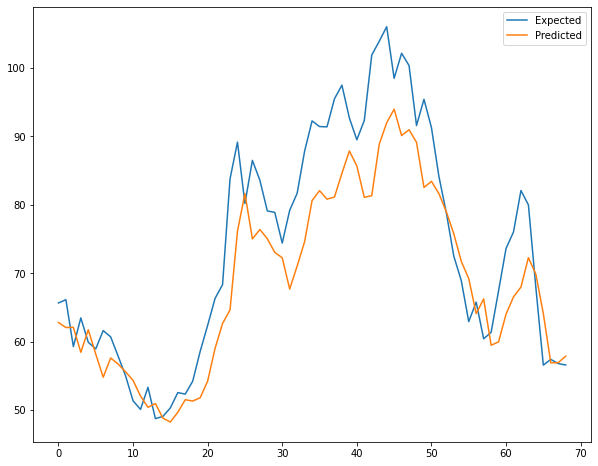

In [ ]:
plt.plot(inv_y, label='Expected')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()

# Conclusion

In [ ]:
# What did we learn about the data

In [ ]:
# Which model worked best in forecasting